# Assignment4:Sentiment Classification with Contextualized Models

**Parsing the dataset**

At first, the similar part(as the assignment1) was implemented. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [1]:
!wget -N https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvfz aclImdb_v1.tar.gz  

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [4]:
from pathlib import Path
import numpy as np


train_neg_files = Path('./aclImdb/train/neg').glob('*.txt')
train_pos_files = Path('./aclImdb/train/pos').glob('*.txt')

test_neg_files = Path('./aclImdb/test/neg').glob('*.txt')
test_pos_files = Path('./aclImdb/test/pos').glob('*.txt')


def openfile(neg_files, pos_files):
  
  X = []
  y = []

  for file in pos_files:
      with open(file) as f:
          X.append(f.read().replace('\n', '').lower())
          y.append(1)

  for file in neg_files:
      with open(file) as f:
         X.append(f.read().replace('\n', '').lower())
         y.append(-1)

  return X,y

x_train, y_train = openfile(train_neg_files,train_pos_files)
x_val, y_val = openfile(test_neg_files,test_pos_files)

print(len(x_train))
print(len(y_train))
print(x_train[0:2])
print(y_train[-10:])

25000
25000
["a very gritty, gutsy portrayal of a part of world war 2 history, that most of us in the u.s. had/have no idea ever occurred. i would love to have this on video. it only was shown on t.v. one time as far as i know, back in 89or 90. i have asked around for this movie, and most video stores don't even know about it. great actresses all around, wish that i could see it again. top notch series.", 'we fans of ed wood tend to be an obsessive bunch in the first place, but this movie in particular has driven me to a level of fan-dom that i have never before approached! one of the most intense thrills of non-mainstream movie adulation - at least as far as i am concerned - is the pleasure of unearthing the obscure. i remember how, as a teenager, i longed to see eddie\'s "revenge of the dead" (a.k.a. "night of the ghouls"), which at that time had been vaulted for a couple of decades. likewise such arcane masterpieces of low budget filmmaking as doris wishman\'s "a night to dismember"

In [5]:
X_raw = x_train + x_val

In [7]:
sum(y_train[:10])

10

In [5]:
import numpy as np

assert np.all([isinstance(x, str) for x in x_train])
assert len(x_train) == np.asarray(y_train).shape[0]
assert len(np.unique(y_train))==2
assert np.asarray(y_train).min() == -1
assert np.asarray(y_train).max() == 1

In [ ]:
import re
tokens = re.findall("[a-z]+", str(X_raw))  # tokenization processing

from sklearn.feature_extraction.text import CountVectorizer

matrix = CountVectorizer()
X = matrix.fit_transform(X_raw).toarray()

This part in assignment1 is so slow, the program always crashed because it filled up all available RAM. So we need to use sklearn package.

In [ ]:
x_train1 = X[:25000]
x_val1 = X[25000:]

In [ ]:
print(x_train1[0].shape)

(101895,)


In [ ]:
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter


class Model:

  def __init__(self, reguliser_dampening, learning_rate,initial_weight):
    self.reguliser_dampening = reguliser_dampening  # lambda
    self.learning_rate = learning_rate  # gamma
    self.initial_weight = initial_weight   #theta
    
  def __hinge_loss(self, X, y, w, lambd):  # lambda will be caculate later
    return 0.5 * lambd *(w**2)**0.5 + sum([ max( 0 , 1 - y[i] * (w.T @ X[i]))  for i in range(len(X))])
  def __l2_norm(self, w):
    return sum([ w[i]**2  for i in range(len(w))])**0.5
  def __analytic_delta(self, X, y, w, lambd):
        return lambd * w + sum([0 if y[i] * w.T @ X[i] >= 1 else - y[i] * X[i] for i in range(len(X))]) / len(X)
  def __grad_update(self, X, y, w, lambd, lr):
        return w - lr * self.__analytic_delta(X, y, w, lambd)

  def predict(self, X):
        pred = X @ self.weight
        return np.sign(pred)
      
  def fit(self, X, y):
        epochs = 0
        lambd = self.reguliser_dampening
        lr    = self.learning_rate
        self.weight = np.random.normal(0, self.initial_weight, len(X[0]))
        y_pred = self.predict(X)
        loss = np.sum(self.__hinge_loss(X, y_pred, self.weight,lambd)) / len(X[0])
        print("starting loss:", loss)
        
      
        MAX_LOSS = 0.01
        MAX_EPOCHS = 5
        with SummaryWriter() as writer: 
            while loss > MAX_LOSS and epochs < MAX_EPOCHS:
              loss = np.sum(self.__hinge_loss(X, y, self.weight, lambd)) / len(X[0])
              self.weight = self.__grad_update(X, y, self.weight, lambd, lr)
              print("loss:", loss, "epoch", epochs)
              print("accuracy:", np.sum(y_pred == y)/len(X))
              writer.add_scalar('Train/Accuracy', np.sum(y_pred == y)/len(X), epochs)
              writer.add_scalar('Train/Loss', loss , epochs)
              epochs += 1

        return self.weight

  def score(self, X, y):
        y_pred = self.predict(X)
        return ("accuracy:", np.sum(y_pred == y)/len(X))

      
test_model = Model(.00001,.05,0.01)
omega = test_model.fit(x_train1, y_train)
test_accuracy = np.sum(test_model.predict(x_val1)==y_val)/len(y_val)  #accuracy
train_accuracy = np.sum(test_model.predict(x_train1)==y_train)/len(y_train)  #accuracy
print(train_accuracy)

starting loss: 21708.363078714137
loss: 24842.343829618865 epoch 0
accuracy: 0.51524
loss: 24282.897888229174 epoch 1
accuracy: 0.51524
loss: 55495.88074242245 epoch 2
accuracy: 0.51524
loss: 102450.53313730888 epoch 3
accuracy: 0.51524
loss: 49127.64983069152 epoch 4
accuracy: 0.51524
0.5


The first assignment model was regarded as baseline, the accuracy of that is 0.519.

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 9.8 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 61.6 MB/s 
     |████████████████████████████████| 596 kB 60.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In the data preprocessing part, the reference is the tutorial on https://huggingface.co/transformers/v3.0.2/preprocessing.html. The text can be tokenized by the package 'BertTokenizer'. 

In [7]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {-1:0,
          1:1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):
        self.labels = [labels[label] for label in y]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 256, truncation=True,
                                return_tensors="pt") for text in x]  
    '''The maximum length of the text is 512. 
       If the length exceeds 512, the text will be truncated, so truncation=True
       pt : pytorch '''

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):  # preparation for Dataloader

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Model Definition**

The website https://huggingface.co/bert-base-cased gives the detailed information about the model and we can know concrete parameters in "Files and versions", eg.config.json.
There are 768 ‘neurons‘ and 2 classifications --> self.linear = nn.Linear(768, 2).

In [8]:
from torch import nn
from transformers import BertModel

class BertSentimentClassication(nn.Module):
    '''According to the paper : Dropout as data augmentation. http://arxiv.org/abs/1506.08700
       It has been verified that the implicit node dropout rate is the best when it is equal to 0.5,
       because dropout randomly generates the most network structure at 0.5'''
    def __init__(self, dropout=0.5): 

        super(BertSentimentClassication, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)  # linearization--the "hidden_size" of this model : 768 (detail can be found in website)
        self.relu = nn.ReLU()
    
    '''The final layer of the network is designed as a classifier for sentiment polarity
       The output of the previous layer is the input of the next layer'''
    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
print(x_train[20:30])
print(y_train[20:30])

['this, the finest achievement from georg wilhelm pabst\'s social realism period is based upon a tragedy in early 1906 that claimed the lives of nearly 1100 french miners as a coal dust explosion deep in mines at courrieres in northern france took place after a fire had smouldered for three weeks, eventually releasing deadly pit gas that brought about the fatalities. estimable designer erno metzner creates stark sets that simulate the tragedy, providing a perception of reality, augmented by matchless sound editing, with the only music being produced by integral orchestras during the beginning and ending portions of a work for which aural effects possess equal importance with the eminent director\'s fascinating visual compositions. pabst\'s manner of "invisible editing" that segues action from shot to shot through movements of players proves to be smoothly integrated within this landmark film that also showcases sublime cinematography utilizing cameras mounted upon vehicles, enabling th

In [9]:
from torch.optim import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

epochs = 2
batch_size = 8
model = BertSentimentClassication()
learning_rate = 1e-6  # choose a relatively low learning rate, the model converges slowly but works well

train, val = Dataset(x_train,y_train), Dataset(x_val,y_val)

# dataloader -- like a loopable data generator
train_dataloader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

criterion = nn.CrossEntropyLoss()  # loss function
optimizer = Adam(model.parameters(), lr= learning_rate)  # optimizer

if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

model_loss = []
model_acc = []
with SummaryWriter() as writer:  #  Visualization for graphics [tutorial from website: https://www.jianshu.com/p/46eb3004beca], but finally I used the matplot.
    n_iter = 0
    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)  # load gpu
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

                n_iter+=1
                model_loss.append(batch_loss.item())
                model_acc.append(acc)
                print(acc,batch_loss.item())

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

              for val_input, val_label in val_dataloader:

                  val_label = val_label.to(device)
                  mask = val_input['attention_mask'].to(device)
                  input_id = val_input['input_ids'].squeeze(1).to(device)

                  output = model(input_id, mask)

                  batch_loss = criterion(output, val_label)
                  total_loss_val += batch_loss.item()

                  acc = (output.argmax(dim=1) == val_label).sum().item()
                  total_acc_val += acc

        print(
              f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(x_train): .3f} \
              | Train Accuracy: {total_acc_train / len(x_train): .3f} \
              | Val Loss: {total_loss_val / len(x_val): .3f} \
              | Val Accuracy: {total_acc_val / len(x_val): .3f}')

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 1/3125 [00:00<16:53,  3.08it/s]

4 0.6481844186782837


  0%|          | 2/3125 [00:00<13:27,  3.87it/s]

1 0.8208050727844238


  0%|          | 3/3125 [00:00<12:18,  4.23it/s]

4 0.667854905128479


  0%|          | 4/3125 [00:00<11:46,  4.42it/s]

2 0.6924834847450256


  0%|          | 5/3125 [00:01<11:27,  4.54it/s]

5 0.688827395439148


  0%|          | 6/3125 [00:01<11:17,  4.60it/s]

4 0.7579400539398193


  0%|          | 7/3125 [00:01<11:12,  4.64it/s]

4 0.7211855053901672


  0%|          | 8/3125 [00:01<11:06,  4.68it/s]

5 0.6485832929611206


  0%|          | 9/3125 [00:02<11:02,  4.71it/s]

3 0.7143748998641968


  0%|          | 10/3125 [00:02<11:00,  4.72it/s]

3 0.7033036351203918


  0%|          | 11/3125 [00:02<10:58,  4.73it/s]

4 0.6944559812545776


  0%|          | 12/3125 [00:02<10:56,  4.74it/s]

6 0.6234571933746338


  0%|          | 13/3125 [00:02<10:56,  4.74it/s]

4 0.7860695719718933


  0%|          | 14/3125 [00:03<10:54,  4.75it/s]

5 0.6534526944160461


  0%|          | 15/3125 [00:03<10:54,  4.75it/s]

1 0.7949879765510559


  1%|          | 16/3125 [00:03<10:54,  4.75it/s]

4 0.7311710715293884


  1%|          | 17/3125 [00:03<10:53,  4.76it/s]

4 0.644262433052063


  1%|          | 18/3125 [00:03<10:54,  4.75it/s]

4 0.635787308216095


  1%|          | 19/3125 [00:04<10:53,  4.76it/s]

6 0.6119425892829895


  1%|          | 20/3125 [00:04<10:52,  4.76it/s]

4 0.707766056060791


  1%|          | 21/3125 [00:04<10:52,  4.76it/s]

6 0.655528724193573


  1%|          | 22/3125 [00:04<10:52,  4.76it/s]

1 0.8220241665840149


  1%|          | 23/3125 [00:04<10:51,  4.76it/s]

3 0.714232325553894


  1%|          | 24/3125 [00:05<10:51,  4.76it/s]

7 0.579258918762207


  1%|          | 25/3125 [00:05<10:51,  4.76it/s]

3 0.6961429715156555


  1%|          | 26/3125 [00:05<10:52,  4.75it/s]

5 0.7886282205581665


  1%|          | 27/3125 [00:05<10:51,  4.76it/s]

5 0.6637009382247925


  1%|          | 28/3125 [00:06<10:50,  4.76it/s]

5 0.632868230342865


  1%|          | 29/3125 [00:06<10:51,  4.75it/s]

6 0.6384000778198242


  1%|          | 30/3125 [00:06<10:51,  4.75it/s]

3 0.7144569754600525


  1%|          | 31/3125 [00:06<10:50,  4.76it/s]

4 0.6910691857337952


  1%|          | 32/3125 [00:06<10:50,  4.76it/s]

5 0.6787177324295044


  1%|          | 33/3125 [00:07<10:50,  4.75it/s]

4 0.7415527105331421


  1%|          | 34/3125 [00:07<10:49,  4.76it/s]

4 0.6928747892379761


  1%|          | 35/3125 [00:07<10:49,  4.76it/s]

3 0.8270569443702698


  1%|          | 36/3125 [00:07<10:49,  4.76it/s]

4 0.6905997395515442


  1%|          | 37/3125 [00:07<10:48,  4.76it/s]

4 0.6529260873794556


  1%|          | 38/3125 [00:08<10:48,  4.76it/s]

4 0.7200061082839966


  1%|          | 39/3125 [00:08<10:48,  4.76it/s]

4 0.7150807976722717


  1%|▏         | 40/3125 [00:08<10:49,  4.75it/s]

2 0.6756911277770996


  1%|▏         | 41/3125 [00:08<10:49,  4.75it/s]

5 0.6275497078895569


  1%|▏         | 42/3125 [00:08<10:48,  4.75it/s]

4 0.6517341136932373


  1%|▏         | 43/3125 [00:09<10:49,  4.75it/s]

5 0.7116171717643738


  1%|▏         | 44/3125 [00:09<10:48,  4.75it/s]

1 0.7935777902603149


  1%|▏         | 45/3125 [00:09<10:47,  4.76it/s]

3 0.7526608109474182


  1%|▏         | 46/3125 [00:09<10:46,  4.76it/s]

3 0.7053545117378235


  2%|▏         | 47/3125 [00:10<10:47,  4.76it/s]

6 0.6347321271896362


  2%|▏         | 48/3125 [00:10<10:47,  4.75it/s]

3 0.7410821318626404


  2%|▏         | 49/3125 [00:10<10:46,  4.76it/s]

5 0.6698352694511414


  2%|▏         | 50/3125 [00:10<10:47,  4.75it/s]

6 0.6356745958328247


  2%|▏         | 51/3125 [00:10<10:47,  4.75it/s]

5 0.6064105033874512


  2%|▏         | 52/3125 [00:11<10:47,  4.74it/s]

4 0.6826027035713196


  2%|▏         | 53/3125 [00:11<10:47,  4.75it/s]

4 0.6928300857543945


  2%|▏         | 54/3125 [00:11<10:46,  4.75it/s]

2 0.763564944267273


  2%|▏         | 55/3125 [00:11<10:46,  4.75it/s]

4 0.8158495426177979


  2%|▏         | 56/3125 [00:11<10:45,  4.76it/s]

3 0.6891846060752869


  2%|▏         | 57/3125 [00:12<10:45,  4.76it/s]

4 0.7167620062828064


  2%|▏         | 58/3125 [00:12<10:44,  4.76it/s]

5 0.7171580791473389


  2%|▏         | 59/3125 [00:12<10:44,  4.76it/s]

4 0.702629029750824


  2%|▏         | 60/3125 [00:12<10:43,  4.76it/s]

4 0.7167269587516785


  2%|▏         | 61/3125 [00:12<10:44,  4.75it/s]

3 0.7436321377754211


  2%|▏         | 62/3125 [00:13<10:45,  4.74it/s]

2 0.6910160183906555


  2%|▏         | 63/3125 [00:13<10:46,  4.74it/s]

3 0.7461057901382446


  2%|▏         | 64/3125 [00:13<10:54,  4.68it/s]

4 0.693371057510376


  2%|▏         | 65/3125 [00:13<10:50,  4.70it/s]

1 0.7980591058731079


  2%|▏         | 66/3125 [00:14<10:49,  4.71it/s]

5 0.6768811345100403


  2%|▏         | 67/3125 [00:14<10:47,  4.72it/s]

4 0.7464166879653931


  2%|▏         | 68/3125 [00:14<10:56,  4.65it/s]

6 0.6550800800323486


  2%|▏         | 69/3125 [00:14<10:52,  4.68it/s]

5 0.7433291673660278


  2%|▏         | 70/3125 [00:14<10:50,  4.70it/s]

5 0.717494010925293


  2%|▏         | 71/3125 [00:15<10:47,  4.72it/s]

4 0.6749690771102905


  2%|▏         | 72/3125 [00:15<10:46,  4.72it/s]

1 0.763752818107605


  2%|▏         | 73/3125 [00:15<10:44,  4.74it/s]

1 0.8304824829101562


  2%|▏         | 74/3125 [00:15<10:43,  4.74it/s]

2 0.7149591445922852


  2%|▏         | 75/3125 [00:15<10:41,  4.76it/s]

4 0.6581241488456726


  2%|▏         | 76/3125 [00:16<10:40,  4.76it/s]

2 0.6949339509010315


  2%|▏         | 77/3125 [00:16<10:40,  4.76it/s]

3 0.8043695688247681


  2%|▏         | 78/3125 [00:16<10:41,  4.75it/s]

3 0.6593393683433533


  3%|▎         | 79/3125 [00:16<10:40,  4.75it/s]

6 0.6548585891723633


  3%|▎         | 80/3125 [00:16<10:40,  4.75it/s]

7 0.6216368675231934


  3%|▎         | 81/3125 [00:17<10:40,  4.75it/s]

3 0.7411559820175171


  3%|▎         | 82/3125 [00:17<10:40,  4.75it/s]

3 0.7719608545303345


  3%|▎         | 83/3125 [00:17<10:39,  4.76it/s]

2 0.7126961946487427


  3%|▎         | 84/3125 [00:17<10:39,  4.76it/s]

5 0.6718157529830933


  3%|▎         | 85/3125 [00:18<10:39,  4.75it/s]

4 0.6733902096748352


  3%|▎         | 86/3125 [00:18<10:39,  4.75it/s]

6 0.6713307499885559


  3%|▎         | 87/3125 [00:18<10:38,  4.75it/s]

3 0.6289815306663513


  3%|▎         | 88/3125 [00:18<10:38,  4.76it/s]

2 0.7403580546379089


  3%|▎         | 89/3125 [00:18<10:38,  4.76it/s]

4 0.7247822284698486


  3%|▎         | 90/3125 [00:19<10:38,  4.75it/s]

4 0.6405537724494934


  3%|▎         | 91/3125 [00:19<10:37,  4.76it/s]

5 0.6931816339492798


  3%|▎         | 92/3125 [00:19<10:37,  4.76it/s]

5 0.725741446018219


  3%|▎         | 93/3125 [00:19<10:37,  4.76it/s]

4 0.7090174555778503


  3%|▎         | 94/3125 [00:19<10:35,  4.77it/s]

1 0.7775824666023254


  3%|▎         | 95/3125 [00:20<10:35,  4.77it/s]

3 0.6934402585029602


  3%|▎         | 96/3125 [00:20<10:35,  4.77it/s]

3 0.7492425441741943


  3%|▎         | 97/3125 [00:20<10:35,  4.76it/s]

4 0.6851927042007446


  3%|▎         | 98/3125 [00:20<10:35,  4.76it/s]

4 0.7156664133071899


  3%|▎         | 99/3125 [00:20<10:36,  4.76it/s]

4 0.6966447830200195


  3%|▎         | 100/3125 [00:21<10:36,  4.75it/s]

4 0.7171615362167358


  3%|▎         | 101/3125 [00:21<10:35,  4.76it/s]

5 0.6649606227874756


  3%|▎         | 102/3125 [00:21<10:35,  4.76it/s]

3 0.6880090236663818


  3%|▎         | 103/3125 [00:21<10:35,  4.76it/s]

6 0.7407158017158508


  3%|▎         | 104/3125 [00:22<10:35,  4.75it/s]

5 0.6790422797203064


  3%|▎         | 105/3125 [00:22<10:35,  4.75it/s]

4 0.761400580406189


  3%|▎         | 106/3125 [00:22<10:35,  4.75it/s]

3 0.7134836912155151


  3%|▎         | 107/3125 [00:22<10:34,  4.76it/s]

1 0.7658452987670898


  3%|▎         | 108/3125 [00:22<10:34,  4.76it/s]

4 0.7052018046379089


  3%|▎         | 109/3125 [00:23<10:34,  4.76it/s]

2 0.7725789546966553


  4%|▎         | 110/3125 [00:23<10:33,  4.76it/s]

3 0.76874178647995


  4%|▎         | 111/3125 [00:23<10:32,  4.76it/s]

5 0.6990666389465332


  4%|▎         | 112/3125 [00:23<10:32,  4.77it/s]

4 0.7492448091506958


  4%|▎         | 113/3125 [00:23<10:32,  4.76it/s]

4 0.6770386695861816


  4%|▎         | 114/3125 [00:24<10:32,  4.76it/s]

4 0.6786759495735168


  4%|▎         | 115/3125 [00:24<10:32,  4.76it/s]

4 0.6349962949752808


  4%|▎         | 116/3125 [00:24<10:31,  4.76it/s]

4 0.6360304355621338


  4%|▎         | 117/3125 [00:24<10:32,  4.76it/s]

4 0.6582054495811462


  4%|▍         | 118/3125 [00:24<10:31,  4.76it/s]

4 0.7592702507972717


  4%|▍         | 119/3125 [00:25<10:30,  4.77it/s]

5 0.6840852499008179


  4%|▍         | 120/3125 [00:25<10:34,  4.73it/s]

4 0.7289195656776428


  4%|▍         | 121/3125 [00:25<10:33,  4.74it/s]

5 0.6598746180534363


  4%|▍         | 122/3125 [00:25<10:33,  4.74it/s]

5 0.6631423234939575


  4%|▍         | 123/3125 [00:26<10:32,  4.75it/s]

4 0.7056440711021423


  4%|▍         | 124/3125 [00:26<10:32,  4.75it/s]

5 0.6869294047355652


  4%|▍         | 125/3125 [00:26<10:30,  4.76it/s]

3 0.7896516919136047


  4%|▍         | 126/3125 [00:26<10:29,  4.76it/s]

3 0.7088655829429626


  4%|▍         | 127/3125 [00:26<10:28,  4.77it/s]

3 0.7366080284118652


  4%|▍         | 128/3125 [00:27<10:29,  4.76it/s]

4 0.6736027002334595


  4%|▍         | 129/3125 [00:27<10:28,  4.77it/s]

2 0.736147403717041


  4%|▍         | 130/3125 [00:27<10:28,  4.77it/s]

2 0.7898584008216858


  4%|▍         | 131/3125 [00:27<10:27,  4.77it/s]

4 0.6871134042739868


  4%|▍         | 132/3125 [00:27<10:27,  4.77it/s]

1 0.8081219792366028


  4%|▍         | 133/3125 [00:28<10:28,  4.76it/s]

1 0.7489917278289795


  4%|▍         | 134/3125 [00:28<10:28,  4.76it/s]

3 0.695355236530304


  4%|▍         | 135/3125 [00:28<10:28,  4.76it/s]

2 0.7674552798271179


  4%|▍         | 136/3125 [00:28<10:27,  4.76it/s]

2 0.7614197134971619


  4%|▍         | 137/3125 [00:28<10:28,  4.76it/s]

7 0.6134927868843079


  4%|▍         | 138/3125 [00:29<10:27,  4.76it/s]

3 0.7009902596473694


  4%|▍         | 139/3125 [00:29<10:28,  4.75it/s]

5 0.6970184445381165


  4%|▍         | 140/3125 [00:29<10:26,  4.76it/s]

3 0.8855941891670227


  5%|▍         | 141/3125 [00:29<10:27,  4.76it/s]

3 0.7488610148429871


  5%|▍         | 142/3125 [00:29<10:27,  4.76it/s]

4 0.6518824100494385


  5%|▍         | 143/3125 [00:30<10:25,  4.77it/s]

3 0.6957526206970215


  5%|▍         | 144/3125 [00:30<10:25,  4.77it/s]

4 0.7291396856307983


  5%|▍         | 145/3125 [00:30<10:25,  4.76it/s]

4 0.7493985891342163


  5%|▍         | 146/3125 [00:30<10:26,  4.76it/s]

3 0.6813012361526489


  5%|▍         | 147/3125 [00:31<10:25,  4.76it/s]

3 0.7134491801261902


  5%|▍         | 148/3125 [00:31<10:25,  4.76it/s]

2 0.7162007689476013


  5%|▍         | 149/3125 [00:31<10:24,  4.76it/s]

5 0.6372447609901428


  5%|▍         | 150/3125 [00:31<10:24,  4.76it/s]

4 0.7226422429084778


  5%|▍         | 151/3125 [00:31<10:24,  4.76it/s]

2 0.6671595573425293


  5%|▍         | 152/3125 [00:32<10:24,  4.76it/s]

5 0.71247398853302


  5%|▍         | 153/3125 [00:32<10:24,  4.76it/s]

6 0.6313230991363525


  5%|▍         | 154/3125 [00:32<10:23,  4.77it/s]

3 0.7587168216705322


  5%|▍         | 155/3125 [00:32<10:23,  4.77it/s]

4 0.721968412399292


  5%|▍         | 156/3125 [00:32<10:22,  4.77it/s]

1 0.7112910747528076


  5%|▌         | 157/3125 [00:33<10:22,  4.77it/s]

3 0.7170993685722351


  5%|▌         | 158/3125 [00:33<10:22,  4.76it/s]

7 0.6422386169433594


  5%|▌         | 159/3125 [00:33<10:24,  4.75it/s]

2 0.7850736379623413


  5%|▌         | 160/3125 [00:33<10:23,  4.76it/s]

4 0.7824583649635315


  5%|▌         | 161/3125 [00:33<10:22,  4.76it/s]

4 0.7168352007865906


  5%|▌         | 162/3125 [00:34<10:22,  4.76it/s]

2 0.7553108930587769


  5%|▌         | 163/3125 [00:34<10:23,  4.75it/s]

2 0.7348959445953369


  5%|▌         | 164/3125 [00:34<10:22,  4.76it/s]

4 0.6704664826393127


  5%|▌         | 165/3125 [00:34<10:21,  4.76it/s]

4 0.6441456079483032


  5%|▌         | 166/3125 [00:35<10:21,  4.76it/s]

4 0.6295384764671326


  5%|▌         | 167/3125 [00:35<10:21,  4.76it/s]

3 0.7024888396263123


  5%|▌         | 168/3125 [00:35<10:22,  4.75it/s]

5 0.713810384273529


  5%|▌         | 169/3125 [00:35<10:21,  4.76it/s]

4 0.6817987561225891


  5%|▌         | 170/3125 [00:35<10:20,  4.76it/s]

4 0.6915771961212158


  5%|▌         | 171/3125 [00:36<10:20,  4.76it/s]

3 0.7617532014846802


  6%|▌         | 172/3125 [00:36<10:21,  4.75it/s]

1 0.779278576374054


  6%|▌         | 173/3125 [00:36<10:22,  4.74it/s]

3 0.7932447195053101


  6%|▌         | 174/3125 [00:36<10:20,  4.76it/s]

6 0.6716916561126709


  6%|▌         | 175/3125 [00:36<10:20,  4.75it/s]

3 0.7753567695617676


  6%|▌         | 176/3125 [00:37<10:18,  4.76it/s]

4 0.6735281348228455


  6%|▌         | 177/3125 [00:37<10:19,  4.76it/s]

1 0.7221217751502991


  6%|▌         | 178/3125 [00:37<10:19,  4.76it/s]

3 0.7988387942314148


  6%|▌         | 179/3125 [00:37<10:19,  4.76it/s]

2 0.7596461772918701


  6%|▌         | 180/3125 [00:37<10:19,  4.75it/s]

3 0.7081637978553772


  6%|▌         | 181/3125 [00:38<10:17,  4.77it/s]

2 0.6956742405891418


  6%|▌         | 182/3125 [00:38<10:18,  4.76it/s]

4 0.7157882452011108


  6%|▌         | 183/3125 [00:38<10:18,  4.76it/s]

3 0.6797383427619934


  6%|▌         | 184/3125 [00:38<10:19,  4.74it/s]

4 0.7563116550445557


  6%|▌         | 185/3125 [00:39<10:18,  4.76it/s]

6 0.6919479370117188


  6%|▌         | 186/3125 [00:39<10:17,  4.76it/s]

2 0.7755038142204285


  6%|▌         | 187/3125 [00:39<10:17,  4.75it/s]

4 0.6798420548439026


  6%|▌         | 188/3125 [00:39<10:18,  4.75it/s]

5 0.655689001083374


  6%|▌         | 189/3125 [00:39<10:17,  4.76it/s]

3 0.7361308932304382


  6%|▌         | 190/3125 [00:40<10:17,  4.75it/s]

2 0.7169070243835449


  6%|▌         | 191/3125 [00:40<10:17,  4.75it/s]

4 0.6933966875076294


  6%|▌         | 192/3125 [00:40<10:16,  4.76it/s]

5 0.6509418487548828


  6%|▌         | 193/3125 [00:40<10:16,  4.76it/s]

3 0.6936742067337036


  6%|▌         | 194/3125 [00:40<10:15,  4.76it/s]

6 0.6794472932815552


  6%|▌         | 195/3125 [00:41<10:16,  4.76it/s]

4 0.6966949105262756


  6%|▋         | 196/3125 [00:41<10:16,  4.75it/s]

4 0.7371734380722046


  6%|▋         | 197/3125 [00:41<10:15,  4.76it/s]

3 0.7563048601150513


  6%|▋         | 198/3125 [00:41<10:15,  4.76it/s]

6 0.6590310335159302


  6%|▋         | 199/3125 [00:41<10:14,  4.76it/s]

5 0.639845609664917


  6%|▋         | 200/3125 [00:42<10:15,  4.76it/s]

5 0.7134210467338562


  6%|▋         | 201/3125 [00:42<10:15,  4.75it/s]

2 0.647670328617096


  6%|▋         | 202/3125 [00:42<10:16,  4.74it/s]

5 0.7057306170463562


  6%|▋         | 203/3125 [00:42<10:15,  4.75it/s]

4 0.7542528510093689


  7%|▋         | 204/3125 [00:43<10:15,  4.75it/s]

3 0.7163165807723999


  7%|▋         | 205/3125 [00:43<10:14,  4.75it/s]

3 0.6929085850715637


  7%|▋         | 206/3125 [00:43<10:15,  4.74it/s]

4 0.7519588470458984


  7%|▋         | 207/3125 [00:43<10:15,  4.74it/s]

5 0.7588741779327393


  7%|▋         | 208/3125 [00:43<10:14,  4.75it/s]

5 0.6670811176300049


  7%|▋         | 209/3125 [00:44<10:14,  4.75it/s]

4 0.6626784205436707


  7%|▋         | 210/3125 [00:44<10:14,  4.74it/s]

4 0.6857932806015015


  7%|▋         | 211/3125 [00:44<10:14,  4.74it/s]

5 0.6486054062843323


  7%|▋         | 212/3125 [00:44<10:13,  4.75it/s]

2 0.7149533033370972


  7%|▋         | 213/3125 [00:44<10:13,  4.75it/s]

3 0.75664883852005


  7%|▋         | 214/3125 [00:45<10:12,  4.75it/s]

3 0.7535706758499146


  7%|▋         | 215/3125 [00:45<10:13,  4.74it/s]

5 0.6712232232093811


  7%|▋         | 216/3125 [00:45<10:13,  4.74it/s]

5 0.6872336268424988


  7%|▋         | 217/3125 [00:45<10:11,  4.76it/s]

6 0.6027095913887024


  7%|▋         | 218/3125 [00:45<10:10,  4.76it/s]

4 0.6982889175415039


  7%|▋         | 219/3125 [00:46<10:10,  4.76it/s]

5 0.6548969745635986


  7%|▋         | 220/3125 [00:46<10:12,  4.74it/s]

2 0.7611246109008789


  7%|▋         | 221/3125 [00:46<10:12,  4.74it/s]

6 0.6833281517028809


  7%|▋         | 222/3125 [00:46<10:10,  4.75it/s]

5 0.6640722751617432


  7%|▋         | 223/3125 [00:47<10:09,  4.76it/s]

3 0.6712964177131653


  7%|▋         | 224/3125 [00:47<10:08,  4.77it/s]

3 0.783198356628418


  7%|▋         | 225/3125 [00:47<10:09,  4.76it/s]

3 0.7687848806381226


  7%|▋         | 226/3125 [00:47<10:08,  4.76it/s]

3 0.6717382073402405


  7%|▋         | 227/3125 [00:47<10:08,  4.76it/s]

3 0.738653302192688


  7%|▋         | 228/3125 [00:48<10:08,  4.76it/s]

6 0.6168547868728638


  7%|▋         | 229/3125 [00:48<10:08,  4.76it/s]

5 0.6537890434265137


  7%|▋         | 230/3125 [00:48<10:09,  4.75it/s]

2 0.7573479413986206


  7%|▋         | 231/3125 [00:48<10:09,  4.75it/s]

3 0.6600890159606934


  7%|▋         | 232/3125 [00:48<10:08,  4.76it/s]

4 0.7920211553573608


  7%|▋         | 233/3125 [00:49<10:07,  4.76it/s]

4 0.6502314209938049


  7%|▋         | 234/3125 [00:49<10:07,  4.76it/s]

4 0.7102506160736084


  8%|▊         | 235/3125 [00:49<10:07,  4.76it/s]

4 0.6817029714584351


  8%|▊         | 236/3125 [00:49<10:07,  4.76it/s]

5 0.7314485907554626


  8%|▊         | 237/3125 [00:49<10:07,  4.75it/s]

6 0.6542669534683228


  8%|▊         | 238/3125 [00:50<10:07,  4.76it/s]

4 0.6710240244865417


  8%|▊         | 239/3125 [00:50<10:07,  4.75it/s]

2 0.7355067133903503


  8%|▊         | 240/3125 [00:50<10:08,  4.74it/s]

5 0.7952597737312317


  8%|▊         | 241/3125 [00:50<10:07,  4.75it/s]

5 0.7270030379295349


  8%|▊         | 242/3125 [00:51<10:07,  4.74it/s]

3 0.7355408668518066


  8%|▊         | 243/3125 [00:51<10:07,  4.75it/s]

4 0.6901783347129822


  8%|▊         | 244/3125 [00:51<10:06,  4.75it/s]

6 0.641822099685669


  8%|▊         | 245/3125 [00:51<10:06,  4.75it/s]

5 0.6823328137397766


  8%|▊         | 246/3125 [00:51<10:06,  4.75it/s]

6 0.6652616858482361


  8%|▊         | 247/3125 [00:52<10:06,  4.74it/s]

6 0.6685976386070251


  8%|▊         | 248/3125 [00:52<10:06,  4.74it/s]

4 0.7916179299354553


  8%|▊         | 249/3125 [00:52<10:05,  4.75it/s]

5 0.6693677306175232


  8%|▊         | 250/3125 [00:52<10:04,  4.76it/s]

4 0.6759769916534424


  8%|▊         | 251/3125 [00:52<10:03,  4.76it/s]

4 0.7163482308387756


  8%|▊         | 252/3125 [00:53<10:04,  4.76it/s]

5 0.6027949452400208


  8%|▊         | 253/3125 [00:53<10:03,  4.76it/s]

5 0.6996247172355652


  8%|▊         | 254/3125 [00:53<10:03,  4.76it/s]

2 0.7956397533416748


  8%|▊         | 255/3125 [00:53<10:03,  4.76it/s]

4 0.6902967095375061


  8%|▊         | 256/3125 [00:53<10:02,  4.76it/s]

3 0.7488314509391785


  8%|▊         | 257/3125 [00:54<10:02,  4.76it/s]

4 0.7292217016220093


  8%|▊         | 258/3125 [00:54<10:02,  4.76it/s]

5 0.6712398529052734


  8%|▊         | 259/3125 [00:54<10:03,  4.75it/s]

6 0.6724532842636108


  8%|▊         | 260/3125 [00:54<10:02,  4.76it/s]

5 0.6564851999282837


  8%|▊         | 261/3125 [00:55<10:01,  4.76it/s]

5 0.6907200217247009


  8%|▊         | 262/3125 [00:55<10:01,  4.76it/s]

4 0.8079514503479004


  8%|▊         | 263/3125 [00:55<10:01,  4.76it/s]

2 0.8261191844940186


  8%|▊         | 264/3125 [00:55<10:01,  4.76it/s]

3 0.713762104511261


  8%|▊         | 265/3125 [00:55<10:00,  4.76it/s]

5 0.6288846135139465


  9%|▊         | 266/3125 [00:56<10:00,  4.76it/s]

5 0.657145619392395


  9%|▊         | 267/3125 [00:56<10:00,  4.76it/s]

4 0.7182934880256653


  9%|▊         | 268/3125 [00:56<10:00,  4.76it/s]

6 0.695429801940918


  9%|▊         | 269/3125 [00:56<09:59,  4.76it/s]

4 0.7149861454963684


  9%|▊         | 270/3125 [00:56<09:59,  4.76it/s]

3 0.7107875347137451


  9%|▊         | 271/3125 [00:57<09:58,  4.77it/s]

4 0.7440956234931946


  9%|▊         | 272/3125 [00:57<09:58,  4.77it/s]

2 0.7549481391906738


  9%|▊         | 273/3125 [00:57<09:59,  4.75it/s]

5 0.6800652742385864


  9%|▉         | 274/3125 [00:57<09:59,  4.75it/s]

4 0.6931471824645996


  9%|▉         | 275/3125 [00:57<09:59,  4.75it/s]

4 0.72402024269104


  9%|▉         | 276/3125 [00:58<09:58,  4.76it/s]

3 0.8026840686798096


  9%|▉         | 277/3125 [00:58<09:58,  4.76it/s]

2 0.7021715641021729


  9%|▉         | 278/3125 [00:58<09:58,  4.76it/s]

5 0.6715417504310608


  9%|▉         | 279/3125 [00:58<09:58,  4.76it/s]

4 0.7255358099937439


  9%|▉         | 280/3125 [00:59<09:57,  4.76it/s]

2 0.6848580241203308


  9%|▉         | 281/3125 [00:59<09:57,  4.76it/s]

3 0.7235764265060425


  9%|▉         | 282/3125 [00:59<09:57,  4.76it/s]

4 0.7199794054031372


  9%|▉         | 283/3125 [00:59<09:55,  4.77it/s]

4 0.6602904796600342


  9%|▉         | 284/3125 [00:59<09:55,  4.77it/s]

4 0.6722596883773804


  9%|▉         | 285/3125 [01:00<09:56,  4.76it/s]

6 0.626153290271759


  9%|▉         | 286/3125 [01:00<09:55,  4.77it/s]

4 0.645430862903595


  9%|▉         | 287/3125 [01:00<09:55,  4.77it/s]

3 0.7088063359260559


  9%|▉         | 288/3125 [01:00<09:55,  4.76it/s]

5 0.7105212211608887


  9%|▉         | 289/3125 [01:00<09:56,  4.75it/s]

2 0.7312037944793701


  9%|▉         | 290/3125 [01:01<09:56,  4.75it/s]

4 0.6818501353263855


  9%|▉         | 291/3125 [01:01<09:56,  4.75it/s]

7 0.651784360408783


  9%|▉         | 292/3125 [01:01<09:55,  4.75it/s]

4 0.7377379536628723


  9%|▉         | 293/3125 [01:01<09:55,  4.76it/s]

5 0.652323305606842


  9%|▉         | 294/3125 [01:01<09:55,  4.76it/s]

6 0.6597828269004822


  9%|▉         | 295/3125 [01:02<09:55,  4.75it/s]

5 0.7297826409339905


  9%|▉         | 296/3125 [01:02<09:53,  4.76it/s]

4 0.7005229592323303


 10%|▉         | 297/3125 [01:02<09:55,  4.75it/s]

4 0.7527045011520386


 10%|▉         | 298/3125 [01:02<09:54,  4.75it/s]

2 0.7109114527702332


 10%|▉         | 299/3125 [01:03<09:53,  4.76it/s]

2 0.6839241981506348


 10%|▉         | 300/3125 [01:03<09:53,  4.76it/s]

1 0.7231870293617249


 10%|▉         | 301/3125 [01:03<09:54,  4.75it/s]

3 0.7117131948471069


 10%|▉         | 302/3125 [01:03<09:54,  4.75it/s]

3 0.7389020323753357


 10%|▉         | 303/3125 [01:03<09:53,  4.76it/s]

3 0.7088001370429993


 10%|▉         | 304/3125 [01:04<09:54,  4.75it/s]

5 0.7012357711791992


 10%|▉         | 305/3125 [01:04<09:53,  4.75it/s]

2 0.8081880211830139


 10%|▉         | 306/3125 [01:04<09:53,  4.75it/s]

4 0.7669934630393982


 10%|▉         | 307/3125 [01:04<09:55,  4.73it/s]

2 0.7268232703208923


 10%|▉         | 308/3125 [01:04<09:53,  4.75it/s]

6 0.6543706655502319


 10%|▉         | 309/3125 [01:05<09:52,  4.75it/s]

4 0.6677919626235962


 10%|▉         | 310/3125 [01:05<09:51,  4.76it/s]

4 0.7110002636909485


 10%|▉         | 311/3125 [01:05<09:51,  4.76it/s]

3 0.6784753203392029


 10%|▉         | 312/3125 [01:05<09:50,  4.76it/s]

5 0.7560952305793762


 10%|█         | 313/3125 [01:05<09:51,  4.75it/s]

7 0.6826761364936829


 10%|█         | 314/3125 [01:06<09:49,  4.77it/s]

5 0.6734445691108704


 10%|█         | 315/3125 [01:06<09:50,  4.76it/s]

2 0.7017742991447449


 10%|█         | 316/3125 [01:06<09:48,  4.77it/s]

3 0.6928697824478149


 10%|█         | 317/3125 [01:06<09:47,  4.78it/s]

2 0.7107193470001221


 10%|█         | 318/3125 [01:07<09:48,  4.77it/s]

4 0.70414799451828


 10%|█         | 319/3125 [01:07<09:48,  4.77it/s]

2 0.7038180828094482


 10%|█         | 320/3125 [01:07<09:49,  4.76it/s]

7 0.6208328008651733


 10%|█         | 321/3125 [01:07<09:48,  4.76it/s]

7 0.6453822255134583


 10%|█         | 322/3125 [01:07<09:47,  4.77it/s]

6 0.6878796219825745


 10%|█         | 323/3125 [01:08<09:47,  4.77it/s]

5 0.6792373061180115


 10%|█         | 324/3125 [01:08<09:46,  4.77it/s]

3 0.7236369848251343


 10%|█         | 325/3125 [01:08<09:47,  4.77it/s]

3 0.704220712184906


 10%|█         | 326/3125 [01:08<09:46,  4.77it/s]

6 0.6701841950416565


 10%|█         | 327/3125 [01:08<09:48,  4.75it/s]

4 0.6816827654838562


 10%|█         | 328/3125 [01:09<09:47,  4.76it/s]

4 0.6629502773284912


 11%|█         | 329/3125 [01:09<09:47,  4.76it/s]

4 0.7704429626464844


 11%|█         | 330/3125 [01:09<09:46,  4.77it/s]

4 0.6710707545280457


 11%|█         | 331/3125 [01:09<09:47,  4.76it/s]

5 0.6434255838394165


 11%|█         | 332/3125 [01:09<09:47,  4.76it/s]

4 0.7477948069572449


 11%|█         | 333/3125 [01:10<09:47,  4.75it/s]

3 0.7206264138221741


 11%|█         | 334/3125 [01:10<09:47,  4.75it/s]

3 0.7203875780105591


 11%|█         | 335/3125 [01:10<09:47,  4.75it/s]

3 0.7004762291908264


 11%|█         | 336/3125 [01:10<09:45,  4.76it/s]

4 0.6844134330749512


 11%|█         | 337/3125 [01:10<09:46,  4.75it/s]

5 0.7096691131591797


 11%|█         | 338/3125 [01:11<09:45,  4.76it/s]

2 0.7407184839248657


 11%|█         | 339/3125 [01:11<09:46,  4.75it/s]

3 0.6829112768173218


 11%|█         | 340/3125 [01:11<09:45,  4.76it/s]

3 0.7250183820724487


 11%|█         | 341/3125 [01:11<09:43,  4.77it/s]

5 0.6650176048278809


 11%|█         | 342/3125 [01:12<09:44,  4.77it/s]

3 0.7145903706550598


 11%|█         | 343/3125 [01:12<09:43,  4.77it/s]

2 0.7043934464454651


 11%|█         | 344/3125 [01:12<09:43,  4.76it/s]

4 0.6069869995117188


 11%|█         | 345/3125 [01:12<09:43,  4.77it/s]

5 0.61182701587677


 11%|█         | 346/3125 [01:12<09:43,  4.76it/s]

5 0.6225993633270264


 11%|█         | 347/3125 [01:13<09:44,  4.75it/s]

3 0.7085152864456177


 11%|█         | 348/3125 [01:13<09:43,  4.76it/s]

5 0.8008050322532654


 11%|█         | 349/3125 [01:13<09:43,  4.76it/s]

6 0.644275963306427


 11%|█         | 350/3125 [01:13<09:43,  4.76it/s]

4 0.7033457159996033


 11%|█         | 351/3125 [01:13<09:44,  4.75it/s]

4 0.7086977958679199


 11%|█▏        | 352/3125 [01:14<09:42,  4.76it/s]

6 0.7001851797103882


 11%|█▏        | 353/3125 [01:14<09:42,  4.76it/s]

5 0.7115402221679688


 11%|█▏        | 354/3125 [01:14<09:42,  4.76it/s]

8 0.5956824421882629


 11%|█▏        | 355/3125 [01:14<09:41,  4.76it/s]

6 0.6770787835121155


 11%|█▏        | 356/3125 [01:14<09:41,  4.76it/s]

3 0.673917293548584


 11%|█▏        | 357/3125 [01:15<09:40,  4.77it/s]

3 0.7446752190589905


 11%|█▏        | 358/3125 [01:15<09:40,  4.77it/s]

3 0.7803612351417542


 11%|█▏        | 359/3125 [01:15<09:40,  4.76it/s]

3 0.8219096660614014


 12%|█▏        | 360/3125 [01:15<09:41,  4.76it/s]

3 0.6934869885444641


 12%|█▏        | 361/3125 [01:16<09:41,  4.76it/s]

2 0.6510874032974243


 12%|█▏        | 362/3125 [01:16<09:41,  4.76it/s]

4 0.6622302532196045


 12%|█▏        | 363/3125 [01:16<09:41,  4.75it/s]

5 0.6814545392990112


 12%|█▏        | 364/3125 [01:16<09:40,  4.75it/s]

3 0.6604986190795898


 12%|█▏        | 365/3125 [01:16<09:39,  4.76it/s]

4 0.6937941312789917


 12%|█▏        | 366/3125 [01:17<09:41,  4.75it/s]

6 0.7083884477615356


 12%|█▏        | 367/3125 [01:17<09:39,  4.76it/s]

5 0.6559785008430481


 12%|█▏        | 368/3125 [01:17<09:39,  4.76it/s]

4 0.7021379470825195


 12%|█▏        | 369/3125 [01:17<09:39,  4.76it/s]

3 0.7029228806495667


 12%|█▏        | 370/3125 [01:17<09:38,  4.76it/s]

7 0.6601495742797852


 12%|█▏        | 371/3125 [01:18<09:38,  4.76it/s]

3 0.6599424481391907


 12%|█▏        | 372/3125 [01:18<09:38,  4.76it/s]

4 0.6369967460632324


 12%|█▏        | 373/3125 [01:18<09:38,  4.76it/s]

3 0.7087937593460083


 12%|█▏        | 374/3125 [01:18<09:37,  4.76it/s]

2 0.6649836301803589


 12%|█▏        | 375/3125 [01:18<09:37,  4.76it/s]

4 0.6985716223716736


 12%|█▏        | 376/3125 [01:19<09:37,  4.76it/s]

3 0.698966383934021


 12%|█▏        | 377/3125 [01:19<09:37,  4.76it/s]

5 0.6667424440383911


 12%|█▏        | 378/3125 [01:19<09:36,  4.76it/s]

3 0.7241360545158386


 12%|█▏        | 379/3125 [01:19<09:36,  4.77it/s]

6 0.7130626440048218


 12%|█▏        | 380/3125 [01:20<09:37,  4.75it/s]

6 0.6784878373146057


 12%|█▏        | 381/3125 [01:20<09:37,  4.75it/s]

4 0.6900501251220703


 12%|█▏        | 382/3125 [01:20<09:36,  4.76it/s]

3 0.6633313894271851


 12%|█▏        | 383/3125 [01:20<09:36,  4.76it/s]

6 0.6368915438652039


 12%|█▏        | 384/3125 [01:20<09:35,  4.76it/s]

4 0.7046464085578918


 12%|█▏        | 385/3125 [01:21<09:35,  4.76it/s]

5 0.6579349040985107


 12%|█▏        | 386/3125 [01:21<09:35,  4.76it/s]

4 0.7179357409477234


 12%|█▏        | 387/3125 [01:21<09:35,  4.76it/s]

5 0.7173627018928528


 12%|█▏        | 388/3125 [01:21<09:36,  4.75it/s]

6 0.687584400177002


 12%|█▏        | 389/3125 [01:21<09:35,  4.76it/s]

5 0.6814361810684204


 12%|█▏        | 390/3125 [01:22<09:34,  4.76it/s]

4 0.6992654800415039


 13%|█▎        | 391/3125 [01:22<09:35,  4.75it/s]

4 0.7040578722953796


 13%|█▎        | 392/3125 [01:22<09:34,  4.76it/s]

5 0.734600305557251


 13%|█▎        | 393/3125 [01:22<09:35,  4.74it/s]

4 0.7610748410224915


 13%|█▎        | 394/3125 [01:22<09:35,  4.74it/s]

3 0.6949611306190491


 13%|█▎        | 395/3125 [01:23<09:34,  4.75it/s]

5 0.6638240218162537


 13%|█▎        | 396/3125 [01:23<09:35,  4.74it/s]

2 0.6793296933174133


 13%|█▎        | 397/3125 [01:23<09:33,  4.75it/s]

5 0.7479261755943298


 13%|█▎        | 398/3125 [01:23<09:34,  4.75it/s]

5 0.7023203372955322


 13%|█▎        | 399/3125 [01:24<09:33,  4.75it/s]

3 0.7374700903892517


 13%|█▎        | 400/3125 [01:24<09:33,  4.75it/s]

4 0.7137755751609802


 13%|█▎        | 401/3125 [01:24<09:32,  4.76it/s]

4 0.7162545919418335


 13%|█▎        | 402/3125 [01:24<09:32,  4.76it/s]

4 0.675943911075592


 13%|█▎        | 403/3125 [01:24<09:31,  4.76it/s]

3 0.7542623281478882


 13%|█▎        | 404/3125 [01:25<09:32,  4.75it/s]

5 0.6400397419929504


 13%|█▎        | 405/3125 [01:25<09:31,  4.76it/s]

4 0.6633692383766174


 13%|█▎        | 406/3125 [01:25<09:31,  4.76it/s]

2 0.7235440015792847


 13%|█▎        | 407/3125 [01:25<09:31,  4.76it/s]

3 0.6776595115661621


 13%|█▎        | 408/3125 [01:25<09:30,  4.76it/s]

1 0.8388468623161316


 13%|█▎        | 409/3125 [01:26<09:30,  4.76it/s]

6 0.6546762585639954


 13%|█▎        | 410/3125 [01:26<09:31,  4.75it/s]

1 0.7252902984619141


 13%|█▎        | 411/3125 [01:26<09:29,  4.76it/s]

5 0.6848586201667786


 13%|█▎        | 412/3125 [01:26<09:29,  4.76it/s]

4 0.7045814394950867


 13%|█▎        | 413/3125 [01:26<09:30,  4.75it/s]

4 0.7395155429840088


 13%|█▎        | 414/3125 [01:27<09:29,  4.76it/s]

6 0.6744290590286255


 13%|█▎        | 415/3125 [01:27<09:30,  4.75it/s]

3 0.7182700634002686


 13%|█▎        | 416/3125 [01:27<09:31,  4.74it/s]

4 0.7122660279273987


 13%|█▎        | 417/3125 [01:27<09:29,  4.75it/s]

6 0.679793119430542


 13%|█▎        | 418/3125 [01:28<09:29,  4.75it/s]

5 0.6648354530334473


 13%|█▎        | 419/3125 [01:28<09:28,  4.76it/s]

5 0.7156939506530762


 13%|█▎        | 420/3125 [01:28<09:29,  4.75it/s]

3 0.697210967540741


 13%|█▎        | 421/3125 [01:28<09:28,  4.76it/s]

3 0.711747407913208


 14%|█▎        | 422/3125 [01:28<09:26,  4.77it/s]

1 0.7657191753387451


 14%|█▎        | 423/3125 [01:29<09:27,  4.76it/s]

6 0.6949552297592163


 14%|█▎        | 424/3125 [01:29<09:28,  4.75it/s]

4 0.6993415951728821


 14%|█▎        | 425/3125 [01:29<09:28,  4.75it/s]

2 0.7341526746749878


 14%|█▎        | 426/3125 [01:29<09:29,  4.74it/s]

4 0.6809226274490356


 14%|█▎        | 427/3125 [01:29<09:28,  4.75it/s]

5 0.6718785762786865


 14%|█▎        | 428/3125 [01:30<09:27,  4.75it/s]

3 0.7519623041152954


 14%|█▎        | 429/3125 [01:30<09:26,  4.76it/s]

5 0.7004345655441284


 14%|█▍        | 430/3125 [01:30<09:26,  4.75it/s]

2 0.6856867671012878


 14%|█▍        | 431/3125 [01:30<09:26,  4.76it/s]

1 0.7709627747535706


 14%|█▍        | 432/3125 [01:30<09:26,  4.75it/s]

4 0.6898202896118164


 14%|█▍        | 433/3125 [01:31<09:26,  4.75it/s]

4 0.6888885498046875


 14%|█▍        | 434/3125 [01:31<09:25,  4.76it/s]

5 0.7038536071777344


 14%|█▍        | 435/3125 [01:31<09:25,  4.76it/s]

6 0.6155470609664917


 14%|█▍        | 436/3125 [01:31<09:25,  4.75it/s]

4 0.6594850420951843


 14%|█▍        | 437/3125 [01:32<09:24,  4.76it/s]

3 0.725877046585083


 14%|█▍        | 438/3125 [01:32<09:24,  4.76it/s]

5 0.7065566778182983


 14%|█▍        | 439/3125 [01:32<09:24,  4.76it/s]

6 0.6686110496520996


 14%|█▍        | 440/3125 [01:32<09:24,  4.76it/s]

6 0.646201491355896


 14%|█▍        | 441/3125 [01:32<09:24,  4.76it/s]

4 0.6725079417228699


 14%|█▍        | 442/3125 [01:33<09:23,  4.76it/s]

3 0.785295307636261


 14%|█▍        | 443/3125 [01:33<09:24,  4.75it/s]

6 0.6914995312690735


 14%|█▍        | 444/3125 [01:33<09:23,  4.76it/s]

1 0.7593806982040405


 14%|█▍        | 445/3125 [01:33<09:21,  4.77it/s]

4 0.7708286046981812


 14%|█▍        | 446/3125 [01:33<09:20,  4.78it/s]

4 0.7735778093338013


 14%|█▍        | 447/3125 [01:34<09:21,  4.77it/s]

2 0.7214009761810303


 14%|█▍        | 448/3125 [01:34<09:21,  4.77it/s]

2 0.8201992511749268


 14%|█▍        | 449/3125 [01:34<09:21,  4.77it/s]

6 0.7354722619056702


 14%|█▍        | 450/3125 [01:34<09:21,  4.77it/s]

5 0.6448544263839722


 14%|█▍        | 451/3125 [01:34<09:21,  4.76it/s]

6 0.6940770149230957


 14%|█▍        | 452/3125 [01:35<09:21,  4.76it/s]

3 0.7140815258026123


 14%|█▍        | 453/3125 [01:35<09:22,  4.75it/s]

3 0.7912681102752686


 15%|█▍        | 454/3125 [01:35<09:22,  4.74it/s]

3 0.7236971855163574


 15%|█▍        | 455/3125 [01:35<09:21,  4.75it/s]

3 0.6543022394180298


 15%|█▍        | 456/3125 [01:36<09:24,  4.73it/s]

2 0.7419626712799072


 15%|█▍        | 457/3125 [01:36<09:24,  4.73it/s]

2 0.7141627669334412


 15%|█▍        | 458/3125 [01:36<09:21,  4.75it/s]

5 0.677845299243927


 15%|█▍        | 459/3125 [01:36<09:20,  4.75it/s]

6 0.7125197649002075


 15%|█▍        | 460/3125 [01:36<09:21,  4.75it/s]

3 0.684150218963623


 15%|█▍        | 461/3125 [01:37<09:20,  4.75it/s]

4 0.7726444005966187


 15%|█▍        | 462/3125 [01:37<09:20,  4.75it/s]

2 0.6676326394081116


 15%|█▍        | 463/3125 [01:37<09:20,  4.75it/s]

2 0.7808940410614014


 15%|█▍        | 464/3125 [01:37<09:18,  4.76it/s]

3 0.7200953960418701


 15%|█▍        | 465/3125 [01:37<09:19,  4.76it/s]

4 0.6868993639945984


 15%|█▍        | 466/3125 [01:38<09:18,  4.76it/s]

3 0.8075577616691589


 15%|█▍        | 467/3125 [01:38<09:19,  4.75it/s]

4 0.6993855237960815


 15%|█▍        | 468/3125 [01:38<09:20,  4.74it/s]

4 0.7054669260978699


 15%|█▌        | 469/3125 [01:38<09:19,  4.74it/s]

5 0.581633985042572


 15%|█▌        | 470/3125 [01:38<09:18,  4.75it/s]

5 0.7021486163139343


 15%|█▌        | 471/3125 [01:39<09:21,  4.73it/s]

2 0.7641899585723877


 15%|█▌        | 472/3125 [01:39<09:19,  4.74it/s]

6 0.6823286414146423


 15%|█▌        | 473/3125 [01:39<09:18,  4.74it/s]

4 0.6256968975067139


 15%|█▌        | 474/3125 [01:39<09:18,  4.75it/s]

1 0.7824329137802124


 15%|█▌        | 475/3125 [01:40<09:17,  4.75it/s]

4 0.7022944688796997


 15%|█▌        | 476/3125 [01:40<09:17,  4.75it/s]

4 0.782766580581665


 15%|█▌        | 477/3125 [01:40<09:17,  4.75it/s]

4 0.7280360460281372


 15%|█▌        | 478/3125 [01:40<09:16,  4.76it/s]

2 0.7757248878479004


 15%|█▌        | 479/3125 [01:40<09:17,  4.75it/s]

5 0.690841019153595


 15%|█▌        | 480/3125 [01:41<09:17,  4.75it/s]

5 0.6931471824645996


 15%|█▌        | 481/3125 [01:41<09:15,  4.76it/s]

4 0.6640767455101013


 15%|█▌        | 482/3125 [01:41<09:15,  4.76it/s]

2 0.7333004474639893


 15%|█▌        | 483/3125 [01:41<09:15,  4.76it/s]

4 0.7829954028129578


 15%|█▌        | 484/3125 [01:41<09:15,  4.76it/s]

4 0.7030548453330994


 16%|█▌        | 485/3125 [01:42<09:14,  4.76it/s]

5 0.6725093722343445


 16%|█▌        | 486/3125 [01:42<09:15,  4.75it/s]

3 0.7754742503166199


 16%|█▌        | 487/3125 [01:42<09:13,  4.76it/s]

4 0.7225550413131714


 16%|█▌        | 488/3125 [01:42<09:13,  4.76it/s]

4 0.6572453379631042


 16%|█▌        | 489/3125 [01:42<09:13,  4.76it/s]

5 0.7336877584457397


 16%|█▌        | 490/3125 [01:43<09:13,  4.76it/s]

3 0.6696977019309998


 16%|█▌        | 491/3125 [01:43<09:12,  4.77it/s]

3 0.6725402474403381


 16%|█▌        | 492/3125 [01:43<09:12,  4.76it/s]

2 0.8039485812187195


 16%|█▌        | 493/3125 [01:43<09:11,  4.77it/s]

5 0.6954506039619446


 16%|█▌        | 494/3125 [01:44<09:12,  4.76it/s]

5 0.6674781441688538


 16%|█▌        | 495/3125 [01:44<09:12,  4.76it/s]

4 0.7425704002380371


 16%|█▌        | 496/3125 [01:44<09:13,  4.75it/s]

7 0.6921296119689941


 16%|█▌        | 497/3125 [01:44<09:11,  4.76it/s]

5 0.6602180600166321


 16%|█▌        | 498/3125 [01:44<09:11,  4.77it/s]

4 0.7171972393989563


 16%|█▌        | 499/3125 [01:45<09:11,  4.76it/s]

3 0.7093145847320557


 16%|█▌        | 500/3125 [01:45<09:11,  4.76it/s]

6 0.6880736947059631


 16%|█▌        | 501/3125 [01:45<09:12,  4.75it/s]

4 0.7095872163772583


 16%|█▌        | 502/3125 [01:45<09:11,  4.76it/s]

4 0.6703175902366638


 16%|█▌        | 503/3125 [01:45<09:13,  4.74it/s]

6 0.6810224056243896


 16%|█▌        | 504/3125 [01:46<09:11,  4.75it/s]

3 0.7071308493614197


 16%|█▌        | 505/3125 [01:46<09:11,  4.75it/s]

2 0.6983399391174316


 16%|█▌        | 506/3125 [01:46<09:11,  4.75it/s]

4 0.7109662294387817


 16%|█▌        | 507/3125 [01:46<09:10,  4.76it/s]

4 0.668306827545166


 16%|█▋        | 508/3125 [01:46<09:09,  4.76it/s]

5 0.6931471824645996


 16%|█▋        | 509/3125 [01:47<09:10,  4.76it/s]

6 0.6769952178001404


 16%|█▋        | 510/3125 [01:47<09:10,  4.75it/s]

6 0.6931471824645996


 16%|█▋        | 511/3125 [01:47<09:16,  4.69it/s]

5 0.6985785961151123


 16%|█▋        | 512/3125 [01:47<09:19,  4.67it/s]

5 0.6500299572944641


 16%|█▋        | 513/3125 [01:48<09:16,  4.69it/s]

2 0.6734130382537842


 16%|█▋        | 514/3125 [01:48<09:13,  4.72it/s]

4 0.6894291639328003


 16%|█▋        | 515/3125 [01:48<09:12,  4.73it/s]

2 0.722417950630188


 17%|█▋        | 516/3125 [01:48<09:10,  4.74it/s]

4 0.7357129454612732


 17%|█▋        | 517/3125 [01:48<09:10,  4.74it/s]

3 0.7289151549339294


 17%|█▋        | 518/3125 [01:49<09:09,  4.74it/s]

4 0.6448342204093933


 17%|█▋        | 519/3125 [01:49<09:08,  4.75it/s]

4 0.712928056716919


 17%|█▋        | 520/3125 [01:49<09:07,  4.76it/s]

4 0.6982471942901611


 17%|█▋        | 521/3125 [01:49<09:06,  4.76it/s]

4 0.7221382856369019


 17%|█▋        | 522/3125 [01:49<09:07,  4.75it/s]

4 0.6411375999450684


 17%|█▋        | 523/3125 [01:50<09:08,  4.75it/s]

2 0.8529738783836365


 17%|█▋        | 524/3125 [01:50<09:07,  4.75it/s]

6 0.641905665397644


 17%|█▋        | 525/3125 [01:50<09:08,  4.74it/s]

3 0.7311774492263794


 17%|█▋        | 526/3125 [01:50<09:07,  4.74it/s]

4 0.6913490295410156


 17%|█▋        | 527/3125 [01:50<09:06,  4.75it/s]

6 0.6582772135734558


 17%|█▋        | 528/3125 [01:51<09:06,  4.75it/s]

5 0.6542614102363586


 17%|█▋        | 529/3125 [01:51<09:06,  4.75it/s]

3 0.7098692059516907


 17%|█▋        | 530/3125 [01:51<09:06,  4.75it/s]

4 0.743338406085968


 17%|█▋        | 531/3125 [01:51<09:04,  4.76it/s]

4 0.6472894549369812


 17%|█▋        | 532/3125 [01:52<09:05,  4.75it/s]

6 0.7359700202941895


 17%|█▋        | 533/3125 [01:52<09:06,  4.74it/s]

5 0.7673075199127197


 17%|█▋        | 534/3125 [01:52<09:04,  4.76it/s]

1 0.7420061230659485


 17%|█▋        | 535/3125 [01:52<09:04,  4.76it/s]

2 0.7659844756126404


 17%|█▋        | 536/3125 [01:52<09:04,  4.75it/s]

5 0.6678587794303894


 17%|█▋        | 537/3125 [01:53<09:03,  4.76it/s]

3 0.655314028263092


 17%|█▋        | 538/3125 [01:53<09:03,  4.76it/s]

3 0.7382467985153198


 17%|█▋        | 539/3125 [01:53<09:03,  4.76it/s]

3 0.7595052123069763


 17%|█▋        | 540/3125 [01:53<09:03,  4.76it/s]

4 0.6841551661491394


 17%|█▋        | 541/3125 [01:53<09:03,  4.75it/s]

2 0.711150050163269


 17%|█▋        | 542/3125 [01:54<09:03,  4.75it/s]

4 0.6849287152290344


 17%|█▋        | 543/3125 [01:54<09:03,  4.75it/s]

6 0.6517714858055115


 17%|█▋        | 544/3125 [01:54<09:01,  4.76it/s]

2 0.6717612147331238


 17%|█▋        | 545/3125 [01:54<09:01,  4.76it/s]

1 0.730762779712677


 17%|█▋        | 546/3125 [01:54<09:02,  4.75it/s]

3 0.7153558731079102


 18%|█▊        | 547/3125 [01:55<09:02,  4.75it/s]

4 0.6453378796577454


 18%|█▊        | 548/3125 [01:55<09:03,  4.74it/s]

6 0.7325983643531799


 18%|█▊        | 549/3125 [01:55<09:01,  4.75it/s]

4 0.71346116065979


 18%|█▊        | 550/3125 [01:55<09:01,  4.75it/s]

2 0.717292070388794


 18%|█▊        | 551/3125 [01:56<09:01,  4.76it/s]

4 0.7079282999038696


 18%|█▊        | 552/3125 [01:56<09:01,  4.75it/s]

3 0.7432944774627686


 18%|█▊        | 553/3125 [01:56<09:03,  4.74it/s]

5 0.7167256474494934


 18%|█▊        | 554/3125 [01:56<09:01,  4.75it/s]

4 0.6628451347351074


 18%|█▊        | 555/3125 [01:56<09:01,  4.75it/s]

3 0.7356893420219421


 18%|█▊        | 556/3125 [01:57<09:00,  4.75it/s]

6 0.6813315153121948


 18%|█▊        | 557/3125 [01:57<09:00,  4.75it/s]

4 0.750420093536377


 18%|█▊        | 558/3125 [01:57<09:00,  4.75it/s]

4 0.6482152342796326


 18%|█▊        | 559/3125 [01:57<08:59,  4.76it/s]

4 0.6772608160972595


 18%|█▊        | 560/3125 [01:57<09:00,  4.75it/s]

4 0.7066137194633484


 18%|█▊        | 561/3125 [01:58<08:59,  4.75it/s]

1 0.7056634426116943


 18%|█▊        | 562/3125 [01:58<09:00,  4.74it/s]

4 0.6858985424041748


 18%|█▊        | 563/3125 [01:58<08:59,  4.75it/s]

4 0.6620007157325745


 18%|█▊        | 564/3125 [01:58<08:58,  4.75it/s]

2 0.7473477721214294


 18%|█▊        | 565/3125 [01:58<08:59,  4.75it/s]

3 0.6931272149085999


 18%|█▊        | 566/3125 [01:59<08:59,  4.74it/s]

5 0.7189013957977295


 18%|█▊        | 567/3125 [01:59<08:58,  4.75it/s]

4 0.6378546953201294


 18%|█▊        | 568/3125 [01:59<08:59,  4.74it/s]

7 0.6661385893821716


 18%|█▊        | 569/3125 [01:59<08:59,  4.74it/s]

5 0.6353155970573425


 18%|█▊        | 570/3125 [02:00<08:58,  4.75it/s]

3 0.6888254880905151


 18%|█▊        | 571/3125 [02:00<08:57,  4.75it/s]

4 0.6845681667327881


 18%|█▊        | 572/3125 [02:00<08:59,  4.74it/s]

5 0.6949995756149292


 18%|█▊        | 573/3125 [02:00<08:57,  4.75it/s]

4 0.6987944841384888


 18%|█▊        | 574/3125 [02:00<08:56,  4.75it/s]

6 0.6354928016662598


 18%|█▊        | 575/3125 [02:01<08:56,  4.75it/s]

3 0.6556089520454407


 18%|█▊        | 576/3125 [02:01<08:56,  4.75it/s]

6 0.6800286173820496


 18%|█▊        | 577/3125 [02:01<08:55,  4.76it/s]

3 0.738982617855072


 18%|█▊        | 578/3125 [02:01<08:54,  4.76it/s]

3 0.700901210308075


 19%|█▊        | 579/3125 [02:01<08:55,  4.75it/s]

2 0.8047236204147339


 19%|█▊        | 580/3125 [02:02<08:54,  4.76it/s]

5 0.6682516932487488


 19%|█▊        | 581/3125 [02:02<08:54,  4.76it/s]

2 0.6830307841300964


 19%|█▊        | 582/3125 [02:02<08:54,  4.75it/s]

4 0.7321783900260925


 19%|█▊        | 583/3125 [02:02<08:55,  4.75it/s]

3 0.6934527158737183


 19%|█▊        | 584/3125 [02:02<08:54,  4.75it/s]

2 0.6738278865814209


 19%|█▊        | 585/3125 [02:03<08:55,  4.74it/s]

6 0.6611215472221375


 19%|█▉        | 586/3125 [02:03<08:54,  4.75it/s]

6 0.6824691295623779


 19%|█▉        | 587/3125 [02:03<08:54,  4.75it/s]

3 0.7125624418258667


 19%|█▉        | 588/3125 [02:03<08:54,  4.74it/s]

5 0.7122198343276978


 19%|█▉        | 589/3125 [02:04<08:54,  4.74it/s]

2 0.7353135347366333


 19%|█▉        | 590/3125 [02:04<08:55,  4.74it/s]

3 0.7222038507461548


 19%|█▉        | 591/3125 [02:04<08:53,  4.75it/s]

4 0.6828031539916992


 19%|█▉        | 592/3125 [02:04<08:53,  4.75it/s]

4 0.6650692820549011


 19%|█▉        | 593/3125 [02:04<08:53,  4.75it/s]

6 0.695835530757904


 19%|█▉        | 594/3125 [02:05<08:52,  4.75it/s]

5 0.6642521023750305


 19%|█▉        | 595/3125 [02:05<08:52,  4.75it/s]

6 0.6439740657806396


 19%|█▉        | 596/3125 [02:05<08:52,  4.75it/s]

5 0.681160032749176


 19%|█▉        | 597/3125 [02:05<08:51,  4.76it/s]

4 0.7478273510932922


 19%|█▉        | 598/3125 [02:05<08:51,  4.75it/s]

4 0.6500244140625


 19%|█▉        | 599/3125 [02:06<08:51,  4.75it/s]

2 0.7037497162818909


 19%|█▉        | 600/3125 [02:06<08:52,  4.74it/s]

4 0.7211486101150513


 19%|█▉        | 601/3125 [02:06<08:52,  4.74it/s]

6 0.6661164164543152


 19%|█▉        | 602/3125 [02:06<08:52,  4.74it/s]

4 0.6875566244125366


 19%|█▉        | 603/3125 [02:06<08:50,  4.75it/s]

2 0.7325178384780884


 19%|█▉        | 604/3125 [02:07<08:50,  4.75it/s]

6 0.6540339589118958


 19%|█▉        | 605/3125 [02:07<08:50,  4.75it/s]

6 0.6839260458946228


 19%|█▉        | 606/3125 [02:07<08:50,  4.75it/s]

3 0.6746498346328735


 19%|█▉        | 607/3125 [02:07<08:50,  4.74it/s]

3 0.7316303849220276


 19%|█▉        | 608/3125 [02:08<08:49,  4.75it/s]

6 0.7010965347290039


 19%|█▉        | 609/3125 [02:08<08:49,  4.75it/s]

4 0.6776882410049438


 20%|█▉        | 610/3125 [02:08<08:49,  4.75it/s]

4 0.7228637337684631


 20%|█▉        | 611/3125 [02:08<08:49,  4.75it/s]

3 0.6561108827590942


 20%|█▉        | 612/3125 [02:08<08:50,  4.74it/s]

2 0.7154932618141174


 20%|█▉        | 613/3125 [02:09<08:49,  4.75it/s]

1 0.6931471824645996


 20%|█▉        | 614/3125 [02:09<08:50,  4.74it/s]

6 0.6768797636032104


 20%|█▉        | 615/3125 [02:09<08:49,  4.74it/s]

5 0.6413916349411011


 20%|█▉        | 616/3125 [02:09<08:49,  4.74it/s]

5 0.6582481265068054


 20%|█▉        | 617/3125 [02:09<08:49,  4.73it/s]

4 0.6673199534416199


 20%|█▉        | 618/3125 [02:10<08:48,  4.74it/s]

4 0.68608558177948


 20%|█▉        | 619/3125 [02:10<08:48,  4.74it/s]

4 0.6697779297828674


 20%|█▉        | 620/3125 [02:10<08:47,  4.75it/s]

2 0.7763898968696594


 20%|█▉        | 621/3125 [02:10<08:48,  4.74it/s]

6 0.6440064907073975


 20%|█▉        | 622/3125 [02:10<08:46,  4.75it/s]

4 0.7042755484580994


 20%|█▉        | 623/3125 [02:11<08:46,  4.75it/s]

5 0.5781030654907227


 20%|█▉        | 624/3125 [02:11<08:46,  4.75it/s]

0 0.7234469652175903


 20%|██        | 625/3125 [02:11<08:46,  4.75it/s]

5 0.689026951789856


 20%|██        | 626/3125 [02:11<08:46,  4.75it/s]

4 0.7653602361679077


 20%|██        | 627/3125 [02:12<08:46,  4.74it/s]

6 0.6903374791145325


 20%|██        | 628/3125 [02:12<08:46,  4.74it/s]

4 0.6723911166191101


 20%|██        | 629/3125 [02:12<08:47,  4.73it/s]

1 0.776745617389679


 20%|██        | 630/3125 [02:12<08:45,  4.75it/s]

7 0.6864663362503052


 20%|██        | 631/3125 [02:12<08:45,  4.74it/s]

5 0.632208526134491


 20%|██        | 632/3125 [02:13<08:45,  4.74it/s]

3 0.7166635990142822


 20%|██        | 633/3125 [02:13<08:45,  4.74it/s]

5 0.6992201805114746


 20%|██        | 634/3125 [02:13<08:45,  4.74it/s]

4 0.7075923085212708


 20%|██        | 635/3125 [02:13<08:45,  4.74it/s]

2 0.7003278136253357


 20%|██        | 636/3125 [02:13<08:44,  4.75it/s]

5 0.6977615356445312


 20%|██        | 637/3125 [02:14<08:44,  4.74it/s]

3 0.7473312020301819


 20%|██        | 638/3125 [02:14<08:43,  4.75it/s]

6 0.7080850601196289


 20%|██        | 639/3125 [02:14<08:44,  4.74it/s]

4 0.7110372185707092


 20%|██        | 640/3125 [02:14<08:44,  4.74it/s]

5 0.7125334739685059


 21%|██        | 641/3125 [02:14<08:43,  4.74it/s]

3 0.7031641602516174


 21%|██        | 642/3125 [02:15<08:43,  4.74it/s]

4 0.6899477243423462


 21%|██        | 643/3125 [02:15<08:43,  4.74it/s]

6 0.6637687087059021


 21%|██        | 644/3125 [02:15<08:43,  4.74it/s]

5 0.6376913189888


 21%|██        | 645/3125 [02:15<08:42,  4.75it/s]

4 0.6729723811149597


 21%|██        | 646/3125 [02:16<08:42,  4.75it/s]

4 0.7714347243309021


 21%|██        | 647/3125 [02:16<08:42,  4.75it/s]

3 0.7452793717384338


 21%|██        | 648/3125 [02:16<08:41,  4.75it/s]

6 0.6709393858909607


 21%|██        | 649/3125 [02:16<08:41,  4.75it/s]

4 0.6709941029548645


 21%|██        | 650/3125 [02:16<08:41,  4.75it/s]

4 0.626117467880249


 21%|██        | 651/3125 [02:17<08:41,  4.74it/s]

7 0.6308099031448364


 21%|██        | 652/3125 [02:17<08:40,  4.75it/s]

3 0.6857948303222656


 21%|██        | 653/3125 [02:17<08:40,  4.75it/s]

5 0.7157794833183289


 21%|██        | 654/3125 [02:17<08:41,  4.74it/s]

4 0.6732295155525208


 21%|██        | 655/3125 [02:17<08:42,  4.73it/s]

3 0.6348126530647278


 21%|██        | 656/3125 [02:18<08:40,  4.74it/s]

3 0.7296287417411804


 21%|██        | 657/3125 [02:18<08:41,  4.73it/s]

6 0.6688140630722046


 21%|██        | 658/3125 [02:18<08:41,  4.73it/s]

6 0.6856763958930969


 21%|██        | 659/3125 [02:18<08:40,  4.73it/s]

6 0.7214843034744263


 21%|██        | 660/3125 [02:18<08:38,  4.75it/s]

0 0.7912213206291199


 21%|██        | 661/3125 [02:19<08:38,  4.75it/s]

5 0.6889245510101318


 21%|██        | 662/3125 [02:19<08:37,  4.76it/s]

4 0.7241501808166504


 21%|██        | 663/3125 [02:19<08:37,  4.76it/s]

5 0.7083864808082581


 21%|██        | 664/3125 [02:19<08:37,  4.75it/s]

3 0.7005446553230286


 21%|██▏       | 665/3125 [02:20<08:38,  4.75it/s]

3 0.695361316204071


 21%|██▏       | 666/3125 [02:20<08:38,  4.74it/s]

4 0.6398512125015259


 21%|██▏       | 667/3125 [02:20<08:38,  4.74it/s]

3 0.7259328365325928


 21%|██▏       | 668/3125 [02:20<08:37,  4.75it/s]

5 0.6730697751045227


 21%|██▏       | 669/3125 [02:20<08:37,  4.75it/s]

1 0.7199975252151489


 21%|██▏       | 670/3125 [02:21<08:37,  4.74it/s]

5 0.6924170255661011


 21%|██▏       | 671/3125 [02:21<08:37,  4.75it/s]

6 0.56013423204422


 22%|██▏       | 672/3125 [02:21<08:36,  4.75it/s]

2 0.7662071585655212


 22%|██▏       | 673/3125 [02:21<08:36,  4.75it/s]

5 0.6787621378898621


 22%|██▏       | 674/3125 [02:21<08:36,  4.75it/s]

2 0.7742266654968262


 22%|██▏       | 675/3125 [02:22<08:36,  4.75it/s]

2 0.7911913394927979


 22%|██▏       | 676/3125 [02:22<08:35,  4.75it/s]

4 0.6909872889518738


 22%|██▏       | 677/3125 [02:22<08:35,  4.75it/s]

1 0.8759951591491699


 22%|██▏       | 678/3125 [02:22<08:34,  4.76it/s]

3 0.6758100986480713


 22%|██▏       | 679/3125 [02:22<08:34,  4.75it/s]

4 0.6693807244300842


 22%|██▏       | 680/3125 [02:23<08:33,  4.76it/s]

3 0.701801061630249


 22%|██▏       | 681/3125 [02:23<08:34,  4.75it/s]

3 0.7218641638755798


 22%|██▏       | 682/3125 [02:23<08:33,  4.76it/s]

4 0.6806038022041321


 22%|██▏       | 683/3125 [02:23<08:33,  4.75it/s]

5 0.682418167591095


 22%|██▏       | 684/3125 [02:24<08:32,  4.76it/s]

6 0.6482664942741394


 22%|██▏       | 685/3125 [02:24<08:32,  4.76it/s]

5 0.7110607624053955


 22%|██▏       | 686/3125 [02:24<08:32,  4.76it/s]

3 0.656492292881012


 22%|██▏       | 687/3125 [02:24<08:31,  4.76it/s]

8 0.6629598736763


 22%|██▏       | 688/3125 [02:24<08:32,  4.76it/s]

1 0.7008125185966492


 22%|██▏       | 689/3125 [02:25<08:31,  4.76it/s]

6 0.6484334468841553


 22%|██▏       | 690/3125 [02:25<08:31,  4.76it/s]

6 0.6452857851982117


 22%|██▏       | 691/3125 [02:25<08:31,  4.75it/s]

8 0.6417755484580994


 22%|██▏       | 692/3125 [02:25<08:32,  4.75it/s]

6 0.6422228813171387


 22%|██▏       | 693/3125 [02:25<08:31,  4.75it/s]

5 0.640566349029541


 22%|██▏       | 694/3125 [02:26<08:31,  4.76it/s]

3 0.6974993348121643


 22%|██▏       | 695/3125 [02:26<08:30,  4.76it/s]

3 0.748117208480835


 22%|██▏       | 696/3125 [02:26<08:29,  4.77it/s]

3 0.6740294694900513


 22%|██▏       | 697/3125 [02:26<08:28,  4.77it/s]

3 0.6756159663200378


 22%|██▏       | 698/3125 [02:26<08:30,  4.76it/s]

5 0.7307199835777283


 22%|██▏       | 699/3125 [02:27<08:29,  4.76it/s]

2 0.7373253703117371


 22%|██▏       | 700/3125 [02:27<08:29,  4.76it/s]

6 0.6976537704467773


 22%|██▏       | 701/3125 [02:27<08:29,  4.76it/s]

6 0.6967626810073853


 22%|██▏       | 702/3125 [02:27<08:29,  4.76it/s]

5 0.6590434312820435


 22%|██▏       | 703/3125 [02:28<08:29,  4.76it/s]

5 0.7139998078346252


 23%|██▎       | 704/3125 [02:28<08:28,  4.76it/s]

3 0.7225263714790344


 23%|██▎       | 705/3125 [02:28<08:28,  4.76it/s]

5 0.7089959383010864


 23%|██▎       | 706/3125 [02:28<08:28,  4.76it/s]

4 0.7110856771469116


 23%|██▎       | 707/3125 [02:28<08:27,  4.77it/s]

5 0.6581022143363953


 23%|██▎       | 708/3125 [02:29<08:28,  4.75it/s]

4 0.6951348781585693


 23%|██▎       | 709/3125 [02:29<08:27,  4.76it/s]

2 0.7267798185348511


 23%|██▎       | 710/3125 [02:29<08:26,  4.76it/s]

5 0.6335577964782715


 23%|██▎       | 711/3125 [02:29<08:26,  4.76it/s]

3 0.7355765104293823


 23%|██▎       | 712/3125 [02:29<08:27,  4.75it/s]

4 0.6335083842277527


 23%|██▎       | 713/3125 [02:30<08:26,  4.76it/s]

5 0.6986938118934631


 23%|██▎       | 714/3125 [02:30<08:26,  4.76it/s]

6 0.6634265184402466


 23%|██▎       | 715/3125 [02:30<08:26,  4.76it/s]

5 0.6941775679588318


 23%|██▎       | 716/3125 [02:30<08:26,  4.76it/s]

5 0.630942165851593


 23%|██▎       | 717/3125 [02:30<08:25,  4.76it/s]

4 0.7107999324798584


 23%|██▎       | 718/3125 [02:31<08:26,  4.75it/s]

4 0.687454879283905


 23%|██▎       | 719/3125 [02:31<08:25,  4.76it/s]

6 0.6944205164909363


 23%|██▎       | 720/3125 [02:31<08:26,  4.75it/s]

1 0.6980127096176147


 23%|██▎       | 721/3125 [02:31<08:25,  4.75it/s]

7 0.6391971707344055


 23%|██▎       | 722/3125 [02:32<08:25,  4.75it/s]

3 0.7060860395431519


 23%|██▎       | 723/3125 [02:32<08:26,  4.75it/s]

3 0.6888699531555176


 23%|██▎       | 724/3125 [02:32<08:25,  4.75it/s]

6 0.6796113848686218


 23%|██▎       | 725/3125 [02:32<08:24,  4.76it/s]

4 0.7112193703651428


 23%|██▎       | 726/3125 [02:32<08:24,  4.75it/s]

3 0.6718043088912964


 23%|██▎       | 727/3125 [02:33<08:23,  4.76it/s]

5 0.7343920469284058


 23%|██▎       | 728/3125 [02:33<08:23,  4.76it/s]

4 0.7483103275299072


 23%|██▎       | 729/3125 [02:33<08:23,  4.76it/s]

2 0.6901264190673828


 23%|██▎       | 730/3125 [02:33<08:22,  4.76it/s]

2 0.7423045635223389


 23%|██▎       | 731/3125 [02:33<08:21,  4.77it/s]

4 0.6842464208602905


 23%|██▎       | 732/3125 [02:34<08:22,  4.76it/s]

6 0.6897860169410706


 23%|██▎       | 733/3125 [02:34<08:24,  4.74it/s]

3 0.730898380279541


 23%|██▎       | 734/3125 [02:34<08:23,  4.75it/s]

3 0.6503834128379822


 24%|██▎       | 735/3125 [02:34<08:22,  4.75it/s]

6 0.6475228071212769


 24%|██▎       | 736/3125 [02:34<08:23,  4.74it/s]

2 0.7415440678596497


 24%|██▎       | 737/3125 [02:35<08:23,  4.74it/s]

5 0.6713292002677917


 24%|██▎       | 738/3125 [02:35<08:22,  4.75it/s]

6 0.672056257724762


 24%|██▎       | 739/3125 [02:35<08:22,  4.75it/s]

6 0.6870326399803162


 24%|██▎       | 740/3125 [02:35<08:21,  4.75it/s]

4 0.7157384753227234


 24%|██▎       | 741/3125 [02:36<08:21,  4.75it/s]

5 0.6696569919586182


 24%|██▎       | 742/3125 [02:36<08:21,  4.76it/s]

3 0.6981048583984375


 24%|██▍       | 743/3125 [02:36<08:20,  4.76it/s]

2 0.6842042803764343


 24%|██▍       | 744/3125 [02:36<08:23,  4.73it/s]

5 0.7531498670578003


 24%|██▍       | 745/3125 [02:36<08:22,  4.74it/s]

1 0.7407220602035522


 24%|██▍       | 746/3125 [02:37<08:21,  4.74it/s]

6 0.6127467155456543


 24%|██▍       | 747/3125 [02:37<08:20,  4.75it/s]

6 0.6916349530220032


 24%|██▍       | 748/3125 [02:37<08:20,  4.75it/s]

2 0.740296483039856


 24%|██▍       | 749/3125 [02:37<08:20,  4.75it/s]

4 0.8170655369758606


 24%|██▍       | 750/3125 [02:37<08:20,  4.75it/s]

6 0.6869017481803894


 24%|██▍       | 751/3125 [02:38<08:20,  4.74it/s]

2 0.7286570072174072


 24%|██▍       | 752/3125 [02:38<08:18,  4.76it/s]

5 0.6454828977584839


 24%|██▍       | 753/3125 [02:38<08:19,  4.75it/s]

2 0.6703325510025024


 24%|██▍       | 754/3125 [02:38<08:18,  4.76it/s]

4 0.7028693556785583


 24%|██▍       | 755/3125 [02:38<08:19,  4.75it/s]

4 0.7112609148025513


 24%|██▍       | 756/3125 [02:39<08:18,  4.75it/s]

4 0.7062068581581116


 24%|██▍       | 757/3125 [02:39<08:18,  4.75it/s]

5 0.6868393421173096


 24%|██▍       | 758/3125 [02:39<08:18,  4.74it/s]

4 0.7227751016616821


 24%|██▍       | 759/3125 [02:39<08:17,  4.76it/s]

3 0.6697815656661987


 24%|██▍       | 760/3125 [02:40<08:18,  4.75it/s]

5 0.621006965637207


 24%|██▍       | 761/3125 [02:40<08:17,  4.75it/s]

1 0.7412979006767273


 24%|██▍       | 762/3125 [02:40<08:17,  4.75it/s]

3 0.6358587145805359


 24%|██▍       | 763/3125 [02:40<08:16,  4.75it/s]

4 0.6920341849327087


 24%|██▍       | 764/3125 [02:40<08:16,  4.76it/s]

3 0.726514458656311


 24%|██▍       | 765/3125 [02:41<08:17,  4.75it/s]

6 0.6917672157287598


 25%|██▍       | 766/3125 [02:41<08:16,  4.75it/s]

4 0.6899481415748596


 25%|██▍       | 767/3125 [02:41<08:17,  4.74it/s]

2 0.7157313227653503


 25%|██▍       | 768/3125 [02:41<08:16,  4.75it/s]

3 0.6967176198959351


 25%|██▍       | 769/3125 [02:41<08:15,  4.75it/s]

4 0.6763638854026794


 25%|██▍       | 770/3125 [02:42<08:14,  4.76it/s]

5 0.6272196173667908


 25%|██▍       | 771/3125 [02:42<08:14,  4.76it/s]

2 0.7662507891654968


 25%|██▍       | 772/3125 [02:42<08:14,  4.76it/s]

6 0.6391088962554932


 25%|██▍       | 773/3125 [02:42<08:13,  4.76it/s]

6 0.6702686548233032


 25%|██▍       | 774/3125 [02:42<08:14,  4.76it/s]

4 0.6782510280609131


 25%|██▍       | 775/3125 [02:43<08:13,  4.76it/s]

5 0.7106447815895081


 25%|██▍       | 776/3125 [02:43<08:13,  4.76it/s]

6 0.6851223707199097


 25%|██▍       | 777/3125 [02:43<08:13,  4.75it/s]

2 0.7200349569320679


 25%|██▍       | 778/3125 [02:43<08:13,  4.75it/s]

6 0.6938443779945374


 25%|██▍       | 779/3125 [02:44<08:12,  4.76it/s]

5 0.7120664715766907


 25%|██▍       | 780/3125 [02:44<08:13,  4.75it/s]

5 0.7361829876899719


 25%|██▍       | 781/3125 [02:44<08:13,  4.75it/s]

6 0.6542249321937561


 25%|██▌       | 782/3125 [02:44<08:12,  4.75it/s]

4 0.6723765134811401


 25%|██▌       | 783/3125 [02:44<08:12,  4.75it/s]

4 0.665051281452179


 25%|██▌       | 784/3125 [02:45<08:11,  4.76it/s]

2 0.718683660030365


 25%|██▌       | 785/3125 [02:45<08:12,  4.75it/s]

4 0.7902356386184692


 25%|██▌       | 786/3125 [02:45<08:11,  4.76it/s]

6 0.6902794241905212


 25%|██▌       | 787/3125 [02:45<08:11,  4.76it/s]

6 0.6358187794685364


 25%|██▌       | 788/3125 [02:45<08:11,  4.76it/s]

2 0.6819974780082703


 25%|██▌       | 789/3125 [02:46<08:10,  4.76it/s]

4 0.7113944292068481


 25%|██▌       | 790/3125 [02:46<08:11,  4.75it/s]

7 0.6790043711662292


 25%|██▌       | 791/3125 [02:46<08:10,  4.76it/s]

3 0.7206461429595947


 25%|██▌       | 792/3125 [02:46<08:10,  4.76it/s]

4 0.6298245787620544


 25%|██▌       | 793/3125 [02:46<08:10,  4.76it/s]

4 0.7325032353401184


 25%|██▌       | 794/3125 [02:47<08:09,  4.76it/s]

4 0.6846623420715332


 25%|██▌       | 795/3125 [02:47<08:09,  4.76it/s]

2 0.8003463745117188


 25%|██▌       | 796/3125 [02:47<08:08,  4.76it/s]

6 0.6836134791374207


 26%|██▌       | 797/3125 [02:47<08:08,  4.77it/s]

4 0.7725751399993896


 26%|██▌       | 798/3125 [02:47<08:08,  4.76it/s]

2 0.7212004065513611


 26%|██▌       | 799/3125 [02:48<08:09,  4.76it/s]

3 0.7303781509399414


 26%|██▌       | 800/3125 [02:48<08:09,  4.75it/s]

3 0.7158055901527405


 26%|██▌       | 801/3125 [02:48<08:14,  4.70it/s]

3 0.7547932863235474


 26%|██▌       | 802/3125 [02:48<08:11,  4.72it/s]

4 0.672092616558075


 26%|██▌       | 803/3125 [02:49<08:10,  4.73it/s]

4 0.6743048429489136


 26%|██▌       | 804/3125 [02:49<08:09,  4.74it/s]

3 0.7139884233474731


 26%|██▌       | 805/3125 [02:49<08:09,  4.74it/s]

5 0.6280943751335144


 26%|██▌       | 806/3125 [02:49<08:08,  4.75it/s]

3 0.673304557800293


 26%|██▌       | 807/3125 [02:49<08:08,  4.75it/s]

5 0.6735572814941406


 26%|██▌       | 808/3125 [02:50<08:08,  4.74it/s]

5 0.6843089461326599


 26%|██▌       | 809/3125 [02:50<08:08,  4.74it/s]

5 0.6884893774986267


 26%|██▌       | 810/3125 [02:50<08:07,  4.75it/s]

3 0.694694459438324


 26%|██▌       | 811/3125 [02:50<08:07,  4.75it/s]

5 0.712430477142334


 26%|██▌       | 812/3125 [02:50<08:07,  4.75it/s]

5 0.6691269874572754


 26%|██▌       | 813/3125 [02:51<08:07,  4.75it/s]

4 0.6931471824645996


 26%|██▌       | 814/3125 [02:51<08:06,  4.75it/s]

4 0.6966375112533569


 26%|██▌       | 815/3125 [02:51<08:06,  4.75it/s]

5 0.6301025152206421


 26%|██▌       | 816/3125 [02:51<08:05,  4.76it/s]

5 0.7367890477180481


 26%|██▌       | 817/3125 [02:52<08:04,  4.76it/s]

2 0.7302653193473816


 26%|██▌       | 818/3125 [02:52<08:04,  4.76it/s]

3 0.7070621252059937


 26%|██▌       | 819/3125 [02:52<08:04,  4.76it/s]

4 0.663077175617218


 26%|██▌       | 820/3125 [02:52<08:03,  4.77it/s]

4 0.6980438828468323


 26%|██▋       | 821/3125 [02:52<08:04,  4.75it/s]

3 0.7013919949531555


 26%|██▋       | 822/3125 [02:53<08:02,  4.77it/s]

5 0.6547264456748962


 26%|██▋       | 823/3125 [02:53<08:03,  4.76it/s]

4 0.6975134611129761


 26%|██▋       | 824/3125 [02:53<08:03,  4.76it/s]

3 0.682567834854126


 26%|██▋       | 825/3125 [02:53<08:03,  4.76it/s]

5 0.7175698280334473


 26%|██▋       | 826/3125 [02:53<08:05,  4.73it/s]

3 0.7287787199020386


 26%|██▋       | 827/3125 [02:54<08:04,  4.74it/s]

3 0.7031499743461609


 26%|██▋       | 828/3125 [02:54<08:04,  4.74it/s]

5 0.6843931078910828


 27%|██▋       | 829/3125 [02:54<08:03,  4.75it/s]

4 0.705172598361969


 27%|██▋       | 830/3125 [02:54<08:02,  4.75it/s]

4 0.6686785817146301


 27%|██▋       | 831/3125 [02:54<08:02,  4.75it/s]

1 0.7244236469268799


 27%|██▋       | 832/3125 [02:55<08:02,  4.75it/s]

6 0.6719546914100647


 27%|██▋       | 833/3125 [02:55<08:01,  4.76it/s]

6 0.6470276713371277


 27%|██▋       | 834/3125 [02:55<08:02,  4.75it/s]

4 0.6722144484519958


 27%|██▋       | 835/3125 [02:55<08:03,  4.74it/s]

4 0.7246935963630676


 27%|██▋       | 836/3125 [02:55<08:01,  4.75it/s]

4 0.73344886302948


 27%|██▋       | 837/3125 [02:56<08:00,  4.76it/s]

4 0.7212148904800415


 27%|██▋       | 838/3125 [02:56<08:01,  4.75it/s]

5 0.664871335029602


 27%|██▋       | 839/3125 [02:56<08:01,  4.75it/s]

1 0.7067688703536987


 27%|██▋       | 840/3125 [02:56<08:01,  4.75it/s]

3 0.7568929195404053


 27%|██▋       | 841/3125 [02:57<08:00,  4.75it/s]

4 0.6858747601509094


 27%|██▋       | 842/3125 [02:57<08:00,  4.75it/s]

3 0.7171796560287476


 27%|██▋       | 843/3125 [02:57<08:00,  4.75it/s]

4 0.7281568050384521


 27%|██▋       | 844/3125 [02:57<08:00,  4.75it/s]

2 0.7035623788833618


 27%|██▋       | 845/3125 [02:57<08:00,  4.74it/s]

5 0.6890057325363159


 27%|██▋       | 846/3125 [02:58<08:00,  4.74it/s]

4 0.6931471824645996


 27%|██▋       | 847/3125 [02:58<08:00,  4.74it/s]

3 0.7563872933387756


 27%|██▋       | 848/3125 [02:58<08:00,  4.74it/s]

4 0.6992238759994507


 27%|██▋       | 849/3125 [02:58<07:58,  4.75it/s]

4 0.6651299595832825


 27%|██▋       | 850/3125 [02:58<07:58,  4.75it/s]

3 0.7176154851913452


 27%|██▋       | 851/3125 [02:59<07:58,  4.76it/s]

1 0.7400715351104736


 27%|██▋       | 852/3125 [02:59<07:58,  4.75it/s]

3 0.6547583937644958


 27%|██▋       | 853/3125 [02:59<07:57,  4.76it/s]

2 0.6931471824645996


 27%|██▋       | 854/3125 [02:59<07:57,  4.75it/s]

4 0.702683687210083


 27%|██▋       | 855/3125 [02:59<07:56,  4.76it/s]

5 0.6445993185043335


 27%|██▋       | 856/3125 [03:00<07:56,  4.76it/s]

0 0.7239050269126892


 27%|██▋       | 857/3125 [03:00<07:56,  4.76it/s]

3 0.6186741590499878


 27%|██▋       | 858/3125 [03:00<07:56,  4.76it/s]

5 0.5923472046852112


 27%|██▋       | 859/3125 [03:00<07:56,  4.75it/s]

2 0.6931471824645996


 28%|██▊       | 860/3125 [03:01<07:56,  4.75it/s]

6 0.7019867897033691


 28%|██▊       | 861/3125 [03:01<07:55,  4.76it/s]

4 0.7139416337013245


 28%|██▊       | 862/3125 [03:01<07:55,  4.75it/s]

5 0.697833776473999


 28%|██▊       | 863/3125 [03:01<07:55,  4.76it/s]

4 0.7046889066696167


 28%|██▊       | 864/3125 [03:01<07:55,  4.76it/s]

3 0.7237630486488342


 28%|██▊       | 865/3125 [03:02<07:54,  4.76it/s]

5 0.6854903101921082


 28%|██▊       | 866/3125 [03:02<07:54,  4.76it/s]

5 0.6718694567680359


 28%|██▊       | 867/3125 [03:02<07:54,  4.75it/s]

4 0.6748541593551636


 28%|██▊       | 868/3125 [03:02<07:54,  4.75it/s]

5 0.7878864407539368


 28%|██▊       | 869/3125 [03:02<07:54,  4.76it/s]

5 0.649932324886322


 28%|██▊       | 870/3125 [03:03<07:53,  4.77it/s]

3 0.7067691087722778


 28%|██▊       | 871/3125 [03:03<07:53,  4.76it/s]

6 0.6931471824645996


 28%|██▊       | 872/3125 [03:03<07:54,  4.75it/s]

3 0.6780933141708374


 28%|██▊       | 873/3125 [03:03<07:52,  4.76it/s]

6 0.642072319984436


 28%|██▊       | 874/3125 [03:03<07:52,  4.77it/s]

5 0.7028750777244568


 28%|██▊       | 875/3125 [03:04<07:53,  4.75it/s]

3 0.7118065357208252


 28%|██▊       | 876/3125 [03:04<07:53,  4.75it/s]

4 0.7137885093688965


 28%|██▊       | 877/3125 [03:04<07:52,  4.75it/s]

5 0.6953787803649902


 28%|██▊       | 878/3125 [03:04<07:52,  4.75it/s]

8 0.6522145867347717


 28%|██▊       | 879/3125 [03:05<07:52,  4.75it/s]

2 0.7287700772285461


 28%|██▊       | 880/3125 [03:05<07:51,  4.76it/s]

5 0.6612310409545898


 28%|██▊       | 881/3125 [03:05<07:51,  4.76it/s]

4 0.7387620210647583


 28%|██▊       | 882/3125 [03:05<07:52,  4.75it/s]

3 0.7759256362915039


 28%|██▊       | 883/3125 [03:05<07:51,  4.75it/s]

6 0.696070671081543


 28%|██▊       | 884/3125 [03:06<07:51,  4.75it/s]

2 0.7347561717033386


 28%|██▊       | 885/3125 [03:06<07:51,  4.75it/s]

4 0.6636847257614136


 28%|██▊       | 886/3125 [03:06<07:51,  4.75it/s]

5 0.7233226895332336


 28%|██▊       | 887/3125 [03:06<07:50,  4.75it/s]

2 0.7306684255599976


 28%|██▊       | 888/3125 [03:06<07:50,  4.76it/s]

3 0.6858685612678528


 28%|██▊       | 889/3125 [03:07<07:50,  4.75it/s]

6 0.6820787787437439


 28%|██▊       | 890/3125 [03:07<07:50,  4.75it/s]

4 0.6756076216697693


 29%|██▊       | 891/3125 [03:07<07:51,  4.74it/s]

1 0.71502286195755


 29%|██▊       | 892/3125 [03:07<07:49,  4.75it/s]

4 0.7037538290023804


 29%|██▊       | 893/3125 [03:07<07:49,  4.76it/s]

6 0.6905193328857422


 29%|██▊       | 894/3125 [03:08<07:49,  4.75it/s]

6 0.689279317855835


 29%|██▊       | 895/3125 [03:08<07:51,  4.73it/s]

4 0.6931471824645996


 29%|██▊       | 896/3125 [03:08<07:51,  4.73it/s]

6 0.713851809501648


 29%|██▊       | 897/3125 [03:08<07:50,  4.74it/s]

6 0.6774979829788208


 29%|██▊       | 898/3125 [03:09<07:49,  4.75it/s]

3 0.7006123661994934


 29%|██▉       | 899/3125 [03:09<07:48,  4.75it/s]

5 0.7147740125656128


 29%|██▉       | 900/3125 [03:09<07:48,  4.75it/s]

4 0.7115304470062256


 29%|██▉       | 901/3125 [03:09<07:48,  4.75it/s]

5 0.6712865233421326


 29%|██▉       | 902/3125 [03:09<07:47,  4.75it/s]

4 0.6783096194267273


 29%|██▉       | 903/3125 [03:10<07:47,  4.75it/s]

3 0.6516701579093933


 29%|██▉       | 904/3125 [03:10<07:47,  4.75it/s]

4 0.641063392162323


 29%|██▉       | 905/3125 [03:10<07:47,  4.74it/s]

5 0.6788954138755798


 29%|██▉       | 906/3125 [03:10<07:48,  4.74it/s]

3 0.6895678043365479


 29%|██▉       | 907/3125 [03:10<07:47,  4.75it/s]

4 0.6854956150054932


 29%|██▉       | 908/3125 [03:11<07:46,  4.75it/s]

4 0.6901194453239441


 29%|██▉       | 909/3125 [03:11<07:45,  4.76it/s]

4 0.6678343415260315


 29%|██▉       | 910/3125 [03:11<07:45,  4.76it/s]

2 0.7084219455718994


 29%|██▉       | 911/3125 [03:11<07:45,  4.75it/s]

2 0.6690734028816223


 29%|██▉       | 912/3125 [03:11<07:45,  4.75it/s]

3 0.7043841481208801


 29%|██▉       | 913/3125 [03:12<07:45,  4.76it/s]

6 0.660217821598053


 29%|██▉       | 914/3125 [03:12<07:44,  4.76it/s]

4 0.6410457491874695


 29%|██▉       | 915/3125 [03:12<07:44,  4.76it/s]

1 0.7522976398468018


 29%|██▉       | 916/3125 [03:12<07:44,  4.76it/s]

3 0.6931917667388916


 29%|██▉       | 917/3125 [03:13<07:44,  4.76it/s]

4 0.6886964440345764


 29%|██▉       | 918/3125 [03:13<07:43,  4.76it/s]

3 0.6852408647537231


 29%|██▉       | 919/3125 [03:13<07:43,  4.76it/s]

3 0.6823614835739136


 29%|██▉       | 920/3125 [03:13<07:43,  4.76it/s]

5 0.6965173482894897


 29%|██▉       | 921/3125 [03:13<07:44,  4.75it/s]

3 0.6565219759941101


 30%|██▉       | 922/3125 [03:14<07:42,  4.76it/s]

7 0.6861314177513123


 30%|██▉       | 923/3125 [03:14<07:43,  4.75it/s]

6 0.629682183265686


 30%|██▉       | 924/3125 [03:14<07:43,  4.75it/s]

5 0.6699212193489075


 30%|██▉       | 925/3125 [03:14<07:42,  4.76it/s]

2 0.7220537066459656


 30%|██▉       | 926/3125 [03:14<07:43,  4.75it/s]

7 0.684166669845581


 30%|██▉       | 927/3125 [03:15<07:43,  4.75it/s]

7 0.6834396719932556


 30%|██▉       | 928/3125 [03:15<07:42,  4.75it/s]

4 0.6872963309288025


 30%|██▉       | 929/3125 [03:15<07:41,  4.76it/s]

6 0.6666959524154663


 30%|██▉       | 930/3125 [03:15<07:41,  4.76it/s]

5 0.6657189130783081


 30%|██▉       | 931/3125 [03:15<07:41,  4.75it/s]

3 0.6730408668518066


 30%|██▉       | 932/3125 [03:16<07:40,  4.76it/s]

4 0.7531543374061584


 30%|██▉       | 933/3125 [03:16<07:40,  4.76it/s]

5 0.6638001203536987


 30%|██▉       | 934/3125 [03:16<07:40,  4.75it/s]

2 0.7159699201583862


 30%|██▉       | 935/3125 [03:16<07:41,  4.75it/s]

5 0.7635408043861389


 30%|██▉       | 936/3125 [03:17<07:40,  4.75it/s]

3 0.6931471824645996


 30%|██▉       | 937/3125 [03:17<07:40,  4.75it/s]

5 0.6947079300880432


 30%|███       | 938/3125 [03:17<07:41,  4.74it/s]

2 0.7146183252334595


 30%|███       | 939/3125 [03:17<07:39,  4.75it/s]

4 0.6928139328956604


 30%|███       | 940/3125 [03:17<07:39,  4.75it/s]

3 0.7384690642356873


 30%|███       | 941/3125 [03:18<07:39,  4.76it/s]

2 0.695204496383667


 30%|███       | 942/3125 [03:18<07:39,  4.75it/s]

5 0.6610351204872131


 30%|███       | 943/3125 [03:18<07:38,  4.76it/s]

5 0.6663565039634705


 30%|███       | 944/3125 [03:18<07:39,  4.75it/s]

2 0.7348021864891052


 30%|███       | 945/3125 [03:18<07:38,  4.75it/s]

4 0.7209823727607727


 30%|███       | 946/3125 [03:19<07:38,  4.76it/s]

5 0.6632164716720581


 30%|███       | 947/3125 [03:19<07:38,  4.75it/s]

3 0.7045051455497742


 30%|███       | 948/3125 [03:19<07:38,  4.74it/s]

5 0.6969504952430725


 30%|███       | 949/3125 [03:19<07:37,  4.75it/s]

3 0.7541620135307312


 30%|███       | 950/3125 [03:19<07:38,  4.75it/s]

3 0.7868765592575073


 30%|███       | 951/3125 [03:20<07:38,  4.74it/s]

1 0.7761348485946655


 30%|███       | 952/3125 [03:20<07:37,  4.74it/s]

3 0.7143924236297607


 30%|███       | 953/3125 [03:20<07:37,  4.75it/s]

2 0.6885111927986145


 31%|███       | 954/3125 [03:20<07:37,  4.75it/s]

2 0.7042877674102783


 31%|███       | 955/3125 [03:21<07:36,  4.75it/s]

4 0.6478679180145264


 31%|███       | 956/3125 [03:21<07:36,  4.75it/s]

4 0.6841598153114319


 31%|███       | 957/3125 [03:21<07:36,  4.75it/s]

3 0.7465063333511353


 31%|███       | 958/3125 [03:21<07:35,  4.76it/s]

5 0.6514601707458496


 31%|███       | 959/3125 [03:21<07:35,  4.75it/s]

3 0.6741922497749329


 31%|███       | 960/3125 [03:22<07:35,  4.75it/s]

4 0.741047739982605


 31%|███       | 961/3125 [03:22<07:36,  4.75it/s]

3 0.7764122486114502


 31%|███       | 962/3125 [03:22<07:35,  4.75it/s]

2 0.7258189916610718


 31%|███       | 963/3125 [03:22<07:34,  4.75it/s]

1 0.7236578464508057


 31%|███       | 964/3125 [03:22<07:35,  4.75it/s]

3 0.6960326433181763


 31%|███       | 965/3125 [03:23<07:34,  4.76it/s]

4 0.7428924441337585


 31%|███       | 966/3125 [03:23<07:34,  4.75it/s]

2 0.7028382420539856


 31%|███       | 967/3125 [03:23<07:33,  4.76it/s]

4 0.6347864866256714


 31%|███       | 968/3125 [03:23<07:33,  4.76it/s]

6 0.6728194355964661


 31%|███       | 969/3125 [03:23<07:33,  4.76it/s]

3 0.7033832669258118


 31%|███       | 970/3125 [03:24<07:34,  4.74it/s]

4 0.6762644648551941


 31%|███       | 971/3125 [03:24<07:34,  4.74it/s]

4 0.7174965739250183


 31%|███       | 972/3125 [03:24<07:34,  4.74it/s]

3 0.7018760442733765


 31%|███       | 973/3125 [03:24<07:32,  4.75it/s]

1 0.7752267718315125


 31%|███       | 974/3125 [03:25<07:33,  4.74it/s]

5 0.692527174949646


 31%|███       | 975/3125 [03:25<07:33,  4.75it/s]

7 0.6304671764373779


 31%|███       | 976/3125 [03:25<07:32,  4.75it/s]

2 0.6821680068969727


 31%|███▏      | 977/3125 [03:25<07:32,  4.74it/s]

3 0.6993615031242371


 31%|███▏      | 978/3125 [03:25<07:31,  4.75it/s]

5 0.6555880904197693


 31%|███▏      | 979/3125 [03:26<07:32,  4.75it/s]

5 0.6896276473999023


 31%|███▏      | 980/3125 [03:26<07:31,  4.75it/s]

4 0.7492650747299194


 31%|███▏      | 981/3125 [03:26<07:34,  4.72it/s]

2 0.691657304763794


 31%|███▏      | 982/3125 [03:26<07:32,  4.74it/s]

6 0.6604726910591125


 31%|███▏      | 983/3125 [03:26<07:32,  4.74it/s]

5 0.6841742396354675


 31%|███▏      | 984/3125 [03:27<07:30,  4.75it/s]

2 0.6883355975151062


 32%|███▏      | 985/3125 [03:27<07:30,  4.75it/s]

6 0.6030991673469543


 32%|███▏      | 986/3125 [03:27<07:30,  4.75it/s]

6 0.7040829658508301


 32%|███▏      | 987/3125 [03:27<07:30,  4.74it/s]

4 0.7260285019874573


 32%|███▏      | 988/3125 [03:27<07:29,  4.76it/s]

6 0.6462593078613281


 32%|███▏      | 989/3125 [03:28<07:29,  4.75it/s]

2 0.7370303869247437


 32%|███▏      | 990/3125 [03:28<07:30,  4.74it/s]

2 0.6770345568656921


 32%|███▏      | 991/3125 [03:28<07:33,  4.70it/s]

3 0.7193790078163147


 32%|███▏      | 992/3125 [03:28<07:31,  4.73it/s]

6 0.6885741949081421


 32%|███▏      | 993/3125 [03:29<07:31,  4.73it/s]

3 0.7181254029273987


 32%|███▏      | 994/3125 [03:29<07:29,  4.74it/s]

6 0.68507319688797


 32%|███▏      | 995/3125 [03:29<07:29,  4.74it/s]

5 0.7336350083351135


 32%|███▏      | 996/3125 [03:29<07:28,  4.75it/s]

6 0.6599022150039673


 32%|███▏      | 997/3125 [03:29<07:28,  4.75it/s]

6 0.6679983139038086


 32%|███▏      | 998/3125 [03:30<07:26,  4.76it/s]

6 0.7094800472259521


 32%|███▏      | 999/3125 [03:30<07:26,  4.76it/s]

2 0.6770902872085571


 32%|███▏      | 1000/3125 [03:30<07:26,  4.76it/s]

3 0.7256501913070679


 32%|███▏      | 1001/3125 [03:30<07:27,  4.74it/s]

3 0.6802024841308594


 32%|███▏      | 1002/3125 [03:30<07:27,  4.74it/s]

6 0.6772076487541199


 32%|███▏      | 1003/3125 [03:31<07:26,  4.76it/s]

3 0.7154112458229065


 32%|███▏      | 1004/3125 [03:31<07:26,  4.75it/s]

6 0.7090975046157837


 32%|███▏      | 1005/3125 [03:31<07:25,  4.76it/s]

2 0.7007439136505127


 32%|███▏      | 1006/3125 [03:31<07:25,  4.76it/s]

3 0.728523850440979


 32%|███▏      | 1007/3125 [03:31<07:25,  4.76it/s]

3 0.7166534066200256


 32%|███▏      | 1008/3125 [03:32<07:25,  4.75it/s]

5 0.6961502432823181


 32%|███▏      | 1009/3125 [03:32<07:25,  4.75it/s]

7 0.6931471824645996


 32%|███▏      | 1010/3125 [03:32<07:25,  4.75it/s]

5 0.6699690222740173


 32%|███▏      | 1011/3125 [03:32<07:24,  4.76it/s]

6 0.6952508687973022


 32%|███▏      | 1012/3125 [03:33<07:25,  4.75it/s]

5 0.6855948567390442


 32%|███▏      | 1013/3125 [03:33<07:24,  4.75it/s]

3 0.7034287452697754


 32%|███▏      | 1014/3125 [03:33<07:24,  4.75it/s]

4 0.6525334119796753


 32%|███▏      | 1015/3125 [03:33<07:24,  4.75it/s]

3 0.727079451084137


 33%|███▎      | 1016/3125 [03:33<07:23,  4.75it/s]

6 0.6435953974723816


 33%|███▎      | 1017/3125 [03:34<07:23,  4.75it/s]

6 0.6681064367294312


 33%|███▎      | 1018/3125 [03:34<07:22,  4.76it/s]

4 0.6898180246353149


 33%|███▎      | 1019/3125 [03:34<07:22,  4.76it/s]

6 0.6920934915542603


 33%|███▎      | 1020/3125 [03:34<07:22,  4.76it/s]

4 0.6939869523048401


 33%|███▎      | 1021/3125 [03:34<07:21,  4.76it/s]

6 0.6551895141601562


 33%|███▎      | 1022/3125 [03:35<07:20,  4.77it/s]

5 0.7184638381004333


 33%|███▎      | 1023/3125 [03:35<07:21,  4.76it/s]

4 0.6734727621078491


 33%|███▎      | 1024/3125 [03:35<07:22,  4.75it/s]

4 0.6478055119514465


 33%|███▎      | 1025/3125 [03:35<07:21,  4.76it/s]

4 0.6817993521690369


 33%|███▎      | 1026/3125 [03:35<07:22,  4.75it/s]

5 0.658322811126709


 33%|███▎      | 1027/3125 [03:36<07:21,  4.75it/s]

2 0.774128258228302


 33%|███▎      | 1028/3125 [03:36<07:20,  4.76it/s]

4 0.7020601034164429


 33%|███▎      | 1029/3125 [03:36<07:20,  4.76it/s]

4 0.6443418860435486


 33%|███▎      | 1030/3125 [03:36<07:19,  4.77it/s]

4 0.7263279557228088


 33%|███▎      | 1031/3125 [03:37<07:20,  4.75it/s]

4 0.6771703958511353


 33%|███▎      | 1032/3125 [03:37<07:20,  4.75it/s]

4 0.7309533953666687


 33%|███▎      | 1033/3125 [03:37<07:20,  4.75it/s]

4 0.71216881275177


 33%|███▎      | 1034/3125 [03:37<07:21,  4.74it/s]

7 0.6919553875923157


 33%|███▎      | 1035/3125 [03:37<07:20,  4.74it/s]

5 0.6543413996696472


 33%|███▎      | 1036/3125 [03:38<07:20,  4.74it/s]

5 0.6931471824645996


 33%|███▎      | 1037/3125 [03:38<07:20,  4.74it/s]

4 0.7305026650428772


 33%|███▎      | 1038/3125 [03:38<07:20,  4.74it/s]

3 0.7523387670516968


 33%|███▎      | 1039/3125 [03:38<07:20,  4.73it/s]

5 0.6939024925231934


 33%|███▎      | 1040/3125 [03:38<07:20,  4.73it/s]

5 0.6824279427528381


 33%|███▎      | 1041/3125 [03:39<07:20,  4.73it/s]

3 0.6670543551445007


 33%|███▎      | 1042/3125 [03:39<07:19,  4.74it/s]

5 0.6813369393348694


 33%|███▎      | 1043/3125 [03:39<07:19,  4.74it/s]

4 0.6859333515167236


 33%|███▎      | 1044/3125 [03:39<07:18,  4.75it/s]

5 0.6554225087165833


 33%|███▎      | 1045/3125 [03:39<07:18,  4.74it/s]

6 0.632236123085022


 33%|███▎      | 1046/3125 [03:40<07:18,  4.74it/s]

6 0.712132453918457


 34%|███▎      | 1047/3125 [03:40<07:17,  4.75it/s]

2 0.6793225407600403


 34%|███▎      | 1048/3125 [03:40<07:17,  4.75it/s]

4 0.6804471015930176


 34%|███▎      | 1049/3125 [03:40<07:16,  4.75it/s]

4 0.7091434597969055


 34%|███▎      | 1050/3125 [03:41<07:16,  4.76it/s]

7 0.6900549530982971


 34%|███▎      | 1051/3125 [03:41<07:16,  4.75it/s]

4 0.6891323328018188


 34%|███▎      | 1052/3125 [03:41<07:16,  4.75it/s]

1 0.7310412526130676


 34%|███▎      | 1053/3125 [03:41<07:15,  4.76it/s]

5 0.6725994348526001


 34%|███▎      | 1054/3125 [03:41<07:16,  4.75it/s]

5 0.7020048499107361


 34%|███▍      | 1055/3125 [03:42<07:16,  4.75it/s]

4 0.7435875535011292


 34%|███▍      | 1056/3125 [03:42<07:16,  4.74it/s]

5 0.6550560593605042


 34%|███▍      | 1057/3125 [03:42<07:16,  4.74it/s]

6 0.6632333397865295


 34%|███▍      | 1058/3125 [03:42<07:14,  4.76it/s]

6 0.6722682118415833


 34%|███▍      | 1059/3125 [03:42<07:14,  4.76it/s]

3 0.6834598183631897


 34%|███▍      | 1060/3125 [03:43<07:14,  4.75it/s]

5 0.7260786890983582


 34%|███▍      | 1061/3125 [03:43<07:14,  4.75it/s]

5 0.6436793208122253


 34%|███▍      | 1062/3125 [03:43<07:14,  4.74it/s]

3 0.7144775390625


 34%|███▍      | 1063/3125 [03:43<07:13,  4.75it/s]

7 0.6879475712776184


 34%|███▍      | 1064/3125 [03:43<07:13,  4.75it/s]

2 0.7432799935340881


 34%|███▍      | 1065/3125 [03:44<07:15,  4.73it/s]

3 0.7103232145309448


 34%|███▍      | 1066/3125 [03:44<07:14,  4.74it/s]

5 0.6950864195823669


 34%|███▍      | 1067/3125 [03:44<07:13,  4.74it/s]

5 0.6485685110092163


 34%|███▍      | 1068/3125 [03:44<07:13,  4.74it/s]

7 0.649969756603241


 34%|███▍      | 1069/3125 [03:45<07:13,  4.74it/s]

6 0.6551060676574707


 34%|███▍      | 1070/3125 [03:45<07:13,  4.74it/s]

4 0.6692859530448914


 34%|███▍      | 1071/3125 [03:45<07:13,  4.74it/s]

6 0.6649945378303528


 34%|███▍      | 1072/3125 [03:45<07:15,  4.71it/s]

4 0.7169080972671509


 34%|███▍      | 1073/3125 [03:45<07:13,  4.73it/s]

4 0.6782903671264648


 34%|███▍      | 1074/3125 [03:46<07:12,  4.74it/s]

5 0.6609416604042053


 34%|███▍      | 1075/3125 [03:46<07:11,  4.75it/s]

6 0.7065801620483398


 34%|███▍      | 1076/3125 [03:46<07:11,  4.74it/s]

3 0.6965433955192566


 34%|███▍      | 1077/3125 [03:46<07:11,  4.74it/s]

3 0.6897926330566406


 34%|███▍      | 1078/3125 [03:46<07:11,  4.74it/s]

4 0.6906486749649048


 35%|███▍      | 1079/3125 [03:47<07:11,  4.75it/s]

4 0.6931471824645996


 35%|███▍      | 1080/3125 [03:47<07:10,  4.75it/s]

3 0.703889012336731


 35%|███▍      | 1081/3125 [03:47<07:10,  4.75it/s]

4 0.7089200615882874


 35%|███▍      | 1082/3125 [03:47<07:09,  4.76it/s]

3 0.6917301416397095


 35%|███▍      | 1083/3125 [03:48<07:09,  4.75it/s]

4 0.6432526111602783


 35%|███▍      | 1084/3125 [03:48<07:09,  4.76it/s]

1 0.7154648303985596


 35%|███▍      | 1085/3125 [03:48<07:09,  4.75it/s]

3 0.694251537322998


 35%|███▍      | 1086/3125 [03:48<07:09,  4.75it/s]

3 0.7065915465354919


 35%|███▍      | 1087/3125 [03:48<07:08,  4.75it/s]

6 0.6619699597358704


 35%|███▍      | 1088/3125 [03:49<07:09,  4.75it/s]

4 0.6629950404167175


 35%|███▍      | 1089/3125 [03:49<07:09,  4.74it/s]

5 0.7237930297851562


 35%|███▍      | 1090/3125 [03:49<07:08,  4.75it/s]

4 0.7315026521682739


 35%|███▍      | 1091/3125 [03:49<07:09,  4.74it/s]

5 0.7206544280052185


 35%|███▍      | 1092/3125 [03:49<07:09,  4.74it/s]

3 0.6935504674911499


 35%|███▍      | 1093/3125 [03:50<07:08,  4.74it/s]

5 0.6943506002426147


 35%|███▌      | 1094/3125 [03:50<07:09,  4.72it/s]

4 0.6565350890159607


 35%|███▌      | 1095/3125 [03:50<07:08,  4.73it/s]

1 0.7709930539131165


 35%|███▌      | 1096/3125 [03:50<07:08,  4.73it/s]

4 0.6228063702583313


 35%|███▌      | 1097/3125 [03:50<07:08,  4.74it/s]

3 0.7165360450744629


 35%|███▌      | 1098/3125 [03:51<07:07,  4.74it/s]

3 0.7056918144226074


 35%|███▌      | 1099/3125 [03:51<07:07,  4.74it/s]

3 0.7069506049156189


 35%|███▌      | 1100/3125 [03:51<07:07,  4.74it/s]

4 0.710964024066925


 35%|███▌      | 1101/3125 [03:51<07:06,  4.74it/s]

4 0.6776708960533142


 35%|███▌      | 1102/3125 [03:52<07:06,  4.74it/s]

7 0.6521846652030945


 35%|███▌      | 1103/3125 [03:52<07:06,  4.74it/s]

5 0.6963413953781128


 35%|███▌      | 1104/3125 [03:52<07:06,  4.73it/s]

6 0.6798749566078186


 35%|███▌      | 1105/3125 [03:52<07:06,  4.74it/s]

5 0.6579244136810303


 35%|███▌      | 1106/3125 [03:52<07:04,  4.75it/s]

2 0.6934524774551392


 35%|███▌      | 1107/3125 [03:53<07:04,  4.75it/s]

4 0.7077643275260925


 35%|███▌      | 1108/3125 [03:53<07:04,  4.75it/s]

4 0.6722214818000793


 35%|███▌      | 1109/3125 [03:53<07:04,  4.75it/s]

3 0.6577332019805908


 36%|███▌      | 1110/3125 [03:53<07:05,  4.73it/s]

2 0.7670465707778931


 36%|███▌      | 1111/3125 [03:53<07:05,  4.74it/s]

4 0.7266614437103271


 36%|███▌      | 1112/3125 [03:54<07:04,  4.74it/s]

7 0.6860823631286621


 36%|███▌      | 1113/3125 [03:54<07:04,  4.74it/s]

2 0.7001029253005981


 36%|███▌      | 1114/3125 [03:54<07:03,  4.75it/s]

7 0.6643718481063843


 36%|███▌      | 1115/3125 [03:54<07:03,  4.75it/s]

5 0.7153449058532715


 36%|███▌      | 1116/3125 [03:54<07:02,  4.75it/s]

4 0.7062460780143738


 36%|███▌      | 1117/3125 [03:55<07:02,  4.76it/s]

4 0.7262580394744873


 36%|███▌      | 1118/3125 [03:55<07:02,  4.75it/s]

3 0.7857437133789062


 36%|███▌      | 1119/3125 [03:55<07:02,  4.75it/s]

3 0.6941291689872742


 36%|███▌      | 1120/3125 [03:55<07:01,  4.75it/s]

3 0.7430180907249451


 36%|███▌      | 1121/3125 [03:56<07:02,  4.75it/s]

5 0.6294295787811279


 36%|███▌      | 1122/3125 [03:56<07:01,  4.75it/s]

7 0.6482789516448975


 36%|███▌      | 1123/3125 [03:56<07:01,  4.75it/s]

2 0.6764451265335083


 36%|███▌      | 1124/3125 [03:56<07:00,  4.75it/s]

7 0.665364682674408


 36%|███▌      | 1125/3125 [03:56<07:00,  4.75it/s]

5 0.673480749130249


 36%|███▌      | 1126/3125 [03:57<06:59,  4.76it/s]

1 0.790492832660675


 36%|███▌      | 1127/3125 [03:57<07:00,  4.76it/s]

4 0.6749147176742554


 36%|███▌      | 1128/3125 [03:57<07:01,  4.73it/s]

4 0.692832350730896


 36%|███▌      | 1129/3125 [03:57<07:01,  4.74it/s]

3 0.7143452167510986


 36%|███▌      | 1130/3125 [03:57<07:00,  4.74it/s]

6 0.6674290895462036


 36%|███▌      | 1131/3125 [03:58<07:00,  4.75it/s]

6 0.6027197241783142


 36%|███▌      | 1132/3125 [03:58<06:59,  4.75it/s]

6 0.6126927137374878


 36%|███▋      | 1133/3125 [03:58<06:59,  4.75it/s]

7 0.6593152284622192


 36%|███▋      | 1134/3125 [03:58<06:59,  4.75it/s]

5 0.6813971996307373


 36%|███▋      | 1135/3125 [03:58<06:58,  4.75it/s]

5 0.7697809338569641


 36%|███▋      | 1136/3125 [03:59<06:58,  4.75it/s]

5 0.6684911847114563


 36%|███▋      | 1137/3125 [03:59<06:59,  4.74it/s]

6 0.6922699213027954


 36%|███▋      | 1138/3125 [03:59<06:59,  4.74it/s]

4 0.6699371933937073


 36%|███▋      | 1139/3125 [03:59<06:58,  4.74it/s]

5 0.654449999332428


 36%|███▋      | 1140/3125 [04:00<06:58,  4.74it/s]

4 0.6710560917854309


 37%|███▋      | 1141/3125 [04:00<06:57,  4.75it/s]

3 0.6855069398880005


 37%|███▋      | 1142/3125 [04:00<06:57,  4.75it/s]

5 0.7080373167991638


 37%|███▋      | 1143/3125 [04:00<06:57,  4.75it/s]

5 0.6518017053604126


 37%|███▋      | 1144/3125 [04:00<06:57,  4.75it/s]

5 0.7429031729698181


 37%|███▋      | 1145/3125 [04:01<06:57,  4.75it/s]

3 0.6967189311981201


 37%|███▋      | 1146/3125 [04:01<06:56,  4.75it/s]

3 0.7031116485595703


 37%|███▋      | 1147/3125 [04:01<06:57,  4.74it/s]

3 0.6671746373176575


 37%|███▋      | 1148/3125 [04:01<06:57,  4.74it/s]

2 0.66977459192276


 37%|███▋      | 1149/3125 [04:01<06:56,  4.75it/s]

7 0.6124414205551147


 37%|███▋      | 1150/3125 [04:02<06:58,  4.72it/s]

6 0.6926980018615723


 37%|███▋      | 1151/3125 [04:02<06:56,  4.74it/s]

6 0.6740363240242004


 37%|███▋      | 1152/3125 [04:02<06:55,  4.74it/s]

6 0.6745878458023071


 37%|███▋      | 1153/3125 [04:02<06:54,  4.75it/s]

3 0.6984633207321167


 37%|███▋      | 1154/3125 [04:02<06:54,  4.75it/s]

6 0.6792753338813782


 37%|███▋      | 1155/3125 [04:03<06:54,  4.75it/s]

4 0.7209686636924744


 37%|███▋      | 1156/3125 [04:03<06:54,  4.75it/s]

4 0.6729900240898132


 37%|███▋      | 1157/3125 [04:03<06:54,  4.75it/s]

5 0.6399493217468262


 37%|███▋      | 1158/3125 [04:03<06:53,  4.75it/s]

3 0.698463499546051


 37%|███▋      | 1159/3125 [04:04<06:54,  4.75it/s]

3 0.6730664372444153


 37%|███▋      | 1160/3125 [04:04<06:53,  4.75it/s]

5 0.6533459424972534


 37%|███▋      | 1161/3125 [04:04<06:53,  4.75it/s]

6 0.7054537534713745


 37%|███▋      | 1162/3125 [04:04<06:53,  4.75it/s]

4 0.7322343587875366


 37%|███▋      | 1163/3125 [04:04<06:52,  4.75it/s]

3 0.6892510652542114


 37%|███▋      | 1164/3125 [04:05<06:52,  4.76it/s]

6 0.6376317143440247


 37%|███▋      | 1165/3125 [04:05<06:51,  4.76it/s]

4 0.6873546242713928


 37%|███▋      | 1166/3125 [04:05<06:51,  4.76it/s]

0 0.711297869682312


 37%|███▋      | 1167/3125 [04:05<06:51,  4.76it/s]

3 0.7275723814964294


 37%|███▋      | 1168/3125 [04:05<06:51,  4.76it/s]

4 0.6843010187149048


 37%|███▋      | 1169/3125 [04:06<06:51,  4.75it/s]

3 0.7382233142852783


 37%|███▋      | 1170/3125 [04:06<06:52,  4.74it/s]

0 0.7330169677734375


 37%|███▋      | 1171/3125 [04:06<06:53,  4.73it/s]

3 0.7638933062553406


 38%|███▊      | 1172/3125 [04:06<06:52,  4.74it/s]

3 0.7185483574867249


 38%|███▊      | 1173/3125 [04:06<06:51,  4.74it/s]

2 0.7163786888122559


 38%|███▊      | 1174/3125 [04:07<06:51,  4.75it/s]

3 0.7159185409545898


 38%|███▊      | 1175/3125 [04:07<06:49,  4.76it/s]

4 0.7047412991523743


 38%|███▊      | 1176/3125 [04:07<06:49,  4.76it/s]

3 0.7369846701622009


 38%|███▊      | 1177/3125 [04:07<06:48,  4.76it/s]

5 0.7000678777694702


 38%|███▊      | 1178/3125 [04:08<06:49,  4.76it/s]

5 0.6732115149497986


 38%|███▊      | 1179/3125 [04:08<06:49,  4.75it/s]

4 0.7774844765663147


 38%|███▊      | 1180/3125 [04:08<06:49,  4.75it/s]

4 0.6391906142234802


 38%|███▊      | 1181/3125 [04:08<06:48,  4.75it/s]

5 0.6683896780014038


 38%|███▊      | 1182/3125 [04:08<06:49,  4.75it/s]

2 0.7291887998580933


 38%|███▊      | 1183/3125 [04:09<06:48,  4.75it/s]

4 0.711161196231842


 38%|███▊      | 1184/3125 [04:09<06:48,  4.75it/s]

5 0.7394411563873291


 38%|███▊      | 1185/3125 [04:09<06:48,  4.75it/s]

7 0.6572675108909607


 38%|███▊      | 1186/3125 [04:09<06:47,  4.76it/s]

5 0.6683467030525208


 38%|███▊      | 1187/3125 [04:09<06:48,  4.75it/s]

5 0.6833430528640747


 38%|███▊      | 1188/3125 [04:10<06:47,  4.75it/s]

3 0.6997605562210083


 38%|███▊      | 1189/3125 [04:10<06:48,  4.74it/s]

3 0.6693642735481262


 38%|███▊      | 1190/3125 [04:10<06:48,  4.74it/s]

4 0.6534020900726318


 38%|███▊      | 1191/3125 [04:10<06:48,  4.73it/s]

2 0.695658802986145


 38%|███▊      | 1192/3125 [04:10<06:48,  4.73it/s]

3 0.7465007305145264


 38%|███▊      | 1193/3125 [04:11<06:47,  4.74it/s]

5 0.6959053874015808


 38%|███▊      | 1194/3125 [04:11<06:46,  4.75it/s]

2 0.7228787541389465


 38%|███▊      | 1195/3125 [04:11<06:46,  4.75it/s]

1 0.7098289728164673


 38%|███▊      | 1196/3125 [04:11<06:46,  4.75it/s]

3 0.6806389093399048


 38%|███▊      | 1197/3125 [04:12<06:45,  4.75it/s]

4 0.6997936964035034


 38%|███▊      | 1198/3125 [04:12<06:45,  4.75it/s]

6 0.6799283027648926


 38%|███▊      | 1199/3125 [04:12<06:45,  4.75it/s]

4 0.7163174748420715


 38%|███▊      | 1200/3125 [04:12<06:44,  4.76it/s]

3 0.6972370147705078


 38%|███▊      | 1201/3125 [04:12<06:45,  4.75it/s]

5 0.6595005989074707


 38%|███▊      | 1202/3125 [04:13<06:45,  4.75it/s]

7 0.6414062976837158


 38%|███▊      | 1203/3125 [04:13<06:45,  4.74it/s]

2 0.7004409432411194


 39%|███▊      | 1204/3125 [04:13<06:44,  4.74it/s]

5 0.6543703079223633


 39%|███▊      | 1205/3125 [04:13<06:45,  4.73it/s]

5 0.6363091468811035


 39%|███▊      | 1206/3125 [04:13<06:45,  4.73it/s]

2 0.7102192044258118


 39%|███▊      | 1207/3125 [04:14<06:45,  4.73it/s]

2 0.8057487607002258


 39%|███▊      | 1208/3125 [04:14<06:45,  4.73it/s]

6 0.6663717031478882


 39%|███▊      | 1209/3125 [04:14<06:45,  4.73it/s]

3 0.7032008171081543


 39%|███▊      | 1210/3125 [04:14<06:44,  4.74it/s]

4 0.6885436773300171


 39%|███▉      | 1211/3125 [04:14<06:45,  4.73it/s]

3 0.7297375798225403


 39%|███▉      | 1212/3125 [04:15<06:44,  4.73it/s]

5 0.6890543103218079


 39%|███▉      | 1213/3125 [04:15<06:44,  4.73it/s]

2 0.7344880104064941


 39%|███▉      | 1214/3125 [04:15<06:44,  4.72it/s]

6 0.694998025894165


 39%|███▉      | 1215/3125 [04:15<06:43,  4.73it/s]

4 0.711001992225647


 39%|███▉      | 1216/3125 [04:16<06:43,  4.73it/s]

4 0.6744332909584045


 39%|███▉      | 1217/3125 [04:16<06:42,  4.74it/s]

4 0.774802565574646


 39%|███▉      | 1218/3125 [04:16<06:42,  4.73it/s]

6 0.6244804263114929


 39%|███▉      | 1219/3125 [04:16<06:42,  4.73it/s]

4 0.6679027080535889


 39%|███▉      | 1220/3125 [04:16<06:42,  4.73it/s]

4 0.710875391960144


 39%|███▉      | 1221/3125 [04:17<06:42,  4.74it/s]

2 0.7276990413665771


 39%|███▉      | 1222/3125 [04:17<06:41,  4.73it/s]

5 0.6287343502044678


 39%|███▉      | 1223/3125 [04:17<06:42,  4.73it/s]

3 0.7623082399368286


 39%|███▉      | 1224/3125 [04:17<06:41,  4.73it/s]

3 0.7094890475273132


 39%|███▉      | 1225/3125 [04:17<06:41,  4.73it/s]

5 0.7145668864250183


 39%|███▉      | 1226/3125 [04:18<06:42,  4.72it/s]

4 0.6764229536056519


 39%|███▉      | 1227/3125 [04:18<06:41,  4.73it/s]

3 0.7373257875442505


 39%|███▉      | 1228/3125 [04:18<06:41,  4.73it/s]

5 0.6457341313362122


 39%|███▉      | 1229/3125 [04:18<06:40,  4.73it/s]

2 0.7488540410995483


 39%|███▉      | 1230/3125 [04:18<06:41,  4.72it/s]

6 0.6856716871261597


 39%|███▉      | 1231/3125 [04:19<06:40,  4.73it/s]

4 0.670621395111084


 39%|███▉      | 1232/3125 [04:19<06:40,  4.72it/s]

5 0.6688010692596436


 39%|███▉      | 1233/3125 [04:19<06:38,  4.74it/s]

3 0.6992525458335876


 39%|███▉      | 1234/3125 [04:19<06:38,  4.74it/s]

4 0.6967357993125916


 40%|███▉      | 1235/3125 [04:20<06:38,  4.75it/s]

2 0.6635299921035767


 40%|███▉      | 1236/3125 [04:20<06:38,  4.74it/s]

2 0.7305857539176941


 40%|███▉      | 1237/3125 [04:20<06:38,  4.74it/s]

5 0.7393596768379211


 40%|███▉      | 1238/3125 [04:20<06:38,  4.74it/s]

2 0.6977088451385498


 40%|███▉      | 1239/3125 [04:20<06:39,  4.72it/s]

4 0.6389597058296204


 40%|███▉      | 1240/3125 [04:21<06:38,  4.74it/s]

4 0.7258734703063965


 40%|███▉      | 1241/3125 [04:21<06:38,  4.73it/s]

5 0.6838970184326172


 40%|███▉      | 1242/3125 [04:21<06:36,  4.74it/s]

2 0.6866128444671631


 40%|███▉      | 1243/3125 [04:21<06:37,  4.74it/s]

4 0.6883209943771362


 40%|███▉      | 1244/3125 [04:21<06:36,  4.74it/s]

5 0.6498441696166992


 40%|███▉      | 1245/3125 [04:22<06:36,  4.75it/s]

3 0.7602965235710144


 40%|███▉      | 1246/3125 [04:22<06:35,  4.75it/s]

6 0.638442873954773


 40%|███▉      | 1247/3125 [04:22<06:35,  4.75it/s]

4 0.6886874437332153


 40%|███▉      | 1248/3125 [04:22<06:35,  4.75it/s]

4 0.6798160672187805


 40%|███▉      | 1249/3125 [04:22<06:35,  4.75it/s]

3 0.7196799516677856


 40%|████      | 1250/3125 [04:23<06:34,  4.75it/s]

6 0.6110818386077881


 40%|████      | 1251/3125 [04:23<06:35,  4.74it/s]

7 0.6522888541221619


 40%|████      | 1252/3125 [04:23<06:34,  4.75it/s]

3 0.7090151309967041


 40%|████      | 1253/3125 [04:23<06:35,  4.74it/s]

4 0.7218097448348999


 40%|████      | 1254/3125 [04:24<06:33,  4.75it/s]

8 0.6484153866767883


 40%|████      | 1255/3125 [04:24<06:33,  4.75it/s]

2 0.7052474021911621


 40%|████      | 1256/3125 [04:24<06:33,  4.75it/s]

3 0.78752201795578


 40%|████      | 1257/3125 [04:24<06:34,  4.74it/s]

2 0.6930713653564453


 40%|████      | 1258/3125 [04:24<06:33,  4.75it/s]

4 0.7247036099433899


 40%|████      | 1259/3125 [04:25<06:32,  4.75it/s]

1 0.7147966623306274


 40%|████      | 1260/3125 [04:25<06:32,  4.75it/s]

4 0.6702918410301208


 40%|████      | 1261/3125 [04:25<06:33,  4.74it/s]

4 0.6980785727500916


 40%|████      | 1262/3125 [04:25<06:32,  4.75it/s]

5 0.6474757790565491


 40%|████      | 1263/3125 [04:25<06:31,  4.76it/s]

4 0.6268590688705444


 40%|████      | 1264/3125 [04:26<06:31,  4.76it/s]

2 0.6918104290962219


 40%|████      | 1265/3125 [04:26<06:31,  4.75it/s]

4 0.6758432388305664


 41%|████      | 1266/3125 [04:26<06:31,  4.75it/s]

2 0.6986765265464783


 41%|████      | 1267/3125 [04:26<06:31,  4.75it/s]

5 0.6702800393104553


 41%|████      | 1268/3125 [04:26<06:30,  4.75it/s]

5 0.7194882035255432


 41%|████      | 1269/3125 [04:27<06:30,  4.76it/s]

2 0.6950212717056274


 41%|████      | 1270/3125 [04:27<06:31,  4.74it/s]

2 0.7371669411659241


 41%|████      | 1271/3125 [04:27<06:29,  4.76it/s]

4 0.685718297958374


 41%|████      | 1272/3125 [04:27<06:29,  4.75it/s]

5 0.6931471824645996


 41%|████      | 1273/3125 [04:28<06:30,  4.74it/s]

4 0.7167583107948303


 41%|████      | 1274/3125 [04:28<06:30,  4.74it/s]

5 0.6819885969161987


 41%|████      | 1275/3125 [04:28<06:30,  4.74it/s]

5 0.7247911691665649


 41%|████      | 1276/3125 [04:28<06:30,  4.74it/s]

5 0.6611255407333374


 41%|████      | 1277/3125 [04:28<06:30,  4.74it/s]

6 0.6749686002731323


 41%|████      | 1278/3125 [04:29<06:29,  4.74it/s]

6 0.6790005564689636


 41%|████      | 1279/3125 [04:29<06:29,  4.73it/s]

3 0.6578310132026672


 41%|████      | 1280/3125 [04:29<06:28,  4.75it/s]

4 0.7091041803359985


 41%|████      | 1281/3125 [04:29<06:29,  4.73it/s]

4 0.685447096824646


 41%|████      | 1282/3125 [04:29<06:28,  4.74it/s]

5 0.6807882189750671


 41%|████      | 1283/3125 [04:30<06:32,  4.69it/s]

3 0.702560305595398


 41%|████      | 1284/3125 [04:30<06:30,  4.72it/s]

5 0.6709902286529541


 41%|████      | 1285/3125 [04:30<06:30,  4.72it/s]

3 0.6735548377037048


 41%|████      | 1286/3125 [04:30<06:28,  4.73it/s]

5 0.6809086203575134


 41%|████      | 1287/3125 [04:31<06:27,  4.74it/s]

5 0.6640286445617676


 41%|████      | 1288/3125 [04:31<06:27,  4.74it/s]

7 0.6758172512054443


 41%|████      | 1289/3125 [04:31<06:27,  4.74it/s]

6 0.6388251781463623


 41%|████▏     | 1290/3125 [04:31<06:26,  4.75it/s]

3 0.7130588293075562


 41%|████▏     | 1291/3125 [04:31<06:27,  4.74it/s]

5 0.6961075067520142


 41%|████▏     | 1292/3125 [04:32<06:26,  4.74it/s]

4 0.6576291918754578


 41%|████▏     | 1293/3125 [04:32<06:27,  4.73it/s]

5 0.6931471824645996


 41%|████▏     | 1294/3125 [04:32<06:26,  4.73it/s]

6 0.6747182607650757


 41%|████▏     | 1295/3125 [04:32<06:26,  4.73it/s]

3 0.645385205745697


 41%|████▏     | 1296/3125 [04:32<06:26,  4.73it/s]

4 0.6839358806610107


 42%|████▏     | 1297/3125 [04:33<06:26,  4.73it/s]

5 0.6739875078201294


 42%|████▏     | 1298/3125 [04:33<06:26,  4.72it/s]

6 0.6402940154075623


 42%|████▏     | 1299/3125 [04:33<06:25,  4.73it/s]

2 0.7002096176147461


 42%|████▏     | 1300/3125 [04:33<06:25,  4.74it/s]

4 0.6891283988952637


 42%|████▏     | 1301/3125 [04:33<06:25,  4.73it/s]

3 0.654742419719696


 42%|████▏     | 1302/3125 [04:34<06:25,  4.73it/s]

5 0.649722695350647


 42%|████▏     | 1303/3125 [04:34<06:24,  4.73it/s]

5 0.7005386352539062


 42%|████▏     | 1304/3125 [04:34<06:24,  4.74it/s]

7 0.6664972305297852


 42%|████▏     | 1305/3125 [04:34<06:23,  4.74it/s]

4 0.6614569425582886


 42%|████▏     | 1306/3125 [04:35<06:23,  4.74it/s]

3 0.675824761390686


 42%|████▏     | 1307/3125 [04:35<06:23,  4.74it/s]

7 0.6554000973701477


 42%|████▏     | 1308/3125 [04:35<06:23,  4.74it/s]

5 0.678989589214325


 42%|████▏     | 1309/3125 [04:35<06:23,  4.74it/s]

4 0.6673141121864319


 42%|████▏     | 1310/3125 [04:35<06:23,  4.73it/s]

2 0.684106707572937


 42%|████▏     | 1311/3125 [04:36<06:22,  4.74it/s]

7 0.6535343527793884


 42%|████▏     | 1312/3125 [04:36<06:23,  4.73it/s]

1 0.708845853805542


 42%|████▏     | 1313/3125 [04:36<06:23,  4.73it/s]

6 0.6689526438713074


 42%|████▏     | 1314/3125 [04:36<06:22,  4.74it/s]

4 0.737642765045166


 42%|████▏     | 1315/3125 [04:36<06:22,  4.73it/s]

4 0.6827905774116516


 42%|████▏     | 1316/3125 [04:37<06:20,  4.75it/s]

4 0.6855533123016357


 42%|████▏     | 1317/3125 [04:37<06:20,  4.75it/s]

3 0.7009826302528381


 42%|████▏     | 1318/3125 [04:37<06:20,  4.75it/s]

4 0.7357021570205688


 42%|████▏     | 1319/3125 [04:37<06:20,  4.74it/s]

5 0.7121168971061707


 42%|████▏     | 1320/3125 [04:37<06:20,  4.75it/s]

6 0.6508745551109314


 42%|████▏     | 1321/3125 [04:38<06:19,  4.76it/s]

3 0.6931471824645996


 42%|████▏     | 1322/3125 [04:38<06:19,  4.75it/s]

6 0.6327817440032959


 42%|████▏     | 1323/3125 [04:38<06:20,  4.74it/s]

5 0.6354236602783203


 42%|████▏     | 1324/3125 [04:38<06:20,  4.73it/s]

4 0.7700861692428589


 42%|████▏     | 1325/3125 [04:39<06:20,  4.73it/s]

1 0.754692792892456


 42%|████▏     | 1326/3125 [04:39<06:20,  4.73it/s]

4 0.707261323928833


 42%|████▏     | 1327/3125 [04:39<06:19,  4.74it/s]

3 0.7095918655395508


 42%|████▏     | 1328/3125 [04:39<06:20,  4.73it/s]

4 0.7969351410865784


 43%|████▎     | 1329/3125 [04:39<06:19,  4.73it/s]

4 0.6964207887649536


 43%|████▎     | 1330/3125 [04:40<06:18,  4.74it/s]

4 0.6695730090141296


 43%|████▎     | 1331/3125 [04:40<06:17,  4.75it/s]

4 0.6503665447235107


 43%|████▎     | 1332/3125 [04:40<06:18,  4.74it/s]

3 0.6801888942718506


 43%|████▎     | 1333/3125 [04:40<06:18,  4.74it/s]

5 0.6755366921424866


 43%|████▎     | 1334/3125 [04:40<06:17,  4.74it/s]

4 0.6528581976890564


 43%|████▎     | 1335/3125 [04:41<06:17,  4.74it/s]

5 0.6890898942947388


 43%|████▎     | 1336/3125 [04:41<06:17,  4.74it/s]

5 0.7098127603530884


 43%|████▎     | 1337/3125 [04:41<06:17,  4.73it/s]

3 0.6730211973190308


 43%|████▎     | 1338/3125 [04:41<06:16,  4.74it/s]

2 0.7238806486129761


 43%|████▎     | 1339/3125 [04:41<06:17,  4.74it/s]

4 0.7116183042526245


 43%|████▎     | 1340/3125 [04:42<06:16,  4.73it/s]

5 0.6885350942611694


 43%|████▎     | 1341/3125 [04:42<06:16,  4.74it/s]

5 0.5844930410385132


 43%|████▎     | 1342/3125 [04:42<06:15,  4.75it/s]

6 0.6604077219963074


 43%|████▎     | 1343/3125 [04:42<06:16,  4.73it/s]

4 0.7123162150382996


 43%|████▎     | 1344/3125 [04:43<06:16,  4.73it/s]

3 0.7193767428398132


 43%|████▎     | 1345/3125 [04:43<06:16,  4.72it/s]

2 0.7051582336425781


 43%|████▎     | 1346/3125 [04:43<06:15,  4.73it/s]

5 0.6884201169013977


 43%|████▎     | 1347/3125 [04:43<06:15,  4.73it/s]

5 0.713302493095398


 43%|████▎     | 1348/3125 [04:43<06:16,  4.72it/s]

0 0.7384431958198547


 43%|████▎     | 1349/3125 [04:44<06:15,  4.73it/s]

4 0.6753276586532593


 43%|████▎     | 1350/3125 [04:44<06:14,  4.74it/s]

6 0.683272123336792


 43%|████▎     | 1351/3125 [04:44<06:14,  4.74it/s]

5 0.6932814717292786


 43%|████▎     | 1352/3125 [04:44<06:13,  4.74it/s]

3 0.6415420174598694


 43%|████▎     | 1353/3125 [04:44<06:13,  4.75it/s]

4 0.6304382085800171


 43%|████▎     | 1354/3125 [04:45<06:12,  4.76it/s]

5 0.6930985450744629


 43%|████▎     | 1355/3125 [04:45<06:13,  4.74it/s]

4 0.7095475196838379


 43%|████▎     | 1356/3125 [04:45<06:12,  4.75it/s]

4 0.6912971138954163


 43%|████▎     | 1357/3125 [04:45<06:13,  4.73it/s]

7 0.6779091358184814


 43%|████▎     | 1358/3125 [04:45<06:12,  4.75it/s]

3 0.6826292872428894


 43%|████▎     | 1359/3125 [04:46<06:11,  4.75it/s]

5 0.709507405757904


 44%|████▎     | 1360/3125 [04:46<06:12,  4.74it/s]

6 0.6878535151481628


 44%|████▎     | 1361/3125 [04:46<06:11,  4.74it/s]

4 0.6809927821159363


 44%|████▎     | 1362/3125 [04:46<06:12,  4.74it/s]

4 0.6424139142036438


 44%|████▎     | 1363/3125 [04:47<06:12,  4.74it/s]

4 0.6736630797386169


 44%|████▎     | 1364/3125 [04:47<06:11,  4.75it/s]

3 0.6961331367492676


 44%|████▎     | 1365/3125 [04:47<06:11,  4.74it/s]

4 0.6875082850456238


 44%|████▎     | 1366/3125 [04:47<06:11,  4.74it/s]

5 0.6614600419998169


 44%|████▎     | 1367/3125 [04:47<06:12,  4.73it/s]

4 0.6761474609375


 44%|████▍     | 1368/3125 [04:48<06:12,  4.72it/s]

4 0.6897118091583252


 44%|████▍     | 1369/3125 [04:48<06:10,  4.73it/s]

3 0.7129542231559753


 44%|████▍     | 1370/3125 [04:48<06:10,  4.73it/s]

5 0.6478307843208313


 44%|████▍     | 1371/3125 [04:48<06:10,  4.74it/s]

4 0.636181652545929


 44%|████▍     | 1372/3125 [04:48<06:09,  4.74it/s]

3 0.6825056672096252


 44%|████▍     | 1373/3125 [04:49<06:10,  4.73it/s]

5 0.6998490691184998


 44%|████▍     | 1374/3125 [04:49<06:10,  4.73it/s]

3 0.6945330500602722


 44%|████▍     | 1375/3125 [04:49<06:09,  4.74it/s]

3 0.6777195930480957


 44%|████▍     | 1376/3125 [04:49<06:08,  4.74it/s]

5 0.7518672347068787


 44%|████▍     | 1377/3125 [04:50<06:08,  4.74it/s]

4 0.6568573117256165


 44%|████▍     | 1378/3125 [04:50<06:08,  4.74it/s]

4 0.6850153207778931


 44%|████▍     | 1379/3125 [04:50<06:08,  4.74it/s]

5 0.6850003004074097


 44%|████▍     | 1380/3125 [04:50<06:07,  4.74it/s]

3 0.7170389294624329


 44%|████▍     | 1381/3125 [04:50<06:07,  4.74it/s]

5 0.6132364273071289


 44%|████▍     | 1382/3125 [04:51<06:07,  4.74it/s]

6 0.6338178515434265


 44%|████▍     | 1383/3125 [04:51<06:07,  4.75it/s]

4 0.6008287072181702


 44%|████▍     | 1384/3125 [04:51<06:07,  4.74it/s]

5 0.6681180000305176


 44%|████▍     | 1385/3125 [04:51<06:06,  4.75it/s]

4 0.755271852016449


 44%|████▍     | 1386/3125 [04:51<06:05,  4.76it/s]

3 0.6593535542488098


 44%|████▍     | 1387/3125 [04:52<06:05,  4.76it/s]

4 0.6343485713005066


 44%|████▍     | 1388/3125 [04:52<06:04,  4.76it/s]

3 0.6506661176681519


 44%|████▍     | 1389/3125 [04:52<06:05,  4.76it/s]

5 0.6731070280075073


 44%|████▍     | 1390/3125 [04:52<06:04,  4.76it/s]

3 0.6719708442687988


 45%|████▍     | 1391/3125 [04:52<06:04,  4.76it/s]

6 0.6129106283187866


 45%|████▍     | 1392/3125 [04:53<06:04,  4.75it/s]

2 0.7288923263549805


 45%|████▍     | 1393/3125 [04:53<06:03,  4.76it/s]

4 0.6791881322860718


 45%|████▍     | 1394/3125 [04:53<06:03,  4.76it/s]

2 0.6906086206436157


 45%|████▍     | 1395/3125 [04:53<06:03,  4.76it/s]

1 0.700770914554596


 45%|████▍     | 1396/3125 [04:54<06:03,  4.75it/s]

5 0.6722275614738464


 45%|████▍     | 1397/3125 [04:54<06:03,  4.75it/s]

4 0.6641102433204651


 45%|████▍     | 1398/3125 [04:54<06:04,  4.74it/s]

2 0.6978448629379272


 45%|████▍     | 1399/3125 [04:54<06:03,  4.75it/s]

3 0.7314295768737793


 45%|████▍     | 1400/3125 [04:54<06:03,  4.75it/s]

5 0.6688345074653625


 45%|████▍     | 1401/3125 [04:55<06:03,  4.75it/s]

3 0.7837255001068115


 45%|████▍     | 1402/3125 [04:55<06:03,  4.74it/s]

4 0.6777334213256836


 45%|████▍     | 1403/3125 [04:55<06:02,  4.75it/s]

5 0.6098159551620483


 45%|████▍     | 1404/3125 [04:55<06:02,  4.75it/s]

4 0.6340539455413818


 45%|████▍     | 1405/3125 [04:55<06:02,  4.75it/s]

4 0.7518597841262817


 45%|████▍     | 1406/3125 [04:56<06:01,  4.75it/s]

6 0.6094395518302917


 45%|████▌     | 1407/3125 [04:56<06:02,  4.74it/s]

6 0.6801355481147766


 45%|████▌     | 1408/3125 [04:56<06:01,  4.75it/s]

6 0.6094728112220764


 45%|████▌     | 1409/3125 [04:56<06:01,  4.75it/s]

4 0.6873131394386292


 45%|████▌     | 1410/3125 [04:56<06:00,  4.75it/s]

0 0.8554157614707947


 45%|████▌     | 1411/3125 [04:57<06:00,  4.75it/s]

5 0.6778702139854431


 45%|████▌     | 1412/3125 [04:57<05:59,  4.76it/s]

5 0.6859956383705139


 45%|████▌     | 1413/3125 [04:57<06:00,  4.75it/s]

3 0.7309619188308716


 45%|████▌     | 1414/3125 [04:57<05:59,  4.76it/s]

6 0.6728576421737671


 45%|████▌     | 1415/3125 [04:58<06:00,  4.75it/s]

6 0.6595748662948608


 45%|████▌     | 1416/3125 [04:58<05:59,  4.75it/s]

5 0.6594346761703491


 45%|████▌     | 1417/3125 [04:58<06:00,  4.74it/s]

4 0.6945234537124634


 45%|████▌     | 1418/3125 [04:58<06:00,  4.74it/s]

2 0.6978540420532227


 45%|████▌     | 1419/3125 [04:58<05:59,  4.74it/s]

5 0.673806369304657


 45%|████▌     | 1420/3125 [04:59<05:58,  4.75it/s]

6 0.6750521659851074


 45%|████▌     | 1421/3125 [04:59<05:58,  4.75it/s]

3 0.690199613571167


 46%|████▌     | 1422/3125 [04:59<05:58,  4.75it/s]

3 0.674284815788269


 46%|████▌     | 1423/3125 [04:59<05:59,  4.74it/s]

4 0.7062118053436279


 46%|████▌     | 1424/3125 [04:59<05:57,  4.76it/s]

2 0.7052502632141113


 46%|████▌     | 1425/3125 [05:00<05:56,  4.76it/s]

4 0.8050087690353394


 46%|████▌     | 1426/3125 [05:00<05:57,  4.76it/s]

7 0.6343141794204712


 46%|████▌     | 1427/3125 [05:00<05:57,  4.75it/s]

4 0.7002779245376587


 46%|████▌     | 1428/3125 [05:00<05:57,  4.74it/s]

5 0.611386775970459


 46%|████▌     | 1429/3125 [05:00<05:57,  4.75it/s]

3 0.7127450704574585


 46%|████▌     | 1430/3125 [05:01<05:56,  4.75it/s]

2 0.6993641257286072


 46%|████▌     | 1431/3125 [05:01<05:55,  4.77it/s]

4 0.7027888894081116


 46%|████▌     | 1432/3125 [05:01<05:55,  4.77it/s]

5 0.6931471824645996


 46%|████▌     | 1433/3125 [05:01<05:55,  4.76it/s]

4 0.6845535635948181


 46%|████▌     | 1434/3125 [05:01<05:54,  4.77it/s]

3 0.7573100328445435


 46%|████▌     | 1435/3125 [05:02<05:53,  4.78it/s]

3 0.6970093846321106


 46%|████▌     | 1436/3125 [05:02<05:54,  4.77it/s]

5 0.6317018866539001


 46%|████▌     | 1437/3125 [05:02<05:53,  4.78it/s]

2 0.670168936252594


 46%|████▌     | 1438/3125 [05:02<05:53,  4.77it/s]

3 0.6997177600860596


 46%|████▌     | 1439/3125 [05:03<05:53,  4.76it/s]

3 0.6950658559799194


 46%|████▌     | 1440/3125 [05:03<05:54,  4.76it/s]

4 0.7127016186714172


 46%|████▌     | 1441/3125 [05:03<05:54,  4.76it/s]

3 0.7298527956008911


 46%|████▌     | 1442/3125 [05:03<05:53,  4.76it/s]

2 0.719050407409668


 46%|████▌     | 1443/3125 [05:03<05:53,  4.76it/s]

3 0.6949528455734253


 46%|████▌     | 1444/3125 [05:04<05:53,  4.76it/s]

4 0.665084719657898


 46%|████▌     | 1445/3125 [05:04<05:53,  4.75it/s]

3 0.723122239112854


 46%|████▋     | 1446/3125 [05:04<05:53,  4.75it/s]

5 0.7416856288909912


 46%|████▋     | 1447/3125 [05:04<05:52,  4.75it/s]

2 0.7274801135063171


 46%|████▋     | 1448/3125 [05:04<05:53,  4.75it/s]

5 0.7036316394805908


 46%|████▋     | 1449/3125 [05:05<05:53,  4.75it/s]

6 0.6886531710624695


 46%|████▋     | 1450/3125 [05:05<05:52,  4.75it/s]

3 0.6740519404411316


 46%|████▋     | 1451/3125 [05:05<05:52,  4.75it/s]

4 0.6877764463424683


 46%|████▋     | 1452/3125 [05:05<05:52,  4.75it/s]

3 0.6194259524345398


 46%|████▋     | 1453/3125 [05:05<05:52,  4.75it/s]

5 0.588915228843689


 47%|████▋     | 1454/3125 [05:06<05:52,  4.74it/s]

3 0.7277517914772034


 47%|████▋     | 1455/3125 [05:06<05:52,  4.74it/s]

4 0.6872156858444214


 47%|████▋     | 1456/3125 [05:06<05:50,  4.76it/s]

3 0.7193435430526733


 47%|████▋     | 1457/3125 [05:06<05:51,  4.75it/s]

3 0.6467713713645935


 47%|████▋     | 1458/3125 [05:07<05:51,  4.74it/s]

5 0.6827167868614197


 47%|████▋     | 1459/3125 [05:07<05:51,  4.75it/s]

6 0.6287760138511658


 47%|████▋     | 1460/3125 [05:07<05:53,  4.72it/s]

4 0.6407328844070435


 47%|████▋     | 1461/3125 [05:07<05:52,  4.72it/s]

4 0.7189139127731323


 47%|████▋     | 1462/3125 [05:07<05:51,  4.73it/s]

3 0.6739447712898254


 47%|████▋     | 1463/3125 [05:08<05:50,  4.74it/s]

3 0.7091566324234009


 47%|████▋     | 1464/3125 [05:08<05:50,  4.74it/s]

4 0.6211140751838684


 47%|████▋     | 1465/3125 [05:08<05:50,  4.74it/s]

6 0.6953180432319641


 47%|████▋     | 1466/3125 [05:08<05:50,  4.74it/s]

4 0.6931471824645996


 47%|████▋     | 1467/3125 [05:08<05:49,  4.75it/s]

4 0.6483582854270935


 47%|████▋     | 1468/3125 [05:09<05:48,  4.76it/s]

4 0.7082782983779907


 47%|████▋     | 1469/3125 [05:09<05:47,  4.77it/s]

5 0.6539989709854126


 47%|████▋     | 1470/3125 [05:09<05:47,  4.77it/s]

3 0.7534822821617126


 47%|████▋     | 1471/3125 [05:09<05:47,  4.76it/s]

4 0.6841419339179993


 47%|████▋     | 1472/3125 [05:09<05:47,  4.75it/s]

6 0.6470468640327454


 47%|████▋     | 1473/3125 [05:10<05:47,  4.75it/s]

4 0.7003951072692871


 47%|████▋     | 1474/3125 [05:10<05:47,  4.75it/s]

3 0.7212356925010681


 47%|████▋     | 1475/3125 [05:10<05:47,  4.75it/s]

4 0.7271534204483032


 47%|████▋     | 1476/3125 [05:10<05:48,  4.73it/s]

1 0.71860271692276


 47%|████▋     | 1477/3125 [05:11<05:47,  4.74it/s]

4 0.692074716091156


 47%|████▋     | 1478/3125 [05:11<05:45,  4.76it/s]

3 0.7319289445877075


 47%|████▋     | 1479/3125 [05:11<05:45,  4.76it/s]

3 0.706799328327179


 47%|████▋     | 1480/3125 [05:11<05:45,  4.76it/s]

5 0.6502202153205872


 47%|████▋     | 1481/3125 [05:11<05:45,  4.76it/s]

5 0.6830750703811646


 47%|████▋     | 1482/3125 [05:12<05:45,  4.76it/s]

1 0.7254973649978638


 47%|████▋     | 1483/3125 [05:12<05:44,  4.76it/s]

4 0.6896694898605347


 47%|████▋     | 1484/3125 [05:12<05:44,  4.76it/s]

5 0.6828345656394958


 48%|████▊     | 1485/3125 [05:12<05:44,  4.76it/s]

4 0.7394979596138


 48%|████▊     | 1486/3125 [05:12<05:44,  4.76it/s]

3 0.7218261361122131


 48%|████▊     | 1487/3125 [05:13<05:44,  4.76it/s]

3 0.6648128032684326


 48%|████▊     | 1488/3125 [05:13<05:44,  4.76it/s]

5 0.6877012252807617


 48%|████▊     | 1489/3125 [05:13<05:43,  4.76it/s]

3 0.663162112236023


 48%|████▊     | 1490/3125 [05:13<05:44,  4.75it/s]

3 0.7066701650619507


 48%|████▊     | 1491/3125 [05:13<05:44,  4.75it/s]

6 0.7060649394989014


 48%|████▊     | 1492/3125 [05:14<05:43,  4.75it/s]

5 0.6390106081962585


 48%|████▊     | 1493/3125 [05:14<05:43,  4.75it/s]

3 0.7144739031791687


 48%|████▊     | 1494/3125 [05:14<05:43,  4.74it/s]

4 0.7012335658073425


 48%|████▊     | 1495/3125 [05:14<05:43,  4.75it/s]

4 0.6649888753890991


 48%|████▊     | 1496/3125 [05:15<05:42,  4.76it/s]

5 0.6576599478721619


 48%|████▊     | 1497/3125 [05:15<05:42,  4.75it/s]

3 0.759721040725708


 48%|████▊     | 1498/3125 [05:15<05:41,  4.76it/s]

2 0.6663397550582886


 48%|████▊     | 1499/3125 [05:15<05:40,  4.77it/s]

4 0.6481034159660339


 48%|████▊     | 1500/3125 [05:15<05:42,  4.75it/s]

5 0.6765710115432739


 48%|████▊     | 1501/3125 [05:16<05:41,  4.76it/s]

5 0.6521634459495544


 48%|████▊     | 1502/3125 [05:16<05:41,  4.75it/s]

5 0.6662557125091553


 48%|████▊     | 1503/3125 [05:16<05:42,  4.73it/s]

3 0.671369731426239


 48%|████▊     | 1504/3125 [05:16<05:42,  4.73it/s]

7 0.6422321200370789


 48%|████▊     | 1505/3125 [05:16<05:41,  4.74it/s]

6 0.6657973527908325


 48%|████▊     | 1506/3125 [05:17<05:41,  4.74it/s]

4 0.6751030683517456


 48%|████▊     | 1507/3125 [05:17<05:40,  4.75it/s]

8 0.6772147417068481


 48%|████▊     | 1508/3125 [05:17<05:41,  4.74it/s]

3 0.6913111805915833


 48%|████▊     | 1509/3125 [05:17<05:40,  4.74it/s]

2 0.7251624464988708


 48%|████▊     | 1510/3125 [05:17<05:41,  4.74it/s]

4 0.8013089895248413


 48%|████▊     | 1511/3125 [05:18<05:40,  4.74it/s]

6 0.6459341645240784


 48%|████▊     | 1512/3125 [05:18<05:40,  4.74it/s]

3 0.6926597952842712


 48%|████▊     | 1513/3125 [05:18<05:39,  4.75it/s]

7 0.662056028842926


 48%|████▊     | 1514/3125 [05:18<05:39,  4.75it/s]

6 0.6554612517356873


 48%|████▊     | 1515/3125 [05:19<05:38,  4.75it/s]

4 0.660905122756958


 49%|████▊     | 1516/3125 [05:19<05:38,  4.75it/s]

5 0.6678240895271301


 49%|████▊     | 1517/3125 [05:19<05:38,  4.75it/s]

3 0.7119814157485962


 49%|████▊     | 1518/3125 [05:19<05:38,  4.75it/s]

3 0.6588478684425354


 49%|████▊     | 1519/3125 [05:19<05:38,  4.75it/s]

5 0.6684983372688293


 49%|████▊     | 1520/3125 [05:20<05:37,  4.75it/s]

4 0.6829192042350769


 49%|████▊     | 1521/3125 [05:20<05:37,  4.76it/s]

6 0.6589469909667969


 49%|████▊     | 1522/3125 [05:20<05:37,  4.75it/s]

7 0.6097824573516846


 49%|████▊     | 1523/3125 [05:20<05:36,  4.76it/s]

5 0.7069080471992493


 49%|████▉     | 1524/3125 [05:20<05:36,  4.76it/s]

4 0.6795135140419006


 49%|████▉     | 1525/3125 [05:21<05:36,  4.75it/s]

5 0.6943746209144592


 49%|████▉     | 1526/3125 [05:21<05:36,  4.75it/s]

5 0.6623365879058838


 49%|████▉     | 1527/3125 [05:21<05:37,  4.74it/s]

6 0.6666352152824402


 49%|████▉     | 1528/3125 [05:21<05:36,  4.74it/s]

4 0.6626659631729126


 49%|████▉     | 1529/3125 [05:21<05:35,  4.76it/s]

4 0.6400695443153381


 49%|████▉     | 1530/3125 [05:22<05:35,  4.76it/s]

6 0.6435633301734924


 49%|████▉     | 1531/3125 [05:22<05:35,  4.76it/s]

3 0.7190846800804138


 49%|████▉     | 1532/3125 [05:22<05:35,  4.75it/s]

2 0.6928945779800415


 49%|████▉     | 1533/3125 [05:22<05:34,  4.75it/s]

5 0.690214991569519


 49%|████▉     | 1534/3125 [05:23<05:34,  4.75it/s]

8 0.5696872472763062


 49%|████▉     | 1535/3125 [05:23<05:34,  4.75it/s]

6 0.6336179375648499


 49%|████▉     | 1536/3125 [05:23<05:34,  4.74it/s]

3 0.7762367129325867


 49%|████▉     | 1537/3125 [05:23<05:35,  4.73it/s]

6 0.6695560216903687


 49%|████▉     | 1538/3125 [05:23<05:34,  4.74it/s]

5 0.6592628955841064


 49%|████▉     | 1539/3125 [05:24<05:34,  4.74it/s]

5 0.6632025241851807


 49%|████▉     | 1540/3125 [05:24<05:33,  4.75it/s]

5 0.740254282951355


 49%|████▉     | 1541/3125 [05:24<05:33,  4.74it/s]

5 0.6390944719314575


 49%|████▉     | 1542/3125 [05:24<05:32,  4.75it/s]

4 0.7229830622673035


 49%|████▉     | 1543/3125 [05:24<05:33,  4.75it/s]

3 0.7365388870239258


 49%|████▉     | 1544/3125 [05:25<05:32,  4.75it/s]

3 0.7001150250434875


 49%|████▉     | 1545/3125 [05:25<05:32,  4.75it/s]

4 0.6469452977180481


 49%|████▉     | 1546/3125 [05:25<05:32,  4.74it/s]

6 0.6468729376792908


 50%|████▉     | 1547/3125 [05:25<05:32,  4.74it/s]

4 0.6155070066452026


 50%|████▉     | 1548/3125 [05:26<05:32,  4.74it/s]

4 0.6762153506278992


 50%|████▉     | 1549/3125 [05:26<05:32,  4.74it/s]

6 0.5990862846374512


 50%|████▉     | 1550/3125 [05:26<05:31,  4.75it/s]

3 0.6872472167015076


 50%|████▉     | 1551/3125 [05:26<05:31,  4.74it/s]

6 0.6106307506561279


 50%|████▉     | 1552/3125 [05:26<05:31,  4.75it/s]

3 0.6838562488555908


 50%|████▉     | 1553/3125 [05:27<05:30,  4.75it/s]

8 0.48733657598495483


 50%|████▉     | 1554/3125 [05:27<05:31,  4.74it/s]

5 0.631597638130188


 50%|████▉     | 1555/3125 [05:27<05:31,  4.74it/s]

7 0.6926759481430054


 50%|████▉     | 1556/3125 [05:27<05:31,  4.74it/s]

4 0.7420664429664612


 50%|████▉     | 1557/3125 [05:27<05:30,  4.74it/s]

5 0.6862844228744507


 50%|████▉     | 1558/3125 [05:28<05:30,  4.75it/s]

3 0.6976704001426697


 50%|████▉     | 1559/3125 [05:28<05:29,  4.75it/s]

4 0.7652330994606018


 50%|████▉     | 1560/3125 [05:28<05:30,  4.74it/s]

3 0.7341877222061157


 50%|████▉     | 1561/3125 [05:28<05:29,  4.75it/s]

6 0.6885157227516174


 50%|████▉     | 1562/3125 [05:28<05:29,  4.74it/s]

7 0.5552469491958618


 50%|█████     | 1563/3125 [05:29<05:28,  4.76it/s]

6 0.5122365951538086


 50%|█████     | 1564/3125 [05:29<05:28,  4.75it/s]

6 0.5316952466964722


 50%|█████     | 1565/3125 [05:29<05:28,  4.75it/s]

4 0.7155243158340454


 50%|█████     | 1566/3125 [05:29<05:28,  4.74it/s]

3 0.7416883707046509


 50%|█████     | 1567/3125 [05:30<05:28,  4.75it/s]

1 0.7621583938598633


 50%|█████     | 1568/3125 [05:30<05:27,  4.75it/s]

4 0.6986081600189209


 50%|█████     | 1569/3125 [05:30<05:27,  4.76it/s]

4 0.6382390260696411


 50%|█████     | 1570/3125 [05:30<05:27,  4.75it/s]

4 0.7497449517250061


 50%|█████     | 1571/3125 [05:30<05:28,  4.73it/s]

5 0.651543915271759


 50%|█████     | 1572/3125 [05:31<05:27,  4.74it/s]

3 0.7402068376541138


 50%|█████     | 1573/3125 [05:31<05:26,  4.75it/s]

4 0.6270241737365723


 50%|█████     | 1574/3125 [05:31<05:26,  4.75it/s]

6 0.5569974780082703


 50%|█████     | 1575/3125 [05:31<05:26,  4.75it/s]

3 0.6816315650939941


 50%|█████     | 1576/3125 [05:31<05:26,  4.75it/s]

2 0.772142767906189


 50%|█████     | 1577/3125 [05:32<05:25,  4.76it/s]

5 0.6383833289146423


 50%|█████     | 1578/3125 [05:32<05:25,  4.76it/s]

5 0.5951314568519592


 51%|█████     | 1579/3125 [05:32<05:25,  4.75it/s]

5 0.725455105304718


 51%|█████     | 1580/3125 [05:32<05:25,  4.75it/s]

4 0.6053164601325989


 51%|█████     | 1581/3125 [05:32<05:25,  4.75it/s]

6 0.6344749331474304


 51%|█████     | 1582/3125 [05:33<05:24,  4.75it/s]

5 0.5470261573791504


 51%|█████     | 1583/3125 [05:33<05:24,  4.75it/s]

6 0.6038161516189575


 51%|█████     | 1584/3125 [05:33<05:24,  4.75it/s]

2 0.7936320304870605


 51%|█████     | 1585/3125 [05:33<05:24,  4.75it/s]

6 0.6391819715499878


 51%|█████     | 1586/3125 [05:34<05:23,  4.75it/s]

5 0.6013361811637878


 51%|█████     | 1587/3125 [05:34<05:23,  4.75it/s]

3 0.6950101852416992


 51%|█████     | 1588/3125 [05:34<05:23,  4.75it/s]

5 0.6385271549224854


 51%|█████     | 1589/3125 [05:34<05:23,  4.75it/s]

7 0.582308828830719


 51%|█████     | 1590/3125 [05:34<05:22,  4.75it/s]

3 0.679189145565033


 51%|█████     | 1591/3125 [05:35<05:22,  4.75it/s]

5 0.727128267288208


 51%|█████     | 1592/3125 [05:35<05:22,  4.75it/s]

5 0.6419809460639954


 51%|█████     | 1593/3125 [05:35<05:22,  4.75it/s]

5 0.5899114012718201


 51%|█████     | 1594/3125 [05:35<05:21,  4.76it/s]

4 0.6811804175376892


 51%|█████     | 1595/3125 [05:35<05:21,  4.76it/s]

3 0.7931213974952698


 51%|█████     | 1596/3125 [05:36<05:21,  4.76it/s]

5 0.6644286513328552


 51%|█████     | 1597/3125 [05:36<05:21,  4.75it/s]

4 0.5217671394348145


 51%|█████     | 1598/3125 [05:36<05:21,  4.75it/s]

7 0.5875640511512756


 51%|█████     | 1599/3125 [05:36<05:21,  4.75it/s]

6 0.5869510173797607


 51%|█████     | 1600/3125 [05:36<05:21,  4.75it/s]

4 0.6325058341026306


 51%|█████     | 1601/3125 [05:37<05:21,  4.74it/s]

2 0.7624098658561707


 51%|█████▏    | 1602/3125 [05:37<05:20,  4.75it/s]

3 0.6546767950057983


 51%|█████▏    | 1603/3125 [05:37<05:19,  4.76it/s]

6 0.5717978477478027


 51%|█████▏    | 1604/3125 [05:37<05:19,  4.75it/s]

5 0.6272731423377991


 51%|█████▏    | 1605/3125 [05:38<05:20,  4.75it/s]

4 0.6388956308364868


 51%|█████▏    | 1606/3125 [05:38<05:20,  4.75it/s]

5 0.7231957912445068


 51%|█████▏    | 1607/3125 [05:38<05:19,  4.75it/s]

6 0.5966390371322632


 51%|█████▏    | 1608/3125 [05:38<05:19,  4.75it/s]

2 0.8110165596008301


 51%|█████▏    | 1609/3125 [05:38<05:18,  4.76it/s]

5 0.6440508961677551


 52%|█████▏    | 1610/3125 [05:39<05:18,  4.76it/s]

8 0.5749157667160034


 52%|█████▏    | 1611/3125 [05:39<05:18,  4.76it/s]

6 0.7129145860671997


 52%|█████▏    | 1612/3125 [05:39<05:18,  4.75it/s]

6 0.7415233254432678


 52%|█████▏    | 1613/3125 [05:39<05:18,  4.74it/s]

5 0.6314897537231445


 52%|█████▏    | 1614/3125 [05:39<05:18,  4.75it/s]

4 0.6145967841148376


 52%|█████▏    | 1615/3125 [05:40<05:18,  4.74it/s]

5 0.6119077205657959


 52%|█████▏    | 1616/3125 [05:40<05:17,  4.75it/s]

3 0.7251182794570923


 52%|█████▏    | 1617/3125 [05:40<05:17,  4.75it/s]

5 0.6548588871955872


 52%|█████▏    | 1618/3125 [05:40<05:16,  4.76it/s]

5 0.5397914052009583


 52%|█████▏    | 1619/3125 [05:40<05:16,  4.76it/s]

4 0.6721908450126648


 52%|█████▏    | 1620/3125 [05:41<05:17,  4.75it/s]

6 0.5571901202201843


 52%|█████▏    | 1621/3125 [05:41<05:16,  4.75it/s]

3 0.6975835561752319


 52%|█████▏    | 1622/3125 [05:41<05:16,  4.75it/s]

6 0.5821807384490967


 52%|█████▏    | 1623/3125 [05:41<05:16,  4.75it/s]

3 0.6800596714019775


 52%|█████▏    | 1624/3125 [05:42<05:16,  4.75it/s]

6 0.6498691439628601


 52%|█████▏    | 1625/3125 [05:42<05:16,  4.75it/s]

6 0.648621678352356


 52%|█████▏    | 1626/3125 [05:42<05:15,  4.75it/s]

5 0.765505313873291


 52%|█████▏    | 1627/3125 [05:42<05:14,  4.76it/s]

5 0.5857832431793213


 52%|█████▏    | 1628/3125 [05:42<05:14,  4.76it/s]

5 0.6310957670211792


 52%|█████▏    | 1629/3125 [05:43<05:14,  4.75it/s]

5 0.6580207347869873


 52%|█████▏    | 1630/3125 [05:43<05:14,  4.75it/s]

4 0.6620545387268066


 52%|█████▏    | 1631/3125 [05:43<05:13,  4.76it/s]

6 0.5170408487319946


 52%|█████▏    | 1632/3125 [05:43<05:13,  4.76it/s]

6 0.6760328412055969


 52%|█████▏    | 1633/3125 [05:43<05:13,  4.76it/s]

8 0.5400615930557251


 52%|█████▏    | 1634/3125 [05:44<05:13,  4.76it/s]

4 0.6863543391227722


 52%|█████▏    | 1635/3125 [05:44<05:13,  4.75it/s]

7 0.6594222784042358


 52%|█████▏    | 1636/3125 [05:44<05:13,  4.75it/s]

6 0.5434045791625977


 52%|█████▏    | 1637/3125 [05:44<05:12,  4.76it/s]

5 0.6071130633354187


 52%|█████▏    | 1638/3125 [05:44<05:12,  4.76it/s]

6 0.6298880577087402


 52%|█████▏    | 1639/3125 [05:45<05:13,  4.75it/s]

3 0.7037864327430725


 52%|█████▏    | 1640/3125 [05:45<05:13,  4.74it/s]

4 0.7110278606414795


 53%|█████▎    | 1641/3125 [05:45<05:12,  4.75it/s]

4 0.6785820722579956


 53%|█████▎    | 1642/3125 [05:45<05:11,  4.75it/s]

4 0.6569839715957642


 53%|█████▎    | 1643/3125 [05:45<05:11,  4.75it/s]

5 0.6468860507011414


 53%|█████▎    | 1644/3125 [05:46<05:11,  4.75it/s]

5 0.6222398281097412


 53%|█████▎    | 1645/3125 [05:46<05:11,  4.74it/s]

5 0.6616489887237549


 53%|█████▎    | 1646/3125 [05:46<05:11,  4.74it/s]

5 0.7092164158821106


 53%|█████▎    | 1647/3125 [05:46<05:11,  4.75it/s]

5 0.7461729645729065


 53%|█████▎    | 1648/3125 [05:47<05:12,  4.73it/s]

2 0.7536616325378418


 53%|█████▎    | 1649/3125 [05:47<05:10,  4.75it/s]

4 0.6338824033737183


 53%|█████▎    | 1650/3125 [05:47<05:10,  4.75it/s]

5 0.5470723509788513


 53%|█████▎    | 1651/3125 [05:47<05:10,  4.75it/s]

1 0.78054279088974


 53%|█████▎    | 1652/3125 [05:47<05:10,  4.75it/s]

4 0.5858684778213501


 53%|█████▎    | 1653/3125 [05:48<05:09,  4.75it/s]

1 0.7978622913360596


 53%|█████▎    | 1654/3125 [05:48<05:09,  4.75it/s]

7 0.6728197932243347


 53%|█████▎    | 1655/3125 [05:48<05:09,  4.75it/s]

2 0.707011342048645


 53%|█████▎    | 1656/3125 [05:48<05:09,  4.75it/s]

6 0.6235535144805908


 53%|█████▎    | 1657/3125 [05:48<05:08,  4.75it/s]

5 0.7362098693847656


 53%|█████▎    | 1658/3125 [05:49<05:09,  4.74it/s]

4 0.6649573445320129


 53%|█████▎    | 1659/3125 [05:49<05:08,  4.75it/s]

3 0.6403369903564453


 53%|█████▎    | 1660/3125 [05:49<05:07,  4.76it/s]

5 0.5665984153747559


 53%|█████▎    | 1661/3125 [05:49<05:08,  4.75it/s]

7 0.5158319473266602


 53%|█████▎    | 1662/3125 [05:50<05:08,  4.75it/s]

4 0.5968241095542908


 53%|█████▎    | 1663/3125 [05:50<05:07,  4.75it/s]

4 0.7290924787521362


 53%|█████▎    | 1664/3125 [05:50<05:07,  4.75it/s]

5 0.7326369285583496


 53%|█████▎    | 1665/3125 [05:50<05:07,  4.75it/s]

5 0.6647127866744995


 53%|█████▎    | 1666/3125 [05:50<05:07,  4.75it/s]

6 0.5709614753723145


 53%|█████▎    | 1667/3125 [05:51<05:07,  4.74it/s]

6 0.6374562978744507


 53%|█████▎    | 1668/3125 [05:51<05:06,  4.75it/s]

3 0.6218986511230469


 53%|█████▎    | 1669/3125 [05:51<05:06,  4.75it/s]

4 0.6389364004135132


 53%|█████▎    | 1670/3125 [05:51<05:07,  4.74it/s]

4 0.5547236204147339


 53%|█████▎    | 1671/3125 [05:51<05:06,  4.75it/s]

2 0.7449817657470703


 54%|█████▎    | 1672/3125 [05:52<05:07,  4.73it/s]

3 0.7773165106773376


 54%|█████▎    | 1673/3125 [05:52<05:06,  4.74it/s]

3 0.6246615648269653


 54%|█████▎    | 1674/3125 [05:52<05:05,  4.74it/s]

5 0.6709483861923218


 54%|█████▎    | 1675/3125 [05:52<05:05,  4.75it/s]

4 0.7374628782272339


 54%|█████▎    | 1676/3125 [05:52<05:05,  4.75it/s]

6 0.7919900417327881


 54%|█████▎    | 1677/3125 [05:53<05:05,  4.74it/s]

7 0.6196295619010925


 54%|█████▎    | 1678/3125 [05:53<05:04,  4.75it/s]

6 0.5356390476226807


 54%|█████▎    | 1679/3125 [05:53<05:04,  4.75it/s]

5 0.6513667702674866


 54%|█████▍    | 1680/3125 [05:53<05:04,  4.75it/s]

4 0.5998841524124146


 54%|█████▍    | 1681/3125 [05:54<05:03,  4.77it/s]

3 0.7290640473365784


 54%|█████▍    | 1682/3125 [05:54<05:02,  4.77it/s]

5 0.6706216931343079


 54%|█████▍    | 1683/3125 [05:54<05:02,  4.77it/s]

3 0.7582527995109558


 54%|█████▍    | 1684/3125 [05:54<05:02,  4.76it/s]

3 0.6275660395622253


 54%|█████▍    | 1685/3125 [05:54<05:02,  4.76it/s]

4 0.7103025913238525


 54%|█████▍    | 1686/3125 [05:55<05:02,  4.76it/s]

4 0.7454445362091064


 54%|█████▍    | 1687/3125 [05:55<05:02,  4.75it/s]

5 0.6649696826934814


 54%|█████▍    | 1688/3125 [05:55<05:02,  4.75it/s]

2 0.7000859975814819


 54%|█████▍    | 1689/3125 [05:55<05:02,  4.74it/s]

4 0.5970054268836975


 54%|█████▍    | 1690/3125 [05:55<05:02,  4.75it/s]

7 0.5578832626342773


 54%|█████▍    | 1691/3125 [05:56<05:02,  4.74it/s]

4 0.6619350910186768


 54%|█████▍    | 1692/3125 [05:56<05:02,  4.74it/s]

4 0.6888803243637085


 54%|█████▍    | 1693/3125 [05:56<05:01,  4.74it/s]

6 0.5264015197753906


 54%|█████▍    | 1694/3125 [05:56<05:01,  4.75it/s]

4 0.6592714786529541


 54%|█████▍    | 1695/3125 [05:56<05:01,  4.75it/s]

5 0.6112858653068542


 54%|█████▍    | 1696/3125 [05:57<05:00,  4.75it/s]

5 0.5877127051353455


 54%|█████▍    | 1697/3125 [05:57<05:01,  4.74it/s]

8 0.5662564039230347


 54%|█████▍    | 1698/3125 [05:57<05:00,  4.74it/s]

4 0.6459664106369019


 54%|█████▍    | 1699/3125 [05:57<05:00,  4.75it/s]

6 0.5885127782821655


 54%|█████▍    | 1700/3125 [05:58<04:59,  4.75it/s]

6 0.5812082886695862


 54%|█████▍    | 1701/3125 [05:58<04:59,  4.75it/s]

4 0.6538674235343933


 54%|█████▍    | 1702/3125 [05:58<04:59,  4.75it/s]

3 0.7428451776504517


 54%|█████▍    | 1703/3125 [05:58<04:59,  4.75it/s]

4 0.6569876074790955


 55%|█████▍    | 1704/3125 [05:58<04:58,  4.77it/s]

6 0.6907581090927124


 55%|█████▍    | 1705/3125 [05:59<04:58,  4.76it/s]

4 0.6849806308746338


 55%|█████▍    | 1706/3125 [05:59<04:58,  4.76it/s]

5 0.6711435317993164


 55%|█████▍    | 1707/3125 [05:59<04:58,  4.75it/s]

2 0.7309151291847229


 55%|█████▍    | 1708/3125 [05:59<04:58,  4.74it/s]

3 0.6490926146507263


 55%|█████▍    | 1709/3125 [05:59<04:58,  4.75it/s]

2 0.7730369567871094


 55%|█████▍    | 1710/3125 [06:00<04:57,  4.75it/s]

4 0.5462473630905151


 55%|█████▍    | 1711/3125 [06:00<04:57,  4.75it/s]

4 0.6082882881164551


 55%|█████▍    | 1712/3125 [06:00<04:57,  4.75it/s]

3 0.6409698128700256


 55%|█████▍    | 1713/3125 [06:00<04:57,  4.74it/s]

3 0.6283895373344421


 55%|█████▍    | 1714/3125 [06:00<04:57,  4.74it/s]

5 0.6420986652374268


 55%|█████▍    | 1715/3125 [06:01<04:56,  4.75it/s]

5 0.6903107762336731


 55%|█████▍    | 1716/3125 [06:01<04:57,  4.74it/s]

6 0.46703827381134033


 55%|█████▍    | 1717/3125 [06:01<04:56,  4.75it/s]

6 0.6238353848457336


 55%|█████▍    | 1718/3125 [06:01<04:56,  4.75it/s]

6 0.5012369751930237


 55%|█████▌    | 1719/3125 [06:02<04:55,  4.75it/s]

5 0.5757170915603638


 55%|█████▌    | 1720/3125 [06:02<04:55,  4.75it/s]

4 0.6434789896011353


 55%|█████▌    | 1721/3125 [06:02<04:54,  4.76it/s]

5 0.6636912822723389


 55%|█████▌    | 1722/3125 [06:02<04:54,  4.76it/s]

5 0.5839402079582214


 55%|█████▌    | 1723/3125 [06:02<04:54,  4.76it/s]

6 0.4835917353630066


 55%|█████▌    | 1724/3125 [06:03<04:55,  4.74it/s]

4 0.6255073547363281


 55%|█████▌    | 1725/3125 [06:03<04:55,  4.74it/s]

2 0.8796199560165405


 55%|█████▌    | 1726/3125 [06:03<04:54,  4.75it/s]

6 0.5787550210952759


 55%|█████▌    | 1727/3125 [06:03<04:54,  4.75it/s]

6 0.5517557859420776


 55%|█████▌    | 1728/3125 [06:03<04:54,  4.75it/s]

5 0.5261532068252563


 55%|█████▌    | 1729/3125 [06:04<04:54,  4.75it/s]

6 0.5727869272232056


 55%|█████▌    | 1730/3125 [06:04<04:53,  4.75it/s]

6 0.5885644555091858


 55%|█████▌    | 1731/3125 [06:04<04:53,  4.75it/s]

6 0.50203537940979


 55%|█████▌    | 1732/3125 [06:04<04:52,  4.76it/s]

5 0.7273892164230347


 55%|█████▌    | 1733/3125 [06:04<04:52,  4.76it/s]

3 0.604277491569519


 55%|█████▌    | 1734/3125 [06:05<04:53,  4.74it/s]

2 0.721891462802887


 56%|█████▌    | 1735/3125 [06:05<04:53,  4.74it/s]

6 0.5220116376876831


 56%|█████▌    | 1736/3125 [06:05<04:52,  4.75it/s]

5 0.5036511421203613


 56%|█████▌    | 1737/3125 [06:05<04:52,  4.75it/s]

4 0.5616466999053955


 56%|█████▌    | 1738/3125 [06:06<04:52,  4.75it/s]

6 0.5281797647476196


 56%|█████▌    | 1739/3125 [06:06<04:52,  4.74it/s]

5 0.6390059590339661


 56%|█████▌    | 1740/3125 [06:06<04:51,  4.75it/s]

4 0.5758793354034424


 56%|█████▌    | 1741/3125 [06:06<04:50,  4.76it/s]

6 0.5521396398544312


 56%|█████▌    | 1742/3125 [06:06<04:51,  4.75it/s]

5 0.6276267170906067


 56%|█████▌    | 1743/3125 [06:07<04:51,  4.75it/s]

4 0.6334400177001953


 56%|█████▌    | 1744/3125 [06:07<04:51,  4.74it/s]

3 0.7142212390899658


 56%|█████▌    | 1745/3125 [06:07<04:52,  4.72it/s]

4 0.6304622292518616


 56%|█████▌    | 1746/3125 [06:07<04:51,  4.73it/s]

7 0.5685314536094666


 56%|█████▌    | 1747/3125 [06:07<04:50,  4.74it/s]

6 0.5265064835548401


 56%|█████▌    | 1748/3125 [06:08<04:49,  4.75it/s]

2 0.8845345973968506


 56%|█████▌    | 1749/3125 [06:08<04:49,  4.75it/s]

7 0.550565779209137


 56%|█████▌    | 1750/3125 [06:08<04:49,  4.75it/s]

7 0.508165717124939


 56%|█████▌    | 1751/3125 [06:08<04:49,  4.74it/s]

6 0.5916302800178528


 56%|█████▌    | 1752/3125 [06:08<04:49,  4.75it/s]

5 0.5046716332435608


 56%|█████▌    | 1753/3125 [06:09<04:49,  4.74it/s]

5 0.5490312576293945


 56%|█████▌    | 1754/3125 [06:09<04:49,  4.74it/s]

5 0.6594989895820618


 56%|█████▌    | 1755/3125 [06:09<04:49,  4.74it/s]

8 0.4309432804584503


 56%|█████▌    | 1756/3125 [06:09<04:48,  4.74it/s]

4 0.6315892338752747


 56%|█████▌    | 1757/3125 [06:10<04:48,  4.73it/s]

5 0.64899742603302


 56%|█████▋    | 1758/3125 [06:10<04:48,  4.75it/s]

4 0.6393541693687439


 56%|█████▋    | 1759/3125 [06:10<04:47,  4.75it/s]

8 0.44280359148979187


 56%|█████▋    | 1760/3125 [06:10<04:47,  4.74it/s]

4 0.5971258282661438


 56%|█████▋    | 1761/3125 [06:10<04:47,  4.75it/s]

6 0.5556101202964783


 56%|█████▋    | 1762/3125 [06:11<04:46,  4.75it/s]

4 0.6173393130302429


 56%|█████▋    | 1763/3125 [06:11<04:48,  4.72it/s]

5 0.6401072144508362


 56%|█████▋    | 1764/3125 [06:11<04:47,  4.73it/s]

7 0.4765002131462097


 56%|█████▋    | 1765/3125 [06:11<04:46,  4.74it/s]

4 0.6230355501174927


 57%|█████▋    | 1766/3125 [06:11<04:46,  4.74it/s]

6 0.6539716720581055


 57%|█████▋    | 1767/3125 [06:12<04:45,  4.75it/s]

4 0.742376983165741


 57%|█████▋    | 1768/3125 [06:12<04:45,  4.75it/s]

5 0.7272801399230957


 57%|█████▋    | 1769/3125 [06:12<04:46,  4.74it/s]

4 0.5768701434135437


 57%|█████▋    | 1770/3125 [06:12<04:46,  4.72it/s]

3 0.7571276426315308


 57%|█████▋    | 1771/3125 [06:12<04:45,  4.74it/s]

6 0.6088975071907043


 57%|█████▋    | 1772/3125 [06:13<04:45,  4.73it/s]

7 0.418803870677948


 57%|█████▋    | 1773/3125 [06:13<04:45,  4.74it/s]

4 0.668104350566864


 57%|█████▋    | 1774/3125 [06:13<04:44,  4.75it/s]

4 0.6520044207572937


 57%|█████▋    | 1775/3125 [06:13<04:44,  4.75it/s]

5 0.544898509979248


 57%|█████▋    | 1776/3125 [06:14<04:44,  4.75it/s]

6 0.5243641138076782


 57%|█████▋    | 1777/3125 [06:14<04:44,  4.75it/s]

6 0.48215213418006897


 57%|█████▋    | 1778/3125 [06:14<04:43,  4.76it/s]

5 0.5859952569007874


 57%|█████▋    | 1779/3125 [06:14<04:43,  4.75it/s]

7 0.6029066443443298


 57%|█████▋    | 1780/3125 [06:14<04:43,  4.74it/s]

6 0.4700525403022766


 57%|█████▋    | 1781/3125 [06:15<04:42,  4.75it/s]

7 0.5025509595870972


 57%|█████▋    | 1782/3125 [06:15<04:42,  4.75it/s]

4 0.5533143281936646


 57%|█████▋    | 1783/3125 [06:15<04:42,  4.75it/s]

4 0.584082305431366


 57%|█████▋    | 1784/3125 [06:15<04:42,  4.75it/s]

8 0.47526994347572327


 57%|█████▋    | 1785/3125 [06:15<04:42,  4.75it/s]

5 0.572015106678009


 57%|█████▋    | 1786/3125 [06:16<04:41,  4.76it/s]

6 0.5552149415016174


 57%|█████▋    | 1787/3125 [06:16<04:41,  4.75it/s]

4 0.6043049693107605


 57%|█████▋    | 1788/3125 [06:16<04:41,  4.74it/s]

7 0.5009278655052185


 57%|█████▋    | 1789/3125 [06:16<04:42,  4.74it/s]

3 0.6529991030693054


 57%|█████▋    | 1790/3125 [06:16<04:41,  4.74it/s]

6 0.5624480843544006


 57%|█████▋    | 1791/3125 [06:17<04:40,  4.75it/s]

6 0.5808576345443726


 57%|█████▋    | 1792/3125 [06:17<04:40,  4.75it/s]

7 0.4894070625305176


 57%|█████▋    | 1793/3125 [06:17<04:39,  4.76it/s]

6 0.5885021090507507


 57%|█████▋    | 1794/3125 [06:17<04:40,  4.74it/s]

6 0.4074399173259735


 57%|█████▋    | 1795/3125 [06:18<04:40,  4.74it/s]

8 0.49243852496147156


 57%|█████▋    | 1796/3125 [06:18<04:39,  4.75it/s]

5 0.5551642775535583


 58%|█████▊    | 1797/3125 [06:18<04:39,  4.75it/s]

6 0.5202173590660095


 58%|█████▊    | 1798/3125 [06:18<04:39,  4.74it/s]

5 0.6127153635025024


 58%|█████▊    | 1799/3125 [06:18<04:39,  4.75it/s]

6 0.5856391191482544


 58%|█████▊    | 1800/3125 [06:19<04:39,  4.74it/s]

6 0.5025085210800171


 58%|█████▊    | 1801/3125 [06:19<04:39,  4.74it/s]

5 0.5784788727760315


 58%|█████▊    | 1802/3125 [06:19<04:38,  4.74it/s]

6 0.6721436381340027


 58%|█████▊    | 1803/3125 [06:19<04:38,  4.75it/s]

4 0.5766004920005798


 58%|█████▊    | 1804/3125 [06:19<04:38,  4.75it/s]

8 0.46214598417282104


 58%|█████▊    | 1805/3125 [06:20<04:37,  4.75it/s]

4 0.6392300724983215


 58%|█████▊    | 1806/3125 [06:20<04:37,  4.76it/s]

8 0.4286869466304779


 58%|█████▊    | 1807/3125 [06:20<04:37,  4.76it/s]

4 0.7313496470451355


 58%|█████▊    | 1808/3125 [06:20<04:36,  4.76it/s]

5 0.6494928598403931


 58%|█████▊    | 1809/3125 [06:20<04:36,  4.75it/s]

6 0.5777534246444702


 58%|█████▊    | 1810/3125 [06:21<04:36,  4.76it/s]

6 0.42794808745384216


 58%|█████▊    | 1811/3125 [06:21<04:36,  4.75it/s]

5 0.6565181016921997


 58%|█████▊    | 1812/3125 [06:21<04:36,  4.75it/s]

5 0.6649271845817566


 58%|█████▊    | 1813/3125 [06:21<04:36,  4.75it/s]

6 0.4739043116569519


 58%|█████▊    | 1814/3125 [06:22<04:35,  4.76it/s]

6 0.5459321737289429


 58%|█████▊    | 1815/3125 [06:22<04:34,  4.77it/s]

7 0.47133931517601013


 58%|█████▊    | 1816/3125 [06:22<04:35,  4.76it/s]

8 0.44614923000335693


 58%|█████▊    | 1817/3125 [06:22<04:35,  4.75it/s]

5 0.46114087104797363


 58%|█████▊    | 1818/3125 [06:22<04:34,  4.76it/s]

7 0.3844655752182007


 58%|█████▊    | 1819/3125 [06:23<04:34,  4.76it/s]

6 0.5618966221809387


 58%|█████▊    | 1820/3125 [06:23<04:34,  4.76it/s]

4 0.7770174145698547


 58%|█████▊    | 1821/3125 [06:23<04:34,  4.75it/s]

7 0.5290865302085876


 58%|█████▊    | 1822/3125 [06:23<04:35,  4.73it/s]

7 0.46367835998535156


 58%|█████▊    | 1823/3125 [06:23<04:35,  4.73it/s]

8 0.38823574781417847


 58%|█████▊    | 1824/3125 [06:24<04:34,  4.74it/s]

3 0.687785267829895


 58%|█████▊    | 1825/3125 [06:24<04:34,  4.74it/s]

7 0.4559314250946045


 58%|█████▊    | 1826/3125 [06:24<04:33,  4.75it/s]

5 0.5833849310874939


 58%|█████▊    | 1827/3125 [06:24<04:33,  4.74it/s]

7 0.4324975609779358


 58%|█████▊    | 1828/3125 [06:24<04:33,  4.75it/s]

7 0.38355398178100586


 59%|█████▊    | 1829/3125 [06:25<04:32,  4.75it/s]

6 0.5219500660896301


 59%|█████▊    | 1830/3125 [06:25<04:32,  4.75it/s]

5 0.46885770559310913


 59%|█████▊    | 1831/3125 [06:25<04:31,  4.76it/s]

5 0.5227243304252625


 59%|█████▊    | 1832/3125 [06:25<04:31,  4.76it/s]

5 0.5741096138954163


 59%|█████▊    | 1833/3125 [06:26<04:31,  4.76it/s]

7 0.4311097264289856


 59%|█████▊    | 1834/3125 [06:26<04:31,  4.76it/s]

7 0.5004814267158508


 59%|█████▊    | 1835/3125 [06:26<04:32,  4.73it/s]

4 0.6298006772994995


 59%|█████▉    | 1836/3125 [06:26<04:32,  4.73it/s]

4 0.6591129899024963


 59%|█████▉    | 1837/3125 [06:26<04:32,  4.73it/s]

8 0.437257319688797


 59%|█████▉    | 1838/3125 [06:27<04:33,  4.70it/s]

7 0.46450668573379517


 59%|█████▉    | 1839/3125 [06:27<04:32,  4.73it/s]

6 0.5922551155090332


 59%|█████▉    | 1840/3125 [06:27<04:31,  4.73it/s]

5 0.6451259255409241


 59%|█████▉    | 1841/3125 [06:27<04:31,  4.74it/s]

3 0.6472395658493042


 59%|█████▉    | 1842/3125 [06:27<04:30,  4.74it/s]

8 0.2731863856315613


 59%|█████▉    | 1843/3125 [06:28<04:30,  4.74it/s]

3 0.766008198261261


 59%|█████▉    | 1844/3125 [06:28<04:30,  4.74it/s]

6 0.47231438755989075


 59%|█████▉    | 1845/3125 [06:28<04:30,  4.74it/s]

6 0.43620526790618896


 59%|█████▉    | 1846/3125 [06:28<04:29,  4.74it/s]

6 0.4982113838195801


 59%|█████▉    | 1847/3125 [06:28<04:29,  4.75it/s]

7 0.41680198907852173


 59%|█████▉    | 1848/3125 [06:29<04:28,  4.75it/s]

6 0.45958882570266724


 59%|█████▉    | 1849/3125 [06:29<04:28,  4.75it/s]

8 0.3522110879421234


 59%|█████▉    | 1850/3125 [06:29<04:29,  4.73it/s]

7 0.38079458475112915


 59%|█████▉    | 1851/3125 [06:29<04:29,  4.74it/s]

6 0.442923367023468


 59%|█████▉    | 1852/3125 [06:30<04:28,  4.75it/s]

8 0.26010093092918396


 59%|█████▉    | 1853/3125 [06:30<04:27,  4.75it/s]

8 0.2943548262119293


 59%|█████▉    | 1854/3125 [06:30<04:27,  4.75it/s]

6 0.5295934677124023


 59%|█████▉    | 1855/3125 [06:30<04:27,  4.75it/s]

5 0.5605628490447998


 59%|█████▉    | 1856/3125 [06:30<04:26,  4.76it/s]

6 0.5749840140342712


 59%|█████▉    | 1857/3125 [06:31<04:26,  4.76it/s]

6 0.5573615431785583


 59%|█████▉    | 1858/3125 [06:31<04:26,  4.75it/s]

6 0.5131738185882568


 59%|█████▉    | 1859/3125 [06:31<04:26,  4.75it/s]

6 0.5819501280784607


 60%|█████▉    | 1860/3125 [06:31<04:27,  4.73it/s]

8 0.3200228214263916


 60%|█████▉    | 1861/3125 [06:31<04:26,  4.74it/s]

6 0.6607327461242676


 60%|█████▉    | 1862/3125 [06:32<04:26,  4.75it/s]

8 0.41154003143310547


 60%|█████▉    | 1863/3125 [06:32<04:25,  4.75it/s]

4 0.7992737293243408


 60%|█████▉    | 1864/3125 [06:32<04:25,  4.76it/s]

5 0.6729750633239746


 60%|█████▉    | 1865/3125 [06:32<04:25,  4.75it/s]

7 0.35602325201034546


 60%|█████▉    | 1866/3125 [06:32<04:25,  4.75it/s]

5 0.7575765252113342


 60%|█████▉    | 1867/3125 [06:33<04:25,  4.74it/s]

6 0.5606265068054199


 60%|█████▉    | 1868/3125 [06:33<04:24,  4.76it/s]

5 0.5846768617630005


 60%|█████▉    | 1869/3125 [06:33<04:23,  4.76it/s]

7 0.5403515100479126


 60%|█████▉    | 1870/3125 [06:33<04:23,  4.77it/s]

7 0.34189385175704956


 60%|█████▉    | 1871/3125 [06:34<04:23,  4.76it/s]

5 0.6055845022201538


 60%|█████▉    | 1872/3125 [06:34<04:22,  4.77it/s]

8 0.3064494729042053


 60%|█████▉    | 1873/3125 [06:34<04:22,  4.77it/s]

7 0.31350117921829224


 60%|█████▉    | 1874/3125 [06:34<04:21,  4.78it/s]

7 0.3677907884120941


 60%|██████    | 1875/3125 [06:34<04:22,  4.76it/s]

4 0.7151719331741333


 60%|██████    | 1876/3125 [06:35<04:22,  4.76it/s]

7 0.49798476696014404


 60%|██████    | 1877/3125 [06:35<04:22,  4.76it/s]

6 0.4237879514694214


 60%|██████    | 1878/3125 [06:35<04:22,  4.75it/s]

8 0.2810235917568207


 60%|██████    | 1879/3125 [06:35<04:22,  4.75it/s]

6 0.5845204591751099


 60%|██████    | 1880/3125 [06:35<04:21,  4.75it/s]

5 0.5071589350700378


 60%|██████    | 1881/3125 [06:36<04:22,  4.75it/s]

6 0.4172527492046356


 60%|██████    | 1882/3125 [06:36<04:21,  4.75it/s]

5 0.4964629113674164


 60%|██████    | 1883/3125 [06:36<04:23,  4.71it/s]

7 0.27997025847435


 60%|██████    | 1884/3125 [06:36<04:21,  4.74it/s]

6 0.49262017011642456


 60%|██████    | 1885/3125 [06:36<04:21,  4.74it/s]

8 0.331717312335968


 60%|██████    | 1886/3125 [06:37<04:21,  4.74it/s]

7 0.39474552869796753


 60%|██████    | 1887/3125 [06:37<04:20,  4.74it/s]

7 0.6139715313911438


 60%|██████    | 1888/3125 [06:37<04:21,  4.74it/s]

6 0.5022085309028625


 60%|██████    | 1889/3125 [06:37<04:20,  4.74it/s]

4 0.6918985247612


 60%|██████    | 1890/3125 [06:38<04:20,  4.74it/s]

7 0.440877228975296


 61%|██████    | 1891/3125 [06:38<04:19,  4.75it/s]

7 0.36478009819984436


 61%|██████    | 1892/3125 [06:38<04:19,  4.75it/s]

6 0.4816697835922241


 61%|██████    | 1893/3125 [06:38<04:19,  4.75it/s]

8 0.25565025210380554


 61%|██████    | 1894/3125 [06:38<04:19,  4.74it/s]

8 0.36468982696533203


 61%|██████    | 1895/3125 [06:39<04:18,  4.75it/s]

6 0.38334712386131287


 61%|██████    | 1896/3125 [06:39<04:18,  4.75it/s]

8 0.3842756748199463


 61%|██████    | 1897/3125 [06:39<04:18,  4.75it/s]

8 0.2904145419597626


 61%|██████    | 1898/3125 [06:39<04:18,  4.75it/s]

6 0.4140790104866028


 61%|██████    | 1899/3125 [06:39<04:17,  4.75it/s]

5 0.7964925765991211


 61%|██████    | 1900/3125 [06:40<04:18,  4.75it/s]

7 0.53115314245224


 61%|██████    | 1901/3125 [06:40<04:17,  4.75it/s]

6 0.49885493516921997


 61%|██████    | 1902/3125 [06:40<04:17,  4.76it/s]

8 0.29006484150886536


 61%|██████    | 1903/3125 [06:40<04:17,  4.74it/s]

8 0.338861882686615


 61%|██████    | 1904/3125 [06:40<04:17,  4.74it/s]

6 0.6848998665809631


 61%|██████    | 1905/3125 [06:41<04:17,  4.74it/s]

6 0.5404075980186462


 61%|██████    | 1906/3125 [06:41<04:16,  4.75it/s]

5 0.6590878367424011


 61%|██████    | 1907/3125 [06:41<04:16,  4.75it/s]

8 0.23060879111289978


 61%|██████    | 1908/3125 [06:41<04:16,  4.75it/s]

8 0.2788505554199219


 61%|██████    | 1909/3125 [06:42<04:16,  4.74it/s]

8 0.24273526668548584


 61%|██████    | 1910/3125 [06:42<04:16,  4.74it/s]

6 0.5060580968856812


 61%|██████    | 1911/3125 [06:42<04:15,  4.75it/s]

8 0.26971906423568726


 61%|██████    | 1912/3125 [06:42<04:15,  4.75it/s]

8 0.297710657119751


 61%|██████    | 1913/3125 [06:42<04:15,  4.75it/s]

5 0.6587761044502258


 61%|██████    | 1914/3125 [06:43<04:15,  4.75it/s]

4 0.7620466351509094


 61%|██████▏   | 1915/3125 [06:43<04:14,  4.75it/s]

7 0.4646693766117096


 61%|██████▏   | 1916/3125 [06:43<04:15,  4.74it/s]

7 0.41690120100975037


 61%|██████▏   | 1917/3125 [06:43<04:14,  4.75it/s]

6 0.40505093336105347


 61%|██████▏   | 1918/3125 [06:43<04:14,  4.74it/s]

6 0.5157919526100159


 61%|██████▏   | 1919/3125 [06:44<04:13,  4.75it/s]

7 0.4022110402584076


 61%|██████▏   | 1920/3125 [06:44<04:13,  4.76it/s]

6 0.4834473133087158


 61%|██████▏   | 1921/3125 [06:44<04:12,  4.76it/s]

8 0.19847699999809265


 62%|██████▏   | 1922/3125 [06:44<04:13,  4.75it/s]

6 0.5219593644142151


 62%|██████▏   | 1923/3125 [06:44<04:13,  4.75it/s]

8 0.24991007149219513


 62%|██████▏   | 1924/3125 [06:45<04:12,  4.75it/s]

7 0.4152776002883911


 62%|██████▏   | 1925/3125 [06:45<04:12,  4.76it/s]

6 0.5463377237319946


 62%|██████▏   | 1926/3125 [06:45<04:11,  4.76it/s]

7 0.3155592679977417


 62%|██████▏   | 1927/3125 [06:45<04:12,  4.75it/s]

8 0.2558842897415161


 62%|██████▏   | 1928/3125 [06:46<04:12,  4.75it/s]

5 0.5645585656166077


 62%|██████▏   | 1929/3125 [06:46<04:11,  4.75it/s]

7 0.3909567594528198


 62%|██████▏   | 1930/3125 [06:46<04:11,  4.75it/s]

5 0.5753291845321655


 62%|██████▏   | 1931/3125 [06:46<04:12,  4.72it/s]

7 0.3576340973377228


 62%|██████▏   | 1932/3125 [06:46<04:11,  4.74it/s]

7 0.4798721373081207


 62%|██████▏   | 1933/3125 [06:47<04:11,  4.74it/s]

8 0.2766234278678894


 62%|██████▏   | 1934/3125 [06:47<04:11,  4.74it/s]

7 0.39254897832870483


 62%|██████▏   | 1935/3125 [06:47<04:11,  4.73it/s]

8 0.24873222410678864


 62%|██████▏   | 1936/3125 [06:47<04:10,  4.74it/s]

8 0.24444685876369476


 62%|██████▏   | 1937/3125 [06:47<04:11,  4.73it/s]

8 0.29093196988105774


 62%|██████▏   | 1938/3125 [06:48<04:10,  4.74it/s]

7 0.3289506733417511


 62%|██████▏   | 1939/3125 [06:48<04:10,  4.74it/s]

8 0.2495795488357544


 62%|██████▏   | 1940/3125 [06:48<04:09,  4.74it/s]

5 0.5878195762634277


 62%|██████▏   | 1941/3125 [06:48<04:09,  4.74it/s]

5 0.38834837079048157


 62%|██████▏   | 1942/3125 [06:48<04:09,  4.74it/s]

7 0.26977619528770447


 62%|██████▏   | 1943/3125 [06:49<04:09,  4.74it/s]

8 0.20330335199832916


 62%|██████▏   | 1944/3125 [06:49<04:09,  4.73it/s]

7 0.45485609769821167


 62%|██████▏   | 1945/3125 [06:49<04:08,  4.75it/s]

7 0.4402697682380676


 62%|██████▏   | 1946/3125 [06:49<04:07,  4.76it/s]

7 0.351722776889801


 62%|██████▏   | 1947/3125 [06:50<04:07,  4.76it/s]

7 0.36162787675857544


 62%|██████▏   | 1948/3125 [06:50<04:07,  4.76it/s]

7 0.38111600279808044


 62%|██████▏   | 1949/3125 [06:50<04:07,  4.76it/s]

7 0.3609349727630615


 62%|██████▏   | 1950/3125 [06:50<04:06,  4.77it/s]

7 0.37763598561286926


 62%|██████▏   | 1951/3125 [06:50<04:07,  4.75it/s]

7 0.2392098605632782


 62%|██████▏   | 1952/3125 [06:51<04:06,  4.75it/s]

7 0.29502665996551514


 62%|██████▏   | 1953/3125 [06:51<04:06,  4.76it/s]

8 0.20905442535877228


 63%|██████▎   | 1954/3125 [06:51<04:06,  4.76it/s]

6 0.5852683186531067


 63%|██████▎   | 1955/3125 [06:51<04:05,  4.76it/s]

7 0.4616613984107971


 63%|██████▎   | 1956/3125 [06:51<04:05,  4.76it/s]

5 0.7139217853546143


 63%|██████▎   | 1957/3125 [06:52<04:06,  4.75it/s]

6 0.5533233880996704


 63%|██████▎   | 1958/3125 [06:52<04:05,  4.75it/s]

5 0.4883972406387329


 63%|██████▎   | 1959/3125 [06:52<04:05,  4.75it/s]

7 0.38402387499809265


 63%|██████▎   | 1960/3125 [06:52<04:05,  4.75it/s]

7 0.4206902086734772


 63%|██████▎   | 1961/3125 [06:52<04:05,  4.75it/s]

7 0.46017569303512573


 63%|██████▎   | 1962/3125 [06:53<04:04,  4.75it/s]

8 0.194176584482193


 63%|██████▎   | 1963/3125 [06:53<04:04,  4.75it/s]

8 0.20541122555732727


 63%|██████▎   | 1964/3125 [06:53<04:04,  4.75it/s]

7 0.3713972270488739


 63%|██████▎   | 1965/3125 [06:53<04:04,  4.75it/s]

6 0.4794047474861145


 63%|██████▎   | 1966/3125 [06:54<04:03,  4.75it/s]

7 0.38002103567123413


 63%|██████▎   | 1967/3125 [06:54<04:03,  4.75it/s]

7 0.2814245820045471


 63%|██████▎   | 1968/3125 [06:54<04:03,  4.75it/s]

5 0.4924025237560272


 63%|██████▎   | 1969/3125 [06:54<04:03,  4.74it/s]

6 0.4307475984096527


 63%|██████▎   | 1970/3125 [06:54<04:03,  4.75it/s]

7 0.32734689116477966


 63%|██████▎   | 1971/3125 [06:55<04:02,  4.75it/s]

6 0.31392791867256165


 63%|██████▎   | 1972/3125 [06:55<04:03,  4.74it/s]

7 0.3318414092063904


 63%|██████▎   | 1973/3125 [06:55<04:02,  4.74it/s]

6 0.727332353591919


 63%|██████▎   | 1974/3125 [06:55<04:02,  4.75it/s]

8 0.20299802720546722


 63%|██████▎   | 1975/3125 [06:55<04:02,  4.75it/s]

8 0.2003585696220398


 63%|██████▎   | 1976/3125 [06:56<04:02,  4.74it/s]

8 0.19691547751426697


 63%|██████▎   | 1977/3125 [06:56<04:02,  4.74it/s]

8 0.22616876661777496


 63%|██████▎   | 1978/3125 [06:56<04:01,  4.75it/s]

7 0.3054198622703552


 63%|██████▎   | 1979/3125 [06:56<04:01,  4.75it/s]

6 0.4676569104194641


 63%|██████▎   | 1980/3125 [06:56<04:01,  4.75it/s]

6 0.3164370059967041


 63%|██████▎   | 1981/3125 [06:57<04:01,  4.74it/s]

6 0.40494853258132935


 63%|██████▎   | 1982/3125 [06:57<04:00,  4.75it/s]

6 0.4562348425388336


 63%|██████▎   | 1983/3125 [06:57<04:00,  4.75it/s]

6 0.6415863633155823


 63%|██████▎   | 1984/3125 [06:57<04:00,  4.75it/s]

7 0.3792301118373871


 64%|██████▎   | 1985/3125 [06:58<04:00,  4.75it/s]

6 0.5188172459602356


 64%|██████▎   | 1986/3125 [06:58<03:59,  4.75it/s]

8 0.17116256058216095


 64%|██████▎   | 1987/3125 [06:58<03:59,  4.76it/s]

5 0.7053408622741699


 64%|██████▎   | 1988/3125 [06:58<03:59,  4.74it/s]

8 0.20363682508468628


 64%|██████▎   | 1989/3125 [06:58<03:58,  4.76it/s]

7 0.38015857338905334


 64%|██████▎   | 1990/3125 [06:59<03:59,  4.74it/s]

7 0.29534488916397095


 64%|██████▎   | 1991/3125 [06:59<03:59,  4.74it/s]

6 0.4661867022514343


 64%|██████▎   | 1992/3125 [06:59<03:58,  4.75it/s]

7 0.3608229458332062


 64%|██████▍   | 1993/3125 [06:59<03:58,  4.75it/s]

4 0.7395735383033752


 64%|██████▍   | 1994/3125 [06:59<03:58,  4.75it/s]

7 0.32547640800476074


 64%|██████▍   | 1995/3125 [07:00<03:57,  4.75it/s]

8 0.19662170112133026


 64%|██████▍   | 1996/3125 [07:00<03:57,  4.75it/s]

5 0.6368171572685242


 64%|██████▍   | 1997/3125 [07:00<03:57,  4.75it/s]

6 0.5204505324363708


 64%|██████▍   | 1998/3125 [07:00<03:57,  4.75it/s]

5 0.7136702537536621


 64%|██████▍   | 1999/3125 [07:00<03:56,  4.75it/s]

6 0.4718950092792511


 64%|██████▍   | 2000/3125 [07:01<03:56,  4.75it/s]

8 0.19156967103481293


 64%|██████▍   | 2001/3125 [07:01<03:56,  4.75it/s]

7 0.3643319010734558


 64%|██████▍   | 2002/3125 [07:01<03:56,  4.75it/s]

8 0.20256997644901276


 64%|██████▍   | 2003/3125 [07:01<03:56,  4.75it/s]

7 0.2413664162158966


 64%|██████▍   | 2004/3125 [07:02<03:55,  4.75it/s]

8 0.1981692910194397


 64%|██████▍   | 2005/3125 [07:02<03:55,  4.76it/s]

6 0.525128960609436


 64%|██████▍   | 2006/3125 [07:02<03:55,  4.76it/s]

7 0.39417320489883423


 64%|██████▍   | 2007/3125 [07:02<03:55,  4.76it/s]

8 0.17405013740062714


 64%|██████▍   | 2008/3125 [07:02<03:54,  4.76it/s]

8 0.1443377286195755


 64%|██████▍   | 2009/3125 [07:03<03:54,  4.76it/s]

7 0.3662874698638916


 64%|██████▍   | 2010/3125 [07:03<03:54,  4.75it/s]

8 0.16951915621757507


 64%|██████▍   | 2011/3125 [07:03<03:54,  4.75it/s]

7 0.30130553245544434


 64%|██████▍   | 2012/3125 [07:03<03:54,  4.74it/s]

5 0.7237136363983154


 64%|██████▍   | 2013/3125 [07:03<03:55,  4.73it/s]

7 0.34228095412254333


 64%|██████▍   | 2014/3125 [07:04<03:54,  4.74it/s]

6 0.4275944232940674


 64%|██████▍   | 2015/3125 [07:04<03:54,  4.74it/s]

8 0.13007555902004242


 65%|██████▍   | 2016/3125 [07:04<03:54,  4.74it/s]

8 0.19807328283786774


 65%|██████▍   | 2017/3125 [07:04<03:53,  4.74it/s]

7 0.382902055978775


 65%|██████▍   | 2018/3125 [07:04<03:53,  4.74it/s]

7 0.4792000353336334


 65%|██████▍   | 2019/3125 [07:05<03:53,  4.74it/s]

8 0.21870075166225433


 65%|██████▍   | 2020/3125 [07:05<03:53,  4.74it/s]

6 0.5897311568260193


 65%|██████▍   | 2021/3125 [07:05<03:53,  4.74it/s]

8 0.16816364228725433


 65%|██████▍   | 2022/3125 [07:05<03:52,  4.74it/s]

8 0.18741807341575623


 65%|██████▍   | 2023/3125 [07:06<03:52,  4.73it/s]

5 0.6557549834251404


 65%|██████▍   | 2024/3125 [07:06<03:52,  4.74it/s]

8 0.19923806190490723


 65%|██████▍   | 2025/3125 [07:06<03:52,  4.73it/s]

8 0.21139080822467804


 65%|██████▍   | 2026/3125 [07:06<03:51,  4.75it/s]

7 0.2671804130077362


 65%|██████▍   | 2027/3125 [07:06<03:51,  4.75it/s]

4 0.6224931478500366


 65%|██████▍   | 2028/3125 [07:07<03:50,  4.75it/s]

6 0.5270531177520752


 65%|██████▍   | 2029/3125 [07:07<03:50,  4.76it/s]

8 0.24425551295280457


 65%|██████▍   | 2030/3125 [07:07<03:50,  4.75it/s]

6 0.3903714120388031


 65%|██████▍   | 2031/3125 [07:07<03:50,  4.75it/s]

5 0.6323853731155396


 65%|██████▌   | 2032/3125 [07:07<03:50,  4.75it/s]

7 0.22667065262794495


 65%|██████▌   | 2033/3125 [07:08<03:49,  4.75it/s]

7 0.3518604338169098


 65%|██████▌   | 2034/3125 [07:08<03:49,  4.76it/s]

8 0.23203608393669128


 65%|██████▌   | 2035/3125 [07:08<03:49,  4.76it/s]

7 0.5807826519012451


 65%|██████▌   | 2036/3125 [07:08<03:47,  4.78it/s]

6 0.490312397480011


 65%|██████▌   | 2037/3125 [07:08<03:48,  4.77it/s]

7 0.3898177742958069


 65%|██████▌   | 2038/3125 [07:09<03:48,  4.75it/s]

6 0.43935877084732056


 65%|██████▌   | 2039/3125 [07:09<03:48,  4.75it/s]

8 0.1306721717119217


 65%|██████▌   | 2040/3125 [07:09<03:48,  4.75it/s]

7 0.33766311407089233


 65%|██████▌   | 2041/3125 [07:09<03:48,  4.75it/s]

4 0.9344339966773987


 65%|██████▌   | 2042/3125 [07:10<03:47,  4.75it/s]

6 0.43638700246810913


 65%|██████▌   | 2043/3125 [07:10<03:47,  4.75it/s]

8 0.17095772922039032


 65%|██████▌   | 2044/3125 [07:10<03:47,  4.75it/s]

7 0.37841537594795227


 65%|██████▌   | 2045/3125 [07:10<03:47,  4.75it/s]

8 0.19330507516860962


 65%|██████▌   | 2046/3125 [07:10<03:47,  4.75it/s]

6 0.47446510195732117


 66%|██████▌   | 2047/3125 [07:11<03:47,  4.73it/s]

8 0.19170820713043213


 66%|██████▌   | 2048/3125 [07:11<03:47,  4.74it/s]

5 0.619931697845459


 66%|██████▌   | 2049/3125 [07:11<03:47,  4.74it/s]

7 0.2124766707420349


 66%|██████▌   | 2050/3125 [07:11<03:47,  4.74it/s]

7 0.26502805948257446


 66%|██████▌   | 2051/3125 [07:11<03:46,  4.75it/s]

7 0.2746706008911133


 66%|██████▌   | 2052/3125 [07:12<03:46,  4.75it/s]

8 0.11188213527202606


 66%|██████▌   | 2053/3125 [07:12<03:45,  4.76it/s]

5 0.7014107704162598


 66%|██████▌   | 2054/3125 [07:12<03:45,  4.75it/s]

7 0.2411085069179535


 66%|██████▌   | 2055/3125 [07:12<03:44,  4.76it/s]

7 0.1832447350025177


 66%|██████▌   | 2056/3125 [07:12<03:44,  4.75it/s]

7 0.31544578075408936


 66%|██████▌   | 2057/3125 [07:13<03:44,  4.75it/s]

7 0.24330702424049377


 66%|██████▌   | 2058/3125 [07:13<03:44,  4.75it/s]

7 0.3955329954624176


 66%|██████▌   | 2059/3125 [07:13<03:44,  4.74it/s]

5 0.7302579879760742


 66%|██████▌   | 2060/3125 [07:13<03:44,  4.74it/s]

7 0.23613761365413666


 66%|██████▌   | 2061/3125 [07:14<03:44,  4.74it/s]

7 0.24776001274585724


 66%|██████▌   | 2062/3125 [07:14<03:43,  4.75it/s]

8 0.22814592719078064


 66%|██████▌   | 2063/3125 [07:14<03:43,  4.75it/s]

8 0.16495689749717712


 66%|██████▌   | 2064/3125 [07:14<03:43,  4.75it/s]

6 0.41192880272865295


 66%|██████▌   | 2065/3125 [07:14<03:43,  4.74it/s]

6 0.47814276814460754


 66%|██████▌   | 2066/3125 [07:15<03:43,  4.74it/s]

8 0.14584563672542572


 66%|██████▌   | 2067/3125 [07:15<03:43,  4.73it/s]

7 0.4719028174877167


 66%|██████▌   | 2068/3125 [07:15<03:42,  4.74it/s]

6 0.44539305567741394


 66%|██████▌   | 2069/3125 [07:15<03:42,  4.75it/s]

6 0.3749467432498932


 66%|██████▌   | 2070/3125 [07:15<03:42,  4.74it/s]

7 0.29399237036705017


 66%|██████▋   | 2071/3125 [07:16<03:42,  4.74it/s]

7 0.39338505268096924


 66%|██████▋   | 2072/3125 [07:16<03:42,  4.74it/s]

8 0.17608052492141724


 66%|██████▋   | 2073/3125 [07:16<03:41,  4.74it/s]

6 0.6079530715942383


 66%|██████▋   | 2074/3125 [07:16<03:41,  4.75it/s]

7 0.4129282832145691


 66%|██████▋   | 2075/3125 [07:16<03:40,  4.76it/s]

7 0.37544673681259155


 66%|██████▋   | 2076/3125 [07:17<03:40,  4.76it/s]

6 0.47922608256340027


 66%|██████▋   | 2077/3125 [07:17<03:40,  4.74it/s]

8 0.15338309109210968


 66%|██████▋   | 2078/3125 [07:17<03:41,  4.73it/s]

8 0.20218387246131897


 67%|██████▋   | 2079/3125 [07:17<03:41,  4.73it/s]

6 0.46667835116386414


 67%|██████▋   | 2080/3125 [07:18<03:41,  4.73it/s]

6 0.6736193299293518


 67%|██████▋   | 2081/3125 [07:18<03:39,  4.75it/s]

6 0.5178071856498718


 67%|██████▋   | 2082/3125 [07:18<03:40,  4.74it/s]

4 0.773193359375


 67%|██████▋   | 2083/3125 [07:18<03:39,  4.74it/s]

8 0.17335209250450134


 67%|██████▋   | 2084/3125 [07:18<03:39,  4.74it/s]

8 0.11471587419509888


 67%|██████▋   | 2085/3125 [07:19<03:38,  4.75it/s]

6 0.4125775694847107


 67%|██████▋   | 2086/3125 [07:19<03:38,  4.74it/s]

7 0.501350998878479


 67%|██████▋   | 2087/3125 [07:19<03:38,  4.74it/s]

7 0.36221760511398315


 67%|██████▋   | 2088/3125 [07:19<03:38,  4.74it/s]

7 0.40595242381095886


 67%|██████▋   | 2089/3125 [07:19<03:38,  4.74it/s]

6 0.48385849595069885


 67%|██████▋   | 2090/3125 [07:20<03:38,  4.73it/s]

8 0.1424388289451599


 67%|██████▋   | 2091/3125 [07:20<03:37,  4.75it/s]

8 0.14557547867298126


 67%|██████▋   | 2092/3125 [07:20<03:38,  4.74it/s]

7 0.19023475050926208


 67%|██████▋   | 2093/3125 [07:20<03:37,  4.75it/s]

5 0.6374595165252686


 67%|██████▋   | 2094/3125 [07:20<03:36,  4.75it/s]

7 0.17212964594364166


 67%|██████▋   | 2095/3125 [07:21<03:36,  4.75it/s]

8 0.17668530344963074


 67%|██████▋   | 2096/3125 [07:21<03:36,  4.74it/s]

6 0.7025625109672546


 67%|██████▋   | 2097/3125 [07:21<03:36,  4.75it/s]

7 0.2720448970794678


 67%|██████▋   | 2098/3125 [07:21<03:36,  4.75it/s]

8 0.22734753787517548


 67%|██████▋   | 2099/3125 [07:22<03:36,  4.75it/s]

5 0.5988080501556396


 67%|██████▋   | 2100/3125 [07:22<03:36,  4.75it/s]

7 0.359123557806015


 67%|██████▋   | 2101/3125 [07:22<03:35,  4.75it/s]

6 0.5061013698577881


 67%|██████▋   | 2102/3125 [07:22<03:35,  4.74it/s]

7 0.39162904024124146


 67%|██████▋   | 2103/3125 [07:22<03:35,  4.75it/s]

7 0.261391282081604


 67%|██████▋   | 2104/3125 [07:23<03:35,  4.74it/s]

8 0.09182816743850708


 67%|██████▋   | 2105/3125 [07:23<03:34,  4.76it/s]

7 0.2816143035888672


 67%|██████▋   | 2106/3125 [07:23<03:33,  4.76it/s]

7 0.25052642822265625


 67%|██████▋   | 2107/3125 [07:23<03:34,  4.75it/s]

6 0.4936736226081848


 67%|██████▋   | 2108/3125 [07:23<03:34,  4.75it/s]

7 0.2669835090637207


 67%|██████▋   | 2109/3125 [07:24<03:33,  4.75it/s]

4 0.8867560029029846


 68%|██████▊   | 2110/3125 [07:24<03:33,  4.76it/s]

5 0.5863662958145142


 68%|██████▊   | 2111/3125 [07:24<03:33,  4.75it/s]

8 0.1408138871192932


 68%|██████▊   | 2112/3125 [07:24<03:32,  4.76it/s]

7 0.2839418947696686


 68%|██████▊   | 2113/3125 [07:24<03:33,  4.75it/s]

6 0.31010040640830994


 68%|██████▊   | 2114/3125 [07:25<03:32,  4.75it/s]

8 0.16055844724178314


 68%|██████▊   | 2115/3125 [07:25<03:32,  4.75it/s]

8 0.18034926056861877


 68%|██████▊   | 2116/3125 [07:25<03:32,  4.75it/s]

8 0.12667720019817352


 68%|██████▊   | 2117/3125 [07:25<03:32,  4.74it/s]

7 0.39874735474586487


 68%|██████▊   | 2118/3125 [07:26<03:31,  4.76it/s]

7 0.41559940576553345


 68%|██████▊   | 2119/3125 [07:26<03:31,  4.75it/s]

6 0.3777623176574707


 68%|██████▊   | 2120/3125 [07:26<03:31,  4.75it/s]

7 0.3241179585456848


 68%|██████▊   | 2121/3125 [07:26<03:31,  4.74it/s]

6 0.4301130175590515


 68%|██████▊   | 2122/3125 [07:26<03:31,  4.75it/s]

8 0.1351073831319809


 68%|██████▊   | 2123/3125 [07:27<03:31,  4.74it/s]

6 0.3886111378669739


 68%|██████▊   | 2124/3125 [07:27<03:31,  4.73it/s]

7 0.29875004291534424


 68%|██████▊   | 2125/3125 [07:27<03:31,  4.74it/s]

8 0.22216176986694336


 68%|██████▊   | 2126/3125 [07:27<03:31,  4.73it/s]

6 0.6031652688980103


 68%|██████▊   | 2127/3125 [07:27<03:30,  4.75it/s]

7 0.2501210868358612


 68%|██████▊   | 2128/3125 [07:28<03:30,  4.73it/s]

8 0.14002612233161926


 68%|██████▊   | 2129/3125 [07:28<03:29,  4.74it/s]

7 0.2821504473686218


 68%|██████▊   | 2130/3125 [07:28<03:30,  4.74it/s]

6 0.5484083294868469


 68%|██████▊   | 2131/3125 [07:28<03:29,  4.74it/s]

7 0.2281269133090973


 68%|██████▊   | 2132/3125 [07:28<03:29,  4.74it/s]

7 0.3468163013458252


 68%|██████▊   | 2133/3125 [07:29<03:29,  4.74it/s]

6 0.5737764835357666


 68%|██████▊   | 2134/3125 [07:29<03:28,  4.74it/s]

8 0.09255988895893097


 68%|██████▊   | 2135/3125 [07:29<03:28,  4.75it/s]

6 0.3184519112110138


 68%|██████▊   | 2136/3125 [07:29<03:27,  4.76it/s]

6 0.4108552932739258


 68%|██████▊   | 2137/3125 [07:30<03:27,  4.75it/s]

6 0.5962129235267639


 68%|██████▊   | 2138/3125 [07:30<03:27,  4.75it/s]

7 0.390767902135849


 68%|██████▊   | 2139/3125 [07:30<03:27,  4.74it/s]

7 0.2827976942062378


 68%|██████▊   | 2140/3125 [07:30<03:27,  4.74it/s]

7 0.38309434056282043


 69%|██████▊   | 2141/3125 [07:30<03:27,  4.73it/s]

7 0.3509290814399719


 69%|██████▊   | 2142/3125 [07:31<03:28,  4.72it/s]

8 0.10083988308906555


 69%|██████▊   | 2143/3125 [07:31<03:28,  4.72it/s]

7 0.3732597827911377


 69%|██████▊   | 2144/3125 [07:31<03:27,  4.74it/s]

7 0.24659128487110138


 69%|██████▊   | 2145/3125 [07:31<03:26,  4.75it/s]

8 0.17207996547222137


 69%|██████▊   | 2146/3125 [07:31<03:26,  4.73it/s]

8 0.15657177567481995


 69%|██████▊   | 2147/3125 [07:32<03:26,  4.74it/s]

8 0.1367620825767517


 69%|██████▊   | 2148/3125 [07:32<03:25,  4.75it/s]

7 0.27382856607437134


 69%|██████▉   | 2149/3125 [07:32<03:26,  4.73it/s]

6 0.391160786151886


 69%|██████▉   | 2150/3125 [07:32<03:25,  4.75it/s]

6 0.4557378888130188


 69%|██████▉   | 2151/3125 [07:33<03:24,  4.75it/s]

6 0.5425045490264893


 69%|██████▉   | 2152/3125 [07:33<03:24,  4.76it/s]

7 0.23323087394237518


 69%|██████▉   | 2153/3125 [07:33<03:24,  4.75it/s]

7 0.20405210554599762


 69%|██████▉   | 2154/3125 [07:33<03:24,  4.74it/s]

7 0.22517000138759613


 69%|██████▉   | 2155/3125 [07:33<03:24,  4.74it/s]

8 0.11944381892681122


 69%|██████▉   | 2156/3125 [07:34<03:24,  4.74it/s]

8 0.23481467366218567


 69%|██████▉   | 2157/3125 [07:34<03:24,  4.74it/s]

8 0.29141634702682495


 69%|██████▉   | 2158/3125 [07:34<03:24,  4.72it/s]

8 0.14787200093269348


 69%|██████▉   | 2159/3125 [07:34<03:24,  4.73it/s]

7 0.2883140742778778


 69%|██████▉   | 2160/3125 [07:34<03:24,  4.72it/s]

7 0.2634003758430481


 69%|██████▉   | 2161/3125 [07:35<03:23,  4.73it/s]

8 0.10335051268339157


 69%|██████▉   | 2162/3125 [07:35<03:23,  4.74it/s]

6 0.5273939967155457


 69%|██████▉   | 2163/3125 [07:35<03:23,  4.73it/s]

8 0.11641576886177063


 69%|██████▉   | 2164/3125 [07:35<03:23,  4.73it/s]

7 0.395065575838089


 69%|██████▉   | 2165/3125 [07:35<03:22,  4.74it/s]

7 0.4101998507976532


 69%|██████▉   | 2166/3125 [07:36<03:22,  4.74it/s]

8 0.17555971443653107


 69%|██████▉   | 2167/3125 [07:36<03:22,  4.74it/s]

6 0.25779417157173157


 69%|██████▉   | 2168/3125 [07:36<03:21,  4.75it/s]

7 0.3514895737171173


 69%|██████▉   | 2169/3125 [07:36<03:21,  4.74it/s]

7 0.27884989976882935


 69%|██████▉   | 2170/3125 [07:37<03:21,  4.74it/s]

5 0.8619971871376038


 69%|██████▉   | 2171/3125 [07:37<03:21,  4.74it/s]

7 0.36270275712013245


 70%|██████▉   | 2172/3125 [07:37<03:20,  4.74it/s]

8 0.17862214148044586


 70%|██████▉   | 2173/3125 [07:37<03:20,  4.74it/s]

7 0.3623514175415039


 70%|██████▉   | 2174/3125 [07:37<03:20,  4.74it/s]

8 0.19323597848415375


 70%|██████▉   | 2175/3125 [07:38<03:20,  4.74it/s]

4 0.7278398871421814


 70%|██████▉   | 2176/3125 [07:38<03:20,  4.74it/s]

6 0.5160199999809265


 70%|██████▉   | 2177/3125 [07:38<03:20,  4.73it/s]

7 0.37505099177360535


 70%|██████▉   | 2178/3125 [07:38<03:20,  4.73it/s]

7 0.24029816687107086


 70%|██████▉   | 2179/3125 [07:38<03:19,  4.74it/s]

6 0.46249353885650635


 70%|██████▉   | 2180/3125 [07:39<03:19,  4.74it/s]

7 0.4615822732448578


 70%|██████▉   | 2181/3125 [07:39<03:18,  4.75it/s]

7 0.41490334272384644


 70%|██████▉   | 2182/3125 [07:39<03:18,  4.74it/s]

8 0.11706259101629257


 70%|██████▉   | 2183/3125 [07:39<03:18,  4.75it/s]

7 0.2065075933933258


 70%|██████▉   | 2184/3125 [07:39<03:18,  4.75it/s]

7 0.3429783284664154


 70%|██████▉   | 2185/3125 [07:40<03:18,  4.73it/s]

8 0.10272909700870514


 70%|██████▉   | 2186/3125 [07:40<03:18,  4.74it/s]

8 0.09305476397275925


 70%|██████▉   | 2187/3125 [07:40<03:17,  4.74it/s]

7 0.21387246251106262


 70%|███████   | 2188/3125 [07:40<03:17,  4.74it/s]

8 0.2073923945426941


 70%|███████   | 2189/3125 [07:41<03:17,  4.74it/s]

7 0.2826267182826996


 70%|███████   | 2190/3125 [07:41<03:17,  4.74it/s]

7 0.3073388934135437


 70%|███████   | 2191/3125 [07:41<03:17,  4.74it/s]

7 0.27143433690071106


 70%|███████   | 2192/3125 [07:41<03:16,  4.74it/s]

6 0.5281562209129333


 70%|███████   | 2193/3125 [07:41<03:16,  4.74it/s]

7 0.35702353715896606


 70%|███████   | 2194/3125 [07:42<03:16,  4.74it/s]

8 0.16521811485290527


 70%|███████   | 2195/3125 [07:42<03:16,  4.73it/s]

7 0.2046409696340561


 70%|███████   | 2196/3125 [07:42<03:16,  4.74it/s]

4 0.7073822021484375


 70%|███████   | 2197/3125 [07:42<03:16,  4.73it/s]

8 0.24107062816619873


 70%|███████   | 2198/3125 [07:42<03:16,  4.73it/s]

8 0.1660403311252594


 70%|███████   | 2199/3125 [07:43<03:15,  4.73it/s]

7 0.23054413497447968


 70%|███████   | 2200/3125 [07:43<03:15,  4.73it/s]

8 0.14551721513271332


 70%|███████   | 2201/3125 [07:43<03:15,  4.74it/s]

7 0.19555044174194336


 70%|███████   | 2202/3125 [07:43<03:14,  4.74it/s]

7 0.2613309621810913


 70%|███████   | 2203/3125 [07:43<03:14,  4.74it/s]

7 0.2529992461204529


 71%|███████   | 2204/3125 [07:44<03:14,  4.73it/s]

7 0.33361417055130005


 71%|███████   | 2205/3125 [07:44<03:13,  4.75it/s]

8 0.12467899918556213


 71%|███████   | 2206/3125 [07:44<03:13,  4.74it/s]

5 0.6715612411499023


 71%|███████   | 2207/3125 [07:44<03:13,  4.74it/s]

5 0.7380282878875732


 71%|███████   | 2208/3125 [07:45<03:13,  4.74it/s]

6 0.3191666901111603


 71%|███████   | 2209/3125 [07:45<03:13,  4.74it/s]

6 0.4410977363586426


 71%|███████   | 2210/3125 [07:45<03:12,  4.74it/s]

6 0.3318365216255188


 71%|███████   | 2211/3125 [07:45<03:12,  4.74it/s]

5 0.500545084476471


 71%|███████   | 2212/3125 [07:45<03:12,  4.74it/s]

5 0.5332661271095276


 71%|███████   | 2213/3125 [07:46<03:12,  4.74it/s]

8 0.09499980509281158


 71%|███████   | 2214/3125 [07:46<03:12,  4.73it/s]

8 0.16170421242713928


 71%|███████   | 2215/3125 [07:46<03:12,  4.73it/s]

6 0.4682580530643463


 71%|███████   | 2216/3125 [07:46<03:12,  4.73it/s]

6 0.46412354707717896


 71%|███████   | 2217/3125 [07:46<03:11,  4.73it/s]

8 0.0581778846681118


 71%|███████   | 2218/3125 [07:47<03:11,  4.73it/s]

8 0.13271629810333252


 71%|███████   | 2219/3125 [07:47<03:11,  4.73it/s]

6 0.2798655033111572


 71%|███████   | 2220/3125 [07:47<03:11,  4.72it/s]

6 0.2728865444660187


 71%|███████   | 2221/3125 [07:47<03:10,  4.74it/s]

6 0.35712146759033203


 71%|███████   | 2222/3125 [07:47<03:09,  4.76it/s]

7 0.24081844091415405


 71%|███████   | 2223/3125 [07:48<03:09,  4.75it/s]

7 0.4600874185562134


 71%|███████   | 2224/3125 [07:48<03:09,  4.74it/s]

7 0.23319680988788605


 71%|███████   | 2225/3125 [07:48<03:09,  4.75it/s]

8 0.142128586769104


 71%|███████   | 2226/3125 [07:48<03:09,  4.74it/s]

7 0.19805532693862915


 71%|███████▏  | 2227/3125 [07:49<03:09,  4.74it/s]

8 0.1639995574951172


 71%|███████▏  | 2228/3125 [07:49<03:09,  4.74it/s]

8 0.12255822122097015


 71%|███████▏  | 2229/3125 [07:49<03:08,  4.74it/s]

7 0.4983684718608856


 71%|███████▏  | 2230/3125 [07:49<03:08,  4.75it/s]

7 0.4461776614189148


 71%|███████▏  | 2231/3125 [07:49<03:08,  4.75it/s]

7 0.34478336572647095


 71%|███████▏  | 2232/3125 [07:50<03:07,  4.75it/s]

8 0.1416420191526413


 71%|███████▏  | 2233/3125 [07:50<03:07,  4.76it/s]

7 0.33380597829818726


 71%|███████▏  | 2234/3125 [07:50<03:07,  4.74it/s]

6 0.5711170434951782


 72%|███████▏  | 2235/3125 [07:50<03:07,  4.74it/s]

4 0.6846621036529541


 72%|███████▏  | 2236/3125 [07:50<03:07,  4.74it/s]

7 0.3545764088630676


 72%|███████▏  | 2237/3125 [07:51<03:06,  4.75it/s]

7 0.4229368269443512


 72%|███████▏  | 2238/3125 [07:51<03:07,  4.74it/s]

8 0.10218323022127151


 72%|███████▏  | 2239/3125 [07:51<03:06,  4.74it/s]

7 0.377461701631546


 72%|███████▏  | 2240/3125 [07:51<03:06,  4.75it/s]

7 0.3223072290420532


 72%|███████▏  | 2241/3125 [07:51<03:06,  4.74it/s]

5 0.5975059866905212


 72%|███████▏  | 2242/3125 [07:52<03:06,  4.73it/s]

7 0.4849892258644104


 72%|███████▏  | 2243/3125 [07:52<03:06,  4.73it/s]

5 0.5664845705032349


 72%|███████▏  | 2244/3125 [07:52<03:05,  4.74it/s]

6 0.5376223921775818


 72%|███████▏  | 2245/3125 [07:52<03:05,  4.75it/s]

7 0.26086926460266113


 72%|███████▏  | 2246/3125 [07:53<03:05,  4.75it/s]

8 0.21236315369606018


 72%|███████▏  | 2247/3125 [07:53<03:05,  4.74it/s]

8 0.18091201782226562


 72%|███████▏  | 2248/3125 [07:53<03:04,  4.75it/s]

8 0.17877034842967987


 72%|███████▏  | 2249/3125 [07:53<03:04,  4.75it/s]

6 0.4703827202320099


 72%|███████▏  | 2250/3125 [07:53<03:04,  4.74it/s]

8 0.1556374579668045


 72%|███████▏  | 2251/3125 [07:54<03:03,  4.75it/s]

6 0.5940961241722107


 72%|███████▏  | 2252/3125 [07:54<03:03,  4.75it/s]

8 0.18171782791614532


 72%|███████▏  | 2253/3125 [07:54<03:03,  4.75it/s]

7 0.3516481816768646


 72%|███████▏  | 2254/3125 [07:54<03:03,  4.76it/s]

7 0.3007953464984894


 72%|███████▏  | 2255/3125 [07:54<03:03,  4.75it/s]

8 0.19700893759727478


 72%|███████▏  | 2256/3125 [07:55<03:03,  4.75it/s]

6 0.660244345664978


 72%|███████▏  | 2257/3125 [07:55<03:02,  4.75it/s]

7 0.2159302681684494


 72%|███████▏  | 2258/3125 [07:55<03:02,  4.75it/s]

7 0.2022525817155838


 72%|███████▏  | 2259/3125 [07:55<03:02,  4.75it/s]

5 0.8819217085838318


 72%|███████▏  | 2260/3125 [07:56<03:02,  4.75it/s]

6 0.4932802617549896


 72%|███████▏  | 2261/3125 [07:56<03:02,  4.74it/s]

7 0.5182564854621887


 72%|███████▏  | 2262/3125 [07:56<03:02,  4.73it/s]

6 0.5795326232910156


 72%|███████▏  | 2263/3125 [07:56<03:02,  4.73it/s]

8 0.16107335686683655


 72%|███████▏  | 2264/3125 [07:56<03:01,  4.75it/s]

7 0.33475446701049805


 72%|███████▏  | 2265/3125 [07:57<03:00,  4.75it/s]

8 0.15256093442440033


 73%|███████▎  | 2266/3125 [07:57<03:00,  4.76it/s]

6 0.5235958695411682


 73%|███████▎  | 2267/3125 [07:57<03:00,  4.75it/s]

7 0.3415003716945648


 73%|███████▎  | 2268/3125 [07:57<03:00,  4.75it/s]

8 0.1427338421344757


 73%|███████▎  | 2269/3125 [07:57<03:00,  4.74it/s]

8 0.23433290421962738


 73%|███████▎  | 2270/3125 [07:58<03:00,  4.74it/s]

8 0.1284296214580536


 73%|███████▎  | 2271/3125 [07:58<03:00,  4.73it/s]

8 0.13930027186870575


 73%|███████▎  | 2272/3125 [07:58<03:00,  4.73it/s]

7 0.3085898756980896


 73%|███████▎  | 2273/3125 [07:58<02:59,  4.74it/s]

7 0.3314753770828247


 73%|███████▎  | 2274/3125 [07:58<02:59,  4.73it/s]

8 0.2250770926475525


 73%|███████▎  | 2275/3125 [07:59<02:58,  4.75it/s]

7 0.32683852314949036


 73%|███████▎  | 2276/3125 [07:59<02:58,  4.75it/s]

7 0.2687171995639801


 73%|███████▎  | 2277/3125 [07:59<02:58,  4.74it/s]

7 0.3286113440990448


 73%|███████▎  | 2278/3125 [07:59<02:58,  4.74it/s]

7 0.25273841619491577


 73%|███████▎  | 2279/3125 [08:00<02:58,  4.75it/s]

8 0.20162348449230194


 73%|███████▎  | 2280/3125 [08:00<02:58,  4.74it/s]

7 0.39308780431747437


 73%|███████▎  | 2281/3125 [08:00<02:58,  4.74it/s]

7 0.34190505743026733


 73%|███████▎  | 2282/3125 [08:00<02:58,  4.73it/s]

7 0.23679739236831665


 73%|███████▎  | 2283/3125 [08:00<02:57,  4.74it/s]

5 0.5742892622947693


 73%|███████▎  | 2284/3125 [08:01<02:57,  4.73it/s]

7 0.20159803330898285


 73%|███████▎  | 2285/3125 [08:01<02:57,  4.74it/s]

8 0.08194007724523544


 73%|███████▎  | 2286/3125 [08:01<02:57,  4.73it/s]

7 0.303859680891037


 73%|███████▎  | 2287/3125 [08:01<02:56,  4.74it/s]

6 0.5436586737632751


 73%|███████▎  | 2288/3125 [08:01<02:57,  4.73it/s]

8 0.12935879826545715


 73%|███████▎  | 2289/3125 [08:02<02:56,  4.73it/s]

7 0.2997436821460724


 73%|███████▎  | 2290/3125 [08:02<02:56,  4.74it/s]

8 0.1308186948299408


 73%|███████▎  | 2291/3125 [08:02<02:56,  4.74it/s]

5 0.7718532681465149


 73%|███████▎  | 2292/3125 [08:02<02:55,  4.75it/s]

8 0.1353502869606018


 73%|███████▎  | 2293/3125 [08:02<02:55,  4.75it/s]

8 0.25648975372314453


 73%|███████▎  | 2294/3125 [08:03<02:55,  4.74it/s]

7 0.5790559649467468


 73%|███████▎  | 2295/3125 [08:03<02:54,  4.75it/s]

8 0.10034223645925522


 73%|███████▎  | 2296/3125 [08:03<02:54,  4.75it/s]

8 0.09320473670959473


 74%|███████▎  | 2297/3125 [08:03<02:54,  4.75it/s]

7 0.2237757444381714


 74%|███████▎  | 2298/3125 [08:04<02:54,  4.74it/s]

5 0.6960199475288391


 74%|███████▎  | 2299/3125 [08:04<02:54,  4.74it/s]

7 0.40168118476867676


 74%|███████▎  | 2300/3125 [08:04<02:53,  4.75it/s]

7 0.22500836849212646


 74%|███████▎  | 2301/3125 [08:04<02:54,  4.73it/s]

8 0.11120861023664474


 74%|███████▎  | 2302/3125 [08:04<02:54,  4.73it/s]

5 0.5940288305282593


 74%|███████▎  | 2303/3125 [08:05<02:53,  4.73it/s]

8 0.10455244034528732


 74%|███████▎  | 2304/3125 [08:05<02:53,  4.74it/s]

8 0.16381105780601501


 74%|███████▍  | 2305/3125 [08:05<02:52,  4.74it/s]

6 0.5179977416992188


 74%|███████▍  | 2306/3125 [08:05<02:52,  4.74it/s]

7 0.21982073783874512


 74%|███████▍  | 2307/3125 [08:05<02:52,  4.73it/s]

7 0.5935662388801575


 74%|███████▍  | 2308/3125 [08:06<02:52,  4.72it/s]

8 0.11747007071971893


 74%|███████▍  | 2309/3125 [08:06<02:52,  4.72it/s]

8 0.1032625064253807


 74%|███████▍  | 2310/3125 [08:06<02:52,  4.74it/s]

8 0.08025765419006348


 74%|███████▍  | 2311/3125 [08:06<02:51,  4.74it/s]

7 0.5172184109687805


 74%|███████▍  | 2312/3125 [08:06<02:51,  4.74it/s]

7 0.2697058916091919


 74%|███████▍  | 2313/3125 [08:07<02:51,  4.74it/s]

7 0.36835601925849915


 74%|███████▍  | 2314/3125 [08:07<02:50,  4.74it/s]

6 0.5938817262649536


 74%|███████▍  | 2315/3125 [08:07<02:50,  4.74it/s]

8 0.14352478086948395


 74%|███████▍  | 2316/3125 [08:07<02:50,  4.75it/s]

7 0.19771187007427216


 74%|███████▍  | 2317/3125 [08:08<02:49,  4.75it/s]

8 0.12931135296821594


 74%|███████▍  | 2318/3125 [08:08<02:49,  4.75it/s]

7 0.5262308120727539


 74%|███████▍  | 2319/3125 [08:08<02:49,  4.75it/s]

8 0.19857840240001678


 74%|███████▍  | 2320/3125 [08:08<02:50,  4.73it/s]

8 0.10653484612703323


 74%|███████▍  | 2321/3125 [08:08<02:49,  4.74it/s]

8 0.06069910526275635


 74%|███████▍  | 2322/3125 [08:09<02:48,  4.75it/s]

7 0.2685392498970032


 74%|███████▍  | 2323/3125 [08:09<02:49,  4.74it/s]

7 0.43345966935157776


 74%|███████▍  | 2324/3125 [08:09<02:49,  4.74it/s]

4 0.8364993929862976


 74%|███████▍  | 2325/3125 [08:09<02:48,  4.74it/s]

5 0.9793254137039185


 74%|███████▍  | 2326/3125 [08:09<02:48,  4.75it/s]

5 0.6108750104904175


 74%|███████▍  | 2327/3125 [08:10<02:48,  4.75it/s]

7 0.25552135705947876


 74%|███████▍  | 2328/3125 [08:10<02:47,  4.75it/s]

8 0.1850171685218811


 75%|███████▍  | 2329/3125 [08:10<02:48,  4.73it/s]

7 0.24044351279735565


 75%|███████▍  | 2330/3125 [08:10<02:47,  4.73it/s]

7 0.3409857451915741


 75%|███████▍  | 2331/3125 [08:10<02:47,  4.74it/s]

7 0.3924292325973511


 75%|███████▍  | 2332/3125 [08:11<02:47,  4.73it/s]

7 0.2210453897714615


 75%|███████▍  | 2333/3125 [08:11<02:47,  4.73it/s]

8 0.12789134681224823


 75%|███████▍  | 2334/3125 [08:11<02:47,  4.73it/s]

7 0.20338480174541473


 75%|███████▍  | 2335/3125 [08:11<02:47,  4.72it/s]

6 0.46924713253974915


 75%|███████▍  | 2336/3125 [08:12<02:46,  4.73it/s]

8 0.09858381003141403


 75%|███████▍  | 2337/3125 [08:12<02:45,  4.75it/s]

5 0.5711082220077515


 75%|███████▍  | 2338/3125 [08:12<02:45,  4.75it/s]

8 0.2708558440208435


 75%|███████▍  | 2339/3125 [08:12<02:45,  4.75it/s]

6 0.44581153988838196


 75%|███████▍  | 2340/3125 [08:12<02:45,  4.75it/s]

6 0.378541499376297


 75%|███████▍  | 2341/3125 [08:13<02:45,  4.74it/s]

8 0.1096683070063591


 75%|███████▍  | 2342/3125 [08:13<02:45,  4.74it/s]

6 0.7098138332366943


 75%|███████▍  | 2343/3125 [08:13<02:44,  4.74it/s]

6 0.5882524847984314


 75%|███████▌  | 2344/3125 [08:13<02:44,  4.74it/s]

6 0.5371249318122864


 75%|███████▌  | 2345/3125 [08:13<02:45,  4.72it/s]

7 0.38524672389030457


 75%|███████▌  | 2346/3125 [08:14<02:44,  4.73it/s]

7 0.3120226263999939


 75%|███████▌  | 2347/3125 [08:14<02:44,  4.73it/s]

6 0.5140149593353271


 75%|███████▌  | 2348/3125 [08:14<02:44,  4.73it/s]

7 0.35694435238838196


 75%|███████▌  | 2349/3125 [08:14<02:43,  4.73it/s]

6 0.5193237662315369


 75%|███████▌  | 2350/3125 [08:14<02:44,  4.72it/s]

8 0.12000636756420135


 75%|███████▌  | 2351/3125 [08:15<02:43,  4.73it/s]

5 0.677506685256958


 75%|███████▌  | 2352/3125 [08:15<02:43,  4.74it/s]

3 1.2437387704849243


 75%|███████▌  | 2353/3125 [08:15<02:43,  4.73it/s]

5 0.7224860787391663


 75%|███████▌  | 2354/3125 [08:15<02:42,  4.74it/s]

8 0.0994979664683342


 75%|███████▌  | 2355/3125 [08:16<02:42,  4.74it/s]

8 0.15750224888324738


 75%|███████▌  | 2356/3125 [08:16<02:42,  4.73it/s]

8 0.16188031435012817


 75%|███████▌  | 2357/3125 [08:16<02:42,  4.74it/s]

8 0.11699587851762772


 75%|███████▌  | 2358/3125 [08:16<02:42,  4.73it/s]

7 0.3866938650608063


 75%|███████▌  | 2359/3125 [08:16<02:42,  4.72it/s]

7 0.2383727729320526


 76%|███████▌  | 2360/3125 [08:17<02:41,  4.74it/s]

5 0.9852144122123718


 76%|███████▌  | 2361/3125 [08:17<02:41,  4.74it/s]

8 0.0701623260974884


 76%|███████▌  | 2362/3125 [08:17<02:41,  4.73it/s]

7 0.2577908933162689


 76%|███████▌  | 2363/3125 [08:17<02:40,  4.74it/s]

7 0.35720905661582947


 76%|███████▌  | 2364/3125 [08:17<02:40,  4.74it/s]

8 0.07930078357458115


 76%|███████▌  | 2365/3125 [08:18<02:40,  4.75it/s]

6 0.35707518458366394


 76%|███████▌  | 2366/3125 [08:18<02:40,  4.74it/s]

7 0.18185123801231384


 76%|███████▌  | 2367/3125 [08:18<02:39,  4.74it/s]

8 0.10016756504774094


 76%|███████▌  | 2368/3125 [08:18<02:39,  4.73it/s]

8 0.1266346424818039


 76%|███████▌  | 2369/3125 [08:19<02:39,  4.73it/s]

7 0.1627379208803177


 76%|███████▌  | 2370/3125 [08:19<02:39,  4.72it/s]

6 0.48677030205726624


 76%|███████▌  | 2371/3125 [08:19<02:40,  4.71it/s]

7 0.20181934535503387


 76%|███████▌  | 2372/3125 [08:19<02:39,  4.73it/s]

7 0.3706223666667938


 76%|███████▌  | 2373/3125 [08:19<02:38,  4.73it/s]

8 0.14333471655845642


 76%|███████▌  | 2374/3125 [08:20<02:38,  4.74it/s]

5 0.7592045664787292


 76%|███████▌  | 2375/3125 [08:20<02:38,  4.73it/s]

7 0.2613694667816162


 76%|███████▌  | 2376/3125 [08:20<02:38,  4.73it/s]

8 0.12541428208351135


 76%|███████▌  | 2377/3125 [08:20<02:37,  4.74it/s]

7 0.349954217672348


 76%|███████▌  | 2378/3125 [08:20<02:37,  4.75it/s]

7 0.29461148381233215


 76%|███████▌  | 2379/3125 [08:21<02:37,  4.74it/s]

8 0.17606036365032196


 76%|███████▌  | 2380/3125 [08:21<02:37,  4.73it/s]

6 0.38141244649887085


 76%|███████▌  | 2381/3125 [08:21<02:36,  4.75it/s]

6 0.3108042776584625


 76%|███████▌  | 2382/3125 [08:21<02:36,  4.74it/s]

5 0.6209679245948792


 76%|███████▋  | 2383/3125 [08:21<02:36,  4.75it/s]

7 0.2925170660018921


 76%|███████▋  | 2384/3125 [08:22<02:36,  4.74it/s]

7 0.5093076825141907


 76%|███████▋  | 2385/3125 [08:22<02:36,  4.73it/s]

8 0.13488931953907013


 76%|███████▋  | 2386/3125 [08:22<02:35,  4.74it/s]

6 0.3608756959438324


 76%|███████▋  | 2387/3125 [08:22<02:35,  4.74it/s]

7 0.3437314033508301


 76%|███████▋  | 2388/3125 [08:23<02:35,  4.75it/s]

7 0.27054113149642944


 76%|███████▋  | 2389/3125 [08:23<02:34,  4.75it/s]

8 0.19427390396595


 76%|███████▋  | 2390/3125 [08:23<02:34,  4.74it/s]

7 0.31287747621536255


 77%|███████▋  | 2391/3125 [08:23<02:35,  4.73it/s]

7 0.4509331285953522


 77%|███████▋  | 2392/3125 [08:23<02:34,  4.74it/s]

7 0.3444633185863495


 77%|███████▋  | 2393/3125 [08:24<02:34,  4.74it/s]

7 0.41242551803588867


 77%|███████▋  | 2394/3125 [08:24<02:34,  4.74it/s]

6 0.3486085832118988


 77%|███████▋  | 2395/3125 [08:24<02:33,  4.74it/s]

8 0.1305762529373169


 77%|███████▋  | 2396/3125 [08:24<02:33,  4.73it/s]

7 0.34196311235427856


 77%|███████▋  | 2397/3125 [08:24<02:33,  4.74it/s]

7 0.16127100586891174


 77%|███████▋  | 2398/3125 [08:25<02:33,  4.74it/s]

8 0.16355226933956146


 77%|███████▋  | 2399/3125 [08:25<02:33,  4.73it/s]

6 0.4377843737602234


 77%|███████▋  | 2400/3125 [08:25<02:32,  4.74it/s]

6 0.5210983157157898


 77%|███████▋  | 2401/3125 [08:25<02:32,  4.76it/s]

6 0.46349093317985535


 77%|███████▋  | 2402/3125 [08:25<02:32,  4.75it/s]

6 0.5557615160942078


 77%|███████▋  | 2403/3125 [08:26<02:31,  4.75it/s]

6 0.7240650653839111


 77%|███████▋  | 2404/3125 [08:26<02:31,  4.75it/s]

8 0.06770763546228409


 77%|███████▋  | 2405/3125 [08:26<02:31,  4.75it/s]

8 0.14876596629619598


 77%|███████▋  | 2406/3125 [08:26<02:31,  4.74it/s]

7 0.19212988018989563


 77%|███████▋  | 2407/3125 [08:27<02:31,  4.74it/s]

8 0.24320432543754578


 77%|███████▋  | 2408/3125 [08:27<02:31,  4.74it/s]

7 0.20377901196479797


 77%|███████▋  | 2409/3125 [08:27<02:30,  4.76it/s]

6 0.5829645395278931


 77%|███████▋  | 2410/3125 [08:27<02:30,  4.76it/s]

8 0.13983069360256195


 77%|███████▋  | 2411/3125 [08:27<02:30,  4.76it/s]

7 0.22164562344551086


 77%|███████▋  | 2412/3125 [08:28<02:30,  4.75it/s]

8 0.10456434637308121


 77%|███████▋  | 2413/3125 [08:28<02:29,  4.75it/s]

6 0.4826965928077698


 77%|███████▋  | 2414/3125 [08:28<02:29,  4.75it/s]

8 0.13245366513729095


 77%|███████▋  | 2415/3125 [08:28<02:29,  4.75it/s]

7 0.23862743377685547


 77%|███████▋  | 2416/3125 [08:28<02:29,  4.75it/s]

7 0.18802118301391602


 77%|███████▋  | 2417/3125 [08:29<02:29,  4.75it/s]

7 0.30329620838165283


 77%|███████▋  | 2418/3125 [08:29<02:28,  4.75it/s]

7 0.2900862395763397


 77%|███████▋  | 2419/3125 [08:29<02:28,  4.75it/s]

7 0.40909311175346375


 77%|███████▋  | 2420/3125 [08:29<02:28,  4.75it/s]

7 0.3430732786655426


 77%|███████▋  | 2421/3125 [08:29<02:28,  4.75it/s]

8 0.10133575648069382


 78%|███████▊  | 2422/3125 [08:30<02:28,  4.74it/s]

6 0.6180270910263062


 78%|███████▊  | 2423/3125 [08:30<02:27,  4.76it/s]

6 0.3662317097187042


 78%|███████▊  | 2424/3125 [08:30<02:27,  4.75it/s]

7 0.3296681046485901


 78%|███████▊  | 2425/3125 [08:30<02:27,  4.75it/s]

7 0.30680975317955017


 78%|███████▊  | 2426/3125 [08:31<02:27,  4.74it/s]

8 0.07924529910087585


 78%|███████▊  | 2427/3125 [08:31<02:26,  4.75it/s]

6 0.34532618522644043


 78%|███████▊  | 2428/3125 [08:31<02:26,  4.75it/s]

7 0.2707441449165344


 78%|███████▊  | 2429/3125 [08:31<02:26,  4.75it/s]

6 0.5297975540161133


 78%|███████▊  | 2430/3125 [08:31<02:26,  4.74it/s]

8 0.08545428514480591


 78%|███████▊  | 2431/3125 [08:32<02:26,  4.74it/s]

6 0.5432324409484863


 78%|███████▊  | 2432/3125 [08:32<02:25,  4.75it/s]

7 0.24997366964817047


 78%|███████▊  | 2433/3125 [08:32<02:25,  4.75it/s]

8 0.13635042309761047


 78%|███████▊  | 2434/3125 [08:32<02:25,  4.75it/s]

8 0.10526500642299652


 78%|███████▊  | 2435/3125 [08:32<02:24,  4.77it/s]

8 0.17520707845687866


 78%|███████▊  | 2436/3125 [08:33<02:24,  4.76it/s]

6 0.5708150267601013


 78%|███████▊  | 2437/3125 [08:33<02:24,  4.76it/s]

8 0.1961166113615036


 78%|███████▊  | 2438/3125 [08:33<02:24,  4.75it/s]

8 0.12386742979288101


 78%|███████▊  | 2439/3125 [08:33<02:24,  4.75it/s]

8 0.16705182194709778


 78%|███████▊  | 2440/3125 [08:33<02:24,  4.75it/s]

7 0.20247401297092438


 78%|███████▊  | 2441/3125 [08:34<02:24,  4.74it/s]

8 0.1335727423429489


 78%|███████▊  | 2442/3125 [08:34<02:23,  4.75it/s]

6 0.3454616665840149


 78%|███████▊  | 2443/3125 [08:34<02:23,  4.75it/s]

7 0.2277357578277588


 78%|███████▊  | 2444/3125 [08:34<02:23,  4.74it/s]

7 0.35012689232826233


 78%|███████▊  | 2445/3125 [08:35<02:23,  4.74it/s]

8 0.258354514837265


 78%|███████▊  | 2446/3125 [08:35<02:23,  4.74it/s]

7 0.21705928444862366


 78%|███████▊  | 2447/3125 [08:35<02:23,  4.74it/s]

8 0.11222986876964569


 78%|███████▊  | 2448/3125 [08:35<02:23,  4.73it/s]

7 0.18267446756362915


 78%|███████▊  | 2449/3125 [08:35<02:23,  4.73it/s]

5 0.7062615156173706


 78%|███████▊  | 2450/3125 [08:36<02:22,  4.75it/s]

6 0.6299837231636047


 78%|███████▊  | 2451/3125 [08:36<02:22,  4.74it/s]

7 0.29073044657707214


 78%|███████▊  | 2452/3125 [08:36<02:22,  4.74it/s]

6 0.44426199793815613


 78%|███████▊  | 2453/3125 [08:36<02:21,  4.74it/s]

8 0.06270000338554382


 79%|███████▊  | 2454/3125 [08:36<02:21,  4.74it/s]

8 0.14120103418827057


 79%|███████▊  | 2455/3125 [08:37<02:21,  4.74it/s]

7 0.322517991065979


 79%|███████▊  | 2456/3125 [08:37<02:21,  4.73it/s]

8 0.18042640388011932


 79%|███████▊  | 2457/3125 [08:37<02:20,  4.74it/s]

8 0.13899213075637817


 79%|███████▊  | 2458/3125 [08:37<02:20,  4.74it/s]

7 0.38304686546325684


 79%|███████▊  | 2459/3125 [08:37<02:20,  4.74it/s]

8 0.08514177799224854


 79%|███████▊  | 2460/3125 [08:38<02:20,  4.74it/s]

8 0.0837615355849266


 79%|███████▉  | 2461/3125 [08:38<02:20,  4.74it/s]

8 0.1191631481051445


 79%|███████▉  | 2462/3125 [08:38<02:19,  4.75it/s]

6 0.5078175663948059


 79%|███████▉  | 2463/3125 [08:38<02:19,  4.74it/s]

8 0.1483091115951538


 79%|███████▉  | 2464/3125 [08:39<02:19,  4.73it/s]

6 0.5316569805145264


 79%|███████▉  | 2465/3125 [08:39<02:19,  4.74it/s]

8 0.14232516288757324


 79%|███████▉  | 2466/3125 [08:39<02:19,  4.74it/s]

8 0.0980440229177475


 79%|███████▉  | 2467/3125 [08:39<02:19,  4.73it/s]

8 0.09919879585504532


 79%|███████▉  | 2468/3125 [08:39<02:18,  4.73it/s]

7 0.3599250912666321


 79%|███████▉  | 2469/3125 [08:40<02:18,  4.73it/s]

7 0.21646422147750854


 79%|███████▉  | 2470/3125 [08:40<02:18,  4.73it/s]

7 0.20556622743606567


 79%|███████▉  | 2471/3125 [08:40<02:18,  4.73it/s]

4 1.418806791305542


 79%|███████▉  | 2472/3125 [08:40<02:17,  4.74it/s]

7 0.41723236441612244


 79%|███████▉  | 2473/3125 [08:40<02:17,  4.74it/s]

8 0.11848679929971695


 79%|███████▉  | 2474/3125 [08:41<02:17,  4.74it/s]

6 0.3991912603378296


 79%|███████▉  | 2475/3125 [08:41<02:16,  4.75it/s]

7 0.4084010422229767


 79%|███████▉  | 2476/3125 [08:41<02:16,  4.75it/s]

8 0.24859707057476044


 79%|███████▉  | 2477/3125 [08:41<02:16,  4.74it/s]

7 0.2355082631111145


 79%|███████▉  | 2478/3125 [08:41<02:16,  4.74it/s]

6 0.38927528262138367


 79%|███████▉  | 2479/3125 [08:42<02:16,  4.74it/s]

8 0.09321655333042145


 79%|███████▉  | 2480/3125 [08:42<02:15,  4.75it/s]

6 0.593936026096344


 79%|███████▉  | 2481/3125 [08:42<02:15,  4.75it/s]

8 0.2108723670244217


 79%|███████▉  | 2482/3125 [08:42<02:15,  4.74it/s]

8 0.15696996450424194


 79%|███████▉  | 2483/3125 [08:43<02:15,  4.74it/s]

7 0.25416457653045654


 79%|███████▉  | 2484/3125 [08:43<02:15,  4.74it/s]

8 0.1645665168762207


 80%|███████▉  | 2485/3125 [08:43<02:15,  4.74it/s]

6 0.45387372374534607


 80%|███████▉  | 2486/3125 [08:43<02:14,  4.75it/s]

7 0.38481852412223816


 80%|███████▉  | 2487/3125 [08:43<02:14,  4.74it/s]

8 0.0637333020567894


 80%|███████▉  | 2488/3125 [08:44<02:14,  4.74it/s]

7 0.21249449253082275


 80%|███████▉  | 2489/3125 [08:44<02:14,  4.74it/s]

6 0.5854573845863342


 80%|███████▉  | 2490/3125 [08:44<02:13,  4.74it/s]

8 0.24771809577941895


 80%|███████▉  | 2491/3125 [08:44<02:13,  4.75it/s]

8 0.11277474462985992


 80%|███████▉  | 2492/3125 [08:44<02:13,  4.74it/s]

7 0.4047471880912781


 80%|███████▉  | 2493/3125 [08:45<02:13,  4.75it/s]

7 0.3280162811279297


 80%|███████▉  | 2494/3125 [08:45<02:12,  4.75it/s]

7 0.21369193494319916


 80%|███████▉  | 2495/3125 [08:45<02:12,  4.75it/s]

8 0.18603040277957916


 80%|███████▉  | 2496/3125 [08:45<02:12,  4.75it/s]

8 0.17503222823143005


 80%|███████▉  | 2497/3125 [08:45<02:12,  4.74it/s]

8 0.07399951666593552


 80%|███████▉  | 2498/3125 [08:46<02:12,  4.75it/s]

8 0.13138854503631592


 80%|███████▉  | 2499/3125 [08:46<02:11,  4.75it/s]

7 0.17450188100337982


 80%|████████  | 2500/3125 [08:46<02:11,  4.76it/s]

7 0.2694817781448364


 80%|████████  | 2501/3125 [08:46<02:11,  4.75it/s]

7 0.32931244373321533


 80%|████████  | 2502/3125 [08:47<02:11,  4.75it/s]

7 0.1888468712568283


 80%|████████  | 2503/3125 [08:47<02:11,  4.74it/s]

7 0.447635293006897


 80%|████████  | 2504/3125 [08:47<02:10,  4.74it/s]

7 0.23764026165008545


 80%|████████  | 2505/3125 [08:47<02:10,  4.74it/s]

7 0.5829944610595703


 80%|████████  | 2506/3125 [08:47<02:10,  4.73it/s]

8 0.0703153908252716


 80%|████████  | 2507/3125 [08:48<02:10,  4.72it/s]

7 0.22438988089561462


 80%|████████  | 2508/3125 [08:48<02:10,  4.73it/s]

7 0.448930025100708


 80%|████████  | 2509/3125 [08:48<02:10,  4.73it/s]

6 0.5041886568069458


 80%|████████  | 2510/3125 [08:48<02:09,  4.73it/s]

6 0.3644254207611084


 80%|████████  | 2511/3125 [08:48<02:09,  4.74it/s]

5 0.8209679126739502


 80%|████████  | 2512/3125 [08:49<02:09,  4.74it/s]

6 0.5584803819656372


 80%|████████  | 2513/3125 [08:49<02:08,  4.75it/s]

7 0.4256986379623413


 80%|████████  | 2514/3125 [08:49<02:09,  4.73it/s]

7 0.26511532068252563


 80%|████████  | 2515/3125 [08:49<02:08,  4.73it/s]

7 0.23530368506908417


 81%|████████  | 2516/3125 [08:50<02:08,  4.73it/s]

7 0.33545374870300293


 81%|████████  | 2517/3125 [08:50<02:08,  4.73it/s]

6 0.40766680240631104


 81%|████████  | 2518/3125 [08:50<02:08,  4.72it/s]

6 0.23216429352760315


 81%|████████  | 2519/3125 [08:50<02:08,  4.73it/s]

8 0.17412829399108887


 81%|████████  | 2520/3125 [08:50<02:07,  4.74it/s]

7 0.44595351815223694


 81%|████████  | 2521/3125 [08:51<02:07,  4.74it/s]

5 0.9638240337371826


 81%|████████  | 2522/3125 [08:51<02:07,  4.74it/s]

8 0.20942413806915283


 81%|████████  | 2523/3125 [08:51<02:07,  4.74it/s]

7 0.3931882083415985


 81%|████████  | 2524/3125 [08:51<02:07,  4.73it/s]

8 0.10509080439805984


 81%|████████  | 2525/3125 [08:51<02:06,  4.74it/s]

8 0.0813978984951973


 81%|████████  | 2526/3125 [08:52<02:06,  4.73it/s]

8 0.10074346512556076


 81%|████████  | 2527/3125 [08:52<02:06,  4.73it/s]

7 0.3618621826171875


 81%|████████  | 2528/3125 [08:52<02:06,  4.74it/s]

8 0.1447724997997284


 81%|████████  | 2529/3125 [08:52<02:05,  4.74it/s]

8 0.07517027109861374


 81%|████████  | 2530/3125 [08:52<02:05,  4.75it/s]

6 0.459520161151886


 81%|████████  | 2531/3125 [08:53<02:05,  4.75it/s]

7 0.39096012711524963


 81%|████████  | 2532/3125 [08:53<02:05,  4.74it/s]

6 0.7516595125198364


 81%|████████  | 2533/3125 [08:53<02:04,  4.74it/s]

7 0.1710117757320404


 81%|████████  | 2534/3125 [08:53<02:04,  4.74it/s]

7 0.32137250900268555


 81%|████████  | 2535/3125 [08:54<02:04,  4.74it/s]

8 0.07531248778104782


 81%|████████  | 2536/3125 [08:54<02:04,  4.74it/s]

7 0.4626104235649109


 81%|████████  | 2537/3125 [08:54<02:03,  4.74it/s]

6 0.5777770280838013


 81%|████████  | 2538/3125 [08:54<02:03,  4.75it/s]

5 0.8038404583930969


 81%|████████  | 2539/3125 [08:54<02:03,  4.75it/s]

5 0.7429369688034058


 81%|████████▏ | 2540/3125 [08:55<02:03,  4.75it/s]

8 0.06119653210043907


 81%|████████▏ | 2541/3125 [08:55<02:03,  4.74it/s]

7 0.6285175681114197


 81%|████████▏ | 2542/3125 [08:55<02:02,  4.75it/s]

7 0.15933172404766083


 81%|████████▏ | 2543/3125 [08:55<02:02,  4.75it/s]

6 0.6689197421073914


 81%|████████▏ | 2544/3125 [08:55<02:02,  4.73it/s]

8 0.12990403175354004


 81%|████████▏ | 2545/3125 [08:56<02:02,  4.74it/s]

6 0.40244850516319275


 81%|████████▏ | 2546/3125 [08:56<02:02,  4.73it/s]

7 0.22613365948200226


 82%|████████▏ | 2547/3125 [08:56<02:02,  4.74it/s]

7 0.21979334950447083


 82%|████████▏ | 2548/3125 [08:56<02:01,  4.73it/s]

8 0.09139416366815567


 82%|████████▏ | 2549/3125 [08:56<02:01,  4.74it/s]

7 0.2969400882720947


 82%|████████▏ | 2550/3125 [08:57<02:01,  4.74it/s]

7 0.30804234743118286


 82%|████████▏ | 2551/3125 [08:57<02:01,  4.74it/s]

8 0.12819889187812805


 82%|████████▏ | 2552/3125 [08:57<02:01,  4.73it/s]

6 0.5796663761138916


 82%|████████▏ | 2553/3125 [08:57<02:00,  4.75it/s]

7 0.4475530683994293


 82%|████████▏ | 2554/3125 [08:58<02:00,  4.75it/s]

7 0.27532821893692017


 82%|████████▏ | 2555/3125 [08:58<02:00,  4.75it/s]

6 0.36505207419395447


 82%|████████▏ | 2556/3125 [08:58<02:00,  4.74it/s]

7 0.19598788022994995


 82%|████████▏ | 2557/3125 [08:58<01:59,  4.74it/s]

8 0.07998611032962799


 82%|████████▏ | 2558/3125 [08:58<01:59,  4.73it/s]

7 0.42214977741241455


 82%|████████▏ | 2559/3125 [08:59<01:59,  4.74it/s]

7 0.2445000410079956


 82%|████████▏ | 2560/3125 [08:59<01:59,  4.74it/s]

7 0.4416263699531555


 82%|████████▏ | 2561/3125 [08:59<01:59,  4.73it/s]

7 0.291774719953537


 82%|████████▏ | 2562/3125 [08:59<01:58,  4.73it/s]

7 0.1805359125137329


 82%|████████▏ | 2563/3125 [08:59<01:58,  4.74it/s]

7 0.38475802540779114


 82%|████████▏ | 2564/3125 [09:00<01:58,  4.75it/s]

7 0.3432725965976715


 82%|████████▏ | 2565/3125 [09:00<01:58,  4.74it/s]

7 0.48023611307144165


 82%|████████▏ | 2566/3125 [09:00<01:57,  4.75it/s]

7 0.3835093379020691


 82%|████████▏ | 2567/3125 [09:00<01:57,  4.75it/s]

8 0.13069692254066467


 82%|████████▏ | 2568/3125 [09:00<01:57,  4.75it/s]

6 0.6923761367797852


 82%|████████▏ | 2569/3125 [09:01<01:57,  4.75it/s]

8 0.09581495821475983


 82%|████████▏ | 2570/3125 [09:01<01:57,  4.74it/s]

8 0.095481738448143


 82%|████████▏ | 2571/3125 [09:01<01:56,  4.74it/s]

7 0.1728021502494812


 82%|████████▏ | 2572/3125 [09:01<01:57,  4.73it/s]

8 0.12661218643188477


 82%|████████▏ | 2573/3125 [09:02<01:56,  4.73it/s]

7 0.4870627820491791


 82%|████████▏ | 2574/3125 [09:02<01:56,  4.73it/s]

8 0.18203739821910858


 82%|████████▏ | 2575/3125 [09:02<01:56,  4.74it/s]

7 0.16396355628967285


 82%|████████▏ | 2576/3125 [09:02<01:55,  4.73it/s]

7 0.183843731880188


 82%|████████▏ | 2577/3125 [09:02<01:55,  4.74it/s]

6 0.32269230484962463


 82%|████████▏ | 2578/3125 [09:03<01:55,  4.74it/s]

8 0.12175415456295013


 83%|████████▎ | 2579/3125 [09:03<01:55,  4.75it/s]

7 0.13804663717746735


 83%|████████▎ | 2580/3125 [09:03<01:55,  4.74it/s]

8 0.13614149391651154


 83%|████████▎ | 2581/3125 [09:03<01:54,  4.73it/s]

5 0.6505805253982544


 83%|████████▎ | 2582/3125 [09:03<01:54,  4.74it/s]

7 0.25018516182899475


 83%|████████▎ | 2583/3125 [09:04<01:54,  4.74it/s]

8 0.1106824055314064


 83%|████████▎ | 2584/3125 [09:04<01:54,  4.74it/s]

8 0.04498419910669327


 83%|████████▎ | 2585/3125 [09:04<01:53,  4.74it/s]

6 0.7565462589263916


 83%|████████▎ | 2586/3125 [09:04<01:53,  4.75it/s]

7 0.2620942294597626


 83%|████████▎ | 2587/3125 [09:04<01:53,  4.76it/s]

8 0.08549824357032776


 83%|████████▎ | 2588/3125 [09:05<01:52,  4.75it/s]

4 1.2568607330322266


 83%|████████▎ | 2589/3125 [09:05<01:52,  4.75it/s]

7 0.4813868999481201


 83%|████████▎ | 2590/3125 [09:05<01:52,  4.75it/s]

8 0.18553560972213745


 83%|████████▎ | 2591/3125 [09:05<01:52,  4.74it/s]

5 0.7884852886199951


 83%|████████▎ | 2592/3125 [09:06<01:52,  4.74it/s]

6 0.4977095425128937


 83%|████████▎ | 2593/3125 [09:06<01:51,  4.75it/s]

6 0.3963976502418518


 83%|████████▎ | 2594/3125 [09:06<01:51,  4.75it/s]

8 0.2180711030960083


 83%|████████▎ | 2595/3125 [09:06<01:51,  4.74it/s]

5 0.9667010307312012


 83%|████████▎ | 2596/3125 [09:06<01:51,  4.73it/s]

7 0.3121472895145416


 83%|████████▎ | 2597/3125 [09:07<01:51,  4.73it/s]

6 0.3207539916038513


 83%|████████▎ | 2598/3125 [09:07<01:51,  4.72it/s]

7 0.24556012451648712


 83%|████████▎ | 2599/3125 [09:07<01:51,  4.73it/s]

8 0.0892881378531456


 83%|████████▎ | 2600/3125 [09:07<01:50,  4.73it/s]

7 0.19512593746185303


 83%|████████▎ | 2601/3125 [09:07<01:50,  4.73it/s]

8 0.0665152370929718


 83%|████████▎ | 2602/3125 [09:08<01:50,  4.74it/s]

6 0.519935131072998


 83%|████████▎ | 2603/3125 [09:08<01:50,  4.74it/s]

6 0.3793109655380249


 83%|████████▎ | 2604/3125 [09:08<01:49,  4.75it/s]

7 0.45049938559532166


 83%|████████▎ | 2605/3125 [09:08<01:49,  4.73it/s]

7 0.24141371250152588


 83%|████████▎ | 2606/3125 [09:08<01:49,  4.74it/s]

6 0.34850984811782837


 83%|████████▎ | 2607/3125 [09:09<01:49,  4.74it/s]

7 0.4111442267894745


 83%|████████▎ | 2608/3125 [09:09<01:49,  4.73it/s]

5 0.9172639846801758


 83%|████████▎ | 2609/3125 [09:09<01:48,  4.74it/s]

8 0.12746460735797882


 84%|████████▎ | 2610/3125 [09:09<01:48,  4.73it/s]

8 0.19978883862495422


 84%|████████▎ | 2611/3125 [09:10<01:48,  4.73it/s]

8 0.09671606123447418


 84%|████████▎ | 2612/3125 [09:10<01:48,  4.74it/s]

8 0.10736405849456787


 84%|████████▎ | 2613/3125 [09:10<01:48,  4.74it/s]

7 0.16981031000614166


 84%|████████▎ | 2614/3125 [09:10<01:47,  4.74it/s]

5 0.5259214639663696


 84%|████████▎ | 2615/3125 [09:10<01:47,  4.73it/s]

7 0.30220526456832886


 84%|████████▎ | 2616/3125 [09:11<01:47,  4.75it/s]

7 0.538087785243988


 84%|████████▎ | 2617/3125 [09:11<01:46,  4.75it/s]

8 0.13159441947937012


 84%|████████▍ | 2618/3125 [09:11<01:46,  4.74it/s]

7 0.387471079826355


 84%|████████▍ | 2619/3125 [09:11<01:46,  4.75it/s]

5 0.8296944499015808


 84%|████████▍ | 2620/3125 [09:11<01:46,  4.76it/s]

8 0.09512867033481598


 84%|████████▍ | 2621/3125 [09:12<01:45,  4.76it/s]

6 0.3394322395324707


 84%|████████▍ | 2622/3125 [09:12<01:45,  4.75it/s]

8 0.21759378910064697


 84%|████████▍ | 2623/3125 [09:12<01:45,  4.76it/s]

8 0.10789774358272552


 84%|████████▍ | 2624/3125 [09:12<01:45,  4.75it/s]

8 0.06750353425741196


 84%|████████▍ | 2625/3125 [09:12<01:45,  4.76it/s]

8 0.07646127045154572


 84%|████████▍ | 2626/3125 [09:13<01:44,  4.76it/s]

6 0.5880604982376099


 84%|████████▍ | 2627/3125 [09:13<01:44,  4.75it/s]

8 0.15022966265678406


 84%|████████▍ | 2628/3125 [09:13<01:44,  4.74it/s]

7 0.46934595704078674


 84%|████████▍ | 2629/3125 [09:13<01:44,  4.75it/s]

8 0.09563702344894409


 84%|████████▍ | 2630/3125 [09:14<01:44,  4.74it/s]

8 0.16659584641456604


 84%|████████▍ | 2631/3125 [09:14<01:44,  4.74it/s]

8 0.09533190727233887


 84%|████████▍ | 2632/3125 [09:14<01:43,  4.75it/s]

6 0.37184587121009827


 84%|████████▍ | 2633/3125 [09:14<01:43,  4.74it/s]

4 1.0009160041809082


 84%|████████▍ | 2634/3125 [09:14<01:43,  4.74it/s]

6 0.2978415787220001


 84%|████████▍ | 2635/3125 [09:15<01:43,  4.74it/s]

8 0.08579053729772568


 84%|████████▍ | 2636/3125 [09:15<01:42,  4.75it/s]

8 0.17769986391067505


 84%|████████▍ | 2637/3125 [09:15<01:42,  4.74it/s]

8 0.17485517263412476


 84%|████████▍ | 2638/3125 [09:15<01:42,  4.73it/s]

5 0.46386024355888367


 84%|████████▍ | 2639/3125 [09:15<01:42,  4.74it/s]

7 0.44872498512268066


 84%|████████▍ | 2640/3125 [09:16<01:42,  4.73it/s]

7 0.2509361505508423


 85%|████████▍ | 2641/3125 [09:16<01:41,  4.75it/s]

8 0.11390405893325806


 85%|████████▍ | 2642/3125 [09:16<01:41,  4.74it/s]

8 0.10001926124095917


 85%|████████▍ | 2643/3125 [09:16<01:41,  4.73it/s]

7 0.2155047059059143


 85%|████████▍ | 2644/3125 [09:17<01:41,  4.73it/s]

8 0.127732515335083


 85%|████████▍ | 2645/3125 [09:17<01:41,  4.73it/s]

8 0.09280427545309067


 85%|████████▍ | 2646/3125 [09:17<01:40,  4.74it/s]

7 0.23985736072063446


 85%|████████▍ | 2647/3125 [09:17<01:40,  4.75it/s]

7 0.20463250577449799


 85%|████████▍ | 2648/3125 [09:17<01:40,  4.74it/s]

8 0.11216088384389877


 85%|████████▍ | 2649/3125 [09:18<01:40,  4.74it/s]

7 0.4065573513507843


 85%|████████▍ | 2650/3125 [09:18<01:40,  4.74it/s]

6 0.6598696112632751


 85%|████████▍ | 2651/3125 [09:18<01:40,  4.73it/s]

7 0.4379326403141022


 85%|████████▍ | 2652/3125 [09:18<01:40,  4.72it/s]

6 0.33579587936401367


 85%|████████▍ | 2653/3125 [09:18<01:39,  4.74it/s]

7 0.28910109400749207


 85%|████████▍ | 2654/3125 [09:19<01:39,  4.74it/s]

7 0.251548707485199


 85%|████████▍ | 2655/3125 [09:19<01:39,  4.74it/s]

7 0.2839800715446472


 85%|████████▍ | 2656/3125 [09:19<01:39,  4.74it/s]

6 0.3771211802959442


 85%|████████▌ | 2657/3125 [09:19<01:38,  4.74it/s]

7 0.20664483308792114


 85%|████████▌ | 2658/3125 [09:19<01:38,  4.74it/s]

7 0.15591424703598022


 85%|████████▌ | 2659/3125 [09:20<01:38,  4.75it/s]

8 0.0573393739759922


 85%|████████▌ | 2660/3125 [09:20<01:38,  4.74it/s]

8 0.08388016372919083


 85%|████████▌ | 2661/3125 [09:20<01:37,  4.74it/s]

8 0.05944042652845383


 85%|████████▌ | 2662/3125 [09:20<01:37,  4.74it/s]

7 0.1885274350643158


 85%|████████▌ | 2663/3125 [09:21<01:37,  4.75it/s]

6 0.5795394778251648


 85%|████████▌ | 2664/3125 [09:21<01:37,  4.74it/s]

6 0.5156071186065674


 85%|████████▌ | 2665/3125 [09:21<01:37,  4.74it/s]

8 0.117127925157547


 85%|████████▌ | 2666/3125 [09:21<01:36,  4.74it/s]

8 0.14131999015808105


 85%|████████▌ | 2667/3125 [09:21<01:36,  4.74it/s]

8 0.19247563183307648


 85%|████████▌ | 2668/3125 [09:22<01:36,  4.75it/s]

6 0.47351861000061035


 85%|████████▌ | 2669/3125 [09:22<01:36,  4.75it/s]

8 0.15881600975990295


 85%|████████▌ | 2670/3125 [09:22<01:35,  4.74it/s]

7 0.4243929982185364


 85%|████████▌ | 2671/3125 [09:22<01:35,  4.74it/s]

7 0.2513515055179596


 86%|████████▌ | 2672/3125 [09:22<01:35,  4.76it/s]

8 0.05543893948197365


 86%|████████▌ | 2673/3125 [09:23<01:35,  4.75it/s]

5 0.5664547085762024


 86%|████████▌ | 2674/3125 [09:23<01:34,  4.75it/s]

7 0.1973859965801239


 86%|████████▌ | 2675/3125 [09:23<01:34,  4.75it/s]

7 0.4780433773994446


 86%|████████▌ | 2676/3125 [09:23<01:34,  4.75it/s]

7 0.1910022497177124


 86%|████████▌ | 2677/3125 [09:23<01:34,  4.75it/s]

7 0.43379274010658264


 86%|████████▌ | 2678/3125 [09:24<01:34,  4.75it/s]

6 0.38093578815460205


 86%|████████▌ | 2679/3125 [09:24<01:33,  4.75it/s]

8 0.15903054177761078


 86%|████████▌ | 2680/3125 [09:24<01:33,  4.74it/s]

8 0.1599864959716797


 86%|████████▌ | 2681/3125 [09:24<01:33,  4.74it/s]

8 0.12623409926891327


 86%|████████▌ | 2682/3125 [09:25<01:33,  4.76it/s]

8 0.16538231074810028


 86%|████████▌ | 2683/3125 [09:25<01:32,  4.75it/s]

8 0.07130452245473862


 86%|████████▌ | 2684/3125 [09:25<01:32,  4.76it/s]

8 0.10573507845401764


 86%|████████▌ | 2685/3125 [09:25<01:32,  4.75it/s]

7 0.30015328526496887


 86%|████████▌ | 2686/3125 [09:25<01:32,  4.75it/s]

6 0.5145989656448364


 86%|████████▌ | 2687/3125 [09:26<01:32,  4.75it/s]

6 0.3916306793689728


 86%|████████▌ | 2688/3125 [09:26<01:31,  4.75it/s]

8 0.17181675136089325


 86%|████████▌ | 2689/3125 [09:26<01:31,  4.77it/s]

7 0.4375247061252594


 86%|████████▌ | 2690/3125 [09:26<01:31,  4.77it/s]

7 0.2697112560272217


 86%|████████▌ | 2691/3125 [09:26<01:31,  4.74it/s]

5 0.3576238453388214


 86%|████████▌ | 2692/3125 [09:27<01:31,  4.74it/s]

8 0.16747364401817322


 86%|████████▌ | 2693/3125 [09:27<01:31,  4.74it/s]

6 0.2909948229789734


 86%|████████▌ | 2694/3125 [09:27<01:30,  4.74it/s]

8 0.09007836878299713


 86%|████████▌ | 2695/3125 [09:27<01:30,  4.75it/s]

6 0.5721545815467834


 86%|████████▋ | 2696/3125 [09:27<01:30,  4.74it/s]

8 0.1471494734287262


 86%|████████▋ | 2697/3125 [09:28<01:30,  4.74it/s]

7 0.39374038577079773


 86%|████████▋ | 2698/3125 [09:28<01:30,  4.74it/s]

7 0.1615142673254013


 86%|████████▋ | 2699/3125 [09:28<01:29,  4.74it/s]

8 0.09346602857112885


 86%|████████▋ | 2700/3125 [09:28<01:29,  4.74it/s]

8 0.211976557970047


 86%|████████▋ | 2701/3125 [09:29<01:29,  4.75it/s]

7 0.2083083689212799


 86%|████████▋ | 2702/3125 [09:29<01:28,  4.76it/s]

7 0.14117857813835144


 86%|████████▋ | 2703/3125 [09:29<01:28,  4.75it/s]

7 0.43468788266181946


 87%|████████▋ | 2704/3125 [09:29<01:28,  4.75it/s]

8 0.15162009000778198


 87%|████████▋ | 2705/3125 [09:29<01:28,  4.74it/s]

7 0.49237915873527527


 87%|████████▋ | 2706/3125 [09:30<01:28,  4.75it/s]

7 0.42442673444747925


 87%|████████▋ | 2707/3125 [09:30<01:28,  4.75it/s]

8 0.14605848491191864


 87%|████████▋ | 2708/3125 [09:30<01:27,  4.75it/s]

6 0.288784921169281


 87%|████████▋ | 2709/3125 [09:30<01:27,  4.75it/s]

8 0.09753455221652985


 87%|████████▋ | 2710/3125 [09:30<01:27,  4.75it/s]

7 0.33239638805389404


 87%|████████▋ | 2711/3125 [09:31<01:27,  4.74it/s]

7 0.2018793523311615


 87%|████████▋ | 2712/3125 [09:31<01:27,  4.74it/s]

8 0.15373721718788147


 87%|████████▋ | 2713/3125 [09:31<01:26,  4.74it/s]

7 0.3265278935432434


 87%|████████▋ | 2714/3125 [09:31<01:26,  4.74it/s]

7 0.45436275005340576


 87%|████████▋ | 2715/3125 [09:31<01:26,  4.74it/s]

8 0.13153883814811707


 87%|████████▋ | 2716/3125 [09:32<01:26,  4.74it/s]

7 0.1784764677286148


 87%|████████▋ | 2717/3125 [09:32<01:26,  4.73it/s]

7 0.2533647418022156


 87%|████████▋ | 2718/3125 [09:32<01:25,  4.74it/s]

6 0.3157963752746582


 87%|████████▋ | 2719/3125 [09:32<01:25,  4.75it/s]

7 0.5666415095329285


 87%|████████▋ | 2720/3125 [09:33<01:25,  4.76it/s]

6 0.481947124004364


 87%|████████▋ | 2721/3125 [09:33<01:25,  4.75it/s]

7 0.42500680685043335


 87%|████████▋ | 2722/3125 [09:33<01:24,  4.75it/s]

6 0.5734914541244507


 87%|████████▋ | 2723/3125 [09:33<01:24,  4.74it/s]

7 0.232539102435112


 87%|████████▋ | 2724/3125 [09:33<01:24,  4.74it/s]

6 0.5590688586235046


 87%|████████▋ | 2725/3125 [09:34<01:24,  4.74it/s]

8 0.12355709075927734


 87%|████████▋ | 2726/3125 [09:34<01:24,  4.74it/s]

6 0.5006939172744751


 87%|████████▋ | 2727/3125 [09:34<01:23,  4.75it/s]

7 0.4697877764701843


 87%|████████▋ | 2728/3125 [09:34<01:23,  4.75it/s]

8 0.05352930352091789


 87%|████████▋ | 2729/3125 [09:34<01:23,  4.75it/s]

7 0.31829577684402466


 87%|████████▋ | 2730/3125 [09:35<01:23,  4.75it/s]

8 0.11606641858816147


 87%|████████▋ | 2731/3125 [09:35<01:23,  4.74it/s]

6 0.6886995434761047


 87%|████████▋ | 2732/3125 [09:35<01:22,  4.75it/s]

8 0.10603173822164536


 87%|████████▋ | 2733/3125 [09:35<01:22,  4.75it/s]

7 0.28776049613952637


 87%|████████▋ | 2734/3125 [09:35<01:22,  4.75it/s]

7 0.3643897473812103


 88%|████████▊ | 2735/3125 [09:36<01:22,  4.75it/s]

8 0.13577693700790405


 88%|████████▊ | 2736/3125 [09:36<01:21,  4.75it/s]

8 0.05732177197933197


 88%|████████▊ | 2737/3125 [09:36<01:21,  4.74it/s]

8 0.15392200648784637


 88%|████████▊ | 2738/3125 [09:36<01:21,  4.75it/s]

8 0.22435645759105682


 88%|████████▊ | 2739/3125 [09:37<01:21,  4.74it/s]

6 0.5927960276603699


 88%|████████▊ | 2740/3125 [09:37<01:21,  4.75it/s]

7 0.226950004696846


 88%|████████▊ | 2741/3125 [09:37<01:21,  4.74it/s]

6 0.49362608790397644


 88%|████████▊ | 2742/3125 [09:37<01:20,  4.74it/s]

7 0.4731169044971466


 88%|████████▊ | 2743/3125 [09:37<01:20,  4.74it/s]

8 0.1664334535598755


 88%|████████▊ | 2744/3125 [09:38<01:20,  4.74it/s]

7 0.2539467215538025


 88%|████████▊ | 2745/3125 [09:38<01:20,  4.75it/s]

6 0.41511476039886475


 88%|████████▊ | 2746/3125 [09:38<01:19,  4.75it/s]

6 0.45530056953430176


 88%|████████▊ | 2747/3125 [09:38<01:19,  4.74it/s]

8 0.07844461500644684


 88%|████████▊ | 2748/3125 [09:38<01:19,  4.75it/s]

8 0.17845949530601501


 88%|████████▊ | 2749/3125 [09:39<01:19,  4.75it/s]

8 0.0887320339679718


 88%|████████▊ | 2750/3125 [09:39<01:18,  4.75it/s]

7 0.21774710714817047


 88%|████████▊ | 2751/3125 [09:39<01:18,  4.74it/s]

7 0.18682165443897247


 88%|████████▊ | 2752/3125 [09:39<01:18,  4.75it/s]

6 0.6667357683181763


 88%|████████▊ | 2753/3125 [09:39<01:18,  4.77it/s]

7 0.5668036937713623


 88%|████████▊ | 2754/3125 [09:40<01:17,  4.76it/s]

7 0.1511412113904953


 88%|████████▊ | 2755/3125 [09:40<01:17,  4.76it/s]

8 0.1817191243171692


 88%|████████▊ | 2756/3125 [09:40<01:17,  4.76it/s]

8 0.063067726790905


 88%|████████▊ | 2757/3125 [09:40<01:17,  4.75it/s]

7 0.18081657588481903


 88%|████████▊ | 2758/3125 [09:41<01:17,  4.76it/s]

7 0.4473346769809723


 88%|████████▊ | 2759/3125 [09:41<01:17,  4.75it/s]

7 0.39263609051704407


 88%|████████▊ | 2760/3125 [09:41<01:16,  4.75it/s]

8 0.10262520611286163


 88%|████████▊ | 2761/3125 [09:41<01:17,  4.70it/s]

8 0.06301737576723099


 88%|████████▊ | 2762/3125 [09:41<01:16,  4.72it/s]

8 0.07807586342096329


 88%|████████▊ | 2763/3125 [09:42<01:16,  4.73it/s]

8 0.07908928394317627


 88%|████████▊ | 2764/3125 [09:42<01:16,  4.73it/s]

8 0.09194143116474152


 88%|████████▊ | 2765/3125 [09:42<01:15,  4.75it/s]

8 0.16192412376403809


 89%|████████▊ | 2766/3125 [09:42<01:15,  4.74it/s]

8 0.16483347117900848


 89%|████████▊ | 2767/3125 [09:42<01:15,  4.75it/s]

8 0.17261897027492523


 89%|████████▊ | 2768/3125 [09:43<01:15,  4.75it/s]

6 0.34101375937461853


 89%|████████▊ | 2769/3125 [09:43<01:14,  4.75it/s]

6 0.3027103543281555


 89%|████████▊ | 2770/3125 [09:43<01:14,  4.75it/s]

8 0.16104726493358612


 89%|████████▊ | 2771/3125 [09:43<01:14,  4.76it/s]

7 0.20804841816425323


 89%|████████▊ | 2772/3125 [09:43<01:14,  4.75it/s]

6 0.5120933055877686


 89%|████████▊ | 2773/3125 [09:44<01:14,  4.74it/s]

5 0.6926559805870056


 89%|████████▉ | 2774/3125 [09:44<01:13,  4.76it/s]

7 0.2827088534832001


 89%|████████▉ | 2775/3125 [09:44<01:13,  4.75it/s]

7 0.25551316142082214


 89%|████████▉ | 2776/3125 [09:44<01:13,  4.75it/s]

7 0.26098233461380005


 89%|████████▉ | 2777/3125 [09:45<01:13,  4.75it/s]

8 0.17016027867794037


 89%|████████▉ | 2778/3125 [09:45<01:13,  4.74it/s]

8 0.08185788244009018


 89%|████████▉ | 2779/3125 [09:45<01:12,  4.75it/s]

5 0.8842647075653076


 89%|████████▉ | 2780/3125 [09:45<01:12,  4.74it/s]

7 0.18855904042720795


 89%|████████▉ | 2781/3125 [09:45<01:12,  4.75it/s]

7 0.39417675137519836


 89%|████████▉ | 2782/3125 [09:46<01:12,  4.75it/s]

8 0.08951149880886078


 89%|████████▉ | 2783/3125 [09:46<01:12,  4.75it/s]

5 1.0191469192504883


 89%|████████▉ | 2784/3125 [09:46<01:11,  4.74it/s]

8 0.1011372059583664


 89%|████████▉ | 2785/3125 [09:46<01:11,  4.74it/s]

6 0.4028765559196472


 89%|████████▉ | 2786/3125 [09:46<01:11,  4.74it/s]

8 0.20501048862934113


 89%|████████▉ | 2787/3125 [09:47<01:11,  4.74it/s]

7 0.3486633598804474


 89%|████████▉ | 2788/3125 [09:47<01:10,  4.75it/s]

6 0.7782944440841675


 89%|████████▉ | 2789/3125 [09:47<01:10,  4.75it/s]

8 0.12508359551429749


 89%|████████▉ | 2790/3125 [09:47<01:10,  4.75it/s]

8 0.08310670405626297


 89%|████████▉ | 2791/3125 [09:47<01:10,  4.74it/s]

6 0.5712505578994751


 89%|████████▉ | 2792/3125 [09:48<01:10,  4.76it/s]

7 0.29495862126350403


 89%|████████▉ | 2793/3125 [09:48<01:09,  4.75it/s]

8 0.1142195612192154


 89%|████████▉ | 2794/3125 [09:48<01:09,  4.75it/s]

6 0.44437360763549805


 89%|████████▉ | 2795/3125 [09:48<01:09,  4.75it/s]

8 0.14070533215999603


 89%|████████▉ | 2796/3125 [09:49<01:09,  4.76it/s]

8 0.13177809119224548


 90%|████████▉ | 2797/3125 [09:49<01:08,  4.76it/s]

8 0.06406790018081665


 90%|████████▉ | 2798/3125 [09:49<01:08,  4.75it/s]

8 0.21021737158298492


 90%|████████▉ | 2799/3125 [09:49<01:08,  4.75it/s]

5 0.7662380933761597


 90%|████████▉ | 2800/3125 [09:49<01:08,  4.75it/s]

8 0.0861520767211914


 90%|████████▉ | 2801/3125 [09:50<01:08,  4.74it/s]

7 0.3865860104560852


 90%|████████▉ | 2802/3125 [09:50<01:08,  4.74it/s]

7 0.3716824948787689


 90%|████████▉ | 2803/3125 [09:50<01:07,  4.75it/s]

7 0.314102441072464


 90%|████████▉ | 2804/3125 [09:50<01:07,  4.76it/s]

6 0.6286278963088989


 90%|████████▉ | 2805/3125 [09:50<01:07,  4.76it/s]

7 0.343645304441452


 90%|████████▉ | 2806/3125 [09:51<01:07,  4.75it/s]

7 0.14621339738368988


 90%|████████▉ | 2807/3125 [09:51<01:06,  4.75it/s]

8 0.1569691300392151


 90%|████████▉ | 2808/3125 [09:51<01:06,  4.75it/s]

7 0.3843217194080353


 90%|████████▉ | 2809/3125 [09:51<01:06,  4.75it/s]

8 0.09496596455574036


 90%|████████▉ | 2810/3125 [09:51<01:06,  4.75it/s]

8 0.05235245078802109


 90%|████████▉ | 2811/3125 [09:52<01:05,  4.76it/s]

7 0.27277544140815735


 90%|████████▉ | 2812/3125 [09:52<01:05,  4.75it/s]

7 0.19856597483158112


 90%|█████████ | 2813/3125 [09:52<01:05,  4.76it/s]

5 0.9601886868476868


 90%|█████████ | 2814/3125 [09:52<01:05,  4.75it/s]

7 0.22864742577075958


 90%|█████████ | 2815/3125 [09:53<01:05,  4.75it/s]

8 0.16879631578922272


 90%|█████████ | 2816/3125 [09:53<01:05,  4.74it/s]

3 1.0984972715377808


 90%|█████████ | 2817/3125 [09:53<01:04,  4.75it/s]

5 0.8133300542831421


 90%|█████████ | 2818/3125 [09:53<01:04,  4.75it/s]

7 0.2715397775173187


 90%|█████████ | 2819/3125 [09:53<01:04,  4.75it/s]

8 0.059945058077573776


 90%|█████████ | 2820/3125 [09:54<01:04,  4.75it/s]

6 0.46529388427734375


 90%|█████████ | 2821/3125 [09:54<01:04,  4.73it/s]

8 0.05916781350970268


 90%|█████████ | 2822/3125 [09:54<01:04,  4.73it/s]

8 0.1403907984495163


 90%|█████████ | 2823/3125 [09:54<01:03,  4.74it/s]

8 0.17647653818130493


 90%|█████████ | 2824/3125 [09:54<01:03,  4.74it/s]

7 0.394323468208313


 90%|█████████ | 2825/3125 [09:55<01:03,  4.75it/s]

7 0.17811305820941925


 90%|█████████ | 2826/3125 [09:55<01:02,  4.75it/s]

5 0.6771053075790405


 90%|█████████ | 2827/3125 [09:55<01:02,  4.75it/s]

7 0.32075008749961853


 90%|█████████ | 2828/3125 [09:55<01:02,  4.74it/s]

7 0.14874263107776642


 91%|█████████ | 2829/3125 [09:55<01:02,  4.74it/s]

6 0.3048008680343628


 91%|█████████ | 2830/3125 [09:56<01:02,  4.74it/s]

8 0.2841551601886749


 91%|█████████ | 2831/3125 [09:56<01:01,  4.74it/s]

5 0.7697725892066956


 91%|█████████ | 2832/3125 [09:56<01:01,  4.74it/s]

5 0.9755009412765503


 91%|█████████ | 2833/3125 [09:56<01:01,  4.75it/s]

7 0.22623132169246674


 91%|█████████ | 2834/3125 [09:57<01:01,  4.74it/s]

8 0.08269606530666351


 91%|█████████ | 2835/3125 [09:57<01:01,  4.74it/s]

8 0.05926671624183655


 91%|█████████ | 2836/3125 [09:57<01:00,  4.76it/s]

8 0.13856111466884613


 91%|█████████ | 2837/3125 [09:57<01:00,  4.75it/s]

8 0.10546673834323883


 91%|█████████ | 2838/3125 [09:57<01:00,  4.75it/s]

7 0.22430388629436493


 91%|█████████ | 2839/3125 [09:58<01:00,  4.75it/s]

6 0.4444425106048584


 91%|█████████ | 2840/3125 [09:58<01:00,  4.75it/s]

6 0.33637720346450806


 91%|█████████ | 2841/3125 [09:58<00:59,  4.75it/s]

7 0.2308495044708252


 91%|█████████ | 2842/3125 [09:58<00:59,  4.74it/s]

8 0.1208711788058281


 91%|█████████ | 2843/3125 [09:58<00:59,  4.76it/s]

7 0.3505600392818451


 91%|█████████ | 2844/3125 [09:59<00:59,  4.75it/s]

8 0.20369181036949158


 91%|█████████ | 2845/3125 [09:59<00:58,  4.75it/s]

8 0.1797856092453003


 91%|█████████ | 2846/3125 [09:59<00:58,  4.75it/s]

8 0.07173654437065125


 91%|█████████ | 2847/3125 [09:59<00:58,  4.75it/s]

7 0.1739499270915985


 91%|█████████ | 2848/3125 [09:59<00:58,  4.75it/s]

8 0.04186373949050903


 91%|█████████ | 2849/3125 [10:00<00:58,  4.75it/s]

6 0.7105703353881836


 91%|█████████ | 2850/3125 [10:00<00:57,  4.75it/s]

6 0.37249553203582764


 91%|█████████ | 2851/3125 [10:00<00:57,  4.74it/s]

6 0.4254111051559448


 91%|█████████▏| 2852/3125 [10:00<00:57,  4.75it/s]

8 0.06565327197313309


 91%|█████████▏| 2853/3125 [10:01<00:57,  4.74it/s]

7 0.22459620237350464


 91%|█████████▏| 2854/3125 [10:01<00:57,  4.74it/s]

7 0.3485404849052429


 91%|█████████▏| 2855/3125 [10:01<00:56,  4.75it/s]

8 0.10166124254465103


 91%|█████████▏| 2856/3125 [10:01<00:56,  4.77it/s]

6 0.49005964398384094


 91%|█████████▏| 2857/3125 [10:01<00:56,  4.76it/s]

7 0.1807458996772766


 91%|█████████▏| 2858/3125 [10:02<00:56,  4.75it/s]

8 0.11876656115055084


 91%|█████████▏| 2859/3125 [10:02<00:56,  4.75it/s]

8 0.11494453251361847


 92%|█████████▏| 2860/3125 [10:02<00:55,  4.74it/s]

7 0.19403080642223358


 92%|█████████▏| 2861/3125 [10:02<00:55,  4.74it/s]

6 0.33579716086387634


 92%|█████████▏| 2862/3125 [10:02<00:55,  4.75it/s]

5 0.5388171076774597


 92%|█████████▏| 2863/3125 [10:03<00:55,  4.75it/s]

8 0.2049209624528885


 92%|█████████▏| 2864/3125 [10:03<00:55,  4.74it/s]

6 0.41540226340293884


 92%|█████████▏| 2865/3125 [10:03<00:54,  4.75it/s]

6 0.379207968711853


 92%|█████████▏| 2866/3125 [10:03<00:54,  4.76it/s]

7 0.6394699215888977


 92%|█████████▏| 2867/3125 [10:03<00:54,  4.75it/s]

8 0.1621810644865036


 92%|█████████▏| 2868/3125 [10:04<00:54,  4.76it/s]

7 0.1916288137435913


 92%|█████████▏| 2869/3125 [10:04<00:53,  4.75it/s]

7 0.25427499413490295


 92%|█████████▏| 2870/3125 [10:04<00:53,  4.75it/s]

6 0.7516382932662964


 92%|█████████▏| 2871/3125 [10:04<00:53,  4.75it/s]

8 0.10833865404129028


 92%|█████████▏| 2872/3125 [10:05<00:53,  4.75it/s]

8 0.05183969438076019


 92%|█████████▏| 2873/3125 [10:05<00:52,  4.75it/s]

6 0.4970257878303528


 92%|█████████▏| 2874/3125 [10:05<00:52,  4.75it/s]

8 0.11836884915828705


 92%|█████████▏| 2875/3125 [10:05<00:52,  4.75it/s]

7 0.38300517201423645


 92%|█████████▏| 2876/3125 [10:05<00:52,  4.74it/s]

7 0.23751676082611084


 92%|█████████▏| 2877/3125 [10:06<00:52,  4.74it/s]

7 0.4758921265602112


 92%|█████████▏| 2878/3125 [10:06<00:51,  4.75it/s]

5 0.8945903778076172


 92%|█████████▏| 2879/3125 [10:06<00:51,  4.76it/s]

7 0.1800239384174347


 92%|█████████▏| 2880/3125 [10:06<00:51,  4.75it/s]

5 0.49011310935020447


 92%|█████████▏| 2881/3125 [10:06<00:51,  4.75it/s]

8 0.12062273174524307


 92%|█████████▏| 2882/3125 [10:07<00:51,  4.75it/s]

6 0.6131032705307007


 92%|█████████▏| 2883/3125 [10:07<00:50,  4.75it/s]

7 0.42352578043937683


 92%|█████████▏| 2884/3125 [10:07<00:50,  4.75it/s]

6 0.4358868896961212


 92%|█████████▏| 2885/3125 [10:07<00:50,  4.75it/s]

7 0.18098115921020508


 92%|█████████▏| 2886/3125 [10:07<00:50,  4.75it/s]

4 0.8581650257110596


 92%|█████████▏| 2887/3125 [10:08<00:50,  4.74it/s]

8 0.19913871586322784


 92%|█████████▏| 2888/3125 [10:08<00:49,  4.74it/s]

6 0.5625408291816711


 92%|█████████▏| 2889/3125 [10:08<00:49,  4.74it/s]

8 0.18820661306381226


 92%|█████████▏| 2890/3125 [10:08<00:49,  4.74it/s]

7 0.23949016630649567


 93%|█████████▎| 2891/3125 [10:09<00:49,  4.73it/s]

7 0.1707753986120224


 93%|█████████▎| 2892/3125 [10:09<00:49,  4.73it/s]

6 0.48192164301872253


 93%|█████████▎| 2893/3125 [10:09<00:48,  4.74it/s]

8 0.04963558539748192


 93%|█████████▎| 2894/3125 [10:09<00:48,  4.74it/s]

7 0.37403902411460876


 93%|█████████▎| 2895/3125 [10:09<00:48,  4.75it/s]

8 0.23359236121177673


 93%|█████████▎| 2896/3125 [10:10<00:48,  4.75it/s]

5 0.4723832607269287


 93%|█████████▎| 2897/3125 [10:10<00:48,  4.75it/s]

8 0.1092229038476944


 93%|█████████▎| 2898/3125 [10:10<00:47,  4.74it/s]

5 0.675688624382019


 93%|█████████▎| 2899/3125 [10:10<00:47,  4.74it/s]

7 0.3212372064590454


 93%|█████████▎| 2900/3125 [10:10<00:47,  4.74it/s]

8 0.16743183135986328


 93%|█████████▎| 2901/3125 [10:11<00:47,  4.75it/s]

6 0.29131948947906494


 93%|█████████▎| 2902/3125 [10:11<00:47,  4.74it/s]

8 0.26801612973213196


 93%|█████████▎| 2903/3125 [10:11<00:46,  4.74it/s]

8 0.037431761622428894


 93%|█████████▎| 2904/3125 [10:11<00:46,  4.74it/s]

7 0.23240594565868378


 93%|█████████▎| 2905/3125 [10:11<00:46,  4.75it/s]

7 0.26384368538856506


 93%|█████████▎| 2906/3125 [10:12<00:46,  4.74it/s]

8 0.045888982713222504


 93%|█████████▎| 2907/3125 [10:12<00:45,  4.75it/s]

8 0.07949133217334747


 93%|█████████▎| 2908/3125 [10:12<00:45,  4.74it/s]

7 0.17514067888259888


 93%|█████████▎| 2909/3125 [10:12<00:45,  4.74it/s]

8 0.10023444145917892


 93%|█████████▎| 2910/3125 [10:13<00:45,  4.75it/s]

8 0.07616772502660751


 93%|█████████▎| 2911/3125 [10:13<00:45,  4.75it/s]

7 0.44622689485549927


 93%|█████████▎| 2912/3125 [10:13<00:44,  4.75it/s]

6 0.36512425541877747


 93%|█████████▎| 2913/3125 [10:13<00:44,  4.75it/s]

8 0.10941275209188461


 93%|█████████▎| 2914/3125 [10:13<00:44,  4.75it/s]

7 0.3343536853790283


 93%|█████████▎| 2915/3125 [10:14<00:44,  4.75it/s]

8 0.13887135684490204


 93%|█████████▎| 2916/3125 [10:14<00:43,  4.75it/s]

8 0.13888370990753174


 93%|█████████▎| 2917/3125 [10:14<00:43,  4.74it/s]

8 0.09289076924324036


 93%|█████████▎| 2918/3125 [10:14<00:43,  4.74it/s]

8 0.1437753438949585


 93%|█████████▎| 2919/3125 [10:14<00:43,  4.75it/s]

8 0.04936502128839493


 93%|█████████▎| 2920/3125 [10:15<00:43,  4.75it/s]

6 0.4835147559642792


 93%|█████████▎| 2921/3125 [10:15<00:42,  4.76it/s]

8 0.15947765111923218


 94%|█████████▎| 2922/3125 [10:15<00:42,  4.75it/s]

6 0.8087409138679504


 94%|█████████▎| 2923/3125 [10:15<00:42,  4.75it/s]

5 0.7936311960220337


 94%|█████████▎| 2924/3125 [10:15<00:42,  4.75it/s]

6 0.26247546076774597


 94%|█████████▎| 2925/3125 [10:16<00:42,  4.76it/s]

5 0.7417875528335571


 94%|█████████▎| 2926/3125 [10:16<00:41,  4.75it/s]

7 0.19911682605743408


 94%|█████████▎| 2927/3125 [10:16<00:41,  4.75it/s]

7 0.526547372341156


 94%|█████████▎| 2928/3125 [10:16<00:41,  4.76it/s]

7 0.23831485211849213


 94%|█████████▎| 2929/3125 [10:17<00:41,  4.75it/s]

8 0.07442769408226013


 94%|█████████▍| 2930/3125 [10:17<00:41,  4.75it/s]

7 0.23613542318344116


 94%|█████████▍| 2931/3125 [10:17<00:40,  4.76it/s]

8 0.19154663383960724


 94%|█████████▍| 2932/3125 [10:17<00:40,  4.75it/s]

5 0.6080870032310486


 94%|█████████▍| 2933/3125 [10:17<00:40,  4.74it/s]

7 0.24196447432041168


 94%|█████████▍| 2934/3125 [10:18<00:40,  4.75it/s]

8 0.08128708600997925


 94%|█████████▍| 2935/3125 [10:18<00:40,  4.74it/s]

8 0.11845456808805466


 94%|█████████▍| 2936/3125 [10:18<00:39,  4.76it/s]

7 0.30569133162498474


 94%|█████████▍| 2937/3125 [10:18<00:39,  4.76it/s]

8 0.13758967816829681


 94%|█████████▍| 2938/3125 [10:18<00:39,  4.76it/s]

6 0.2940807640552521


 94%|█████████▍| 2939/3125 [10:19<00:39,  4.76it/s]

7 0.4292784035205841


 94%|█████████▍| 2940/3125 [10:19<00:38,  4.75it/s]

8 0.13651730120182037


 94%|█████████▍| 2941/3125 [10:19<00:38,  4.76it/s]

6 0.4036189317703247


 94%|█████████▍| 2942/3125 [10:19<00:38,  4.76it/s]

7 0.4658307433128357


 94%|█████████▍| 2943/3125 [10:19<00:38,  4.75it/s]

8 0.07526764273643494


 94%|█████████▍| 2944/3125 [10:20<00:38,  4.76it/s]

7 0.28528523445129395


 94%|█████████▍| 2945/3125 [10:20<00:37,  4.76it/s]

8 0.12842082977294922


 94%|█████████▍| 2946/3125 [10:20<00:37,  4.75it/s]

6 0.49575936794281006


 94%|█████████▍| 2947/3125 [10:20<00:37,  4.74it/s]

7 0.2994193136692047


 94%|█████████▍| 2948/3125 [10:21<00:37,  4.74it/s]

8 0.10657673329114914


 94%|█████████▍| 2949/3125 [10:21<00:37,  4.74it/s]

7 0.3104211688041687


 94%|█████████▍| 2950/3125 [10:21<00:36,  4.75it/s]

7 0.36844298243522644


 94%|█████████▍| 2951/3125 [10:21<00:36,  4.74it/s]

7 0.3963809013366699


 94%|█████████▍| 2952/3125 [10:21<00:36,  4.75it/s]

7 0.4571734666824341


 94%|█████████▍| 2953/3125 [10:22<00:36,  4.73it/s]

8 0.093476802110672


 95%|█████████▍| 2954/3125 [10:22<00:36,  4.74it/s]

8 0.13495932519435883


 95%|█████████▍| 2955/3125 [10:22<00:35,  4.75it/s]

7 0.30415862798690796


 95%|█████████▍| 2956/3125 [10:22<00:35,  4.75it/s]

7 0.2439497858285904


 95%|█████████▍| 2957/3125 [10:22<00:35,  4.74it/s]

6 0.5954371690750122


 95%|█████████▍| 2958/3125 [10:23<00:35,  4.74it/s]

8 0.0818120613694191


 95%|█████████▍| 2959/3125 [10:23<00:34,  4.75it/s]

6 0.3721229135990143


 95%|█████████▍| 2960/3125 [10:23<00:34,  4.75it/s]

6 0.6082100868225098


 95%|█████████▍| 2961/3125 [10:23<00:34,  4.75it/s]

7 0.2865445911884308


 95%|█████████▍| 2962/3125 [10:23<00:34,  4.75it/s]

8 0.13381850719451904


 95%|█████████▍| 2963/3125 [10:24<00:34,  4.75it/s]

7 0.38373538851737976


 95%|█████████▍| 2964/3125 [10:24<00:33,  4.75it/s]

5 0.7428594827651978


 95%|█████████▍| 2965/3125 [10:24<00:33,  4.74it/s]

8 0.09931454062461853


 95%|█████████▍| 2966/3125 [10:24<00:33,  4.74it/s]

6 0.39108532667160034


 95%|█████████▍| 2967/3125 [10:25<00:33,  4.74it/s]

6 0.4160844385623932


 95%|█████████▍| 2968/3125 [10:25<00:33,  4.74it/s]

8 0.07252965122461319


 95%|█████████▌| 2969/3125 [10:25<00:32,  4.74it/s]

8 0.16107822954654694


 95%|█████████▌| 2970/3125 [10:25<00:32,  4.74it/s]

8 0.08718050271272659


 95%|█████████▌| 2971/3125 [10:25<00:32,  4.74it/s]

6 0.5958288311958313


 95%|█████████▌| 2972/3125 [10:26<00:32,  4.74it/s]

7 0.2898297607898712


 95%|█████████▌| 2973/3125 [10:26<00:32,  4.75it/s]

5 0.3898325264453888


 95%|█████████▌| 2974/3125 [10:26<00:31,  4.75it/s]

7 0.2971234619617462


 95%|█████████▌| 2975/3125 [10:26<00:31,  4.75it/s]

7 0.2507894039154053


 95%|█████████▌| 2976/3125 [10:26<00:31,  4.75it/s]

8 0.08124449849128723


 95%|█████████▌| 2977/3125 [10:27<00:31,  4.75it/s]

6 0.258590430021286


 95%|█████████▌| 2978/3125 [10:27<00:30,  4.76it/s]

7 0.27436813712120056


 95%|█████████▌| 2979/3125 [10:27<00:30,  4.76it/s]

6 0.32090193033218384


 95%|█████████▌| 2980/3125 [10:27<00:30,  4.74it/s]

7 0.3258413076400757


 95%|█████████▌| 2981/3125 [10:27<00:30,  4.74it/s]

8 0.06523501873016357


 95%|█████████▌| 2982/3125 [10:28<00:30,  4.75it/s]

5 0.6897131204605103


 95%|█████████▌| 2983/3125 [10:28<00:29,  4.75it/s]

7 0.3199822008609772


 95%|█████████▌| 2984/3125 [10:28<00:29,  4.75it/s]

7 0.3889184594154358


 96%|█████████▌| 2985/3125 [10:28<00:29,  4.75it/s]

7 0.5149372220039368


 96%|█████████▌| 2986/3125 [10:29<00:29,  4.75it/s]

7 0.3651367127895355


 96%|█████████▌| 2987/3125 [10:29<00:29,  4.75it/s]

7 0.44852471351623535


 96%|█████████▌| 2988/3125 [10:29<00:28,  4.75it/s]

7 0.18269288539886475


 96%|█████████▌| 2989/3125 [10:29<00:28,  4.75it/s]

6 0.36435121297836304


 96%|█████████▌| 2990/3125 [10:29<00:28,  4.74it/s]

8 0.0696616992354393


 96%|█████████▌| 2991/3125 [10:30<00:28,  4.74it/s]

6 0.6485059261322021


 96%|█████████▌| 2992/3125 [10:30<00:27,  4.75it/s]

7 0.3703370690345764


 96%|█████████▌| 2993/3125 [10:30<00:27,  4.76it/s]

7 0.15635903179645538


 96%|█████████▌| 2994/3125 [10:30<00:27,  4.75it/s]

7 0.38873887062072754


 96%|█████████▌| 2995/3125 [10:30<00:27,  4.75it/s]

7 0.3212512731552124


 96%|█████████▌| 2996/3125 [10:31<00:27,  4.73it/s]

8 0.11017724871635437


 96%|█████████▌| 2997/3125 [10:31<00:26,  4.74it/s]

7 0.3285941183567047


 96%|█████████▌| 2998/3125 [10:31<00:26,  4.74it/s]

4 0.8892954587936401


 96%|█████████▌| 2999/3125 [10:31<00:26,  4.74it/s]

5 0.45054954290390015


 96%|█████████▌| 3000/3125 [10:31<00:26,  4.74it/s]

5 0.7051130533218384


 96%|█████████▌| 3001/3125 [10:32<00:26,  4.74it/s]

6 0.5905959010124207


 96%|█████████▌| 3002/3125 [10:32<00:25,  4.74it/s]

4 0.5259602069854736


 96%|█████████▌| 3003/3125 [10:32<00:25,  4.75it/s]

8 0.04729244112968445


 96%|█████████▌| 3004/3125 [10:32<00:25,  4.75it/s]

8 0.07775679230690002


 96%|█████████▌| 3005/3125 [10:33<00:25,  4.75it/s]

7 0.31938058137893677


 96%|█████████▌| 3006/3125 [10:33<00:25,  4.75it/s]

6 0.5588246583938599


 96%|█████████▌| 3007/3125 [10:33<00:24,  4.75it/s]

8 0.13695260882377625


 96%|█████████▋| 3008/3125 [10:33<00:24,  4.74it/s]

7 0.5263856649398804


 96%|█████████▋| 3009/3125 [10:33<00:24,  4.73it/s]

6 0.6096750497817993


 96%|█████████▋| 3010/3125 [10:34<00:24,  4.73it/s]

7 0.23108533024787903


 96%|█████████▋| 3011/3125 [10:34<00:24,  4.73it/s]

7 0.2576037049293518


 96%|█████████▋| 3012/3125 [10:34<00:23,  4.73it/s]

8 0.14476445317268372


 96%|█████████▋| 3013/3125 [10:34<00:23,  4.74it/s]

7 0.17262732982635498


 96%|█████████▋| 3014/3125 [10:34<00:23,  4.74it/s]

7 0.290232390165329


 96%|█████████▋| 3015/3125 [10:35<00:23,  4.75it/s]

7 0.3609243929386139


 97%|█████████▋| 3016/3125 [10:35<00:22,  4.74it/s]

7 0.2622612416744232


 97%|█████████▋| 3017/3125 [10:35<00:22,  4.76it/s]

6 0.5191931128501892


 97%|█████████▋| 3018/3125 [10:35<00:22,  4.75it/s]

5 0.4423876404762268


 97%|█████████▋| 3019/3125 [10:36<00:22,  4.75it/s]

6 0.700899064540863


 97%|█████████▋| 3020/3125 [10:36<00:22,  4.75it/s]

7 0.242951899766922


 97%|█████████▋| 3021/3125 [10:36<00:21,  4.73it/s]

8 0.14121346175670624


 97%|█████████▋| 3022/3125 [10:36<00:21,  4.74it/s]

8 0.05042082443833351


 97%|█████████▋| 3023/3125 [10:36<00:21,  4.74it/s]

8 0.06454473733901978


 97%|█████████▋| 3024/3125 [10:37<00:21,  4.74it/s]

7 0.34530961513519287


 97%|█████████▋| 3025/3125 [10:37<00:21,  4.75it/s]

7 0.33058154582977295


 97%|█████████▋| 3026/3125 [10:37<00:20,  4.75it/s]

5 0.5736246705055237


 97%|█████████▋| 3027/3125 [10:37<00:20,  4.75it/s]

7 0.22892054915428162


 97%|█████████▋| 3028/3125 [10:37<00:20,  4.76it/s]

8 0.1288760006427765


 97%|█████████▋| 3029/3125 [10:38<00:20,  4.75it/s]

8 0.13548144698143005


 97%|█████████▋| 3030/3125 [10:38<00:20,  4.75it/s]

4 1.1407090425491333


 97%|█████████▋| 3031/3125 [10:38<00:19,  4.75it/s]

7 0.2469145655632019


 97%|█████████▋| 3032/3125 [10:38<00:19,  4.74it/s]

7 0.3159130811691284


 97%|█████████▋| 3033/3125 [10:38<00:19,  4.75it/s]

7 0.3685455620288849


 97%|█████████▋| 3034/3125 [10:39<00:19,  4.73it/s]

6 0.3315122723579407


 97%|█████████▋| 3035/3125 [10:39<00:18,  4.74it/s]

7 0.27022629976272583


 97%|█████████▋| 3036/3125 [10:39<00:18,  4.74it/s]

6 0.35278958082199097


 97%|█████████▋| 3037/3125 [10:39<00:18,  4.76it/s]

7 0.14425739645957947


 97%|█████████▋| 3038/3125 [10:40<00:18,  4.75it/s]

5 0.7215510606765747


 97%|█████████▋| 3039/3125 [10:40<00:18,  4.76it/s]

8 0.16084955632686615


 97%|█████████▋| 3040/3125 [10:40<00:17,  4.76it/s]

6 0.63052898645401


 97%|█████████▋| 3041/3125 [10:40<00:17,  4.75it/s]

8 0.09420182555913925


 97%|█████████▋| 3042/3125 [10:40<00:17,  4.75it/s]

6 0.3740212619304657


 97%|█████████▋| 3043/3125 [10:41<00:17,  4.75it/s]

6 0.30819088220596313


 97%|█████████▋| 3044/3125 [10:41<00:17,  4.74it/s]

8 0.15884390473365784


 97%|█████████▋| 3045/3125 [10:41<00:16,  4.73it/s]

8 0.18277724087238312


 97%|█████████▋| 3046/3125 [10:41<00:16,  4.73it/s]

7 0.18970675766468048


 98%|█████████▊| 3047/3125 [10:41<00:16,  4.74it/s]

7 0.40063348412513733


 98%|█████████▊| 3048/3125 [10:42<00:16,  4.74it/s]

5 0.6459335088729858


 98%|█████████▊| 3049/3125 [10:42<00:16,  4.74it/s]

5 0.7916764616966248


 98%|█████████▊| 3050/3125 [10:42<00:15,  4.75it/s]

8 0.1899670958518982


 98%|█████████▊| 3051/3125 [10:42<00:15,  4.75it/s]

7 0.27757105231285095


 98%|█████████▊| 3052/3125 [10:42<00:15,  4.74it/s]

5 0.6580215692520142


 98%|█████████▊| 3053/3125 [10:43<00:15,  4.75it/s]

7 0.23382718861103058


 98%|█████████▊| 3054/3125 [10:43<00:14,  4.74it/s]

7 0.23717284202575684


 98%|█████████▊| 3055/3125 [10:43<00:14,  4.75it/s]

7 0.2254251390695572


 98%|█████████▊| 3056/3125 [10:43<00:14,  4.74it/s]

7 0.27696287631988525


 98%|█████████▊| 3057/3125 [10:44<00:14,  4.74it/s]

6 0.29409098625183105


 98%|█████████▊| 3058/3125 [10:44<00:14,  4.75it/s]

8 0.062042586505413055


 98%|█████████▊| 3059/3125 [10:44<00:13,  4.75it/s]

6 0.3692360818386078


 98%|█████████▊| 3060/3125 [10:44<00:13,  4.75it/s]

5 0.7676509022712708


 98%|█████████▊| 3061/3125 [10:44<00:13,  4.74it/s]

8 0.207538440823555


 98%|█████████▊| 3062/3125 [10:45<00:13,  4.75it/s]

8 0.08731549978256226


 98%|█████████▊| 3063/3125 [10:45<00:13,  4.74it/s]

8 0.0590398907661438


 98%|█████████▊| 3064/3125 [10:45<00:12,  4.75it/s]

6 0.31683993339538574


 98%|█████████▊| 3065/3125 [10:45<00:12,  4.74it/s]

6 0.623837947845459


 98%|█████████▊| 3066/3125 [10:45<00:12,  4.73it/s]

8 0.08919597417116165


 98%|█████████▊| 3067/3125 [10:46<00:12,  4.74it/s]

7 0.39147377014160156


 98%|█████████▊| 3068/3125 [10:46<00:12,  4.73it/s]

8 0.12857931852340698


 98%|█████████▊| 3069/3125 [10:46<00:11,  4.74it/s]

7 0.4586467444896698


 98%|█████████▊| 3070/3125 [10:46<00:11,  4.73it/s]

7 0.22923357784748077


 98%|█████████▊| 3071/3125 [10:46<00:11,  4.74it/s]

6 0.6417641639709473


 98%|█████████▊| 3072/3125 [10:47<00:11,  4.75it/s]

8 0.13786350190639496


 98%|█████████▊| 3073/3125 [10:47<00:10,  4.75it/s]

7 0.35810691118240356


 98%|█████████▊| 3074/3125 [10:47<00:10,  4.75it/s]

6 0.2957509756088257


 98%|█████████▊| 3075/3125 [10:47<00:10,  4.76it/s]

7 0.30406102538108826


 98%|█████████▊| 3076/3125 [10:48<00:10,  4.75it/s]

7 0.3175765573978424


 98%|█████████▊| 3077/3125 [10:48<00:10,  4.74it/s]

6 0.5691477060317993


 98%|█████████▊| 3078/3125 [10:48<00:09,  4.75it/s]

8 0.09002048522233963


 99%|█████████▊| 3079/3125 [10:48<00:09,  4.75it/s]

7 0.2836228609085083


 99%|█████████▊| 3080/3125 [10:48<00:09,  4.76it/s]

5 0.6135766506195068


 99%|█████████▊| 3081/3125 [10:49<00:09,  4.75it/s]

6 0.24433207511901855


 99%|█████████▊| 3082/3125 [10:49<00:09,  4.75it/s]

7 0.3351348638534546


 99%|█████████▊| 3083/3125 [10:49<00:08,  4.75it/s]

6 0.2602440416812897


 99%|█████████▊| 3084/3125 [10:49<00:08,  4.75it/s]

8 0.15502269566059113


 99%|█████████▊| 3085/3125 [10:49<00:08,  4.74it/s]

6 0.4978809058666229


 99%|█████████▉| 3086/3125 [10:50<00:08,  4.75it/s]

7 0.4314638078212738


 99%|█████████▉| 3087/3125 [10:50<00:08,  4.74it/s]

8 0.2038145512342453


 99%|█████████▉| 3088/3125 [10:50<00:07,  4.74it/s]

7 0.24575386941432953


 99%|█████████▉| 3089/3125 [10:50<00:07,  4.75it/s]

8 0.10844281315803528


 99%|█████████▉| 3090/3125 [10:50<00:07,  4.75it/s]

5 0.6283316016197205


 99%|█████████▉| 3091/3125 [10:51<00:07,  4.76it/s]

6 0.3663976788520813


 99%|█████████▉| 3092/3125 [10:51<00:06,  4.76it/s]

8 0.13749589025974274


 99%|█████████▉| 3093/3125 [10:51<00:06,  4.75it/s]

6 0.5615661144256592


 99%|█████████▉| 3094/3125 [10:51<00:06,  4.75it/s]

8 0.14296290278434753


 99%|█████████▉| 3095/3125 [10:52<00:06,  4.74it/s]

6 0.43970489501953125


 99%|█████████▉| 3096/3125 [10:52<00:06,  4.74it/s]

7 0.3290419280529022


 99%|█████████▉| 3097/3125 [10:52<00:05,  4.74it/s]

8 0.1568988859653473


 99%|█████████▉| 3098/3125 [10:52<00:05,  4.75it/s]

5 0.5514256954193115


 99%|█████████▉| 3099/3125 [10:52<00:05,  4.75it/s]

7 0.27839624881744385


 99%|█████████▉| 3100/3125 [10:53<00:05,  4.75it/s]

5 0.8400166034698486


 99%|█████████▉| 3101/3125 [10:53<00:05,  4.75it/s]

8 0.15307903289794922


 99%|█████████▉| 3102/3125 [10:53<00:04,  4.75it/s]

7 0.2350216656923294


 99%|█████████▉| 3103/3125 [10:53<00:04,  4.76it/s]

8 0.07831072062253952


 99%|█████████▉| 3104/3125 [10:53<00:04,  4.75it/s]

7 0.27404141426086426


 99%|█████████▉| 3105/3125 [10:54<00:04,  4.75it/s]

8 0.13304449617862701


 99%|█████████▉| 3106/3125 [10:54<00:03,  4.75it/s]

7 0.3831307590007782


 99%|█████████▉| 3107/3125 [10:54<00:03,  4.75it/s]

7 0.1853022277355194


 99%|█████████▉| 3108/3125 [10:54<00:03,  4.75it/s]

8 0.2318849265575409


 99%|█████████▉| 3109/3125 [10:54<00:03,  4.75it/s]

6 0.4293166697025299


100%|█████████▉| 3110/3125 [10:55<00:03,  4.75it/s]

8 0.12787412106990814


100%|█████████▉| 3111/3125 [10:55<00:02,  4.75it/s]

8 0.14479655027389526


100%|█████████▉| 3112/3125 [10:55<00:02,  4.76it/s]

5 0.9702377319335938


100%|█████████▉| 3113/3125 [10:55<00:02,  4.77it/s]

8 0.08798037469387054


100%|█████████▉| 3114/3125 [10:56<00:02,  4.76it/s]

7 0.378054678440094


100%|█████████▉| 3115/3125 [10:56<00:02,  4.77it/s]

8 0.13683311641216278


100%|█████████▉| 3116/3125 [10:56<00:01,  4.75it/s]

6 0.3206520080566406


100%|█████████▉| 3117/3125 [10:56<00:01,  4.75it/s]

7 0.15800204873085022


100%|█████████▉| 3118/3125 [10:56<00:01,  4.75it/s]

6 0.7819421291351318


100%|█████████▉| 3119/3125 [10:57<00:01,  4.75it/s]

7 0.24756041169166565


100%|█████████▉| 3120/3125 [10:57<00:01,  4.76it/s]

7 0.34871065616607666


100%|█████████▉| 3121/3125 [10:57<00:00,  4.75it/s]

5 0.5004260540008545


100%|█████████▉| 3122/3125 [10:57<00:00,  4.76it/s]

7 0.32423919439315796


100%|█████████▉| 3123/3125 [10:57<00:00,  4.76it/s]

8 0.07436736673116684


100%|█████████▉| 3124/3125 [10:58<00:00,  4.75it/s]

7 0.31582048535346985


100%|██████████| 3125/3125 [10:58<00:00,  4.75it/s]

6 0.3746037781238556


Epochs: 1 | Train Loss:  0.067               | Train Accuracy:  0.662               | Val Loss:  0.035               | Val Accuracy:  0.884


  0%|          | 1/3125 [00:00<10:58,  4.75it/s]

8 0.1246015653014183


  0%|          | 2/3125 [00:00<10:57,  4.75it/s]

8 0.20043182373046875


  0%|          | 3/3125 [00:00<10:58,  4.74it/s]

7 0.15851140022277832


  0%|          | 4/3125 [00:00<10:58,  4.74it/s]

7 0.1734408289194107


  0%|          | 5/3125 [00:01<10:57,  4.74it/s]

7 0.33805280923843384


  0%|          | 6/3125 [00:01<10:56,  4.75it/s]

6 0.4716540575027466


  0%|          | 7/3125 [00:01<10:58,  4.73it/s]

7 0.2828100025653839


  0%|          | 8/3125 [00:01<10:58,  4.73it/s]

8 0.21418949961662292


  0%|          | 9/3125 [00:01<10:57,  4.74it/s]

7 0.24127234518527985


  0%|          | 10/3125 [00:02<10:55,  4.75it/s]

8 0.04661623015999794


  0%|          | 11/3125 [00:02<10:53,  4.76it/s]

8 0.11409442126750946


  0%|          | 12/3125 [00:02<10:53,  4.76it/s]

8 0.0930871069431305


  0%|          | 13/3125 [00:02<10:54,  4.76it/s]

8 0.0495033897459507


  0%|          | 14/3125 [00:02<10:54,  4.75it/s]

8 0.10936450213193893


  0%|          | 15/3125 [00:03<10:53,  4.76it/s]

6 0.3552706837654114


  1%|          | 16/3125 [00:03<10:54,  4.75it/s]

7 0.259831964969635


  1%|          | 17/3125 [00:03<10:54,  4.75it/s]

8 0.059047356247901917


  1%|          | 18/3125 [00:03<10:56,  4.74it/s]

8 0.0609244778752327


  1%|          | 19/3125 [00:04<10:54,  4.75it/s]

7 0.21754327416419983


  1%|          | 20/3125 [00:04<10:53,  4.75it/s]

8 0.11960963159799576


  1%|          | 21/3125 [00:04<10:51,  4.76it/s]

8 0.15821139514446259


  1%|          | 22/3125 [00:04<10:53,  4.75it/s]

8 0.13378137350082397


  1%|          | 23/3125 [00:04<10:52,  4.75it/s]

5 0.8922733068466187


  1%|          | 24/3125 [00:05<10:52,  4.75it/s]

7 0.2039450705051422


  1%|          | 25/3125 [00:05<10:52,  4.75it/s]

8 0.1485564410686493


  1%|          | 26/3125 [00:05<10:53,  4.75it/s]

8 0.13020186126232147


  1%|          | 27/3125 [00:05<10:53,  4.74it/s]

8 0.13760897517204285


  1%|          | 28/3125 [00:05<10:55,  4.73it/s]

5 0.4398413300514221


  1%|          | 29/3125 [00:06<10:54,  4.73it/s]

6 0.41289475560188293


  1%|          | 30/3125 [00:06<10:53,  4.74it/s]

8 0.11244150996208191


  1%|          | 31/3125 [00:06<10:53,  4.74it/s]

8 0.04077373445034027


  1%|          | 32/3125 [00:06<10:52,  4.74it/s]

8 0.06819423288106918


  1%|          | 33/3125 [00:06<10:52,  4.74it/s]

8 0.05805981904268265


  1%|          | 34/3125 [00:07<10:51,  4.75it/s]

8 0.10612271726131439


  1%|          | 35/3125 [00:07<10:51,  4.74it/s]

7 0.42411571741104126


  1%|          | 36/3125 [00:07<10:50,  4.75it/s]

7 0.23012728989124298


  1%|          | 37/3125 [00:07<10:51,  4.74it/s]

8 0.20508097112178802


  1%|          | 38/3125 [00:08<10:51,  4.74it/s]

7 0.2540244162082672


  1%|          | 39/3125 [00:08<10:51,  4.74it/s]

8 0.034968651831150055


  1%|▏         | 40/3125 [00:08<10:49,  4.75it/s]

8 0.18466883897781372


  1%|▏         | 41/3125 [00:08<10:49,  4.75it/s]

8 0.08299684524536133


  1%|▏         | 42/3125 [00:08<10:50,  4.74it/s]

8 0.09129373729228973


  1%|▏         | 43/3125 [00:09<10:50,  4.74it/s]

7 0.24025395512580872


  1%|▏         | 44/3125 [00:09<10:48,  4.75it/s]

7 0.42039239406585693


  1%|▏         | 45/3125 [00:09<10:48,  4.75it/s]

8 0.09260488301515579


  1%|▏         | 46/3125 [00:09<10:49,  4.74it/s]

7 0.4699622392654419


  2%|▏         | 47/3125 [00:09<10:48,  4.75it/s]

8 0.09933683276176453


  2%|▏         | 48/3125 [00:10<10:48,  4.75it/s]

7 0.19839031994342804


  2%|▏         | 49/3125 [00:10<10:47,  4.75it/s]

8 0.057442475110292435


  2%|▏         | 50/3125 [00:10<10:47,  4.75it/s]

6 0.2722797691822052


  2%|▏         | 51/3125 [00:10<10:47,  4.75it/s]

7 0.2668600380420685


  2%|▏         | 52/3125 [00:10<10:46,  4.75it/s]

6 0.2924892008304596


  2%|▏         | 53/3125 [00:11<10:46,  4.75it/s]

5 0.7674024701118469


  2%|▏         | 54/3125 [00:11<10:46,  4.75it/s]

7 0.27990642189979553


  2%|▏         | 55/3125 [00:11<10:46,  4.75it/s]

6 0.2398938685655594


  2%|▏         | 56/3125 [00:11<10:45,  4.75it/s]

7 0.1959228813648224


  2%|▏         | 57/3125 [00:12<10:45,  4.75it/s]

8 0.15882015228271484


  2%|▏         | 58/3125 [00:12<10:45,  4.75it/s]

8 0.10398435592651367


  2%|▏         | 59/3125 [00:12<10:45,  4.75it/s]

7 0.43631240725517273


  2%|▏         | 60/3125 [00:12<10:46,  4.74it/s]

8 0.08611410111188889


  2%|▏         | 61/3125 [00:12<10:43,  4.76it/s]

7 0.28817304968833923


  2%|▏         | 62/3125 [00:13<10:46,  4.74it/s]

6 0.2696997821331024


  2%|▏         | 63/3125 [00:13<10:44,  4.75it/s]

7 0.1961255669593811


  2%|▏         | 64/3125 [00:13<10:44,  4.75it/s]

7 0.3014737367630005


  2%|▏         | 65/3125 [00:13<10:44,  4.75it/s]

8 0.14547370374202728


  2%|▏         | 66/3125 [00:13<10:44,  4.74it/s]

7 0.44511935114860535


  2%|▏         | 67/3125 [00:14<10:44,  4.75it/s]

7 0.2118489146232605


  2%|▏         | 68/3125 [00:14<10:43,  4.75it/s]

7 0.28698116540908813


  2%|▏         | 69/3125 [00:14<10:44,  4.74it/s]

8 0.15344858169555664


  2%|▏         | 70/3125 [00:14<10:43,  4.74it/s]

7 0.23062588274478912


  2%|▏         | 71/3125 [00:14<10:43,  4.74it/s]

7 0.37600600719451904


  2%|▏         | 72/3125 [00:15<10:42,  4.75it/s]

7 0.2937908470630646


  2%|▏         | 73/3125 [00:15<10:42,  4.75it/s]

5 0.5030414462089539


  2%|▏         | 74/3125 [00:15<10:42,  4.75it/s]

8 0.07110907137393951


  2%|▏         | 75/3125 [00:15<10:42,  4.75it/s]

8 0.06449735909700394


  2%|▏         | 76/3125 [00:16<10:42,  4.74it/s]

6 0.570641815662384


  2%|▏         | 77/3125 [00:16<10:41,  4.75it/s]

7 0.5451940298080444


  2%|▏         | 78/3125 [00:16<10:40,  4.76it/s]

7 0.2867032587528229


  3%|▎         | 79/3125 [00:16<10:41,  4.74it/s]

7 0.41693103313446045


  3%|▎         | 80/3125 [00:16<10:42,  4.74it/s]

7 0.19941337406635284


  3%|▎         | 81/3125 [00:17<10:40,  4.75it/s]

7 0.2126987874507904


  3%|▎         | 82/3125 [00:17<10:40,  4.75it/s]

7 0.20190420746803284


  3%|▎         | 83/3125 [00:17<10:41,  4.75it/s]

7 0.23662610352039337


  3%|▎         | 84/3125 [00:17<10:40,  4.75it/s]

7 0.45724931359291077


  3%|▎         | 85/3125 [00:17<10:40,  4.75it/s]

7 0.15788626670837402


  3%|▎         | 86/3125 [00:18<10:41,  4.74it/s]

5 0.47152310609817505


  3%|▎         | 87/3125 [00:18<10:41,  4.74it/s]

7 0.2118493616580963


  3%|▎         | 88/3125 [00:18<10:41,  4.74it/s]

7 0.21402131021022797


  3%|▎         | 89/3125 [00:18<10:41,  4.73it/s]

6 0.34922653436660767


  3%|▎         | 90/3125 [00:18<10:40,  4.74it/s]

7 0.26268473267555237


  3%|▎         | 91/3125 [00:19<10:40,  4.74it/s]

7 0.2820519506931305


  3%|▎         | 92/3125 [00:19<10:40,  4.74it/s]

7 0.3262747526168823


  3%|▎         | 93/3125 [00:19<10:40,  4.74it/s]

7 0.21993066370487213


  3%|▎         | 94/3125 [00:19<10:39,  4.74it/s]

7 0.35242760181427


  3%|▎         | 95/3125 [00:20<10:38,  4.74it/s]

8 0.10710684210062027


  3%|▎         | 96/3125 [00:20<10:39,  4.74it/s]

8 0.10892190784215927


  3%|▎         | 97/3125 [00:20<10:38,  4.74it/s]

6 0.7668706178665161


  3%|▎         | 98/3125 [00:20<10:39,  4.73it/s]

8 0.09297118335962296


  3%|▎         | 99/3125 [00:20<10:38,  4.74it/s]

8 0.13631689548492432


  3%|▎         | 100/3125 [00:21<10:36,  4.75it/s]

6 0.5271484851837158


  3%|▎         | 101/3125 [00:21<10:36,  4.75it/s]

7 0.2253728061914444


  3%|▎         | 102/3125 [00:21<10:35,  4.75it/s]

7 0.22163119912147522


  3%|▎         | 103/3125 [00:21<10:36,  4.75it/s]

8 0.06607318669557571


  3%|▎         | 104/3125 [00:21<10:38,  4.73it/s]

8 0.08671299368143082


  3%|▎         | 105/3125 [00:22<10:36,  4.74it/s]

7 0.1818438470363617


  3%|▎         | 106/3125 [00:22<10:37,  4.74it/s]

8 0.06808552145957947


  3%|▎         | 107/3125 [00:22<10:36,  4.74it/s]

7 0.46392542123794556


  3%|▎         | 108/3125 [00:22<10:36,  4.74it/s]

8 0.12157181650400162


  3%|▎         | 109/3125 [00:22<10:35,  4.75it/s]

8 0.06686434894800186


  4%|▎         | 110/3125 [00:23<10:35,  4.75it/s]

7 0.3075747489929199


  4%|▎         | 111/3125 [00:23<10:34,  4.75it/s]

7 0.1623617708683014


  4%|▎         | 112/3125 [00:23<10:34,  4.75it/s]

7 0.35068589448928833


  4%|▎         | 113/3125 [00:23<10:35,  4.74it/s]

8 0.12576216459274292


  4%|▎         | 114/3125 [00:24<10:34,  4.75it/s]

8 0.08044497668743134


  4%|▎         | 115/3125 [00:24<10:33,  4.75it/s]

8 0.10474374145269394


  4%|▎         | 116/3125 [00:24<10:33,  4.75it/s]

7 0.29667672514915466


  4%|▎         | 117/3125 [00:24<10:33,  4.75it/s]

7 0.3093683421611786


  4%|▍         | 118/3125 [00:24<10:32,  4.75it/s]

6 0.5143574476242065


  4%|▍         | 119/3125 [00:25<10:32,  4.75it/s]

7 0.2328418642282486


  4%|▍         | 120/3125 [00:25<10:32,  4.75it/s]

7 0.1663978546857834


  4%|▍         | 121/3125 [00:25<10:32,  4.75it/s]

8 0.12664289772510529


  4%|▍         | 122/3125 [00:25<10:31,  4.75it/s]

7 0.2644598186016083


  4%|▍         | 123/3125 [00:25<10:31,  4.75it/s]

8 0.09007234126329422


  4%|▍         | 124/3125 [00:26<10:32,  4.75it/s]

6 0.23220285773277283


  4%|▍         | 125/3125 [00:26<10:30,  4.76it/s]

8 0.11875037848949432


  4%|▍         | 126/3125 [00:26<10:29,  4.76it/s]

7 0.2823302447795868


  4%|▍         | 127/3125 [00:26<10:30,  4.75it/s]

6 0.6889655590057373


  4%|▍         | 128/3125 [00:26<10:29,  4.76it/s]

5 0.6931014657020569


  4%|▍         | 129/3125 [00:27<10:30,  4.75it/s]

7 0.18759888410568237


  4%|▍         | 130/3125 [00:27<10:28,  4.76it/s]

7 0.21831682324409485


  4%|▍         | 131/3125 [00:27<10:29,  4.76it/s]

7 0.25936707854270935


  4%|▍         | 132/3125 [00:27<10:28,  4.76it/s]

8 0.11461305618286133


  4%|▍         | 133/3125 [00:28<10:29,  4.75it/s]

7 0.3773052394390106


  4%|▍         | 134/3125 [00:28<10:30,  4.75it/s]

7 0.26794546842575073


  4%|▍         | 135/3125 [00:28<10:28,  4.76it/s]

8 0.06560797244310379


  4%|▍         | 136/3125 [00:28<10:28,  4.75it/s]

7 0.17839616537094116


  4%|▍         | 137/3125 [00:28<10:29,  4.75it/s]

8 0.12786881625652313


  4%|▍         | 138/3125 [00:29<10:29,  4.75it/s]

8 0.13221019506454468


  4%|▍         | 139/3125 [00:29<10:29,  4.74it/s]

8 0.08359027653932571


  4%|▍         | 140/3125 [00:29<10:28,  4.75it/s]

8 0.05461777746677399


  5%|▍         | 141/3125 [00:29<10:29,  4.74it/s]

8 0.1550404578447342


  5%|▍         | 142/3125 [00:29<10:29,  4.74it/s]

6 0.6485939025878906


  5%|▍         | 143/3125 [00:30<10:28,  4.75it/s]

7 0.2749517560005188


  5%|▍         | 144/3125 [00:30<10:27,  4.75it/s]

7 0.2767952084541321


  5%|▍         | 145/3125 [00:30<10:27,  4.75it/s]

8 0.2014126479625702


  5%|▍         | 146/3125 [00:30<10:27,  4.74it/s]

8 0.0770401656627655


  5%|▍         | 147/3125 [00:30<10:27,  4.75it/s]

8 0.0725511983036995


  5%|▍         | 148/3125 [00:31<10:26,  4.75it/s]

7 0.358477920293808


  5%|▍         | 149/3125 [00:31<10:27,  4.75it/s]

7 0.21221941709518433


  5%|▍         | 150/3125 [00:31<10:25,  4.76it/s]

6 0.5335249304771423


  5%|▍         | 151/3125 [00:31<10:26,  4.75it/s]

7 0.25880131125450134


  5%|▍         | 152/3125 [00:32<10:25,  4.75it/s]

8 0.05262824520468712


  5%|▍         | 153/3125 [00:32<10:25,  4.75it/s]

7 0.21034327149391174


  5%|▍         | 154/3125 [00:32<10:24,  4.76it/s]

8 0.13092781603336334


  5%|▍         | 155/3125 [00:32<10:25,  4.75it/s]

8 0.05608882009983063


  5%|▍         | 156/3125 [00:32<10:25,  4.75it/s]

6 0.5316672325134277


  5%|▌         | 157/3125 [00:33<10:25,  4.75it/s]

8 0.10523618012666702


  5%|▌         | 158/3125 [00:33<10:23,  4.76it/s]

8 0.04457823932170868


  5%|▌         | 159/3125 [00:33<10:24,  4.75it/s]

7 0.17427405714988708


  5%|▌         | 160/3125 [00:33<10:24,  4.75it/s]

7 0.222998708486557


  5%|▌         | 161/3125 [00:33<10:24,  4.74it/s]

6 0.6028057336807251


  5%|▌         | 162/3125 [00:34<10:25,  4.74it/s]

6 0.3612733483314514


  5%|▌         | 163/3125 [00:34<10:23,  4.75it/s]

7 0.22198475897312164


  5%|▌         | 164/3125 [00:34<10:23,  4.75it/s]

7 0.30073586106300354


  5%|▌         | 165/3125 [00:34<10:23,  4.74it/s]

6 0.6034919619560242


  5%|▌         | 166/3125 [00:34<10:24,  4.74it/s]

7 0.276586651802063


  5%|▌         | 167/3125 [00:35<10:23,  4.75it/s]

8 0.16153302788734436


  5%|▌         | 168/3125 [00:35<10:22,  4.75it/s]

7 0.4509427845478058


  5%|▌         | 169/3125 [00:35<10:22,  4.75it/s]

7 0.5147474408149719


  5%|▌         | 170/3125 [00:35<10:22,  4.75it/s]

7 0.38875511288642883


  5%|▌         | 171/3125 [00:36<10:22,  4.75it/s]

8 0.13099555671215057


  6%|▌         | 172/3125 [00:36<10:21,  4.75it/s]

8 0.05497637018561363


  6%|▌         | 173/3125 [00:36<10:21,  4.75it/s]

7 0.5045403838157654


  6%|▌         | 174/3125 [00:36<10:20,  4.76it/s]

8 0.1897810995578766


  6%|▌         | 175/3125 [00:36<10:20,  4.75it/s]

7 0.1868400126695633


  6%|▌         | 176/3125 [00:37<10:18,  4.77it/s]

6 0.2683139443397522


  6%|▌         | 177/3125 [00:37<10:19,  4.76it/s]

8 0.10229424387216568


  6%|▌         | 178/3125 [00:37<10:19,  4.76it/s]

8 0.14635099470615387


  6%|▌         | 179/3125 [00:37<10:20,  4.75it/s]

7 0.2339297980070114


  6%|▌         | 180/3125 [00:37<10:20,  4.75it/s]

6 0.40225741267204285


  6%|▌         | 181/3125 [00:38<10:19,  4.75it/s]

8 0.13984909653663635


  6%|▌         | 182/3125 [00:38<10:18,  4.76it/s]

8 0.10644911974668503


  6%|▌         | 183/3125 [00:38<10:18,  4.75it/s]

6 0.30839821696281433


  6%|▌         | 184/3125 [00:38<10:18,  4.75it/s]

7 0.386987566947937


  6%|▌         | 185/3125 [00:38<10:18,  4.75it/s]

8 0.07982205599546432


  6%|▌         | 186/3125 [00:39<10:18,  4.76it/s]

8 0.09367343783378601


  6%|▌         | 187/3125 [00:39<10:19,  4.74it/s]

8 0.07364342361688614


  6%|▌         | 188/3125 [00:39<10:18,  4.75it/s]

8 0.03980923816561699


  6%|▌         | 189/3125 [00:39<10:17,  4.75it/s]

7 0.15596036612987518


  6%|▌         | 190/3125 [00:40<10:17,  4.75it/s]

7 0.35908010601997375


  6%|▌         | 191/3125 [00:40<10:16,  4.76it/s]

8 0.18400579690933228


  6%|▌         | 192/3125 [00:40<10:15,  4.76it/s]

7 0.3938636779785156


  6%|▌         | 193/3125 [00:40<10:17,  4.75it/s]

8 0.06620392948389053


  6%|▌         | 194/3125 [00:40<10:15,  4.76it/s]

8 0.06455446034669876


  6%|▌         | 195/3125 [00:41<10:15,  4.76it/s]

6 0.5942145586013794


  6%|▋         | 196/3125 [00:41<10:15,  4.76it/s]

8 0.15631531178951263


  6%|▋         | 197/3125 [00:41<10:15,  4.75it/s]

7 0.48827460408210754


  6%|▋         | 198/3125 [00:41<10:16,  4.75it/s]

6 0.4683592915534973


  6%|▋         | 199/3125 [00:41<10:16,  4.74it/s]

7 0.3084734082221985


  6%|▋         | 200/3125 [00:42<10:17,  4.74it/s]

8 0.07281192392110825


  6%|▋         | 201/3125 [00:42<10:16,  4.74it/s]

7 0.16984692215919495


  6%|▋         | 202/3125 [00:42<10:15,  4.75it/s]

7 0.19920341670513153


  6%|▋         | 203/3125 [00:42<10:16,  4.74it/s]

8 0.06557954847812653


  7%|▋         | 204/3125 [00:42<10:16,  4.74it/s]

6 0.277547150850296


  7%|▋         | 205/3125 [00:43<10:14,  4.75it/s]

8 0.11063442379236221


  7%|▋         | 206/3125 [00:43<10:14,  4.75it/s]

6 0.3478551506996155


  7%|▋         | 207/3125 [00:43<10:13,  4.76it/s]

8 0.08258721232414246


  7%|▋         | 208/3125 [00:43<10:13,  4.76it/s]

8 0.09133102744817734


  7%|▋         | 209/3125 [00:44<10:15,  4.74it/s]

8 0.07099596410989761


  7%|▋         | 210/3125 [00:44<10:15,  4.73it/s]

8 0.1305191069841385


  7%|▋         | 211/3125 [00:44<10:14,  4.74it/s]

7 0.19416750967502594


  7%|▋         | 212/3125 [00:44<10:13,  4.75it/s]

8 0.15993602573871613


  7%|▋         | 213/3125 [00:44<10:13,  4.75it/s]

8 0.06126249581575394


  7%|▋         | 214/3125 [00:45<10:13,  4.75it/s]

7 0.19765011966228485


  7%|▋         | 215/3125 [00:45<10:13,  4.74it/s]

6 0.4500542879104614


  7%|▋         | 216/3125 [00:45<10:13,  4.75it/s]

8 0.0999106615781784


  7%|▋         | 217/3125 [00:45<10:13,  4.74it/s]

6 0.3764718174934387


  7%|▋         | 218/3125 [00:45<10:13,  4.74it/s]

8 0.17250385880470276


  7%|▋         | 219/3125 [00:46<10:14,  4.73it/s]

7 0.40806594491004944


  7%|▋         | 220/3125 [00:46<10:13,  4.74it/s]

8 0.04739431291818619


  7%|▋         | 221/3125 [00:46<10:12,  4.74it/s]

7 0.1459241509437561


  7%|▋         | 222/3125 [00:46<10:12,  4.74it/s]

7 0.4064975082874298


  7%|▋         | 223/3125 [00:46<10:12,  4.74it/s]

7 0.3513815402984619


  7%|▋         | 224/3125 [00:47<10:10,  4.75it/s]

7 0.21105913817882538


  7%|▋         | 225/3125 [00:47<10:10,  4.75it/s]

7 0.20894025266170502


  7%|▋         | 226/3125 [00:47<10:10,  4.75it/s]

7 0.4104551672935486


  7%|▋         | 227/3125 [00:47<10:10,  4.75it/s]

7 0.2683286964893341


  7%|▋         | 228/3125 [00:48<10:09,  4.76it/s]

7 0.2489941269159317


  7%|▋         | 229/3125 [00:48<10:09,  4.75it/s]

7 0.21652129292488098


  7%|▋         | 230/3125 [00:48<10:09,  4.75it/s]

6 0.38139399886131287


  7%|▋         | 231/3125 [00:48<10:08,  4.75it/s]

7 0.2954100966453552


  7%|▋         | 232/3125 [00:48<10:08,  4.75it/s]

8 0.12914060056209564


  7%|▋         | 233/3125 [00:49<10:09,  4.75it/s]

8 0.0938473716378212


  7%|▋         | 234/3125 [00:49<10:09,  4.74it/s]

5 0.5864742398262024


  8%|▊         | 235/3125 [00:49<10:08,  4.75it/s]

8 0.1309625506401062


  8%|▊         | 236/3125 [00:49<10:07,  4.75it/s]

7 0.3118416965007782


  8%|▊         | 237/3125 [00:49<10:07,  4.76it/s]

7 0.3803628981113434


  8%|▊         | 238/3125 [00:50<10:07,  4.75it/s]

7 0.22750583291053772


  8%|▊         | 239/3125 [00:50<10:08,  4.75it/s]

6 0.6797349452972412


  8%|▊         | 240/3125 [00:50<10:08,  4.74it/s]

7 0.18149030208587646


  8%|▊         | 241/3125 [00:50<10:07,  4.75it/s]

8 0.08098160475492477


  8%|▊         | 242/3125 [00:50<10:08,  4.74it/s]

6 0.34623751044273376


  8%|▊         | 243/3125 [00:51<10:07,  4.75it/s]

7 0.15114885568618774


  8%|▊         | 244/3125 [00:51<10:06,  4.75it/s]

6 0.3804101347923279


  8%|▊         | 245/3125 [00:51<10:06,  4.75it/s]

8 0.05951739102602005


  8%|▊         | 246/3125 [00:51<10:05,  4.75it/s]

7 0.20174220204353333


  8%|▊         | 247/3125 [00:52<10:04,  4.76it/s]

8 0.09872791916131973


  8%|▊         | 248/3125 [00:52<10:05,  4.75it/s]

7 0.26744967699050903


  8%|▊         | 249/3125 [00:52<10:03,  4.76it/s]

7 0.22672758996486664


  8%|▊         | 250/3125 [00:52<10:03,  4.76it/s]

8 0.17976780235767365


  8%|▊         | 251/3125 [00:52<10:04,  4.76it/s]

7 0.13941822946071625


  8%|▊         | 252/3125 [00:53<10:04,  4.75it/s]

7 0.5299208760261536


  8%|▊         | 253/3125 [00:53<10:04,  4.75it/s]

5 0.8376886248588562


  8%|▊         | 254/3125 [00:53<10:04,  4.75it/s]

8 0.20198647677898407


  8%|▊         | 255/3125 [00:53<10:02,  4.76it/s]

7 0.5421637296676636


  8%|▊         | 256/3125 [00:53<10:03,  4.75it/s]

7 0.23432157933712006


  8%|▊         | 257/3125 [00:54<10:04,  4.75it/s]

7 0.5152288675308228


  8%|▊         | 258/3125 [00:54<10:03,  4.75it/s]

7 0.16448469460010529


  8%|▊         | 259/3125 [00:54<10:03,  4.75it/s]

7 0.3771882951259613


  8%|▊         | 260/3125 [00:54<10:03,  4.75it/s]

7 0.23070836067199707


  8%|▊         | 261/3125 [00:54<10:02,  4.76it/s]

7 0.26160526275634766


  8%|▊         | 262/3125 [00:55<10:02,  4.75it/s]

8 0.05738222971558571


  8%|▊         | 263/3125 [00:55<10:03,  4.75it/s]

7 0.2467724084854126


  8%|▊         | 264/3125 [00:55<10:02,  4.75it/s]

6 0.4667445421218872


  8%|▊         | 265/3125 [00:55<10:02,  4.74it/s]

7 0.32032716274261475


  9%|▊         | 266/3125 [00:56<10:02,  4.74it/s]

8 0.04053676128387451


  9%|▊         | 267/3125 [00:56<10:01,  4.75it/s]

7 0.379917711019516


  9%|▊         | 268/3125 [00:56<10:01,  4.75it/s]

7 0.3755911588668823


  9%|▊         | 269/3125 [00:56<10:02,  4.74it/s]

8 0.11025645583868027


  9%|▊         | 270/3125 [00:56<10:01,  4.75it/s]

7 0.328425794839859


  9%|▊         | 271/3125 [00:57<10:00,  4.75it/s]

8 0.09178520739078522


  9%|▊         | 272/3125 [00:57<10:01,  4.74it/s]

6 0.4434047043323517


  9%|▊         | 273/3125 [00:57<10:01,  4.74it/s]

8 0.09265635162591934


  9%|▉         | 274/3125 [00:57<10:00,  4.75it/s]

7 0.15954938530921936


  9%|▉         | 275/3125 [00:57<10:01,  4.74it/s]

6 0.5543707609176636


  9%|▉         | 276/3125 [00:58<10:00,  4.75it/s]

6 0.38883697986602783


  9%|▉         | 277/3125 [00:58<10:00,  4.75it/s]

8 0.23680707812309265


  9%|▉         | 278/3125 [00:58<09:58,  4.76it/s]

7 0.17426051199436188


  9%|▉         | 279/3125 [00:58<09:58,  4.75it/s]

7 0.5572183132171631


  9%|▉         | 280/3125 [00:58<09:57,  4.76it/s]

8 0.0932573452591896


  9%|▉         | 281/3125 [00:59<09:58,  4.75it/s]

8 0.10217899829149246


  9%|▉         | 282/3125 [00:59<09:58,  4.75it/s]

7 0.15737229585647583


  9%|▉         | 283/3125 [00:59<09:58,  4.75it/s]

6 0.41321995854377747


  9%|▉         | 284/3125 [00:59<09:58,  4.75it/s]

6 0.48624739050865173


  9%|▉         | 285/3125 [01:00<09:59,  4.74it/s]

5 0.393600195646286


  9%|▉         | 286/3125 [01:00<09:58,  4.74it/s]

8 0.059779200702905655


  9%|▉         | 287/3125 [01:00<09:58,  4.74it/s]

7 0.2095448076725006


  9%|▉         | 288/3125 [01:00<09:58,  4.74it/s]

8 0.08357281982898712


  9%|▉         | 289/3125 [01:00<09:57,  4.74it/s]

7 0.25637972354888916


  9%|▉         | 290/3125 [01:01<09:57,  4.75it/s]

6 0.6334599852561951


  9%|▉         | 291/3125 [01:01<09:57,  4.74it/s]

8 0.03763756528496742


  9%|▉         | 292/3125 [01:01<09:56,  4.75it/s]

8 0.04603659361600876


  9%|▉         | 293/3125 [01:01<09:55,  4.75it/s]

7 0.26557600498199463


  9%|▉         | 294/3125 [01:01<09:56,  4.75it/s]

6 0.26069384813308716


  9%|▉         | 295/3125 [01:02<09:56,  4.74it/s]

7 0.29455336928367615


  9%|▉         | 296/3125 [01:02<09:56,  4.74it/s]

7 0.23080354928970337


 10%|▉         | 297/3125 [01:02<09:56,  4.74it/s]

7 0.3874609172344208


 10%|▉         | 298/3125 [01:02<09:55,  4.75it/s]

5 0.8144289255142212


 10%|▉         | 299/3125 [01:02<09:55,  4.74it/s]

7 0.31600114703178406


 10%|▉         | 300/3125 [01:03<09:54,  4.75it/s]

7 0.23670685291290283


 10%|▉         | 301/3125 [01:03<09:54,  4.75it/s]

7 0.35488954186439514


 10%|▉         | 302/3125 [01:03<09:54,  4.75it/s]

7 0.507236123085022


 10%|▉         | 303/3125 [01:03<09:55,  4.74it/s]

8 0.06421360373497009


 10%|▉         | 304/3125 [01:04<09:54,  4.75it/s]

7 0.3129678964614868


 10%|▉         | 305/3125 [01:04<09:54,  4.74it/s]

7 0.3137344717979431


 10%|▉         | 306/3125 [01:04<09:53,  4.75it/s]

7 0.39276930689811707


 10%|▉         | 307/3125 [01:04<09:53,  4.75it/s]

7 0.22186557948589325


 10%|▉         | 308/3125 [01:04<09:54,  4.74it/s]

7 0.31183186173439026


 10%|▉         | 309/3125 [01:05<09:54,  4.74it/s]

7 0.4653986990451813


 10%|▉         | 310/3125 [01:05<09:54,  4.74it/s]

6 0.5901457071304321


 10%|▉         | 311/3125 [01:05<09:53,  4.74it/s]

8 0.06660239398479462


 10%|▉         | 312/3125 [01:05<09:52,  4.75it/s]

7 0.49059632420539856


 10%|█         | 313/3125 [01:05<09:52,  4.75it/s]

6 0.504180908203125


 10%|█         | 314/3125 [01:06<09:51,  4.75it/s]

8 0.06202445179224014


 10%|█         | 315/3125 [01:06<09:51,  4.75it/s]

7 0.46500688791275024


 10%|█         | 316/3125 [01:06<09:51,  4.75it/s]

8 0.11480182409286499


 10%|█         | 317/3125 [01:06<09:50,  4.75it/s]

7 0.3739030659198761


 10%|█         | 318/3125 [01:06<09:51,  4.75it/s]

8 0.0631195455789566


 10%|█         | 319/3125 [01:07<09:50,  4.75it/s]

8 0.09295986592769623


 10%|█         | 320/3125 [01:07<09:52,  4.74it/s]

6 0.6832888126373291


 10%|█         | 321/3125 [01:07<09:50,  4.75it/s]

7 0.2192886769771576


 10%|█         | 322/3125 [01:07<09:50,  4.75it/s]

6 0.42298173904418945


 10%|█         | 323/3125 [01:08<09:50,  4.74it/s]

8 0.07755731791257858


 10%|█         | 324/3125 [01:08<09:49,  4.75it/s]

7 0.26093679666519165


 10%|█         | 325/3125 [01:08<09:50,  4.74it/s]

8 0.1308402270078659


 10%|█         | 326/3125 [01:08<09:49,  4.75it/s]

7 0.1410183310508728


 10%|█         | 327/3125 [01:08<09:48,  4.75it/s]

8 0.0877828598022461


 10%|█         | 328/3125 [01:09<09:50,  4.74it/s]

6 0.5071684718132019


 11%|█         | 329/3125 [01:09<09:48,  4.75it/s]

7 0.14024710655212402


 11%|█         | 330/3125 [01:09<09:50,  4.73it/s]

8 0.16980352997779846


 11%|█         | 331/3125 [01:09<09:49,  4.74it/s]

7 0.26297399401664734


 11%|█         | 332/3125 [01:09<09:49,  4.74it/s]

7 0.2099674791097641


 11%|█         | 333/3125 [01:10<09:50,  4.73it/s]

7 0.19210125505924225


 11%|█         | 334/3125 [01:10<09:48,  4.74it/s]

7 0.17043720185756683


 11%|█         | 335/3125 [01:10<09:48,  4.74it/s]

7 0.5006473660469055


 11%|█         | 336/3125 [01:10<09:48,  4.74it/s]

7 0.4907180070877075


 11%|█         | 337/3125 [01:10<09:48,  4.74it/s]

7 0.2870942950248718


 11%|█         | 338/3125 [01:11<09:47,  4.74it/s]

8 0.10414071381092072


 11%|█         | 339/3125 [01:11<09:46,  4.75it/s]

7 0.20453664660453796


 11%|█         | 340/3125 [01:11<09:46,  4.74it/s]

7 0.33326277136802673


 11%|█         | 341/3125 [01:11<09:46,  4.75it/s]

8 0.16360639035701752


 11%|█         | 342/3125 [01:12<09:47,  4.74it/s]

8 0.0585804358124733


 11%|█         | 343/3125 [01:12<09:47,  4.73it/s]

8 0.06497831642627716


 11%|█         | 344/3125 [01:12<09:46,  4.75it/s]

7 0.18038465082645416


 11%|█         | 345/3125 [01:12<09:45,  4.75it/s]

8 0.044265542179346085


 11%|█         | 346/3125 [01:12<09:45,  4.75it/s]

5 0.868592381477356


 11%|█         | 347/3125 [01:13<09:45,  4.75it/s]

7 0.40175461769104004


 11%|█         | 348/3125 [01:13<09:44,  4.75it/s]

7 0.1496765911579132


 11%|█         | 349/3125 [01:13<09:44,  4.75it/s]

8 0.16588115692138672


 11%|█         | 350/3125 [01:13<09:44,  4.75it/s]

5 0.5570796728134155


 11%|█         | 351/3125 [01:13<09:44,  4.75it/s]

8 0.08203072100877762


 11%|█▏        | 352/3125 [01:14<09:43,  4.75it/s]

8 0.09898660331964493


 11%|█▏        | 353/3125 [01:14<09:44,  4.74it/s]

6 0.2939525246620178


 11%|█▏        | 354/3125 [01:14<09:42,  4.75it/s]

8 0.11938644200563431


 11%|█▏        | 355/3125 [01:14<09:43,  4.75it/s]

7 0.5023892521858215


 11%|█▏        | 356/3125 [01:14<09:42,  4.76it/s]

8 0.13732941448688507


 11%|█▏        | 357/3125 [01:15<09:41,  4.76it/s]

7 0.35856494307518005


 11%|█▏        | 358/3125 [01:15<09:43,  4.75it/s]

6 0.38086169958114624


 11%|█▏        | 359/3125 [01:15<09:42,  4.75it/s]

7 0.4115222096443176


 12%|█▏        | 360/3125 [01:15<09:42,  4.75it/s]

8 0.04723203927278519


 12%|█▏        | 361/3125 [01:16<09:42,  4.74it/s]

8 0.1360803246498108


 12%|█▏        | 362/3125 [01:16<09:43,  4.74it/s]

8 0.19602181017398834


 12%|█▏        | 363/3125 [01:16<09:42,  4.74it/s]

6 0.5655969977378845


 12%|█▏        | 364/3125 [01:16<09:42,  4.74it/s]

8 0.07158827781677246


 12%|█▏        | 365/3125 [01:16<09:42,  4.74it/s]

8 0.10511671006679535


 12%|█▏        | 366/3125 [01:17<09:39,  4.76it/s]

8 0.09264019131660461


 12%|█▏        | 367/3125 [01:17<09:39,  4.76it/s]

7 0.32679593563079834


 12%|█▏        | 368/3125 [01:17<09:39,  4.75it/s]

7 0.1871832013130188


 12%|█▏        | 369/3125 [01:17<09:40,  4.75it/s]

7 0.20962612330913544


 12%|█▏        | 370/3125 [01:17<09:39,  4.75it/s]

5 0.6835659742355347


 12%|█▏        | 371/3125 [01:18<09:39,  4.75it/s]

8 0.11266197264194489


 12%|█▏        | 372/3125 [01:18<09:40,  4.74it/s]

8 0.06860437244176865


 12%|█▏        | 373/3125 [01:18<09:40,  4.74it/s]

8 0.1655435562133789


 12%|█▏        | 374/3125 [01:18<09:40,  4.74it/s]

7 0.3487904667854309


 12%|█▏        | 375/3125 [01:18<09:39,  4.74it/s]

8 0.15983568131923676


 12%|█▏        | 376/3125 [01:19<09:38,  4.75it/s]

8 0.11663104593753815


 12%|█▏        | 377/3125 [01:19<09:38,  4.75it/s]

8 0.09313042461872101


 12%|█▏        | 378/3125 [01:19<09:37,  4.76it/s]

8 0.0334080345928669


 12%|█▏        | 379/3125 [01:19<09:37,  4.75it/s]

7 0.43719416856765747


 12%|█▏        | 380/3125 [01:20<09:38,  4.74it/s]

8 0.0732666403055191


 12%|█▏        | 381/3125 [01:20<09:39,  4.74it/s]

7 0.28321194648742676


 12%|█▏        | 382/3125 [01:20<09:38,  4.74it/s]

8 0.05798611789941788


 12%|█▏        | 383/3125 [01:20<09:37,  4.75it/s]

8 0.05932971462607384


 12%|█▏        | 384/3125 [01:20<09:38,  4.74it/s]

6 0.4341789782047272


 12%|█▏        | 385/3125 [01:21<09:35,  4.76it/s]

7 0.42580869793891907


 12%|█▏        | 386/3125 [01:21<09:36,  4.75it/s]

7 0.19844655692577362


 12%|█▏        | 387/3125 [01:21<09:37,  4.74it/s]

6 0.4261639416217804


 12%|█▏        | 388/3125 [01:21<09:36,  4.75it/s]

8 0.14493949711322784


 12%|█▏        | 389/3125 [01:21<09:35,  4.75it/s]

8 0.17250484228134155


 12%|█▏        | 390/3125 [01:22<09:33,  4.76it/s]

5 0.571784496307373


 13%|█▎        | 391/3125 [01:22<09:34,  4.76it/s]

7 0.32227471470832825


 13%|█▎        | 392/3125 [01:22<09:34,  4.76it/s]

7 0.3540010452270508


 13%|█▎        | 393/3125 [01:22<09:34,  4.76it/s]

8 0.04775305092334747


 13%|█▎        | 394/3125 [01:22<09:34,  4.75it/s]

8 0.08490108698606491


 13%|█▎        | 395/3125 [01:23<09:34,  4.75it/s]

7 0.2688142955303192


 13%|█▎        | 396/3125 [01:23<09:34,  4.75it/s]

8 0.0775565505027771


 13%|█▎        | 397/3125 [01:23<09:33,  4.75it/s]

8 0.09445862472057343


 13%|█▎        | 398/3125 [01:23<09:33,  4.75it/s]

8 0.06842618435621262


 13%|█▎        | 399/3125 [01:24<09:33,  4.75it/s]

7 0.25024059414863586


 13%|█▎        | 400/3125 [01:24<09:33,  4.75it/s]

8 0.10119037330150604


 13%|█▎        | 401/3125 [01:24<09:32,  4.76it/s]

7 0.1830270141363144


 13%|█▎        | 402/3125 [01:24<09:32,  4.75it/s]

7 0.25958579778671265


 13%|█▎        | 403/3125 [01:24<09:32,  4.75it/s]

8 0.0866948589682579


 13%|█▎        | 404/3125 [01:25<09:32,  4.75it/s]

8 0.066518135368824


 13%|█▎        | 405/3125 [01:25<09:33,  4.75it/s]

7 0.27695080637931824


 13%|█▎        | 406/3125 [01:25<09:32,  4.75it/s]

6 0.5710712671279907


 13%|█▎        | 407/3125 [01:25<09:32,  4.75it/s]

6 0.5893669128417969


 13%|█▎        | 408/3125 [01:25<09:31,  4.75it/s]

8 0.05328510329127312


 13%|█▎        | 409/3125 [01:26<09:31,  4.75it/s]

7 0.41406357288360596


 13%|█▎        | 410/3125 [01:26<09:31,  4.75it/s]

6 0.37890633940696716


 13%|█▎        | 411/3125 [01:26<09:30,  4.75it/s]

7 0.3804452121257782


 13%|█▎        | 412/3125 [01:26<09:30,  4.75it/s]

7 0.2120639532804489


 13%|█▎        | 413/3125 [01:26<09:30,  4.75it/s]

8 0.04047088325023651


 13%|█▎        | 414/3125 [01:27<09:33,  4.73it/s]

6 0.3257278800010681


 13%|█▎        | 415/3125 [01:27<09:31,  4.74it/s]

6 0.4688730239868164


 13%|█▎        | 416/3125 [01:27<09:31,  4.74it/s]

6 0.26583266258239746


 13%|█▎        | 417/3125 [01:27<09:31,  4.74it/s]

6 0.47102925181388855


 13%|█▎        | 418/3125 [01:28<09:30,  4.74it/s]

8 0.08853922039270401


 13%|█▎        | 419/3125 [01:28<09:30,  4.74it/s]

8 0.040856294333934784


 13%|█▎        | 420/3125 [01:28<09:29,  4.75it/s]

6 0.3938579559326172


 13%|█▎        | 421/3125 [01:28<09:30,  4.74it/s]

8 0.1742144227027893


 14%|█▎        | 422/3125 [01:28<09:29,  4.75it/s]

8 0.15284428000450134


 14%|█▎        | 423/3125 [01:29<09:29,  4.75it/s]

6 0.27900421619415283


 14%|█▎        | 424/3125 [01:29<09:29,  4.74it/s]

7 0.26681220531463623


 14%|█▎        | 425/3125 [01:29<09:29,  4.74it/s]

7 0.34790655970573425


 14%|█▎        | 426/3125 [01:29<09:27,  4.75it/s]

8 0.08599374443292618


 14%|█▎        | 427/3125 [01:29<09:27,  4.75it/s]

7 0.3473416566848755


 14%|█▎        | 428/3125 [01:30<09:28,  4.75it/s]

7 0.19617623090744019


 14%|█▎        | 429/3125 [01:30<09:27,  4.75it/s]

8 0.04598324000835419


 14%|█▍        | 430/3125 [01:30<09:26,  4.75it/s]

6 0.4214501976966858


 14%|█▍        | 431/3125 [01:30<09:26,  4.76it/s]

7 0.27026861906051636


 14%|█▍        | 432/3125 [01:30<09:27,  4.75it/s]

8 0.071965292096138


 14%|█▍        | 433/3125 [01:31<09:26,  4.76it/s]

5 0.41130223870277405


 14%|█▍        | 434/3125 [01:31<09:26,  4.75it/s]

7 0.4566517472267151


 14%|█▍        | 435/3125 [01:31<09:26,  4.75it/s]

7 0.4147739112377167


 14%|█▍        | 436/3125 [01:31<09:26,  4.75it/s]

7 0.362734854221344


 14%|█▍        | 437/3125 [01:32<09:26,  4.75it/s]

8 0.21066077053546906


 14%|█▍        | 438/3125 [01:32<09:24,  4.76it/s]

7 0.15649408102035522


 14%|█▍        | 439/3125 [01:32<09:24,  4.75it/s]

8 0.11719787120819092


 14%|█▍        | 440/3125 [01:32<09:24,  4.75it/s]

7 0.296862930059433


 14%|█▍        | 441/3125 [01:32<09:24,  4.75it/s]

5 0.4588209390640259


 14%|█▍        | 442/3125 [01:33<09:23,  4.76it/s]

8 0.158889040350914


 14%|█▍        | 443/3125 [01:33<09:23,  4.76it/s]

8 0.0732879787683487


 14%|█▍        | 444/3125 [01:33<09:24,  4.75it/s]

6 0.4418970048427582


 14%|█▍        | 445/3125 [01:33<09:24,  4.75it/s]

6 0.6045098304748535


 14%|█▍        | 446/3125 [01:33<09:24,  4.74it/s]

7 0.1781335473060608


 14%|█▍        | 447/3125 [01:34<09:23,  4.75it/s]

8 0.09969852864742279


 14%|█▍        | 448/3125 [01:34<09:24,  4.75it/s]

6 0.5329383611679077


 14%|█▍        | 449/3125 [01:34<09:23,  4.75it/s]

8 0.11958726495504379


 14%|█▍        | 450/3125 [01:34<09:21,  4.77it/s]

8 0.03906092420220375


 14%|█▍        | 451/3125 [01:34<09:21,  4.76it/s]

6 0.35044410824775696


 14%|█▍        | 452/3125 [01:35<09:21,  4.76it/s]

7 0.22256572544574738


 14%|█▍        | 453/3125 [01:35<09:21,  4.76it/s]

8 0.10943268984556198


 15%|█▍        | 454/3125 [01:35<09:22,  4.75it/s]

7 0.20372752845287323


 15%|█▍        | 455/3125 [01:35<09:22,  4.75it/s]

5 0.7694810628890991


 15%|█▍        | 456/3125 [01:36<09:23,  4.73it/s]

8 0.15127772092819214


 15%|█▍        | 457/3125 [01:36<09:23,  4.74it/s]

6 0.388952374458313


 15%|█▍        | 458/3125 [01:36<09:22,  4.74it/s]

8 0.06621453911066055


 15%|█▍        | 459/3125 [01:36<09:22,  4.74it/s]

5 0.6636611223220825


 15%|█▍        | 460/3125 [01:36<09:21,  4.75it/s]

8 0.13467298448085785


 15%|█▍        | 461/3125 [01:37<09:21,  4.75it/s]

5 0.5985749363899231


 15%|█▍        | 462/3125 [01:37<09:20,  4.75it/s]

8 0.18533934652805328


 15%|█▍        | 463/3125 [01:37<09:20,  4.75it/s]

5 0.4716358780860901


 15%|█▍        | 464/3125 [01:37<09:19,  4.76it/s]

7 0.23766471445560455


 15%|█▍        | 465/3125 [01:37<09:20,  4.74it/s]

6 0.7884430289268494


 15%|█▍        | 466/3125 [01:38<09:19,  4.75it/s]

8 0.07825275510549545


 15%|█▍        | 467/3125 [01:38<09:19,  4.75it/s]

6 0.45486369729042053


 15%|█▍        | 468/3125 [01:38<09:19,  4.75it/s]

5 0.5858525037765503


 15%|█▌        | 469/3125 [01:38<09:20,  4.74it/s]

7 0.3320665657520294


 15%|█▌        | 470/3125 [01:38<09:18,  4.75it/s]

8 0.09150956571102142


 15%|█▌        | 471/3125 [01:39<09:18,  4.75it/s]

7 0.4397372305393219


 15%|█▌        | 472/3125 [01:39<09:20,  4.74it/s]

7 0.23477058112621307


 15%|█▌        | 473/3125 [01:39<09:19,  4.74it/s]

7 0.1768922656774521


 15%|█▌        | 474/3125 [01:39<09:18,  4.75it/s]

7 0.5497788786888123


 15%|█▌        | 475/3125 [01:40<09:20,  4.73it/s]

8 0.15305742621421814


 15%|█▌        | 476/3125 [01:40<09:18,  4.74it/s]

8 0.13118763267993927


 15%|█▌        | 477/3125 [01:40<09:17,  4.75it/s]

5 0.7839641571044922


 15%|█▌        | 478/3125 [01:40<09:17,  4.75it/s]

7 0.15642163157463074


 15%|█▌        | 479/3125 [01:40<09:17,  4.74it/s]

6 0.41745254397392273


 15%|█▌        | 480/3125 [01:41<09:18,  4.74it/s]

8 0.14638182520866394


 15%|█▌        | 481/3125 [01:41<09:17,  4.75it/s]

8 0.06717140227556229


 15%|█▌        | 482/3125 [01:41<09:16,  4.75it/s]

8 0.10639502108097076


 15%|█▌        | 483/3125 [01:41<09:16,  4.75it/s]

7 0.1911308318376541


 15%|█▌        | 484/3125 [01:41<09:17,  4.74it/s]

5 0.5034059286117554


 16%|█▌        | 485/3125 [01:42<09:16,  4.75it/s]

7 0.4902766942977905


 16%|█▌        | 486/3125 [01:42<09:15,  4.75it/s]

8 0.23798686265945435


 16%|█▌        | 487/3125 [01:42<09:15,  4.75it/s]

6 0.6634057760238647


 16%|█▌        | 488/3125 [01:42<09:14,  4.75it/s]

8 0.060528047382831573


 16%|█▌        | 489/3125 [01:42<09:14,  4.75it/s]

7 0.29225051403045654


 16%|█▌        | 490/3125 [01:43<09:14,  4.76it/s]

7 0.2825075089931488


 16%|█▌        | 491/3125 [01:43<09:14,  4.75it/s]

6 0.45559361577033997


 16%|█▌        | 492/3125 [01:43<09:15,  4.74it/s]

7 0.17980264127254486


 16%|█▌        | 493/3125 [01:43<09:15,  4.74it/s]

7 0.23899497091770172


 16%|█▌        | 494/3125 [01:44<09:13,  4.75it/s]

8 0.11768846213817596


 16%|█▌        | 495/3125 [01:44<09:13,  4.75it/s]

8 0.122540682554245


 16%|█▌        | 496/3125 [01:44<09:12,  4.76it/s]

6 0.5697447061538696


 16%|█▌        | 497/3125 [01:44<09:12,  4.75it/s]

8 0.16296473145484924


 16%|█▌        | 498/3125 [01:44<09:13,  4.75it/s]

8 0.0705346167087555


 16%|█▌        | 499/3125 [01:45<09:12,  4.76it/s]

7 0.43733254075050354


 16%|█▌        | 500/3125 [01:45<09:11,  4.76it/s]

8 0.16710048913955688


 16%|█▌        | 501/3125 [01:45<09:11,  4.76it/s]

6 0.5147624015808105


 16%|█▌        | 502/3125 [01:45<09:11,  4.75it/s]

7 0.47223368287086487


 16%|█▌        | 503/3125 [01:45<09:12,  4.74it/s]

7 0.36356714367866516


 16%|█▌        | 504/3125 [01:46<09:12,  4.74it/s]

8 0.14848148822784424


 16%|█▌        | 505/3125 [01:46<09:12,  4.74it/s]

7 0.2876967489719391


 16%|█▌        | 506/3125 [01:46<09:10,  4.75it/s]

7 0.2247997671365738


 16%|█▌        | 507/3125 [01:46<09:11,  4.75it/s]

7 0.1903437077999115


 16%|█▋        | 508/3125 [01:46<09:10,  4.75it/s]

7 0.170582115650177


 16%|█▋        | 509/3125 [01:47<09:09,  4.76it/s]

8 0.15499526262283325


 16%|█▋        | 510/3125 [01:47<09:10,  4.75it/s]

8 0.22153836488723755


 16%|█▋        | 511/3125 [01:47<09:10,  4.75it/s]

7 0.3819672167301178


 16%|█▋        | 512/3125 [01:47<09:10,  4.75it/s]

7 0.19312606751918793


 16%|█▋        | 513/3125 [01:48<09:09,  4.75it/s]

7 0.18912439048290253


 16%|█▋        | 514/3125 [01:48<09:10,  4.74it/s]

8 0.10839760303497314


 16%|█▋        | 515/3125 [01:48<09:10,  4.74it/s]

8 0.07763589173555374


 17%|█▋        | 516/3125 [01:48<09:10,  4.74it/s]

4 1.027806043624878


 17%|█▋        | 517/3125 [01:48<09:09,  4.74it/s]

7 0.43826618790626526


 17%|█▋        | 518/3125 [01:49<09:08,  4.75it/s]

8 0.053520455956459045


 17%|█▋        | 519/3125 [01:49<09:09,  4.74it/s]

6 0.26697033643722534


 17%|█▋        | 520/3125 [01:49<09:08,  4.75it/s]

7 0.3655410408973694


 17%|█▋        | 521/3125 [01:49<09:08,  4.75it/s]

7 0.5256244540214539


 17%|█▋        | 522/3125 [01:49<09:09,  4.74it/s]

4 0.8394334316253662


 17%|█▋        | 523/3125 [01:50<09:07,  4.75it/s]

6 0.6672584414482117


 17%|█▋        | 524/3125 [01:50<09:07,  4.75it/s]

8 0.14336001873016357


 17%|█▋        | 525/3125 [01:50<09:06,  4.76it/s]

6 0.6903882026672363


 17%|█▋        | 526/3125 [01:50<09:08,  4.74it/s]

7 0.562984824180603


 17%|█▋        | 527/3125 [01:50<09:07,  4.75it/s]

8 0.10085669904947281


 17%|█▋        | 528/3125 [01:51<09:07,  4.75it/s]

6 0.5286741256713867


 17%|█▋        | 529/3125 [01:51<09:07,  4.74it/s]

6 0.534358024597168


 17%|█▋        | 530/3125 [01:51<09:08,  4.73it/s]

5 1.1138120889663696


 17%|█▋        | 531/3125 [01:51<09:08,  4.73it/s]

7 0.2470904290676117


 17%|█▋        | 532/3125 [01:52<09:06,  4.74it/s]

7 0.2546349763870239


 17%|█▋        | 533/3125 [01:52<09:07,  4.74it/s]

7 0.27790865302085876


 17%|█▋        | 534/3125 [01:52<09:06,  4.74it/s]

8 0.04381023719906807


 17%|█▋        | 535/3125 [01:52<09:06,  4.74it/s]

7 0.380391001701355


 17%|█▋        | 536/3125 [01:52<09:05,  4.75it/s]

7 0.21412059664726257


 17%|█▋        | 537/3125 [01:53<09:04,  4.75it/s]

8 0.155319482088089


 17%|█▋        | 538/3125 [01:53<09:04,  4.75it/s]

8 0.11677893996238708


 17%|█▋        | 539/3125 [01:53<09:05,  4.74it/s]

8 0.10975607484579086


 17%|█▋        | 540/3125 [01:53<09:04,  4.75it/s]

7 0.238839790225029


 17%|█▋        | 541/3125 [01:53<09:02,  4.76it/s]

6 0.46992722153663635


 17%|█▋        | 542/3125 [01:54<09:03,  4.76it/s]

8 0.11269287765026093


 17%|█▋        | 543/3125 [01:54<09:03,  4.75it/s]

6 0.5612613558769226


 17%|█▋        | 544/3125 [01:54<09:04,  4.74it/s]

6 0.47026070952415466


 17%|█▋        | 545/3125 [01:54<09:03,  4.74it/s]

8 0.052795544266700745


 17%|█▋        | 546/3125 [01:54<09:04,  4.74it/s]

8 0.0404638908803463


 18%|█▊        | 547/3125 [01:55<09:03,  4.74it/s]

7 0.1902674436569214


 18%|█▊        | 548/3125 [01:55<09:03,  4.74it/s]

7 0.3876781463623047


 18%|█▊        | 549/3125 [01:55<09:03,  4.74it/s]

7 0.2469749003648758


 18%|█▊        | 550/3125 [01:55<09:03,  4.74it/s]

8 0.10077101737260818


 18%|█▊        | 551/3125 [01:56<09:02,  4.74it/s]

7 0.376236230134964


 18%|█▊        | 552/3125 [01:56<09:02,  4.74it/s]

8 0.14051827788352966


 18%|█▊        | 553/3125 [01:56<09:02,  4.74it/s]

7 0.46861568093299866


 18%|█▊        | 554/3125 [01:56<09:03,  4.73it/s]

7 0.38755002617836


 18%|█▊        | 555/3125 [01:56<09:02,  4.74it/s]

7 0.29634833335876465


 18%|█▊        | 556/3125 [01:57<09:01,  4.75it/s]

6 0.36976882815361023


 18%|█▊        | 557/3125 [01:57<09:00,  4.75it/s]

8 0.09512554109096527


 18%|█▊        | 558/3125 [01:57<09:01,  4.74it/s]

7 0.5495132803916931


 18%|█▊        | 559/3125 [01:57<09:01,  4.74it/s]

7 0.31485384702682495


 18%|█▊        | 560/3125 [01:57<09:01,  4.74it/s]

8 0.08365568518638611


 18%|█▊        | 561/3125 [01:58<09:00,  4.74it/s]

7 0.19323745369911194


 18%|█▊        | 562/3125 [01:58<09:00,  4.74it/s]

8 0.12291587889194489


 18%|█▊        | 563/3125 [01:58<08:59,  4.75it/s]

8 0.10228577256202698


 18%|█▊        | 564/3125 [01:58<09:00,  4.74it/s]

7 0.3671686351299286


 18%|█▊        | 565/3125 [01:59<08:59,  4.75it/s]

8 0.08796185255050659


 18%|█▊        | 566/3125 [01:59<08:58,  4.75it/s]

8 0.07237950712442398


 18%|█▊        | 567/3125 [01:59<08:57,  4.76it/s]

7 0.4324782192707062


 18%|█▊        | 568/3125 [01:59<08:58,  4.75it/s]

7 0.1359768658876419


 18%|█▊        | 569/3125 [01:59<08:58,  4.74it/s]

8 0.19677424430847168


 18%|█▊        | 570/3125 [02:00<08:58,  4.75it/s]

6 0.6608158946037292


 18%|█▊        | 571/3125 [02:00<08:57,  4.75it/s]

7 0.2554999589920044


 18%|█▊        | 572/3125 [02:00<08:56,  4.75it/s]

7 0.19024010002613068


 18%|█▊        | 573/3125 [02:00<08:57,  4.75it/s]

8 0.12462124228477478


 18%|█▊        | 574/3125 [02:00<08:56,  4.75it/s]

6 0.4512809216976166


 18%|█▊        | 575/3125 [02:01<08:58,  4.74it/s]

8 0.13758347928524017


 18%|█▊        | 576/3125 [02:01<08:58,  4.73it/s]

8 0.1476626843214035


 18%|█▊        | 577/3125 [02:01<08:57,  4.74it/s]

8 0.09128060936927795


 18%|█▊        | 578/3125 [02:01<08:56,  4.74it/s]

8 0.15363503992557526


 19%|█▊        | 579/3125 [02:01<08:58,  4.73it/s]

7 0.4098687469959259


 19%|█▊        | 580/3125 [02:02<08:57,  4.74it/s]

7 0.5030446648597717


 19%|█▊        | 581/3125 [02:02<08:56,  4.74it/s]

7 0.4554532766342163


 19%|█▊        | 582/3125 [02:02<08:56,  4.74it/s]

6 0.3933209776878357


 19%|█▊        | 583/3125 [02:02<08:55,  4.75it/s]

7 0.18536537885665894


 19%|█▊        | 584/3125 [02:03<08:55,  4.75it/s]

7 0.3785783052444458


 19%|█▊        | 585/3125 [02:03<08:54,  4.75it/s]

7 0.35881105065345764


 19%|█▉        | 586/3125 [02:03<08:54,  4.75it/s]

8 0.100084088742733


 19%|█▉        | 587/3125 [02:03<08:54,  4.75it/s]

8 0.1423008143901825


 19%|█▉        | 588/3125 [02:03<08:54,  4.75it/s]

7 0.4181230366230011


 19%|█▉        | 589/3125 [02:04<08:53,  4.76it/s]

7 0.459242582321167


 19%|█▉        | 590/3125 [02:04<08:54,  4.75it/s]

7 0.3904697895050049


 19%|█▉        | 591/3125 [02:04<08:54,  4.74it/s]

7 0.46557343006134033


 19%|█▉        | 592/3125 [02:04<08:53,  4.75it/s]

6 0.3338596224784851


 19%|█▉        | 593/3125 [02:04<08:53,  4.75it/s]

6 0.3510831892490387


 19%|█▉        | 594/3125 [02:05<08:53,  4.75it/s]

5 0.9475542306900024


 19%|█▉        | 595/3125 [02:05<08:52,  4.75it/s]

6 0.3010656535625458


 19%|█▉        | 596/3125 [02:05<08:53,  4.74it/s]

7 0.15806758403778076


 19%|█▉        | 597/3125 [02:05<08:53,  4.74it/s]

7 0.25184810161590576


 19%|█▉        | 598/3125 [02:05<08:52,  4.75it/s]

7 0.18719902634620667


 19%|█▉        | 599/3125 [02:06<08:52,  4.75it/s]

7 0.25988632440567017


 19%|█▉        | 600/3125 [02:06<08:52,  4.75it/s]

7 0.16368672251701355


 19%|█▉        | 601/3125 [02:06<08:51,  4.75it/s]

6 0.49728161096572876


 19%|█▉        | 602/3125 [02:06<08:51,  4.75it/s]

8 0.08685031533241272


 19%|█▉        | 603/3125 [02:07<08:50,  4.75it/s]

7 0.3160400390625


 19%|█▉        | 604/3125 [02:07<08:50,  4.75it/s]

8 0.12734366953372955


 19%|█▉        | 605/3125 [02:07<08:50,  4.75it/s]

8 0.03585823252797127


 19%|█▉        | 606/3125 [02:07<08:51,  4.74it/s]

7 0.39030757546424866


 19%|█▉        | 607/3125 [02:07<08:52,  4.73it/s]

7 0.4458330571651459


 19%|█▉        | 608/3125 [02:08<08:51,  4.73it/s]

6 0.5614250302314758


 19%|█▉        | 609/3125 [02:08<08:50,  4.74it/s]

7 0.5164551734924316


 20%|█▉        | 610/3125 [02:08<08:50,  4.74it/s]

8 0.0759931355714798


 20%|█▉        | 611/3125 [02:08<08:50,  4.74it/s]

7 0.16649140417575836


 20%|█▉        | 612/3125 [02:08<08:49,  4.75it/s]

8 0.16167590022087097


 20%|█▉        | 613/3125 [02:09<08:49,  4.74it/s]

8 0.11699928343296051


 20%|█▉        | 614/3125 [02:09<08:48,  4.75it/s]

6 0.46970829367637634


 20%|█▉        | 615/3125 [02:09<08:47,  4.76it/s]

8 0.07701369374990463


 20%|█▉        | 616/3125 [02:09<08:48,  4.75it/s]

7 0.20430979132652283


 20%|█▉        | 617/3125 [02:09<08:49,  4.74it/s]

8 0.13514195382595062


 20%|█▉        | 618/3125 [02:10<08:49,  4.73it/s]

8 0.17542222142219543


 20%|█▉        | 619/3125 [02:10<08:48,  4.74it/s]

7 0.1464395374059677


 20%|█▉        | 620/3125 [02:10<08:48,  4.74it/s]

8 0.042064227163791656


 20%|█▉        | 621/3125 [02:10<08:48,  4.74it/s]

8 0.05167193338274956


 20%|█▉        | 622/3125 [02:11<08:48,  4.74it/s]

8 0.051736652851104736


 20%|█▉        | 623/3125 [02:11<08:48,  4.74it/s]

7 0.27794572710990906


 20%|█▉        | 624/3125 [02:11<08:46,  4.75it/s]

7 0.26948004961013794


 20%|██        | 625/3125 [02:11<08:46,  4.75it/s]

4 0.7468999028205872


 20%|██        | 626/3125 [02:11<08:46,  4.75it/s]

8 0.054902076721191406


 20%|██        | 627/3125 [02:12<08:45,  4.75it/s]

7 0.41507259011268616


 20%|██        | 628/3125 [02:12<08:46,  4.75it/s]

8 0.1437516063451767


 20%|██        | 629/3125 [02:12<08:45,  4.75it/s]

8 0.15980938076972961


 20%|██        | 630/3125 [02:12<08:46,  4.74it/s]

7 0.30916061997413635


 20%|██        | 631/3125 [02:12<08:44,  4.75it/s]

8 0.10649172961711884


 20%|██        | 632/3125 [02:13<08:45,  4.75it/s]

8 0.1079501360654831


 20%|██        | 633/3125 [02:13<08:44,  4.75it/s]

8 0.04810246452689171


 20%|██        | 634/3125 [02:13<08:44,  4.75it/s]

8 0.07048993557691574


 20%|██        | 635/3125 [02:13<08:42,  4.77it/s]

8 0.18862366676330566


 20%|██        | 636/3125 [02:13<08:42,  4.76it/s]

8 0.07097072154283524


 20%|██        | 637/3125 [02:14<08:43,  4.75it/s]

6 0.4889916181564331


 20%|██        | 638/3125 [02:14<08:42,  4.76it/s]

8 0.06286899000406265


 20%|██        | 639/3125 [02:14<08:42,  4.76it/s]

7 0.13498739898204803


 20%|██        | 640/3125 [02:14<08:42,  4.76it/s]

6 0.5111719369888306


 21%|██        | 641/3125 [02:15<08:42,  4.76it/s]

7 0.24180051684379578


 21%|██        | 642/3125 [02:15<08:42,  4.75it/s]

8 0.10646578669548035


 21%|██        | 643/3125 [02:15<08:42,  4.75it/s]

8 0.06453104317188263


 21%|██        | 644/3125 [02:15<08:42,  4.75it/s]

7 0.26427313685417175


 21%|██        | 645/3125 [02:15<08:41,  4.75it/s]

8 0.07707217335700989


 21%|██        | 646/3125 [02:16<08:42,  4.74it/s]

8 0.07406216114759445


 21%|██        | 647/3125 [02:16<08:41,  4.75it/s]

8 0.03798815608024597


 21%|██        | 648/3125 [02:16<08:42,  4.74it/s]

7 0.17246930301189423


 21%|██        | 649/3125 [02:16<08:42,  4.74it/s]

8 0.15031757950782776


 21%|██        | 650/3125 [02:16<08:42,  4.74it/s]

8 0.14605794847011566


 21%|██        | 651/3125 [02:17<08:42,  4.73it/s]

7 0.31958112120628357


 21%|██        | 652/3125 [02:17<08:43,  4.73it/s]

7 0.22759945690631866


 21%|██        | 653/3125 [02:17<08:41,  4.74it/s]

7 0.33335039019584656


 21%|██        | 654/3125 [02:17<08:40,  4.74it/s]

8 0.07095085084438324


 21%|██        | 655/3125 [02:17<08:40,  4.74it/s]

6 0.5544273853302002


 21%|██        | 656/3125 [02:18<08:39,  4.75it/s]

7 0.29307568073272705


 21%|██        | 657/3125 [02:18<08:39,  4.75it/s]

5 1.0168794393539429


 21%|██        | 658/3125 [02:18<08:40,  4.74it/s]

8 0.1321534961462021


 21%|██        | 659/3125 [02:18<08:39,  4.74it/s]

6 0.4949111342430115


 21%|██        | 660/3125 [02:19<08:39,  4.75it/s]

8 0.08711522817611694


 21%|██        | 661/3125 [02:19<08:39,  4.75it/s]

8 0.09139997512102127


 21%|██        | 662/3125 [02:19<08:37,  4.76it/s]

7 0.45191651582717896


 21%|██        | 663/3125 [02:19<08:38,  4.75it/s]

7 0.3655235171318054


 21%|██        | 664/3125 [02:19<08:38,  4.74it/s]

6 0.41327938437461853


 21%|██▏       | 665/3125 [02:20<08:37,  4.75it/s]

8 0.12983225286006927


 21%|██▏       | 666/3125 [02:20<08:37,  4.75it/s]

7 0.2066866010427475


 21%|██▏       | 667/3125 [02:20<08:36,  4.76it/s]

8 0.1674627959728241


 21%|██▏       | 668/3125 [02:20<08:37,  4.75it/s]

8 0.044641390442848206


 21%|██▏       | 669/3125 [02:20<08:36,  4.75it/s]

8 0.055519748479127884


 21%|██▏       | 670/3125 [02:21<08:36,  4.75it/s]

8 0.09471559524536133


 21%|██▏       | 671/3125 [02:21<08:37,  4.74it/s]

8 0.09002361446619034


 22%|██▏       | 672/3125 [02:21<08:38,  4.73it/s]

6 0.8482411503791809


 22%|██▏       | 673/3125 [02:21<08:36,  4.74it/s]

8 0.1115826666355133


 22%|██▏       | 674/3125 [02:21<08:36,  4.74it/s]

6 0.5284026861190796


 22%|██▏       | 675/3125 [02:22<08:35,  4.75it/s]

8 0.0852469652891159


 22%|██▏       | 676/3125 [02:22<08:33,  4.77it/s]

5 0.7417568564414978


 22%|██▏       | 677/3125 [02:22<08:34,  4.76it/s]

7 0.20226001739501953


 22%|██▏       | 678/3125 [02:22<08:34,  4.76it/s]

8 0.08118987083435059


 22%|██▏       | 679/3125 [02:23<08:33,  4.76it/s]

8 0.11346183717250824


 22%|██▏       | 680/3125 [02:23<08:32,  4.77it/s]

8 0.15529897809028625


 22%|██▏       | 681/3125 [02:23<08:33,  4.76it/s]

6 0.3281852602958679


 22%|██▏       | 682/3125 [02:23<08:34,  4.75it/s]

8 0.13640208542346954


 22%|██▏       | 683/3125 [02:23<08:34,  4.75it/s]

7 0.17650902271270752


 22%|██▏       | 684/3125 [02:24<08:34,  4.75it/s]

8 0.08355212211608887


 22%|██▏       | 685/3125 [02:24<08:32,  4.76it/s]

7 0.36683574318885803


 22%|██▏       | 686/3125 [02:24<08:33,  4.75it/s]

7 0.202363520860672


 22%|██▏       | 687/3125 [02:24<08:33,  4.75it/s]

8 0.06476366519927979


 22%|██▏       | 688/3125 [02:24<08:32,  4.75it/s]

8 0.12005821615457535


 22%|██▏       | 689/3125 [02:25<08:31,  4.76it/s]

7 0.28752538561820984


 22%|██▏       | 690/3125 [02:25<08:31,  4.76it/s]

7 0.3337011933326721


 22%|██▏       | 691/3125 [02:25<08:31,  4.76it/s]

7 0.27370283007621765


 22%|██▏       | 692/3125 [02:25<08:31,  4.76it/s]

8 0.1289244294166565


 22%|██▏       | 693/3125 [02:25<08:31,  4.76it/s]

8 0.15998972952365875


 22%|██▏       | 694/3125 [02:26<08:30,  4.76it/s]

8 0.09832770377397537


 22%|██▏       | 695/3125 [02:26<08:31,  4.75it/s]

8 0.04698316007852554


 22%|██▏       | 696/3125 [02:26<08:31,  4.75it/s]

6 0.25822433829307556


 22%|██▏       | 697/3125 [02:26<08:31,  4.75it/s]

8 0.09440568089485168


 22%|██▏       | 698/3125 [02:27<08:30,  4.75it/s]

7 0.365555077791214


 22%|██▏       | 699/3125 [02:27<08:31,  4.75it/s]

7 0.27394938468933105


 22%|██▏       | 700/3125 [02:27<08:29,  4.76it/s]

7 0.1614229828119278


 22%|██▏       | 701/3125 [02:27<08:29,  4.75it/s]

6 0.6216259598731995


 22%|██▏       | 702/3125 [02:27<08:29,  4.75it/s]

7 0.3857608437538147


 22%|██▏       | 703/3125 [02:28<08:29,  4.75it/s]

5 0.5590572953224182


 23%|██▎       | 704/3125 [02:28<08:29,  4.75it/s]

8 0.054057929664850235


 23%|██▎       | 705/3125 [02:28<08:29,  4.75it/s]

6 0.5510335564613342


 23%|██▎       | 706/3125 [02:28<08:28,  4.76it/s]

8 0.12123820930719376


 23%|██▎       | 707/3125 [02:28<08:29,  4.75it/s]

8 0.11471375077962875


 23%|██▎       | 708/3125 [02:29<08:29,  4.75it/s]

7 0.20240816473960876


 23%|██▎       | 709/3125 [02:29<08:28,  4.75it/s]

6 0.4028416872024536


 23%|██▎       | 710/3125 [02:29<08:28,  4.75it/s]

8 0.07573187351226807


 23%|██▎       | 711/3125 [02:29<08:29,  4.74it/s]

5 0.7588757872581482


 23%|██▎       | 712/3125 [02:29<08:28,  4.75it/s]

8 0.06776974350214005


 23%|██▎       | 713/3125 [02:30<08:28,  4.75it/s]

8 0.1373552680015564


 23%|██▎       | 714/3125 [02:30<08:28,  4.74it/s]

7 0.27341899275779724


 23%|██▎       | 715/3125 [02:30<08:28,  4.74it/s]

7 0.20440542697906494


 23%|██▎       | 716/3125 [02:30<08:28,  4.74it/s]

7 0.5030363202095032


 23%|██▎       | 717/3125 [02:31<08:27,  4.75it/s]

4 1.2703028917312622


 23%|██▎       | 718/3125 [02:31<08:27,  4.74it/s]

8 0.11724690347909927


 23%|██▎       | 719/3125 [02:31<08:26,  4.75it/s]

7 0.5046402812004089


 23%|██▎       | 720/3125 [02:31<08:26,  4.75it/s]

7 0.19609495997428894


 23%|██▎       | 721/3125 [02:31<08:26,  4.75it/s]

7 0.3070107698440552


 23%|██▎       | 722/3125 [02:32<08:26,  4.74it/s]

8 0.10389502346515656


 23%|██▎       | 723/3125 [02:32<08:27,  4.74it/s]

5 0.5391281247138977


 23%|██▎       | 724/3125 [02:32<08:27,  4.73it/s]

6 0.7288706302642822


 23%|██▎       | 725/3125 [02:32<08:26,  4.74it/s]

8 0.16878485679626465


 23%|██▎       | 726/3125 [02:32<08:26,  4.74it/s]

6 0.29779118299484253


 23%|██▎       | 727/3125 [02:33<08:26,  4.74it/s]

8 0.16679362952709198


 23%|██▎       | 728/3125 [02:33<08:25,  4.74it/s]

7 0.282304972410202


 23%|██▎       | 729/3125 [02:33<08:25,  4.74it/s]

6 0.44425660371780396


 23%|██▎       | 730/3125 [02:33<08:24,  4.75it/s]

7 0.6266779899597168


 23%|██▎       | 731/3125 [02:33<08:23,  4.75it/s]

8 0.0569038987159729


 23%|██▎       | 732/3125 [02:34<08:24,  4.75it/s]

6 0.2842220962047577


 23%|██▎       | 733/3125 [02:34<08:23,  4.75it/s]

7 0.2575136721134186


 23%|██▎       | 734/3125 [02:34<08:22,  4.76it/s]

7 0.1528831422328949


 24%|██▎       | 735/3125 [02:34<08:23,  4.75it/s]

8 0.10409492999315262


 24%|██▎       | 736/3125 [02:35<08:23,  4.75it/s]

8 0.0350123755633831


 24%|██▎       | 737/3125 [02:35<08:22,  4.75it/s]

7 0.16648167371749878


 24%|██▎       | 738/3125 [02:35<08:23,  4.74it/s]

8 0.08119109272956848


 24%|██▎       | 739/3125 [02:35<08:22,  4.75it/s]

6 0.7764871120452881


 24%|██▎       | 740/3125 [02:35<08:22,  4.75it/s]

8 0.04284212738275528


 24%|██▎       | 741/3125 [02:36<08:21,  4.75it/s]

7 0.2212950438261032


 24%|██▎       | 742/3125 [02:36<08:21,  4.75it/s]

8 0.07163333892822266


 24%|██▍       | 743/3125 [02:36<08:21,  4.75it/s]

7 0.42775270342826843


 24%|██▍       | 744/3125 [02:36<08:22,  4.74it/s]

8 0.08938770741224289


 24%|██▍       | 745/3125 [02:36<08:21,  4.74it/s]

8 0.10151742398738861


 24%|██▍       | 746/3125 [02:37<08:20,  4.75it/s]

7 0.39469581842422485


 24%|██▍       | 747/3125 [02:37<08:20,  4.75it/s]

7 0.22279959917068481


 24%|██▍       | 748/3125 [02:37<08:19,  4.76it/s]

8 0.10339444875717163


 24%|██▍       | 749/3125 [02:37<08:19,  4.76it/s]

8 0.10398992896080017


 24%|██▍       | 750/3125 [02:37<08:18,  4.76it/s]

8 0.11322996020317078


 24%|██▍       | 751/3125 [02:38<08:18,  4.76it/s]

7 0.5308666229248047


 24%|██▍       | 752/3125 [02:38<08:18,  4.76it/s]

8 0.05755887180566788


 24%|██▍       | 753/3125 [02:38<08:18,  4.75it/s]

7 0.19970190525054932


 24%|██▍       | 754/3125 [02:38<08:18,  4.75it/s]

8 0.22291405498981476


 24%|██▍       | 755/3125 [02:39<08:17,  4.76it/s]

8 0.05494135990738869


 24%|██▍       | 756/3125 [02:39<08:18,  4.75it/s]

8 0.07283800840377808


 24%|██▍       | 757/3125 [02:39<08:18,  4.75it/s]

7 0.2187088280916214


 24%|██▍       | 758/3125 [02:39<08:18,  4.74it/s]

5 0.5542436242103577


 24%|██▍       | 759/3125 [02:39<08:18,  4.75it/s]

7 0.1561412364244461


 24%|██▍       | 760/3125 [02:40<08:17,  4.75it/s]

7 0.2249881774187088


 24%|██▍       | 761/3125 [02:40<08:18,  4.74it/s]

8 0.1315385401248932


 24%|██▍       | 762/3125 [02:40<08:17,  4.75it/s]

8 0.07422284781932831


 24%|██▍       | 763/3125 [02:40<08:17,  4.75it/s]

8 0.05522565916180611


 24%|██▍       | 764/3125 [02:40<08:16,  4.76it/s]

8 0.10862108319997787


 24%|██▍       | 765/3125 [02:41<08:16,  4.75it/s]

6 0.40087130665779114


 25%|██▍       | 766/3125 [02:41<08:15,  4.76it/s]

6 0.2548340857028961


 25%|██▍       | 767/3125 [02:41<08:16,  4.75it/s]

7 0.21535290777683258


 25%|██▍       | 768/3125 [02:41<08:17,  4.74it/s]

7 0.38166457414627075


 25%|██▍       | 769/3125 [02:41<08:16,  4.74it/s]

7 0.3912946879863739


 25%|██▍       | 770/3125 [02:42<08:15,  4.76it/s]

8 0.12621286511421204


 25%|██▍       | 771/3125 [02:42<08:15,  4.75it/s]

6 0.430072158575058


 25%|██▍       | 772/3125 [02:42<08:15,  4.75it/s]

6 0.6829553246498108


 25%|██▍       | 773/3125 [02:42<08:14,  4.75it/s]

7 0.4794262647628784


 25%|██▍       | 774/3125 [02:43<08:16,  4.73it/s]

8 0.08190277218818665


 25%|██▍       | 775/3125 [02:43<08:16,  4.74it/s]

7 0.49335312843322754


 25%|██▍       | 776/3125 [02:43<08:15,  4.74it/s]

8 0.126219242811203


 25%|██▍       | 777/3125 [02:43<08:14,  4.75it/s]

8 0.13199885189533234


 25%|██▍       | 778/3125 [02:43<08:15,  4.74it/s]

6 0.473174512386322


 25%|██▍       | 779/3125 [02:44<08:15,  4.74it/s]

8 0.08297523856163025


 25%|██▍       | 780/3125 [02:44<08:14,  4.74it/s]

8 0.043982602655887604


 25%|██▍       | 781/3125 [02:44<08:14,  4.74it/s]

7 0.4498942494392395


 25%|██▌       | 782/3125 [02:44<08:13,  4.75it/s]

8 0.10073894262313843


 25%|██▌       | 783/3125 [02:44<08:13,  4.75it/s]

8 0.04855542257428169


 25%|██▌       | 784/3125 [02:45<08:12,  4.75it/s]

7 0.5096587538719177


 25%|██▌       | 785/3125 [02:45<08:12,  4.75it/s]

8 0.0676519051194191


 25%|██▌       | 786/3125 [02:45<08:12,  4.75it/s]

8 0.12649014592170715


 25%|██▌       | 787/3125 [02:45<08:12,  4.74it/s]

7 0.19134587049484253


 25%|██▌       | 788/3125 [02:45<08:12,  4.74it/s]

7 0.24072790145874023


 25%|██▌       | 789/3125 [02:46<08:12,  4.74it/s]

7 0.2212807834148407


 25%|██▌       | 790/3125 [02:46<08:11,  4.75it/s]

8 0.09420617669820786


 25%|██▌       | 791/3125 [02:46<08:11,  4.75it/s]

8 0.1118970736861229


 25%|██▌       | 792/3125 [02:46<08:10,  4.75it/s]

7 0.3978588283061981


 25%|██▌       | 793/3125 [02:47<08:10,  4.75it/s]

8 0.13813447952270508


 25%|██▌       | 794/3125 [02:47<08:10,  4.75it/s]

6 0.38764363527297974


 25%|██▌       | 795/3125 [02:47<08:11,  4.74it/s]

6 0.4923382103443146


 25%|██▌       | 796/3125 [02:47<08:10,  4.74it/s]

7 0.18762531876564026


 26%|██▌       | 797/3125 [02:47<08:10,  4.74it/s]

8 0.05088665336370468


 26%|██▌       | 798/3125 [02:48<08:10,  4.75it/s]

7 0.2660033702850342


 26%|██▌       | 799/3125 [02:48<08:10,  4.74it/s]

8 0.08380386233329773


 26%|██▌       | 800/3125 [02:48<08:09,  4.75it/s]

8 0.059115201234817505


 26%|██▌       | 801/3125 [02:48<08:10,  4.74it/s]

7 0.5194799304008484


 26%|██▌       | 802/3125 [02:48<08:09,  4.75it/s]

8 0.08630310744047165


 26%|██▌       | 803/3125 [02:49<08:08,  4.76it/s]

8 0.03624936565756798


 26%|██▌       | 804/3125 [02:49<08:08,  4.75it/s]

8 0.045384857803583145


 26%|██▌       | 805/3125 [02:49<08:07,  4.75it/s]

7 0.23811091482639313


 26%|██▌       | 806/3125 [02:49<08:08,  4.74it/s]

8 0.03850698098540306


 26%|██▌       | 807/3125 [02:49<08:08,  4.74it/s]

7 0.28186723589897156


 26%|██▌       | 808/3125 [02:50<08:08,  4.74it/s]

8 0.14025169610977173


 26%|██▌       | 809/3125 [02:50<08:07,  4.75it/s]

6 0.5348364114761353


 26%|██▌       | 810/3125 [02:50<08:08,  4.74it/s]

7 0.24478024244308472


 26%|██▌       | 811/3125 [02:50<08:08,  4.74it/s]

7 0.33462029695510864


 26%|██▌       | 812/3125 [02:51<08:08,  4.74it/s]

8 0.09670121967792511


 26%|██▌       | 813/3125 [02:51<08:08,  4.73it/s]

8 0.09707187861204147


 26%|██▌       | 814/3125 [02:51<08:07,  4.74it/s]

6 0.48248186707496643


 26%|██▌       | 815/3125 [02:51<08:08,  4.73it/s]

8 0.08907832950353622


 26%|██▌       | 816/3125 [02:51<08:07,  4.74it/s]

7 0.30937671661376953


 26%|██▌       | 817/3125 [02:52<08:06,  4.74it/s]

6 0.5625110864639282


 26%|██▌       | 818/3125 [02:52<08:05,  4.75it/s]

7 0.29045119881629944


 26%|██▌       | 819/3125 [02:52<08:04,  4.76it/s]

8 0.07402323186397552


 26%|██▌       | 820/3125 [02:52<08:06,  4.74it/s]

8 0.04608476161956787


 26%|██▋       | 821/3125 [02:52<08:05,  4.74it/s]

7 0.3316008746623993


 26%|██▋       | 822/3125 [02:53<08:03,  4.76it/s]

7 0.20625784993171692


 26%|██▋       | 823/3125 [02:53<08:03,  4.76it/s]

8 0.08230707794427872


 26%|██▋       | 824/3125 [02:53<08:03,  4.76it/s]

7 0.19838067889213562


 26%|██▋       | 825/3125 [02:53<08:03,  4.76it/s]

7 0.3538399040699005


 26%|██▋       | 826/3125 [02:53<08:04,  4.75it/s]

7 0.43980321288108826


 26%|██▋       | 827/3125 [02:54<08:03,  4.75it/s]

4 0.5479656457901001


 26%|██▋       | 828/3125 [02:54<08:04,  4.74it/s]

8 0.1329246312379837


 27%|██▋       | 829/3125 [02:54<08:04,  4.74it/s]

7 0.3616778552532196


 27%|██▋       | 830/3125 [02:54<08:03,  4.74it/s]

6 0.5155175924301147


 27%|██▋       | 831/3125 [02:55<08:02,  4.75it/s]

8 0.10329805314540863


 27%|██▋       | 832/3125 [02:55<08:03,  4.75it/s]

6 0.3265444338321686


 27%|██▋       | 833/3125 [02:55<08:03,  4.74it/s]

7 0.2726493775844574


 27%|██▋       | 834/3125 [02:55<08:02,  4.75it/s]

8 0.02935231849551201


 27%|██▋       | 835/3125 [02:55<08:02,  4.75it/s]

7 0.5203207731246948


 27%|██▋       | 836/3125 [02:56<08:01,  4.76it/s]

7 0.17861400544643402


 27%|██▋       | 837/3125 [02:56<08:01,  4.75it/s]

7 0.3427397906780243


 27%|██▋       | 838/3125 [02:56<08:01,  4.75it/s]

7 0.5190286636352539


 27%|██▋       | 839/3125 [02:56<08:01,  4.75it/s]

8 0.1328705996274948


 27%|██▋       | 840/3125 [02:56<08:01,  4.75it/s]

8 0.11660386621952057


 27%|██▋       | 841/3125 [02:57<08:00,  4.75it/s]

8 0.08842215687036514


 27%|██▋       | 842/3125 [02:57<07:59,  4.76it/s]

5 0.7273738384246826


 27%|██▋       | 843/3125 [02:57<08:00,  4.75it/s]

6 0.3375313878059387


 27%|██▋       | 844/3125 [02:57<08:01,  4.74it/s]

8 0.06163325905799866


 27%|██▋       | 845/3125 [02:57<08:00,  4.75it/s]

8 0.03528981655836105


 27%|██▋       | 846/3125 [02:58<08:00,  4.75it/s]

8 0.04263715073466301


 27%|██▋       | 847/3125 [02:58<07:59,  4.75it/s]

8 0.03544514626264572


 27%|██▋       | 848/3125 [02:58<07:59,  4.75it/s]

8 0.08431356400251389


 27%|██▋       | 849/3125 [02:58<07:59,  4.75it/s]

7 0.2375224083662033


 27%|██▋       | 850/3125 [02:59<07:59,  4.74it/s]

7 0.3640148937702179


 27%|██▋       | 851/3125 [02:59<07:59,  4.74it/s]

7 0.3890571892261505


 27%|██▋       | 852/3125 [02:59<07:58,  4.75it/s]

8 0.054950371384620667


 27%|██▋       | 853/3125 [02:59<07:58,  4.75it/s]

6 0.6444728374481201


 27%|██▋       | 854/3125 [02:59<07:58,  4.75it/s]

8 0.03325079753994942


 27%|██▋       | 855/3125 [03:00<07:57,  4.75it/s]

8 0.050140224397182465


 27%|██▋       | 856/3125 [03:00<07:57,  4.75it/s]

8 0.04956095665693283


 27%|██▋       | 857/3125 [03:00<07:57,  4.75it/s]

7 0.22966694831848145


 27%|██▋       | 858/3125 [03:00<07:56,  4.75it/s]

8 0.1286994218826294


 27%|██▋       | 859/3125 [03:00<07:56,  4.75it/s]

7 0.3851170837879181


 28%|██▊       | 860/3125 [03:01<07:57,  4.75it/s]

8 0.07489141076803207


 28%|██▊       | 861/3125 [03:01<07:57,  4.74it/s]

8 0.10426051914691925


 28%|██▊       | 862/3125 [03:01<07:56,  4.75it/s]

8 0.09706911444664001


 28%|██▊       | 863/3125 [03:01<07:57,  4.74it/s]

5 0.5878658890724182


 28%|██▊       | 864/3125 [03:01<07:56,  4.74it/s]

7 0.38247600197792053


 28%|██▊       | 865/3125 [03:02<07:56,  4.74it/s]

8 0.04260263964533806


 28%|██▊       | 866/3125 [03:02<07:56,  4.75it/s]

7 0.22733306884765625


 28%|██▊       | 867/3125 [03:02<07:56,  4.74it/s]

7 0.31309419870376587


 28%|██▊       | 868/3125 [03:02<07:56,  4.74it/s]

6 0.5458208322525024


 28%|██▊       | 869/3125 [03:03<07:56,  4.74it/s]

6 0.4535801112651825


 28%|██▊       | 870/3125 [03:03<07:56,  4.73it/s]

7 0.1552368551492691


 28%|██▊       | 871/3125 [03:03<07:55,  4.74it/s]

8 0.09848670661449432


 28%|██▊       | 872/3125 [03:03<07:55,  4.74it/s]

7 0.24560269713401794


 28%|██▊       | 873/3125 [03:03<07:54,  4.74it/s]

8 0.13722345232963562


 28%|██▊       | 874/3125 [03:04<07:54,  4.74it/s]

8 0.08989071100950241


 28%|██▊       | 875/3125 [03:04<07:54,  4.74it/s]

7 0.23112961649894714


 28%|██▊       | 876/3125 [03:04<07:54,  4.74it/s]

7 0.26658037304878235


 28%|██▊       | 877/3125 [03:04<07:53,  4.74it/s]

8 0.10279929637908936


 28%|██▊       | 878/3125 [03:04<07:55,  4.73it/s]

8 0.054557301104068756


 28%|██▊       | 879/3125 [03:05<07:53,  4.74it/s]

8 0.04411390423774719


 28%|██▊       | 880/3125 [03:05<07:52,  4.75it/s]

8 0.13905467092990875


 28%|██▊       | 881/3125 [03:05<07:52,  4.74it/s]

6 0.6003366708755493


 28%|██▊       | 882/3125 [03:05<07:51,  4.76it/s]

5 0.7427202463150024


 28%|██▊       | 883/3125 [03:05<07:50,  4.76it/s]

7 0.15866410732269287


 28%|██▊       | 884/3125 [03:06<07:50,  4.76it/s]

8 0.07475152611732483


 28%|██▊       | 885/3125 [03:06<07:51,  4.75it/s]

7 0.28027844429016113


 28%|██▊       | 886/3125 [03:06<07:51,  4.75it/s]

8 0.05056130141019821


 28%|██▊       | 887/3125 [03:06<07:51,  4.75it/s]

8 0.11348342150449753


 28%|██▊       | 888/3125 [03:07<07:51,  4.75it/s]

7 0.27194955945014954


 28%|██▊       | 889/3125 [03:07<07:51,  4.74it/s]

5 0.6430497169494629


 28%|██▊       | 890/3125 [03:07<07:51,  4.74it/s]

7 0.1762402057647705


 29%|██▊       | 891/3125 [03:07<07:50,  4.75it/s]

8 0.11973194777965546


 29%|██▊       | 892/3125 [03:07<07:51,  4.74it/s]

7 0.18968401849269867


 29%|██▊       | 893/3125 [03:08<07:51,  4.74it/s]

4 0.6768634915351868


 29%|██▊       | 894/3125 [03:08<07:48,  4.76it/s]

6 0.5875515341758728


 29%|██▊       | 895/3125 [03:08<07:49,  4.75it/s]

8 0.13670818507671356


 29%|██▊       | 896/3125 [03:08<07:49,  4.75it/s]

6 0.36170777678489685


 29%|██▊       | 897/3125 [03:08<07:50,  4.73it/s]

8 0.12239526212215424


 29%|██▊       | 898/3125 [03:09<07:49,  4.74it/s]

6 0.5036429762840271


 29%|██▉       | 899/3125 [03:09<07:48,  4.75it/s]

8 0.04493158310651779


 29%|██▉       | 900/3125 [03:09<07:49,  4.74it/s]

8 0.11136950552463531


 29%|██▉       | 901/3125 [03:09<07:48,  4.75it/s]

6 0.8698393106460571


 29%|██▉       | 902/3125 [03:09<07:48,  4.75it/s]

7 0.22092776000499725


 29%|██▉       | 903/3125 [03:10<07:48,  4.74it/s]

8 0.09496112912893295


 29%|██▉       | 904/3125 [03:10<07:47,  4.75it/s]

8 0.08420372754335403


 29%|██▉       | 905/3125 [03:10<07:46,  4.76it/s]

7 0.24532350897789001


 29%|██▉       | 906/3125 [03:10<07:46,  4.75it/s]

7 0.1372416764497757


 29%|██▉       | 907/3125 [03:11<07:46,  4.75it/s]

6 0.40431496500968933


 29%|██▉       | 908/3125 [03:11<07:47,  4.75it/s]

7 0.1421765834093094


 29%|██▉       | 909/3125 [03:11<07:47,  4.74it/s]

7 0.17840471863746643


 29%|██▉       | 910/3125 [03:11<07:46,  4.75it/s]

5 0.6681978106498718


 29%|██▉       | 911/3125 [03:11<07:45,  4.75it/s]

6 0.5054353475570679


 29%|██▉       | 912/3125 [03:12<07:45,  4.75it/s]

8 0.04962998628616333


 29%|██▉       | 913/3125 [03:12<07:45,  4.75it/s]

7 0.19541797041893005


 29%|██▉       | 914/3125 [03:12<07:45,  4.75it/s]

7 0.3449989855289459


 29%|██▉       | 915/3125 [03:12<07:44,  4.75it/s]

7 0.1842702478170395


 29%|██▉       | 916/3125 [03:12<07:46,  4.73it/s]

6 0.33548876643180847


 29%|██▉       | 917/3125 [03:13<07:45,  4.74it/s]

7 0.2715259790420532


 29%|██▉       | 918/3125 [03:13<07:46,  4.74it/s]

7 0.42314186692237854


 29%|██▉       | 919/3125 [03:13<07:45,  4.74it/s]

6 0.41174548864364624


 29%|██▉       | 920/3125 [03:13<07:45,  4.73it/s]

8 0.0893014594912529


 29%|██▉       | 921/3125 [03:14<07:45,  4.73it/s]

8 0.14104869961738586


 30%|██▉       | 922/3125 [03:14<07:45,  4.74it/s]

5 0.5848543047904968


 30%|██▉       | 923/3125 [03:14<07:44,  4.74it/s]

7 0.2519283592700958


 30%|██▉       | 924/3125 [03:14<07:44,  4.74it/s]

7 0.26706749200820923


 30%|██▉       | 925/3125 [03:14<07:43,  4.74it/s]

8 0.11570396274328232


 30%|██▉       | 926/3125 [03:15<07:43,  4.74it/s]

8 0.10028143972158432


 30%|██▉       | 927/3125 [03:15<07:42,  4.75it/s]

6 0.5696279406547546


 30%|██▉       | 928/3125 [03:15<07:42,  4.75it/s]

7 0.4883692264556885


 30%|██▉       | 929/3125 [03:15<07:42,  4.75it/s]

8 0.06150699406862259


 30%|██▉       | 930/3125 [03:15<07:43,  4.73it/s]

6 0.7084397673606873


 30%|██▉       | 931/3125 [03:16<07:43,  4.73it/s]

8 0.2509053349494934


 30%|██▉       | 932/3125 [03:16<07:42,  4.74it/s]

7 0.19049370288848877


 30%|██▉       | 933/3125 [03:16<07:41,  4.75it/s]

7 0.47235071659088135


 30%|██▉       | 934/3125 [03:16<07:41,  4.75it/s]

8 0.23335647583007812


 30%|██▉       | 935/3125 [03:16<07:40,  4.75it/s]

8 0.07309477031230927


 30%|██▉       | 936/3125 [03:17<07:41,  4.74it/s]

8 0.08485129475593567


 30%|██▉       | 937/3125 [03:17<07:41,  4.74it/s]

5 0.5792282819747925


 30%|███       | 938/3125 [03:17<07:41,  4.74it/s]

7 0.5212082862854004


 30%|███       | 939/3125 [03:17<07:39,  4.75it/s]

8 0.07583507895469666


 30%|███       | 940/3125 [03:18<07:39,  4.75it/s]

7 0.3303307294845581


 30%|███       | 941/3125 [03:18<07:40,  4.75it/s]

7 0.26985082030296326


 30%|███       | 942/3125 [03:18<07:39,  4.75it/s]

8 0.0762837752699852


 30%|███       | 943/3125 [03:18<07:39,  4.75it/s]

7 0.3605769872665405


 30%|███       | 944/3125 [03:18<07:39,  4.74it/s]

7 0.18229719996452332


 30%|███       | 945/3125 [03:19<07:39,  4.74it/s]

8 0.07231850177049637


 30%|███       | 946/3125 [03:19<07:39,  4.75it/s]

4 1.4752416610717773


 30%|███       | 947/3125 [03:19<07:39,  4.74it/s]

7 0.2314462661743164


 30%|███       | 948/3125 [03:19<07:38,  4.75it/s]

8 0.07503287494182587


 30%|███       | 949/3125 [03:19<07:38,  4.74it/s]

6 0.4115169048309326


 30%|███       | 950/3125 [03:20<07:38,  4.74it/s]

8 0.05788920819759369


 30%|███       | 951/3125 [03:20<07:37,  4.75it/s]

7 0.4349992275238037


 30%|███       | 952/3125 [03:20<07:37,  4.75it/s]

8 0.05845823884010315


 30%|███       | 953/3125 [03:20<07:37,  4.75it/s]

8 0.04903068765997887


 31%|███       | 954/3125 [03:20<07:36,  4.75it/s]

7 0.156528040766716


 31%|███       | 955/3125 [03:21<07:37,  4.74it/s]

7 0.22750955820083618


 31%|███       | 956/3125 [03:21<07:37,  4.74it/s]

8 0.08694234490394592


 31%|███       | 957/3125 [03:21<07:38,  4.73it/s]

7 0.15470391511917114


 31%|███       | 958/3125 [03:21<07:37,  4.73it/s]

7 0.1797364354133606


 31%|███       | 959/3125 [03:22<07:38,  4.72it/s]

8 0.03759811818599701


 31%|███       | 960/3125 [03:22<07:38,  4.73it/s]

8 0.16810543835163116


 31%|███       | 961/3125 [03:22<07:38,  4.72it/s]

7 0.26191195845603943


 31%|███       | 962/3125 [03:22<07:36,  4.73it/s]

7 0.25093987584114075


 31%|███       | 963/3125 [03:22<07:36,  4.73it/s]

7 0.3960649073123932


 31%|███       | 964/3125 [03:23<07:35,  4.74it/s]

7 0.23156753182411194


 31%|███       | 965/3125 [03:23<07:35,  4.75it/s]

6 0.7279067039489746


 31%|███       | 966/3125 [03:23<07:35,  4.74it/s]

6 0.9481551051139832


 31%|███       | 967/3125 [03:23<07:35,  4.74it/s]

8 0.10462536662817001


 31%|███       | 968/3125 [03:23<07:35,  4.74it/s]

8 0.12343499064445496


 31%|███       | 969/3125 [03:24<07:34,  4.75it/s]

6 0.4697178304195404


 31%|███       | 970/3125 [03:24<07:33,  4.75it/s]

8 0.11969920992851257


 31%|███       | 971/3125 [03:24<07:33,  4.75it/s]

6 0.6067379117012024


 31%|███       | 972/3125 [03:24<07:33,  4.75it/s]

8 0.03571394085884094


 31%|███       | 973/3125 [03:24<07:32,  4.76it/s]

8 0.07768778502941132


 31%|███       | 974/3125 [03:25<07:32,  4.75it/s]

8 0.1260029673576355


 31%|███       | 975/3125 [03:25<07:33,  4.75it/s]

8 0.08652650564908981


 31%|███       | 976/3125 [03:25<07:32,  4.75it/s]

7 0.38276371359825134


 31%|███▏      | 977/3125 [03:25<07:31,  4.75it/s]

5 0.6332579851150513


 31%|███▏      | 978/3125 [03:26<07:31,  4.75it/s]

6 0.6790749430656433


 31%|███▏      | 979/3125 [03:26<07:31,  4.76it/s]

8 0.03588521480560303


 31%|███▏      | 980/3125 [03:26<07:31,  4.76it/s]

7 0.2647654116153717


 31%|███▏      | 981/3125 [03:26<07:30,  4.76it/s]

6 0.5346301794052124


 31%|███▏      | 982/3125 [03:26<07:30,  4.76it/s]

8 0.12683305144309998


 31%|███▏      | 983/3125 [03:27<07:31,  4.75it/s]

8 0.10455125570297241


 31%|███▏      | 984/3125 [03:27<07:30,  4.75it/s]

8 0.07359229028224945


 32%|███▏      | 985/3125 [03:27<07:31,  4.74it/s]

7 0.3514825105667114


 32%|███▏      | 986/3125 [03:27<07:30,  4.74it/s]

8 0.11190424114465714


 32%|███▏      | 987/3125 [03:27<07:30,  4.75it/s]

8 0.18183554708957672


 32%|███▏      | 988/3125 [03:28<07:30,  4.75it/s]

6 0.3827557861804962


 32%|███▏      | 989/3125 [03:28<07:29,  4.75it/s]

8 0.0889977440237999


 32%|███▏      | 990/3125 [03:28<07:30,  4.74it/s]

7 0.20425531268119812


 32%|███▏      | 991/3125 [03:28<07:29,  4.75it/s]

6 0.6199244856834412


 32%|███▏      | 992/3125 [03:28<07:29,  4.75it/s]

8 0.10187254846096039


 32%|███▏      | 993/3125 [03:29<07:29,  4.75it/s]

8 0.18536487221717834


 32%|███▏      | 994/3125 [03:29<07:29,  4.74it/s]

8 0.09506098926067352


 32%|███▏      | 995/3125 [03:29<07:28,  4.75it/s]

7 0.47404858469963074


 32%|███▏      | 996/3125 [03:29<07:28,  4.74it/s]

8 0.16844426095485687


 32%|███▏      | 997/3125 [03:30<07:28,  4.74it/s]

8 0.1528061032295227


 32%|███▏      | 998/3125 [03:30<07:28,  4.74it/s]

7 0.3260458707809448


 32%|███▏      | 999/3125 [03:30<07:28,  4.74it/s]

7 0.33165833353996277


 32%|███▏      | 1000/3125 [03:30<07:27,  4.75it/s]

8 0.04708968102931976


 32%|███▏      | 1001/3125 [03:30<07:27,  4.75it/s]

7 0.23181842267513275


 32%|███▏      | 1002/3125 [03:31<07:26,  4.75it/s]

8 0.13503967225551605


 32%|███▏      | 1003/3125 [03:31<07:26,  4.75it/s]

7 0.16166694462299347


 32%|███▏      | 1004/3125 [03:31<07:26,  4.75it/s]

8 0.17384928464889526


 32%|███▏      | 1005/3125 [03:31<07:25,  4.75it/s]

7 0.2948209047317505


 32%|███▏      | 1006/3125 [03:31<07:25,  4.76it/s]

6 0.6536769866943359


 32%|███▏      | 1007/3125 [03:32<07:25,  4.75it/s]

7 0.3053211569786072


 32%|███▏      | 1008/3125 [03:32<07:25,  4.76it/s]

4 1.046186089515686


 32%|███▏      | 1009/3125 [03:32<07:25,  4.75it/s]

6 0.5907422304153442


 32%|███▏      | 1010/3125 [03:32<07:25,  4.75it/s]

8 0.08556792885065079


 32%|███▏      | 1011/3125 [03:32<07:24,  4.75it/s]

6 0.3553060293197632


 32%|███▏      | 1012/3125 [03:33<07:24,  4.75it/s]

7 0.2993115484714508


 32%|███▏      | 1013/3125 [03:33<07:24,  4.75it/s]

7 0.2549785375595093


 32%|███▏      | 1014/3125 [03:33<07:24,  4.75it/s]

8 0.10442876815795898


 32%|███▏      | 1015/3125 [03:33<07:24,  4.75it/s]

7 0.2635423243045807


 33%|███▎      | 1016/3125 [03:34<07:24,  4.75it/s]

6 0.36889609694480896


 33%|███▎      | 1017/3125 [03:34<07:25,  4.74it/s]

7 0.26260319352149963


 33%|███▎      | 1018/3125 [03:34<07:23,  4.75it/s]

8 0.057607151567935944


 33%|███▎      | 1019/3125 [03:34<07:23,  4.75it/s]

7 0.5299097299575806


 33%|███▎      | 1020/3125 [03:34<07:23,  4.75it/s]

8 0.08798736333847046


 33%|███▎      | 1021/3125 [03:35<07:23,  4.75it/s]

6 0.5248286724090576


 33%|███▎      | 1022/3125 [03:35<07:22,  4.75it/s]

8 0.051113951951265335


 33%|███▎      | 1023/3125 [03:35<07:22,  4.75it/s]

7 0.2662859559059143


 33%|███▎      | 1024/3125 [03:35<07:21,  4.76it/s]

7 0.2560492753982544


 33%|███▎      | 1025/3125 [03:35<07:21,  4.76it/s]

7 0.2188492715358734


 33%|███▎      | 1026/3125 [03:36<07:21,  4.76it/s]

8 0.15331754088401794


 33%|███▎      | 1027/3125 [03:36<07:21,  4.76it/s]

8 0.10696738213300705


 33%|███▎      | 1028/3125 [03:36<07:21,  4.75it/s]

8 0.09192879498004913


 33%|███▎      | 1029/3125 [03:36<07:20,  4.76it/s]

7 0.30838441848754883


 33%|███▎      | 1030/3125 [03:36<07:20,  4.76it/s]

8 0.0833689346909523


 33%|███▎      | 1031/3125 [03:37<07:20,  4.76it/s]

8 0.08605404198169708


 33%|███▎      | 1032/3125 [03:37<07:20,  4.76it/s]

8 0.12108899652957916


 33%|███▎      | 1033/3125 [03:37<07:20,  4.75it/s]

6 0.46029728651046753


 33%|███▎      | 1034/3125 [03:37<07:22,  4.73it/s]

7 0.22151783108711243


 33%|███▎      | 1035/3125 [03:38<07:21,  4.73it/s]

7 0.16308309137821198


 33%|███▎      | 1036/3125 [03:38<07:21,  4.73it/s]

7 0.35570862889289856


 33%|███▎      | 1037/3125 [03:38<07:21,  4.73it/s]

8 0.15939214825630188


 33%|███▎      | 1038/3125 [03:38<07:20,  4.74it/s]

7 0.27925658226013184


 33%|███▎      | 1039/3125 [03:38<07:20,  4.73it/s]

6 0.41448456048965454


 33%|███▎      | 1040/3125 [03:39<07:20,  4.74it/s]

8 0.08568792045116425


 33%|███▎      | 1041/3125 [03:39<07:19,  4.74it/s]

8 0.1521485596895218


 33%|███▎      | 1042/3125 [03:39<07:19,  4.74it/s]

8 0.06268813461065292


 33%|███▎      | 1043/3125 [03:39<07:18,  4.75it/s]

7 0.22975216805934906


 33%|███▎      | 1044/3125 [03:39<07:18,  4.75it/s]

7 0.22365689277648926


 33%|███▎      | 1045/3125 [03:40<07:18,  4.74it/s]

7 0.2246982455253601


 33%|███▎      | 1046/3125 [03:40<07:18,  4.74it/s]

7 0.42620936036109924


 34%|███▎      | 1047/3125 [03:40<07:17,  4.75it/s]

8 0.10867497324943542


 34%|███▎      | 1048/3125 [03:40<07:17,  4.74it/s]

8 0.038521330803632736


 34%|███▎      | 1049/3125 [03:40<07:17,  4.74it/s]

6 0.28321099281311035


 34%|███▎      | 1050/3125 [03:41<07:17,  4.74it/s]

7 0.31680014729499817


 34%|███▎      | 1051/3125 [03:41<07:17,  4.74it/s]

6 0.6992404460906982


 34%|███▎      | 1052/3125 [03:41<07:16,  4.74it/s]

8 0.0884714275598526


 34%|███▎      | 1053/3125 [03:41<07:16,  4.75it/s]

7 0.17044322192668915


 34%|███▎      | 1054/3125 [03:42<07:16,  4.75it/s]

6 0.6802739500999451


 34%|███▍      | 1055/3125 [03:42<07:16,  4.75it/s]

7 0.22565419971942902


 34%|███▍      | 1056/3125 [03:42<07:16,  4.74it/s]

8 0.06285267323255539


 34%|███▍      | 1057/3125 [03:42<07:16,  4.74it/s]

7 0.21236836910247803


 34%|███▍      | 1058/3125 [03:42<07:17,  4.72it/s]

8 0.09616649150848389


 34%|███▍      | 1059/3125 [03:43<07:16,  4.74it/s]

6 0.4186016619205475


 34%|███▍      | 1060/3125 [03:43<07:15,  4.74it/s]

8 0.04022216796875


 34%|███▍      | 1061/3125 [03:43<07:15,  4.74it/s]

7 0.33572107553482056


 34%|███▍      | 1062/3125 [03:43<07:15,  4.74it/s]

8 0.09032487124204636


 34%|███▍      | 1063/3125 [03:43<07:14,  4.75it/s]

6 0.3439788520336151


 34%|███▍      | 1064/3125 [03:44<07:13,  4.75it/s]

7 0.32277828454971313


 34%|███▍      | 1065/3125 [03:44<07:14,  4.74it/s]

8 0.10879285633563995


 34%|███▍      | 1066/3125 [03:44<07:15,  4.73it/s]

8 0.10575228184461594


 34%|███▍      | 1067/3125 [03:44<07:14,  4.73it/s]

8 0.1678028553724289


 34%|███▍      | 1068/3125 [03:44<07:14,  4.74it/s]

7 0.33788377046585083


 34%|███▍      | 1069/3125 [03:45<07:13,  4.75it/s]

7 0.23483441770076752


 34%|███▍      | 1070/3125 [03:45<07:12,  4.75it/s]

8 0.1997298151254654


 34%|███▍      | 1071/3125 [03:45<07:13,  4.73it/s]

8 0.03706375136971474


 34%|███▍      | 1072/3125 [03:45<07:13,  4.74it/s]

8 0.08330122381448746


 34%|███▍      | 1073/3125 [03:46<07:12,  4.75it/s]

7 0.3446265757083893


 34%|███▍      | 1074/3125 [03:46<07:11,  4.75it/s]

8 0.08561693131923676


 34%|███▍      | 1075/3125 [03:46<07:11,  4.75it/s]

8 0.11109563708305359


 34%|███▍      | 1076/3125 [03:46<07:10,  4.76it/s]

7 0.4183848202228546


 34%|███▍      | 1077/3125 [03:46<07:10,  4.76it/s]

6 0.25963693857192993


 34%|███▍      | 1078/3125 [03:47<07:10,  4.76it/s]

8 0.11519929766654968


 35%|███▍      | 1079/3125 [03:47<07:10,  4.75it/s]

6 0.4669385552406311


 35%|███▍      | 1080/3125 [03:47<07:10,  4.75it/s]

7 0.23644673824310303


 35%|███▍      | 1081/3125 [03:47<07:10,  4.74it/s]

7 0.29824355244636536


 35%|███▍      | 1082/3125 [03:47<07:10,  4.74it/s]

8 0.10033801198005676


 35%|███▍      | 1083/3125 [03:48<07:12,  4.73it/s]

8 0.20302297174930573


 35%|███▍      | 1084/3125 [03:48<07:11,  4.73it/s]

6 0.4561389982700348


 35%|███▍      | 1085/3125 [03:48<07:10,  4.74it/s]

7 0.38532453775405884


 35%|███▍      | 1086/3125 [03:48<07:09,  4.75it/s]

7 0.340898334980011


 35%|███▍      | 1087/3125 [03:48<07:09,  4.75it/s]

8 0.10041283071041107


 35%|███▍      | 1088/3125 [03:49<07:09,  4.75it/s]

6 0.6172952651977539


 35%|███▍      | 1089/3125 [03:49<07:08,  4.75it/s]

7 0.3018393814563751


 35%|███▍      | 1090/3125 [03:49<07:08,  4.75it/s]

8 0.12704849243164062


 35%|███▍      | 1091/3125 [03:49<07:08,  4.75it/s]

6 0.3697982132434845


 35%|███▍      | 1092/3125 [03:50<07:08,  4.75it/s]

7 0.24443358182907104


 35%|███▍      | 1093/3125 [03:50<07:07,  4.75it/s]

8 0.035514041781425476


 35%|███▌      | 1094/3125 [03:50<07:07,  4.75it/s]

7 0.19959327578544617


 35%|███▌      | 1095/3125 [03:50<07:07,  4.75it/s]

7 0.21519024670124054


 35%|███▌      | 1096/3125 [03:50<07:07,  4.75it/s]

8 0.1952877789735794


 35%|███▌      | 1097/3125 [03:51<07:08,  4.73it/s]

7 0.21245692670345306


 35%|███▌      | 1098/3125 [03:51<07:07,  4.74it/s]

8 0.13758543133735657


 35%|███▌      | 1099/3125 [03:51<07:07,  4.74it/s]

6 0.45711207389831543


 35%|███▌      | 1100/3125 [03:51<07:06,  4.74it/s]

7 0.24566435813903809


 35%|███▌      | 1101/3125 [03:51<07:06,  4.74it/s]

8 0.048776909708976746


 35%|███▌      | 1102/3125 [03:52<07:06,  4.75it/s]

8 0.05431181937456131


 35%|███▌      | 1103/3125 [03:52<07:05,  4.75it/s]

7 0.21062977612018585


 35%|███▌      | 1104/3125 [03:52<07:05,  4.75it/s]

7 0.26356345415115356


 35%|███▌      | 1105/3125 [03:52<07:06,  4.74it/s]

8 0.05521329864859581


 35%|███▌      | 1106/3125 [03:52<07:05,  4.74it/s]

6 0.4257873296737671


 35%|███▌      | 1107/3125 [03:53<07:05,  4.75it/s]

6 0.4222498834133148


 35%|███▌      | 1108/3125 [03:53<07:05,  4.75it/s]

5 0.6439440846443176


 35%|███▌      | 1109/3125 [03:53<07:04,  4.75it/s]

8 0.18925319612026215


 36%|███▌      | 1110/3125 [03:53<07:05,  4.74it/s]

8 0.07151809334754944


 36%|███▌      | 1111/3125 [03:54<07:05,  4.74it/s]

6 0.4416588842868805


 36%|███▌      | 1112/3125 [03:54<07:04,  4.74it/s]

7 0.38398081064224243


 36%|███▌      | 1113/3125 [03:54<07:03,  4.75it/s]

7 0.22609156370162964


 36%|███▌      | 1114/3125 [03:54<07:03,  4.74it/s]

7 0.212224081158638


 36%|███▌      | 1115/3125 [03:54<07:03,  4.75it/s]

8 0.13619236648082733


 36%|███▌      | 1116/3125 [03:55<07:03,  4.75it/s]

8 0.10056209564208984


 36%|███▌      | 1117/3125 [03:55<07:02,  4.75it/s]

6 0.31783345341682434


 36%|███▌      | 1118/3125 [03:55<07:02,  4.75it/s]

8 0.1127893403172493


 36%|███▌      | 1119/3125 [03:55<07:02,  4.75it/s]

8 0.09766613692045212


 36%|███▌      | 1120/3125 [03:55<07:00,  4.77it/s]

8 0.12462250888347626


 36%|███▌      | 1121/3125 [03:56<07:01,  4.75it/s]

7 0.2361021339893341


 36%|███▌      | 1122/3125 [03:56<07:01,  4.76it/s]

7 0.155779168009758


 36%|███▌      | 1123/3125 [03:56<07:00,  4.76it/s]

7 0.27737298607826233


 36%|███▌      | 1124/3125 [03:56<07:01,  4.75it/s]

7 0.3405954837799072


 36%|███▌      | 1125/3125 [03:56<07:01,  4.75it/s]

6 0.7776517868041992


 36%|███▌      | 1126/3125 [03:57<07:01,  4.74it/s]

7 0.1662343442440033


 36%|███▌      | 1127/3125 [03:57<07:00,  4.75it/s]

8 0.09177602082490921


 36%|███▌      | 1128/3125 [03:57<07:00,  4.75it/s]

8 0.059466566890478134


 36%|███▌      | 1129/3125 [03:57<07:00,  4.74it/s]

8 0.0733710303902626


 36%|███▌      | 1130/3125 [03:58<07:01,  4.73it/s]

6 0.4705967605113983


 36%|███▌      | 1131/3125 [03:58<07:00,  4.74it/s]

7 0.3334444761276245


 36%|███▌      | 1132/3125 [03:58<06:59,  4.75it/s]

6 0.5452137589454651


 36%|███▋      | 1133/3125 [03:58<06:59,  4.75it/s]

8 0.07692001760005951


 36%|███▋      | 1134/3125 [03:58<06:59,  4.74it/s]

8 0.14954815804958344


 36%|███▋      | 1135/3125 [03:59<06:59,  4.75it/s]

8 0.16051560640335083


 36%|███▋      | 1136/3125 [03:59<06:59,  4.74it/s]

6 0.6411497592926025


 36%|███▋      | 1137/3125 [03:59<06:59,  4.74it/s]

8 0.1573106348514557


 36%|███▋      | 1138/3125 [03:59<06:58,  4.75it/s]

8 0.06372316926717758


 36%|███▋      | 1139/3125 [03:59<06:58,  4.75it/s]

8 0.09115048497915268


 36%|███▋      | 1140/3125 [04:00<06:57,  4.75it/s]

6 0.5636789798736572


 37%|███▋      | 1141/3125 [04:00<06:58,  4.74it/s]

6 0.361001580953598


 37%|███▋      | 1142/3125 [04:00<06:56,  4.76it/s]

4 0.7319700717926025


 37%|███▋      | 1143/3125 [04:00<06:57,  4.75it/s]

8 0.07551266998052597


 37%|███▋      | 1144/3125 [04:00<06:57,  4.75it/s]

7 0.14339914917945862


 37%|███▋      | 1145/3125 [04:01<06:56,  4.76it/s]

8 0.05764615163207054


 37%|███▋      | 1146/3125 [04:01<06:56,  4.75it/s]

8 0.07736270874738693


 37%|███▋      | 1147/3125 [04:01<06:57,  4.74it/s]

8 0.10399870574474335


 37%|███▋      | 1148/3125 [04:01<06:55,  4.76it/s]

7 0.28313612937927246


 37%|███▋      | 1149/3125 [04:02<06:55,  4.76it/s]

6 0.5632578134536743


 37%|███▋      | 1150/3125 [04:02<06:55,  4.75it/s]

8 0.09498588740825653


 37%|███▋      | 1151/3125 [04:02<06:55,  4.75it/s]

7 0.1960306167602539


 37%|███▋      | 1152/3125 [04:02<06:55,  4.75it/s]

7 0.3659248650074005


 37%|███▋      | 1153/3125 [04:02<06:55,  4.75it/s]

6 0.8450251817703247


 37%|███▋      | 1154/3125 [04:03<06:55,  4.74it/s]

7 0.2657685875892639


 37%|███▋      | 1155/3125 [04:03<06:55,  4.74it/s]

7 0.20106491446495056


 37%|███▋      | 1156/3125 [04:03<06:56,  4.73it/s]

8 0.11411146819591522


 37%|███▋      | 1157/3125 [04:03<06:55,  4.73it/s]

7 0.39087527990341187


 37%|███▋      | 1158/3125 [04:03<06:55,  4.73it/s]

7 0.2539745271205902


 37%|███▋      | 1159/3125 [04:04<06:54,  4.74it/s]

8 0.21612876653671265


 37%|███▋      | 1160/3125 [04:04<06:54,  4.75it/s]

8 0.11943493038415909


 37%|███▋      | 1161/3125 [04:04<06:53,  4.75it/s]

7 0.3745134472846985


 37%|███▋      | 1162/3125 [04:04<06:53,  4.75it/s]

7 0.4415566623210907


 37%|███▋      | 1163/3125 [04:04<06:53,  4.75it/s]

5 0.7726185917854309


 37%|███▋      | 1164/3125 [04:05<06:53,  4.75it/s]

7 0.19175724685192108


 37%|███▋      | 1165/3125 [04:05<06:52,  4.75it/s]

7 0.2500591576099396


 37%|███▋      | 1166/3125 [04:05<06:52,  4.75it/s]

6 0.3480561375617981


 37%|███▋      | 1167/3125 [04:05<06:52,  4.75it/s]

6 0.37866246700286865


 37%|███▋      | 1168/3125 [04:06<06:52,  4.75it/s]

7 0.16784794628620148


 37%|███▋      | 1169/3125 [04:06<06:52,  4.74it/s]

8 0.12386305630207062


 37%|███▋      | 1170/3125 [04:06<06:52,  4.74it/s]

7 0.18025635182857513


 37%|███▋      | 1171/3125 [04:06<06:51,  4.75it/s]

7 0.13583064079284668


 38%|███▊      | 1172/3125 [04:06<06:51,  4.75it/s]

8 0.06381239742040634


 38%|███▊      | 1173/3125 [04:07<06:51,  4.75it/s]

7 0.2539639174938202


 38%|███▊      | 1174/3125 [04:07<06:50,  4.75it/s]

8 0.15248343348503113


 38%|███▊      | 1175/3125 [04:07<06:51,  4.74it/s]

8 0.10678384453058243


 38%|███▊      | 1176/3125 [04:07<06:52,  4.73it/s]

6 0.3910331726074219


 38%|███▊      | 1177/3125 [04:07<06:51,  4.74it/s]

8 0.03535224497318268


 38%|███▊      | 1178/3125 [04:08<06:49,  4.76it/s]

8 0.16694432497024536


 38%|███▊      | 1179/3125 [04:08<06:49,  4.75it/s]

8 0.06580880284309387


 38%|███▊      | 1180/3125 [04:08<06:49,  4.75it/s]

8 0.09251231700181961


 38%|███▊      | 1181/3125 [04:08<06:49,  4.75it/s]

6 0.27674075961112976


 38%|███▊      | 1182/3125 [04:08<06:49,  4.75it/s]

8 0.049267061054706573


 38%|███▊      | 1183/3125 [04:09<06:48,  4.75it/s]

8 0.15259528160095215


 38%|███▊      | 1184/3125 [04:09<06:49,  4.74it/s]

8 0.06826210021972656


 38%|███▊      | 1185/3125 [04:09<06:47,  4.76it/s]

6 0.37311649322509766


 38%|███▊      | 1186/3125 [04:09<06:48,  4.75it/s]

7 0.30072131752967834


 38%|███▊      | 1187/3125 [04:10<06:47,  4.76it/s]

8 0.11778717488050461


 38%|███▊      | 1188/3125 [04:10<06:46,  4.76it/s]

6 0.40446752309799194


 38%|███▊      | 1189/3125 [04:10<06:47,  4.75it/s]

6 0.4537855088710785


 38%|███▊      | 1190/3125 [04:10<06:46,  4.76it/s]

7 0.3520994484424591


 38%|███▊      | 1191/3125 [04:10<06:47,  4.75it/s]

7 0.3930346369743347


 38%|███▊      | 1192/3125 [04:11<06:46,  4.75it/s]

8 0.09429670870304108


 38%|███▊      | 1193/3125 [04:11<06:47,  4.74it/s]

8 0.15191203355789185


 38%|███▊      | 1194/3125 [04:11<06:46,  4.75it/s]

6 0.5849010348320007


 38%|███▊      | 1195/3125 [04:11<06:46,  4.75it/s]

7 0.2364828884601593


 38%|███▊      | 1196/3125 [04:11<06:45,  4.75it/s]

6 0.28774023056030273


 38%|███▊      | 1197/3125 [04:12<06:45,  4.76it/s]

7 0.20931759476661682


 38%|███▊      | 1198/3125 [04:12<06:45,  4.75it/s]

7 0.16202600300312042


 38%|███▊      | 1199/3125 [04:12<06:45,  4.75it/s]

7 0.41851434111595154


 38%|███▊      | 1200/3125 [04:12<06:45,  4.74it/s]

5 0.6540802121162415


 38%|███▊      | 1201/3125 [04:12<06:45,  4.75it/s]

7 0.18933357298374176


 38%|███▊      | 1202/3125 [04:13<06:45,  4.75it/s]

7 0.19688308238983154


 38%|███▊      | 1203/3125 [04:13<06:44,  4.75it/s]

8 0.04977200925350189


 39%|███▊      | 1204/3125 [04:13<06:44,  4.75it/s]

8 0.16490331292152405


 39%|███▊      | 1205/3125 [04:13<06:44,  4.74it/s]

8 0.10305886715650558


 39%|███▊      | 1206/3125 [04:14<06:44,  4.75it/s]

7 0.3046872317790985


 39%|███▊      | 1207/3125 [04:14<06:44,  4.74it/s]

8 0.11937201768159866


 39%|███▊      | 1208/3125 [04:14<06:43,  4.75it/s]

7 0.2802555561065674


 39%|███▊      | 1209/3125 [04:14<06:43,  4.75it/s]

8 0.15797391533851624


 39%|███▊      | 1210/3125 [04:14<06:43,  4.75it/s]

6 0.39279085397720337


 39%|███▉      | 1211/3125 [04:15<06:43,  4.75it/s]

6 0.34111782908439636


 39%|███▉      | 1212/3125 [04:15<06:42,  4.75it/s]

7 0.2865663170814514


 39%|███▉      | 1213/3125 [04:15<06:42,  4.75it/s]

7 0.14597105979919434


 39%|███▉      | 1214/3125 [04:15<06:42,  4.75it/s]

8 0.1935102939605713


 39%|███▉      | 1215/3125 [04:15<06:42,  4.74it/s]

8 0.16827665269374847


 39%|███▉      | 1216/3125 [04:16<06:43,  4.74it/s]

6 0.6324643492698669


 39%|███▉      | 1217/3125 [04:16<06:42,  4.74it/s]

7 0.32507818937301636


 39%|███▉      | 1218/3125 [04:16<06:42,  4.74it/s]

7 0.5198912024497986


 39%|███▉      | 1219/3125 [04:16<06:42,  4.74it/s]

8 0.1350155472755432


 39%|███▉      | 1220/3125 [04:16<06:41,  4.74it/s]

8 0.12651924788951874


 39%|███▉      | 1221/3125 [04:17<06:42,  4.73it/s]

6 0.3573286235332489


 39%|███▉      | 1222/3125 [04:17<06:41,  4.73it/s]

8 0.08621545135974884


 39%|███▉      | 1223/3125 [04:17<06:41,  4.74it/s]

8 0.1468936800956726


 39%|███▉      | 1224/3125 [04:17<06:41,  4.73it/s]

6 0.41766098141670227


 39%|███▉      | 1225/3125 [04:18<06:41,  4.73it/s]

8 0.05315292254090309


 39%|███▉      | 1226/3125 [04:18<06:40,  4.75it/s]

7 0.20392102003097534


 39%|███▉      | 1227/3125 [04:18<06:39,  4.76it/s]

7 0.22551101446151733


 39%|███▉      | 1228/3125 [04:18<06:39,  4.74it/s]

7 0.3189438283443451


 39%|███▉      | 1229/3125 [04:18<06:38,  4.75it/s]

7 0.3385545313358307


 39%|███▉      | 1230/3125 [04:19<06:38,  4.75it/s]

8 0.08876752108335495


 39%|███▉      | 1231/3125 [04:19<06:39,  4.74it/s]

8 0.1161552146077156


 39%|███▉      | 1232/3125 [04:19<06:39,  4.74it/s]

8 0.10402227938175201


 39%|███▉      | 1233/3125 [04:19<06:38,  4.74it/s]

6 0.4136321544647217


 39%|███▉      | 1234/3125 [04:19<06:38,  4.75it/s]

8 0.05831519141793251


 40%|███▉      | 1235/3125 [04:20<06:38,  4.75it/s]

8 0.13450738787651062


 40%|███▉      | 1236/3125 [04:20<06:36,  4.77it/s]

8 0.09189924597740173


 40%|███▉      | 1237/3125 [04:20<06:36,  4.76it/s]

8 0.07426727563142776


 40%|███▉      | 1238/3125 [04:20<06:36,  4.76it/s]

8 0.13809123635292053


 40%|███▉      | 1239/3125 [04:21<06:37,  4.75it/s]

7 0.22303225100040436


 40%|███▉      | 1240/3125 [04:21<06:36,  4.75it/s]

6 0.3662676513195038


 40%|███▉      | 1241/3125 [04:21<06:36,  4.75it/s]

8 0.04214184731245041


 40%|███▉      | 1242/3125 [04:21<06:36,  4.75it/s]

8 0.1861860305070877


 40%|███▉      | 1243/3125 [04:21<06:36,  4.74it/s]

7 0.20510882139205933


 40%|███▉      | 1244/3125 [04:22<06:36,  4.74it/s]

7 0.14210258424282074


 40%|███▉      | 1245/3125 [04:22<06:36,  4.75it/s]

6 0.7494092583656311


 40%|███▉      | 1246/3125 [04:22<06:35,  4.75it/s]

8 0.04008230194449425


 40%|███▉      | 1247/3125 [04:22<06:35,  4.75it/s]

7 0.21691566705703735


 40%|███▉      | 1248/3125 [04:22<06:35,  4.75it/s]

8 0.05184641852974892


 40%|███▉      | 1249/3125 [04:23<06:34,  4.75it/s]

6 0.26268044114112854


 40%|████      | 1250/3125 [04:23<06:34,  4.76it/s]

8 0.07298687845468521


 40%|████      | 1251/3125 [04:23<06:34,  4.75it/s]

6 0.43485748767852783


 40%|████      | 1252/3125 [04:23<06:34,  4.74it/s]

7 0.14771153032779694


 40%|████      | 1253/3125 [04:23<06:34,  4.75it/s]

7 0.2118355631828308


 40%|████      | 1254/3125 [04:24<06:34,  4.75it/s]

6 0.4012165069580078


 40%|████      | 1255/3125 [04:24<06:33,  4.75it/s]

7 0.2337978184223175


 40%|████      | 1256/3125 [04:24<06:33,  4.75it/s]

7 0.26263177394866943


 40%|████      | 1257/3125 [04:24<06:33,  4.74it/s]

8 0.13922888040542603


 40%|████      | 1258/3125 [04:25<06:32,  4.75it/s]

7 0.40734317898750305


 40%|████      | 1259/3125 [04:25<06:33,  4.74it/s]

7 0.3440113961696625


 40%|████      | 1260/3125 [04:25<06:33,  4.74it/s]

8 0.06629376113414764


 40%|████      | 1261/3125 [04:25<06:33,  4.74it/s]

7 0.26327812671661377


 40%|████      | 1262/3125 [04:25<06:33,  4.73it/s]

8 0.042208243161439896


 40%|████      | 1263/3125 [04:26<06:32,  4.75it/s]

7 0.18018130958080292


 40%|████      | 1264/3125 [04:26<06:32,  4.74it/s]

8 0.0719791054725647


 40%|████      | 1265/3125 [04:26<06:31,  4.75it/s]

7 0.4855753183364868


 41%|████      | 1266/3125 [04:26<06:31,  4.75it/s]

7 0.47376060485839844


 41%|████      | 1267/3125 [04:26<06:31,  4.75it/s]

7 0.16241666674613953


 41%|████      | 1268/3125 [04:27<06:31,  4.75it/s]

7 0.24596889317035675


 41%|████      | 1269/3125 [04:27<06:30,  4.75it/s]

8 0.03351064771413803


 41%|████      | 1270/3125 [04:27<06:30,  4.75it/s]

6 0.29803240299224854


 41%|████      | 1271/3125 [04:27<06:31,  4.74it/s]

7 0.32489556074142456


 41%|████      | 1272/3125 [04:27<06:30,  4.75it/s]

8 0.04358820244669914


 41%|████      | 1273/3125 [04:28<06:30,  4.75it/s]

8 0.08544214069843292


 41%|████      | 1274/3125 [04:28<06:29,  4.75it/s]

8 0.08644215017557144


 41%|████      | 1275/3125 [04:28<06:29,  4.75it/s]

6 0.42483916878700256


 41%|████      | 1276/3125 [04:28<06:29,  4.75it/s]

8 0.073582723736763


 41%|████      | 1277/3125 [04:29<06:30,  4.73it/s]

6 0.538342297077179


 41%|████      | 1278/3125 [04:29<06:29,  4.74it/s]

6 0.5299323797225952


 41%|████      | 1279/3125 [04:29<06:29,  4.74it/s]

7 0.36866292357444763


 41%|████      | 1280/3125 [04:29<06:28,  4.75it/s]

8 0.1182975322008133


 41%|████      | 1281/3125 [04:29<06:27,  4.75it/s]

7 0.20948588848114014


 41%|████      | 1282/3125 [04:30<06:27,  4.75it/s]

8 0.17114588618278503


 41%|████      | 1283/3125 [04:30<06:27,  4.75it/s]

8 0.08550900220870972


 41%|████      | 1284/3125 [04:30<06:27,  4.75it/s]

8 0.06620781123638153


 41%|████      | 1285/3125 [04:30<06:27,  4.74it/s]

8 0.14787641167640686


 41%|████      | 1286/3125 [04:30<06:28,  4.74it/s]

7 0.3024339973926544


 41%|████      | 1287/3125 [04:31<06:26,  4.75it/s]

7 0.17389608919620514


 41%|████      | 1288/3125 [04:31<06:27,  4.75it/s]

7 0.19100706279277802


 41%|████      | 1289/3125 [04:31<06:26,  4.75it/s]

7 0.14181217551231384


 41%|████▏     | 1290/3125 [04:31<06:26,  4.75it/s]

7 0.5088510513305664


 41%|████▏     | 1291/3125 [04:31<06:26,  4.75it/s]

8 0.11809070408344269


 41%|████▏     | 1292/3125 [04:32<06:27,  4.73it/s]

7 0.1694188117980957


 41%|████▏     | 1293/3125 [04:32<06:27,  4.73it/s]

7 0.5116658210754395


 41%|████▏     | 1294/3125 [04:32<06:25,  4.75it/s]

8 0.12135913223028183


 41%|████▏     | 1295/3125 [04:32<06:25,  4.75it/s]

7 0.21941609680652618


 41%|████▏     | 1296/3125 [04:33<06:26,  4.73it/s]

7 0.22745303809642792


 42%|████▏     | 1297/3125 [04:33<06:25,  4.74it/s]

7 0.5652243494987488


 42%|████▏     | 1298/3125 [04:33<06:25,  4.74it/s]

7 0.2724425494670868


 42%|████▏     | 1299/3125 [04:33<06:25,  4.74it/s]

8 0.04299284145236015


 42%|████▏     | 1300/3125 [04:33<06:24,  4.74it/s]

8 0.025238702073693275


 42%|████▏     | 1301/3125 [04:34<06:24,  4.75it/s]

7 0.3793559670448303


 42%|████▏     | 1302/3125 [04:34<06:23,  4.75it/s]

7 0.21739640831947327


 42%|████▏     | 1303/3125 [04:34<06:23,  4.75it/s]

7 0.15446685254573822


 42%|████▏     | 1304/3125 [04:34<06:23,  4.75it/s]

6 0.7323217391967773


 42%|████▏     | 1305/3125 [04:34<06:23,  4.75it/s]

7 0.23884135484695435


 42%|████▏     | 1306/3125 [04:35<06:24,  4.74it/s]

6 0.6861075162887573


 42%|████▏     | 1307/3125 [04:35<06:23,  4.75it/s]

7 0.2321082204580307


 42%|████▏     | 1308/3125 [04:35<06:22,  4.75it/s]

7 0.13510382175445557


 42%|████▏     | 1309/3125 [04:35<06:22,  4.75it/s]

6 0.5132737159729004


 42%|████▏     | 1310/3125 [04:35<06:22,  4.75it/s]

7 0.29887181520462036


 42%|████▏     | 1311/3125 [04:36<06:22,  4.74it/s]

8 0.11255735903978348


 42%|████▏     | 1312/3125 [04:36<06:22,  4.74it/s]

8 0.09870655834674835


 42%|████▏     | 1313/3125 [04:36<06:22,  4.74it/s]

7 0.21392321586608887


 42%|████▏     | 1314/3125 [04:36<06:21,  4.74it/s]

8 0.15731045603752136


 42%|████▏     | 1315/3125 [04:37<06:22,  4.73it/s]

7 0.26991918683052063


 42%|████▏     | 1316/3125 [04:37<06:22,  4.73it/s]

5 0.7474000453948975


 42%|████▏     | 1317/3125 [04:37<06:20,  4.75it/s]

7 0.3901512622833252


 42%|████▏     | 1318/3125 [04:37<06:20,  4.75it/s]

6 0.486203134059906


 42%|████▏     | 1319/3125 [04:37<06:20,  4.74it/s]

7 0.3531607687473297


 42%|████▏     | 1320/3125 [04:38<06:22,  4.72it/s]

8 0.055148232728242874


 42%|████▏     | 1321/3125 [04:38<06:22,  4.72it/s]

8 0.09198978543281555


 42%|████▏     | 1322/3125 [04:38<06:21,  4.73it/s]

8 0.05346810817718506


 42%|████▏     | 1323/3125 [04:38<06:21,  4.72it/s]

7 0.3043636679649353


 42%|████▏     | 1324/3125 [04:38<06:20,  4.74it/s]

7 0.30135294795036316


 42%|████▏     | 1325/3125 [04:39<06:19,  4.74it/s]

6 0.3089357018470764


 42%|████▏     | 1326/3125 [04:39<06:19,  4.75it/s]

8 0.13628773391246796


 42%|████▏     | 1327/3125 [04:39<06:19,  4.74it/s]

8 0.056685056537389755


 42%|████▏     | 1328/3125 [04:39<06:19,  4.74it/s]

8 0.04174633324146271


 43%|████▎     | 1329/3125 [04:39<06:18,  4.74it/s]

7 0.22931364178657532


 43%|████▎     | 1330/3125 [04:40<06:18,  4.74it/s]

8 0.15516246855258942


 43%|████▎     | 1331/3125 [04:40<06:17,  4.75it/s]

7 0.2080678939819336


 43%|████▎     | 1332/3125 [04:40<06:17,  4.75it/s]

8 0.05816842243075371


 43%|████▎     | 1333/3125 [04:40<06:18,  4.74it/s]

7 0.21244558691978455


 43%|████▎     | 1334/3125 [04:41<06:17,  4.74it/s]

7 0.46331730484962463


 43%|████▎     | 1335/3125 [04:41<06:17,  4.75it/s]

7 0.18135946989059448


 43%|████▎     | 1336/3125 [04:41<06:16,  4.76it/s]

7 0.516076385974884


 43%|████▎     | 1337/3125 [04:41<06:16,  4.75it/s]

7 0.2191127985715866


 43%|████▎     | 1338/3125 [04:41<06:16,  4.75it/s]

7 0.286631315946579


 43%|████▎     | 1339/3125 [04:42<06:15,  4.75it/s]

7 0.1497950255870819


 43%|████▎     | 1340/3125 [04:42<06:15,  4.75it/s]

8 0.1035555750131607


 43%|████▎     | 1341/3125 [04:42<06:15,  4.75it/s]

7 0.25839510560035706


 43%|████▎     | 1342/3125 [04:42<06:15,  4.75it/s]

7 0.20368345081806183


 43%|████▎     | 1343/3125 [04:42<06:15,  4.74it/s]

8 0.07040080428123474


 43%|████▎     | 1344/3125 [04:43<06:15,  4.74it/s]

5 0.636229395866394


 43%|████▎     | 1345/3125 [04:43<06:15,  4.75it/s]

7 0.14330320060253143


 43%|████▎     | 1346/3125 [04:43<06:14,  4.75it/s]

7 0.13738982379436493


 43%|████▎     | 1347/3125 [04:43<06:14,  4.75it/s]

7 0.3194301724433899


 43%|████▎     | 1348/3125 [04:43<06:14,  4.75it/s]

7 0.14902378618717194


 43%|████▎     | 1349/3125 [04:44<06:14,  4.74it/s]

7 0.23719878494739532


 43%|████▎     | 1350/3125 [04:44<06:13,  4.75it/s]

7 0.6494534611701965


 43%|████▎     | 1351/3125 [04:44<06:14,  4.74it/s]

7 0.2046986073255539


 43%|████▎     | 1352/3125 [04:44<06:13,  4.75it/s]

7 0.38512587547302246


 43%|████▎     | 1353/3125 [04:45<06:12,  4.75it/s]

8 0.08053815364837646


 43%|████▎     | 1354/3125 [04:45<06:12,  4.75it/s]

8 0.042636383324861526


 43%|████▎     | 1355/3125 [04:45<06:12,  4.76it/s]

7 0.3204565942287445


 43%|████▎     | 1356/3125 [04:45<06:12,  4.75it/s]

8 0.10893744975328445


 43%|████▎     | 1357/3125 [04:45<06:12,  4.75it/s]

8 0.08964600414037704


 43%|████▎     | 1358/3125 [04:46<06:11,  4.75it/s]

6 0.5450599789619446


 43%|████▎     | 1359/3125 [04:46<06:11,  4.75it/s]

8 0.09332156926393509


 44%|████▎     | 1360/3125 [04:46<06:11,  4.75it/s]

8 0.05631229281425476


 44%|████▎     | 1361/3125 [04:46<06:11,  4.75it/s]

8 0.11979445815086365


 44%|████▎     | 1362/3125 [04:46<06:11,  4.75it/s]

7 0.45768460631370544


 44%|████▎     | 1363/3125 [04:47<06:10,  4.75it/s]

6 0.3746872842311859


 44%|████▎     | 1364/3125 [04:47<06:10,  4.75it/s]

6 0.4863136112689972


 44%|████▎     | 1365/3125 [04:47<06:10,  4.76it/s]

7 0.3176734149456024


 44%|████▎     | 1366/3125 [04:47<06:09,  4.75it/s]

8 0.052819736301898956


 44%|████▎     | 1367/3125 [04:47<06:09,  4.76it/s]

7 0.15724048018455505


 44%|████▍     | 1368/3125 [04:48<06:10,  4.74it/s]

6 0.6452783942222595


 44%|████▍     | 1369/3125 [04:48<06:10,  4.75it/s]

7 0.3713389039039612


 44%|████▍     | 1370/3125 [04:48<06:09,  4.74it/s]

6 0.6961066722869873


 44%|████▍     | 1371/3125 [04:48<06:09,  4.74it/s]

8 0.06904544681310654


 44%|████▍     | 1372/3125 [04:49<06:09,  4.75it/s]

8 0.0997839942574501


 44%|████▍     | 1373/3125 [04:49<06:09,  4.75it/s]

8 0.12431688606739044


 44%|████▍     | 1374/3125 [04:49<06:09,  4.74it/s]

7 0.36558791995048523


 44%|████▍     | 1375/3125 [04:49<06:09,  4.73it/s]

8 0.16946254670619965


 44%|████▍     | 1376/3125 [04:49<06:08,  4.74it/s]

8 0.11916196346282959


 44%|████▍     | 1377/3125 [04:50<06:08,  4.74it/s]

7 0.5745983123779297


 44%|████▍     | 1378/3125 [04:50<06:08,  4.74it/s]

7 0.343704491853714


 44%|████▍     | 1379/3125 [04:50<06:08,  4.74it/s]

8 0.22960256040096283


 44%|████▍     | 1380/3125 [04:50<06:08,  4.74it/s]

6 0.5759995579719543


 44%|████▍     | 1381/3125 [04:50<06:07,  4.75it/s]

7 0.28998124599456787


 44%|████▍     | 1382/3125 [04:51<06:06,  4.75it/s]

5 0.9227925539016724


 44%|████▍     | 1383/3125 [04:51<06:07,  4.74it/s]

6 0.4245186746120453


 44%|████▍     | 1384/3125 [04:51<06:06,  4.75it/s]

8 0.04554379731416702


 44%|████▍     | 1385/3125 [04:51<06:06,  4.75it/s]

8 0.1940910369157791


 44%|████▍     | 1386/3125 [04:51<06:06,  4.75it/s]

8 0.10542857646942139


 44%|████▍     | 1387/3125 [04:52<06:06,  4.75it/s]

5 0.7654789686203003


 44%|████▍     | 1388/3125 [04:52<06:06,  4.74it/s]

7 0.25645285844802856


 44%|████▍     | 1389/3125 [04:52<06:06,  4.74it/s]

6 0.5132374167442322


 44%|████▍     | 1390/3125 [04:52<06:05,  4.75it/s]

7 0.43179425597190857


 45%|████▍     | 1391/3125 [04:53<06:05,  4.74it/s]

8 0.08745656907558441


 45%|████▍     | 1392/3125 [04:53<06:05,  4.75it/s]

8 0.04779662564396858


 45%|████▍     | 1393/3125 [04:53<06:05,  4.74it/s]

7 0.17189434170722961


 45%|████▍     | 1394/3125 [04:53<06:05,  4.74it/s]

7 0.29191526770591736


 45%|████▍     | 1395/3125 [04:53<06:04,  4.75it/s]

7 0.18924862146377563


 45%|████▍     | 1396/3125 [04:54<06:04,  4.75it/s]

8 0.10215501487255096


 45%|████▍     | 1397/3125 [04:54<06:04,  4.73it/s]

7 0.41702473163604736


 45%|████▍     | 1398/3125 [04:54<06:04,  4.73it/s]

8 0.1831061989068985


 45%|████▍     | 1399/3125 [04:54<06:04,  4.74it/s]

7 0.1517496258020401


 45%|████▍     | 1400/3125 [04:54<06:05,  4.72it/s]

8 0.09413745999336243


 45%|████▍     | 1401/3125 [04:55<06:04,  4.72it/s]

7 0.3348701596260071


 45%|████▍     | 1402/3125 [04:55<06:03,  4.73it/s]

7 0.2745630741119385


 45%|████▍     | 1403/3125 [04:55<06:03,  4.74it/s]

7 0.22876161336898804


 45%|████▍     | 1404/3125 [04:55<06:03,  4.74it/s]

6 0.5191574692726135


 45%|████▍     | 1405/3125 [04:55<06:03,  4.74it/s]

6 0.35520535707473755


 45%|████▍     | 1406/3125 [04:56<06:02,  4.74it/s]

8 0.050992488861083984


 45%|████▌     | 1407/3125 [04:56<06:01,  4.75it/s]

7 0.3685477077960968


 45%|████▌     | 1408/3125 [04:56<06:01,  4.75it/s]

6 0.33032649755477905


 45%|████▌     | 1409/3125 [04:56<06:00,  4.75it/s]

6 0.8779022097587585


 45%|████▌     | 1410/3125 [04:57<06:00,  4.76it/s]

7 0.20286233723163605


 45%|████▌     | 1411/3125 [04:57<05:59,  4.76it/s]

6 0.34545478224754333


 45%|████▌     | 1412/3125 [04:57<06:00,  4.76it/s]

7 0.20901703834533691


 45%|████▌     | 1413/3125 [04:57<06:00,  4.75it/s]

8 0.09784258157014847


 45%|████▌     | 1414/3125 [04:57<06:00,  4.74it/s]

4 1.2409967184066772


 45%|████▌     | 1415/3125 [04:58<06:00,  4.74it/s]

8 0.15243852138519287


 45%|████▌     | 1416/3125 [04:58<06:00,  4.74it/s]

5 1.0457860231399536


 45%|████▌     | 1417/3125 [04:58<05:59,  4.75it/s]

7 0.1750642955303192


 45%|████▌     | 1418/3125 [04:58<06:00,  4.74it/s]

7 0.38328513503074646


 45%|████▌     | 1419/3125 [04:58<06:01,  4.72it/s]

8 0.1636417955160141


 45%|████▌     | 1420/3125 [04:59<06:00,  4.74it/s]

7 0.2650352418422699


 45%|████▌     | 1421/3125 [04:59<05:59,  4.74it/s]

7 0.4119696617126465


 46%|████▌     | 1422/3125 [04:59<05:59,  4.74it/s]

6 0.3643203377723694


 46%|████▌     | 1423/3125 [04:59<05:58,  4.74it/s]

8 0.12828829884529114


 46%|████▌     | 1424/3125 [04:59<05:57,  4.75it/s]

8 0.07811632007360458


 46%|████▌     | 1425/3125 [05:00<05:57,  4.75it/s]

7 0.33586347103118896


 46%|████▌     | 1426/3125 [05:00<05:57,  4.75it/s]

6 0.5386843681335449


 46%|████▌     | 1427/3125 [05:00<05:57,  4.75it/s]

7 0.19631893932819366


 46%|████▌     | 1428/3125 [05:00<05:57,  4.75it/s]

8 0.048824116587638855


 46%|████▌     | 1429/3125 [05:01<05:57,  4.74it/s]

7 0.20656000077724457


 46%|████▌     | 1430/3125 [05:01<05:56,  4.75it/s]

8 0.07944735884666443


 46%|████▌     | 1431/3125 [05:01<05:56,  4.75it/s]

7 0.16012468934059143


 46%|████▌     | 1432/3125 [05:01<05:56,  4.75it/s]

7 0.1765446662902832


 46%|████▌     | 1433/3125 [05:01<05:56,  4.75it/s]

8 0.14342929422855377


 46%|████▌     | 1434/3125 [05:02<05:55,  4.75it/s]

7 0.570177435874939


 46%|████▌     | 1435/3125 [05:02<05:55,  4.75it/s]

8 0.07998687773942947


 46%|████▌     | 1436/3125 [05:02<05:56,  4.74it/s]

6 0.5254529714584351


 46%|████▌     | 1437/3125 [05:02<05:55,  4.75it/s]

7 0.21847359836101532


 46%|████▌     | 1438/3125 [05:02<05:56,  4.74it/s]

8 0.14053820073604584


 46%|████▌     | 1439/3125 [05:03<05:56,  4.74it/s]

7 0.1596623808145523


 46%|████▌     | 1440/3125 [05:03<05:55,  4.74it/s]

8 0.18625757098197937


 46%|████▌     | 1441/3125 [05:03<05:55,  4.73it/s]

5 0.7983139157295227


 46%|████▌     | 1442/3125 [05:03<05:55,  4.74it/s]

8 0.0526776947081089


 46%|████▌     | 1443/3125 [05:03<05:55,  4.74it/s]

7 0.22148114442825317


 46%|████▌     | 1444/3125 [05:04<05:55,  4.73it/s]

7 0.5471047163009644


 46%|████▌     | 1445/3125 [05:04<05:55,  4.73it/s]

7 0.4948273003101349


 46%|████▋     | 1446/3125 [05:04<05:54,  4.74it/s]

7 0.3629697859287262


 46%|████▋     | 1447/3125 [05:04<05:53,  4.74it/s]

8 0.03682691603899002


 46%|████▋     | 1448/3125 [05:05<05:53,  4.75it/s]

8 0.1472683697938919


 46%|████▋     | 1449/3125 [05:05<05:53,  4.75it/s]

7 0.24019861221313477


 46%|████▋     | 1450/3125 [05:05<05:52,  4.75it/s]

8 0.06367089599370956


 46%|████▋     | 1451/3125 [05:05<05:52,  4.75it/s]

6 0.5858786106109619


 46%|████▋     | 1452/3125 [05:05<05:52,  4.74it/s]

5 1.074465036392212


 46%|████▋     | 1453/3125 [05:06<05:52,  4.75it/s]

7 0.25842252373695374


 47%|████▋     | 1454/3125 [05:06<05:52,  4.75it/s]

7 0.15799503028392792


 47%|████▋     | 1455/3125 [05:06<05:52,  4.73it/s]

8 0.09801314771175385


 47%|████▋     | 1456/3125 [05:06<05:52,  4.74it/s]

8 0.08262299001216888


 47%|████▋     | 1457/3125 [05:06<05:51,  4.74it/s]

6 0.3024482727050781


 47%|████▋     | 1458/3125 [05:07<05:51,  4.74it/s]

7 0.26725924015045166


 47%|████▋     | 1459/3125 [05:07<05:51,  4.74it/s]

8 0.10755354166030884


 47%|████▋     | 1460/3125 [05:07<05:51,  4.74it/s]

8 0.04292204976081848


 47%|████▋     | 1461/3125 [05:07<05:50,  4.75it/s]

7 0.20393219590187073


 47%|████▋     | 1462/3125 [05:08<05:51,  4.74it/s]

6 0.8393534421920776


 47%|████▋     | 1463/3125 [05:08<05:50,  4.74it/s]

8 0.09087586402893066


 47%|████▋     | 1464/3125 [05:08<05:49,  4.75it/s]

7 0.2832352817058563


 47%|████▋     | 1465/3125 [05:08<05:49,  4.75it/s]

8 0.054886892437934875


 47%|████▋     | 1466/3125 [05:08<05:49,  4.74it/s]

8 0.1500997245311737


 47%|████▋     | 1467/3125 [05:09<05:49,  4.74it/s]

6 0.5971916317939758


 47%|████▋     | 1468/3125 [05:09<05:49,  4.74it/s]

5 0.8155872225761414


 47%|████▋     | 1469/3125 [05:09<05:49,  4.74it/s]

7 0.31432467699050903


 47%|████▋     | 1470/3125 [05:09<05:49,  4.73it/s]

7 0.16503657400608063


 47%|████▋     | 1471/3125 [05:09<05:47,  4.75it/s]

8 0.05884052813053131


 47%|████▋     | 1472/3125 [05:10<05:47,  4.76it/s]

6 0.501470685005188


 47%|████▋     | 1473/3125 [05:10<05:47,  4.76it/s]

7 0.22544313967227936


 47%|████▋     | 1474/3125 [05:10<05:48,  4.74it/s]

8 0.14697265625


 47%|████▋     | 1475/3125 [05:10<05:48,  4.74it/s]

8 0.039786748588085175


 47%|████▋     | 1476/3125 [05:10<05:47,  4.74it/s]

7 0.2562996447086334


 47%|████▋     | 1477/3125 [05:11<05:47,  4.74it/s]

7 0.30076393485069275


 47%|████▋     | 1478/3125 [05:11<05:47,  4.74it/s]

7 0.25083625316619873


 47%|████▋     | 1479/3125 [05:11<05:46,  4.75it/s]

6 0.47031503915786743


 47%|████▋     | 1480/3125 [05:11<05:46,  4.75it/s]

8 0.03808882459998131


 47%|████▋     | 1481/3125 [05:12<05:46,  4.74it/s]

6 0.25210145115852356


 47%|████▋     | 1482/3125 [05:12<05:46,  4.74it/s]

8 0.0389278419315815


 47%|████▋     | 1483/3125 [05:12<05:46,  4.74it/s]

5 0.7853075265884399


 47%|████▋     | 1484/3125 [05:12<05:45,  4.75it/s]

7 0.34285250306129456


 48%|████▊     | 1485/3125 [05:12<05:45,  4.74it/s]

7 0.42018529772758484


 48%|████▊     | 1486/3125 [05:13<05:45,  4.74it/s]

8 0.07150430232286453


 48%|████▊     | 1487/3125 [05:13<05:46,  4.73it/s]

8 0.16811606287956238


 48%|████▊     | 1488/3125 [05:13<05:45,  4.74it/s]

5 0.6622825860977173


 48%|████▊     | 1489/3125 [05:13<05:44,  4.74it/s]

8 0.05216784030199051


 48%|████▊     | 1490/3125 [05:13<05:44,  4.74it/s]

7 0.2164442539215088


 48%|████▊     | 1491/3125 [05:14<05:44,  4.75it/s]

8 0.12584428489208221


 48%|████▊     | 1492/3125 [05:14<05:44,  4.74it/s]

7 0.326344758272171


 48%|████▊     | 1493/3125 [05:14<05:44,  4.74it/s]

7 0.27980831265449524


 48%|████▊     | 1494/3125 [05:14<05:44,  4.73it/s]

7 0.309589684009552


 48%|████▊     | 1495/3125 [05:14<05:44,  4.74it/s]

5 0.5102089643478394


 48%|████▊     | 1496/3125 [05:15<05:45,  4.72it/s]

8 0.08913792669773102


 48%|████▊     | 1497/3125 [05:15<05:44,  4.72it/s]

8 0.09689804166555405


 48%|████▊     | 1498/3125 [05:15<05:44,  4.73it/s]

8 0.07814080268144608


 48%|████▊     | 1499/3125 [05:15<05:44,  4.72it/s]

7 0.3076894283294678


 48%|████▊     | 1500/3125 [05:16<05:42,  4.74it/s]

8 0.10641064494848251


 48%|████▊     | 1501/3125 [05:16<05:41,  4.75it/s]

7 0.23728260397911072


 48%|████▊     | 1502/3125 [05:16<05:42,  4.74it/s]

7 0.18255236744880676


 48%|████▊     | 1503/3125 [05:16<05:42,  4.73it/s]

8 0.08980007469654083


 48%|████▊     | 1504/3125 [05:16<05:42,  4.74it/s]

6 0.684776246547699


 48%|████▊     | 1505/3125 [05:17<05:43,  4.72it/s]

7 0.5622702836990356


 48%|████▊     | 1506/3125 [05:17<05:43,  4.72it/s]

8 0.1442050337791443


 48%|████▊     | 1507/3125 [05:17<05:41,  4.74it/s]

8 0.1315668225288391


 48%|████▊     | 1508/3125 [05:17<05:40,  4.74it/s]

8 0.17414608597755432


 48%|████▊     | 1509/3125 [05:17<05:40,  4.75it/s]

7 0.20994846522808075


 48%|████▊     | 1510/3125 [05:18<05:40,  4.74it/s]

8 0.20945145189762115


 48%|████▊     | 1511/3125 [05:18<05:39,  4.75it/s]

7 0.1357753574848175


 48%|████▊     | 1512/3125 [05:18<05:40,  4.74it/s]

8 0.11145566403865814


 48%|████▊     | 1513/3125 [05:18<05:40,  4.73it/s]

8 0.07142385840415955


 48%|████▊     | 1514/3125 [05:18<05:40,  4.74it/s]

8 0.16044563055038452


 48%|████▊     | 1515/3125 [05:19<05:40,  4.72it/s]

7 0.14676713943481445


 49%|████▊     | 1516/3125 [05:19<05:39,  4.74it/s]

7 0.4816896319389343


 49%|████▊     | 1517/3125 [05:19<05:41,  4.70it/s]

8 0.10379327833652496


 49%|████▊     | 1518/3125 [05:19<05:40,  4.73it/s]

8 0.08319838345050812


 49%|████▊     | 1519/3125 [05:20<05:40,  4.72it/s]

6 0.5814808011054993


 49%|████▊     | 1520/3125 [05:20<05:38,  4.74it/s]

8 0.06333590298891068


 49%|████▊     | 1521/3125 [05:20<05:39,  4.72it/s]

6 0.32233789563179016


 49%|████▊     | 1522/3125 [05:20<05:38,  4.73it/s]

7 0.2585720121860504


 49%|████▊     | 1523/3125 [05:20<05:37,  4.74it/s]

7 0.24264158308506012


 49%|████▉     | 1524/3125 [05:21<05:37,  4.74it/s]

8 0.0375879667699337


 49%|████▉     | 1525/3125 [05:21<05:37,  4.74it/s]

7 0.4752969741821289


 49%|████▉     | 1526/3125 [05:21<05:36,  4.75it/s]

7 0.25378143787384033


 49%|████▉     | 1527/3125 [05:21<05:37,  4.73it/s]

8 0.05593547224998474


 49%|████▉     | 1528/3125 [05:21<05:37,  4.74it/s]

8 0.07052552700042725


 49%|████▉     | 1529/3125 [05:22<05:37,  4.74it/s]

8 0.07502342760562897


 49%|████▉     | 1530/3125 [05:22<05:37,  4.73it/s]

8 0.1986592411994934


 49%|████▉     | 1531/3125 [05:22<05:36,  4.73it/s]

7 0.13495109975337982


 49%|████▉     | 1532/3125 [05:22<05:35,  4.74it/s]

7 0.20078280568122864


 49%|████▉     | 1533/3125 [05:22<05:36,  4.74it/s]

7 0.32248982787132263


 49%|████▉     | 1534/3125 [05:23<05:34,  4.75it/s]

7 0.2488681972026825


 49%|████▉     | 1535/3125 [05:23<05:34,  4.75it/s]

7 0.2193838506937027


 49%|████▉     | 1536/3125 [05:23<05:35,  4.73it/s]

7 0.14892688393592834


 49%|████▉     | 1537/3125 [05:23<05:34,  4.75it/s]

7 0.40712541341781616


 49%|████▉     | 1538/3125 [05:24<05:34,  4.75it/s]

7 0.3167943060398102


 49%|████▉     | 1539/3125 [05:24<05:34,  4.74it/s]

6 0.7981770634651184


 49%|████▉     | 1540/3125 [05:24<05:33,  4.76it/s]

7 0.36373913288116455


 49%|████▉     | 1541/3125 [05:24<05:33,  4.74it/s]

8 0.037032127380371094


 49%|████▉     | 1542/3125 [05:24<05:33,  4.75it/s]

7 0.4215388000011444


 49%|████▉     | 1543/3125 [05:25<05:33,  4.75it/s]

6 0.6179859638214111


 49%|████▉     | 1544/3125 [05:25<05:33,  4.75it/s]

6 0.44321727752685547


 49%|████▉     | 1545/3125 [05:25<05:33,  4.73it/s]

8 0.09994877129793167


 49%|████▉     | 1546/3125 [05:25<05:33,  4.74it/s]

7 0.44984233379364014


 50%|████▉     | 1547/3125 [05:25<05:33,  4.73it/s]

7 0.2543649971485138


 50%|████▉     | 1548/3125 [05:26<05:32,  4.74it/s]

7 0.5596581101417542


 50%|████▉     | 1549/3125 [05:26<05:32,  4.74it/s]

7 0.2735612988471985


 50%|████▉     | 1550/3125 [05:26<05:31,  4.75it/s]

8 0.12112080305814743


 50%|████▉     | 1551/3125 [05:26<05:31,  4.74it/s]

8 0.15516075491905212


 50%|████▉     | 1552/3125 [05:26<05:31,  4.75it/s]

6 0.4481988847255707


 50%|████▉     | 1553/3125 [05:27<05:30,  4.76it/s]

7 0.2452814131975174


 50%|████▉     | 1554/3125 [05:27<05:31,  4.74it/s]

7 0.2698962688446045


 50%|████▉     | 1555/3125 [05:27<05:30,  4.75it/s]

7 0.4014298915863037


 50%|████▉     | 1556/3125 [05:27<05:30,  4.75it/s]

7 0.14014612138271332


 50%|████▉     | 1557/3125 [05:28<05:30,  4.74it/s]

6 0.363444060087204


 50%|████▉     | 1558/3125 [05:28<05:30,  4.75it/s]

7 0.25348883867263794


 50%|████▉     | 1559/3125 [05:28<05:29,  4.75it/s]

7 0.43745481967926025


 50%|████▉     | 1560/3125 [05:28<05:30,  4.74it/s]

6 0.33830374479293823


 50%|████▉     | 1561/3125 [05:28<05:29,  4.74it/s]

7 0.4067571461200714


 50%|████▉     | 1562/3125 [05:29<05:29,  4.75it/s]

7 0.24202869832515717


 50%|█████     | 1563/3125 [05:29<05:29,  4.74it/s]

8 0.17690245807170868


 50%|█████     | 1564/3125 [05:29<05:28,  4.75it/s]

7 0.2233433872461319


 50%|█████     | 1565/3125 [05:29<05:28,  4.75it/s]

7 0.3622629642486572


 50%|█████     | 1566/3125 [05:29<05:28,  4.75it/s]

8 0.04683826491236687


 50%|█████     | 1567/3125 [05:30<05:27,  4.75it/s]

8 0.10694833099842072


 50%|█████     | 1568/3125 [05:30<05:28,  4.75it/s]

7 0.3649497628211975


 50%|█████     | 1569/3125 [05:30<05:26,  4.76it/s]

7 0.48741722106933594


 50%|█████     | 1570/3125 [05:30<05:27,  4.75it/s]

6 0.38097187876701355


 50%|█████     | 1571/3125 [05:30<05:27,  4.74it/s]

6 0.5265322923660278


 50%|█████     | 1572/3125 [05:31<05:27,  4.75it/s]

8 0.2065788209438324


 50%|█████     | 1573/3125 [05:31<05:27,  4.74it/s]

7 0.15178422629833221


 50%|█████     | 1574/3125 [05:31<05:27,  4.74it/s]

6 0.3943367898464203


 50%|█████     | 1575/3125 [05:31<05:27,  4.74it/s]

8 0.08878915011882782


 50%|█████     | 1576/3125 [05:32<05:27,  4.73it/s]

8 0.11913161724805832


 50%|█████     | 1577/3125 [05:32<05:25,  4.75it/s]

6 0.39934101700782776


 50%|█████     | 1578/3125 [05:32<05:26,  4.74it/s]

8 0.07768332213163376


 51%|█████     | 1579/3125 [05:32<05:25,  4.75it/s]

8 0.081611767411232


 51%|█████     | 1580/3125 [05:32<05:25,  4.74it/s]

8 0.0805824026465416


 51%|█████     | 1581/3125 [05:33<05:24,  4.76it/s]

5 0.9866059422492981


 51%|█████     | 1582/3125 [05:33<05:24,  4.75it/s]

7 0.4042850136756897


 51%|█████     | 1583/3125 [05:33<05:23,  4.77it/s]

8 0.08438100665807724


 51%|█████     | 1584/3125 [05:33<05:23,  4.76it/s]

7 0.3695012331008911


 51%|█████     | 1585/3125 [05:33<05:23,  4.75it/s]

7 0.17726507782936096


 51%|█████     | 1586/3125 [05:34<05:23,  4.76it/s]

7 0.15014822781085968


 51%|█████     | 1587/3125 [05:34<05:23,  4.76it/s]

7 0.18600226938724518


 51%|█████     | 1588/3125 [05:34<05:22,  4.76it/s]

8 0.04359586909413338


 51%|█████     | 1589/3125 [05:34<05:22,  4.76it/s]

7 0.3437986671924591


 51%|█████     | 1590/3125 [05:34<05:23,  4.75it/s]

7 0.1435314416885376


 51%|█████     | 1591/3125 [05:35<05:23,  4.75it/s]

8 0.06566960364580154


 51%|█████     | 1592/3125 [05:35<05:22,  4.75it/s]

8 0.03665173053741455


 51%|█████     | 1593/3125 [05:35<05:23,  4.74it/s]

8 0.0722087100148201


 51%|█████     | 1594/3125 [05:35<05:23,  4.73it/s]

8 0.031476449221372604


 51%|█████     | 1595/3125 [05:36<05:23,  4.73it/s]

8 0.13038749992847443


 51%|█████     | 1596/3125 [05:36<05:22,  4.74it/s]

8 0.13910773396492004


 51%|█████     | 1597/3125 [05:36<05:22,  4.74it/s]

7 0.14582356810569763


 51%|█████     | 1598/3125 [05:36<05:23,  4.72it/s]

6 0.6190505623817444


 51%|█████     | 1599/3125 [05:36<05:22,  4.73it/s]

8 0.11051882058382034


 51%|█████     | 1600/3125 [05:37<05:22,  4.72it/s]

6 0.6573333740234375


 51%|█████     | 1601/3125 [05:37<05:22,  4.73it/s]

7 0.19873300194740295


 51%|█████▏    | 1602/3125 [05:37<05:22,  4.73it/s]

6 0.6001496911048889


 51%|█████▏    | 1603/3125 [05:37<05:21,  4.74it/s]

7 0.20913298428058624


 51%|█████▏    | 1604/3125 [05:37<05:21,  4.74it/s]

8 0.04106666520237923


 51%|█████▏    | 1605/3125 [05:38<05:20,  4.74it/s]

8 0.05820610374212265


 51%|█████▏    | 1606/3125 [05:38<05:20,  4.73it/s]

7 0.14123988151550293


 51%|█████▏    | 1607/3125 [05:38<05:20,  4.74it/s]

7 0.3535221815109253


 51%|█████▏    | 1608/3125 [05:38<05:20,  4.74it/s]

8 0.12403646111488342


 51%|█████▏    | 1609/3125 [05:39<05:20,  4.73it/s]

8 0.09331106394529343


 52%|█████▏    | 1610/3125 [05:39<05:19,  4.74it/s]

6 0.44034868478775024


 52%|█████▏    | 1611/3125 [05:39<05:20,  4.73it/s]

8 0.1334209442138672


 52%|█████▏    | 1612/3125 [05:39<05:19,  4.73it/s]

7 0.13849304616451263


 52%|█████▏    | 1613/3125 [05:39<05:18,  4.74it/s]

8 0.06726165115833282


 52%|█████▏    | 1614/3125 [05:40<05:18,  4.75it/s]

7 0.2379220724105835


 52%|█████▏    | 1615/3125 [05:40<05:18,  4.74it/s]

8 0.044808655977249146


 52%|█████▏    | 1616/3125 [05:40<05:19,  4.73it/s]

7 0.16953441500663757


 52%|█████▏    | 1617/3125 [05:40<05:18,  4.73it/s]

8 0.18802624940872192


 52%|█████▏    | 1618/3125 [05:40<05:17,  4.75it/s]

8 0.09235092997550964


 52%|█████▏    | 1619/3125 [05:41<05:16,  4.75it/s]

6 0.5312544107437134


 52%|█████▏    | 1620/3125 [05:41<05:16,  4.75it/s]

7 0.23971232771873474


 52%|█████▏    | 1621/3125 [05:41<05:16,  4.75it/s]

8 0.10894689708948135


 52%|█████▏    | 1622/3125 [05:41<05:16,  4.76it/s]

7 0.23127542436122894


 52%|█████▏    | 1623/3125 [05:41<05:15,  4.76it/s]

8 0.14315351843833923


 52%|█████▏    | 1624/3125 [05:42<05:15,  4.75it/s]

5 0.5249485373497009


 52%|█████▏    | 1625/3125 [05:42<05:14,  4.76it/s]

5 0.5308821797370911


 52%|█████▏    | 1626/3125 [05:42<05:15,  4.74it/s]

7 0.23288773000240326


 52%|█████▏    | 1627/3125 [05:42<05:15,  4.75it/s]

7 0.38711661100387573


 52%|█████▏    | 1628/3125 [05:43<05:15,  4.75it/s]

6 0.5305031538009644


 52%|█████▏    | 1629/3125 [05:43<05:15,  4.75it/s]

8 0.09322699159383774


 52%|█████▏    | 1630/3125 [05:43<05:15,  4.74it/s]

7 0.402258038520813


 52%|█████▏    | 1631/3125 [05:43<05:15,  4.74it/s]

8 0.09095771610736847


 52%|█████▏    | 1632/3125 [05:43<05:15,  4.74it/s]

5 0.8163608312606812


 52%|█████▏    | 1633/3125 [05:44<05:14,  4.74it/s]

7 0.16574856638908386


 52%|█████▏    | 1634/3125 [05:44<05:14,  4.74it/s]

7 0.2014400213956833


 52%|█████▏    | 1635/3125 [05:44<05:13,  4.75it/s]

6 0.6435844302177429


 52%|█████▏    | 1636/3125 [05:44<05:13,  4.74it/s]

8 0.0750432163476944


 52%|█████▏    | 1637/3125 [05:44<05:13,  4.75it/s]

8 0.05492610111832619


 52%|█████▏    | 1638/3125 [05:45<05:12,  4.75it/s]

8 0.07917705923318863


 52%|█████▏    | 1639/3125 [05:45<05:13,  4.74it/s]

7 0.3475527763366699


 52%|█████▏    | 1640/3125 [05:45<05:13,  4.74it/s]

6 0.29026463627815247


 53%|█████▎    | 1641/3125 [05:45<05:12,  4.74it/s]

8 0.08429718762636185


 53%|█████▎    | 1642/3125 [05:45<05:12,  4.75it/s]

8 0.07264070212841034


 53%|█████▎    | 1643/3125 [05:46<05:12,  4.75it/s]

6 0.42238691449165344


 53%|█████▎    | 1644/3125 [05:46<05:12,  4.74it/s]

8 0.06680556386709213


 53%|█████▎    | 1645/3125 [05:46<05:11,  4.74it/s]

5 0.8579233288764954


 53%|█████▎    | 1646/3125 [05:46<05:11,  4.75it/s]

8 0.04993365332484245


 53%|█████▎    | 1647/3125 [05:47<05:11,  4.74it/s]

8 0.17938297986984253


 53%|█████▎    | 1648/3125 [05:47<05:10,  4.75it/s]

6 0.3008221983909607


 53%|█████▎    | 1649/3125 [05:47<05:10,  4.75it/s]

7 0.3612746596336365


 53%|█████▎    | 1650/3125 [05:47<05:10,  4.75it/s]

6 0.4580576717853546


 53%|█████▎    | 1651/3125 [05:47<05:10,  4.74it/s]

8 0.07673754543066025


 53%|█████▎    | 1652/3125 [05:48<05:10,  4.74it/s]

7 0.32552629709243774


 53%|█████▎    | 1653/3125 [05:48<05:10,  4.75it/s]

6 0.5255985856056213


 53%|█████▎    | 1654/3125 [05:48<05:09,  4.75it/s]

6 0.5984879732131958


 53%|█████▎    | 1655/3125 [05:48<05:09,  4.75it/s]

8 0.08154430985450745


 53%|█████▎    | 1656/3125 [05:48<05:09,  4.75it/s]

7 0.25412943959236145


 53%|█████▎    | 1657/3125 [05:49<05:08,  4.76it/s]

6 0.6461277008056641


 53%|█████▎    | 1658/3125 [05:49<05:08,  4.75it/s]

8 0.18936273455619812


 53%|█████▎    | 1659/3125 [05:49<05:08,  4.75it/s]

8 0.09323907643556595


 53%|█████▎    | 1660/3125 [05:49<05:09,  4.74it/s]

8 0.0574793815612793


 53%|█████▎    | 1661/3125 [05:49<05:09,  4.73it/s]

8 0.1318540722131729


 53%|█████▎    | 1662/3125 [05:50<05:07,  4.75it/s]

7 0.2959083914756775


 53%|█████▎    | 1663/3125 [05:50<05:07,  4.75it/s]

8 0.03568786382675171


 53%|█████▎    | 1664/3125 [05:50<05:07,  4.76it/s]

8 0.08487125486135483


 53%|█████▎    | 1665/3125 [05:50<05:07,  4.76it/s]

6 0.31848153471946716


 53%|█████▎    | 1666/3125 [05:51<05:07,  4.75it/s]

6 0.5175403356552124


 53%|█████▎    | 1667/3125 [05:51<05:06,  4.76it/s]

6 0.2638106048107147


 53%|█████▎    | 1668/3125 [05:51<05:06,  4.75it/s]

7 0.4261186718940735


 53%|█████▎    | 1669/3125 [05:51<05:07,  4.73it/s]

8 0.04641539603471756


 53%|█████▎    | 1670/3125 [05:51<05:07,  4.73it/s]

8 0.040259867906570435


 53%|█████▎    | 1671/3125 [05:52<05:06,  4.74it/s]

6 0.6296830773353577


 54%|█████▎    | 1672/3125 [05:52<05:06,  4.74it/s]

6 0.5071792006492615


 54%|█████▎    | 1673/3125 [05:52<05:06,  4.74it/s]

6 0.4020754098892212


 54%|█████▎    | 1674/3125 [05:52<05:05,  4.75it/s]

8 0.19457481801509857


 54%|█████▎    | 1675/3125 [05:52<05:04,  4.75it/s]

7 0.14770600199699402


 54%|█████▎    | 1676/3125 [05:53<05:05,  4.75it/s]

8 0.06273289024829865


 54%|█████▎    | 1677/3125 [05:53<05:05,  4.75it/s]

8 0.17177130281925201


 54%|█████▎    | 1678/3125 [05:53<05:04,  4.75it/s]

6 0.33931171894073486


 54%|█████▎    | 1679/3125 [05:53<05:04,  4.74it/s]

7 0.16265590488910675


 54%|█████▍    | 1680/3125 [05:53<05:04,  4.75it/s]

7 0.35075289011001587


 54%|█████▍    | 1681/3125 [05:54<05:04,  4.75it/s]

6 0.4656364321708679


 54%|█████▍    | 1682/3125 [05:54<05:03,  4.75it/s]

8 0.06345146149396896


 54%|█████▍    | 1683/3125 [05:54<05:03,  4.74it/s]

7 0.27168014645576477


 54%|█████▍    | 1684/3125 [05:54<05:03,  4.75it/s]

8 0.11294416338205338


 54%|█████▍    | 1685/3125 [05:55<05:03,  4.75it/s]

7 0.4888330101966858


 54%|█████▍    | 1686/3125 [05:55<05:03,  4.74it/s]

8 0.09225225448608398


 54%|█████▍    | 1687/3125 [05:55<05:03,  4.74it/s]

7 0.2531737983226776


 54%|█████▍    | 1688/3125 [05:55<05:02,  4.74it/s]

5 0.432706356048584


 54%|█████▍    | 1689/3125 [05:55<05:02,  4.75it/s]

7 0.1903897523880005


 54%|█████▍    | 1690/3125 [05:56<05:03,  4.74it/s]

6 0.37595123052597046


 54%|█████▍    | 1691/3125 [05:56<05:02,  4.75it/s]

5 0.5934990644454956


 54%|█████▍    | 1692/3125 [05:56<05:01,  4.75it/s]

8 0.058554500341415405


 54%|█████▍    | 1693/3125 [05:56<05:02,  4.74it/s]

8 0.12867119908332825


 54%|█████▍    | 1694/3125 [05:56<05:01,  4.75it/s]

7 0.22900694608688354


 54%|█████▍    | 1695/3125 [05:57<05:01,  4.74it/s]

7 0.4438877999782562


 54%|█████▍    | 1696/3125 [05:57<05:01,  4.74it/s]

8 0.12135697156190872


 54%|█████▍    | 1697/3125 [05:57<05:00,  4.75it/s]

8 0.1208173856139183


 54%|█████▍    | 1698/3125 [05:57<05:00,  4.75it/s]

6 0.29085567593574524


 54%|█████▍    | 1699/3125 [05:57<05:00,  4.75it/s]

7 0.2436315268278122


 54%|█████▍    | 1700/3125 [05:58<05:00,  4.74it/s]

5 0.5781578421592712


 54%|█████▍    | 1701/3125 [05:58<05:00,  4.74it/s]

7 0.43664661049842834


 54%|█████▍    | 1702/3125 [05:58<05:00,  4.74it/s]

8 0.0551304966211319


 54%|█████▍    | 1703/3125 [05:58<04:59,  4.74it/s]

8 0.13536906242370605


 55%|█████▍    | 1704/3125 [05:59<04:59,  4.74it/s]

7 0.5835820436477661


 55%|█████▍    | 1705/3125 [05:59<04:58,  4.75it/s]

6 0.4404519498348236


 55%|█████▍    | 1706/3125 [05:59<04:59,  4.74it/s]

8 0.09913759678602219


 55%|█████▍    | 1707/3125 [05:59<04:58,  4.74it/s]

8 0.05355458706617355


 55%|█████▍    | 1708/3125 [05:59<04:59,  4.73it/s]

5 0.6474180221557617


 55%|█████▍    | 1709/3125 [06:00<05:00,  4.72it/s]

7 0.5149664878845215


 55%|█████▍    | 1710/3125 [06:00<04:59,  4.73it/s]

7 0.14570659399032593


 55%|█████▍    | 1711/3125 [06:00<04:58,  4.73it/s]

7 0.13583673536777496


 55%|█████▍    | 1712/3125 [06:00<04:57,  4.75it/s]

8 0.11632553488016129


 55%|█████▍    | 1713/3125 [06:00<04:57,  4.75it/s]

4 1.0273661613464355


 55%|█████▍    | 1714/3125 [06:01<04:57,  4.75it/s]

7 0.19910061359405518


 55%|█████▍    | 1715/3125 [06:01<04:57,  4.75it/s]

7 0.5475836396217346


 55%|█████▍    | 1716/3125 [06:01<04:57,  4.74it/s]

8 0.09397073090076447


 55%|█████▍    | 1717/3125 [06:01<04:56,  4.74it/s]

7 0.43662571907043457


 55%|█████▍    | 1718/3125 [06:01<04:56,  4.74it/s]

8 0.05589146539568901


 55%|█████▌    | 1719/3125 [06:02<04:56,  4.74it/s]

8 0.043405186384916306


 55%|█████▌    | 1720/3125 [06:02<04:56,  4.74it/s]

8 0.1695888191461563


 55%|█████▌    | 1721/3125 [06:02<04:55,  4.75it/s]

7 0.18113255500793457


 55%|█████▌    | 1722/3125 [06:02<04:55,  4.75it/s]

8 0.13534995913505554


 55%|█████▌    | 1723/3125 [06:03<04:54,  4.77it/s]

8 0.044128965586423874


 55%|█████▌    | 1724/3125 [06:03<04:54,  4.76it/s]

8 0.057232312858104706


 55%|█████▌    | 1725/3125 [06:03<04:55,  4.74it/s]

7 0.19150131940841675


 55%|█████▌    | 1726/3125 [06:03<04:53,  4.76it/s]

7 0.2913515567779541


 55%|█████▌    | 1727/3125 [06:03<04:53,  4.76it/s]

7 0.22530503571033478


 55%|█████▌    | 1728/3125 [06:04<04:53,  4.76it/s]

8 0.08400077372789383


 55%|█████▌    | 1729/3125 [06:04<04:54,  4.75it/s]

7 0.1824929416179657


 55%|█████▌    | 1730/3125 [06:04<04:54,  4.74it/s]

7 0.1604304015636444


 55%|█████▌    | 1731/3125 [06:04<04:53,  4.75it/s]

6 0.272220641374588


 55%|█████▌    | 1732/3125 [06:04<04:54,  4.73it/s]

5 0.4735235571861267


 55%|█████▌    | 1733/3125 [06:05<04:53,  4.74it/s]

7 0.37889036536216736


 55%|█████▌    | 1734/3125 [06:05<04:53,  4.74it/s]

8 0.05185899883508682


 56%|█████▌    | 1735/3125 [06:05<04:52,  4.75it/s]

8 0.15335145592689514


 56%|█████▌    | 1736/3125 [06:05<04:52,  4.74it/s]

6 0.7099797129631042


 56%|█████▌    | 1737/3125 [06:05<04:52,  4.74it/s]

8 0.14204458892345428


 56%|█████▌    | 1738/3125 [06:06<04:52,  4.74it/s]

8 0.1304275244474411


 56%|█████▌    | 1739/3125 [06:06<04:51,  4.75it/s]

6 0.3654959797859192


 56%|█████▌    | 1740/3125 [06:06<04:51,  4.75it/s]

7 0.1884237825870514


 56%|█████▌    | 1741/3125 [06:06<04:51,  4.75it/s]

7 0.2755814492702484


 56%|█████▌    | 1742/3125 [06:07<04:51,  4.75it/s]

8 0.08563907444477081


 56%|█████▌    | 1743/3125 [06:07<04:51,  4.74it/s]

7 0.16144543886184692


 56%|█████▌    | 1744/3125 [06:07<04:51,  4.74it/s]

7 0.3385883569717407


 56%|█████▌    | 1745/3125 [06:07<04:50,  4.75it/s]

8 0.05042053759098053


 56%|█████▌    | 1746/3125 [06:07<04:50,  4.75it/s]

7 0.3676608204841614


 56%|█████▌    | 1747/3125 [06:08<04:50,  4.75it/s]

8 0.09033375978469849


 56%|█████▌    | 1748/3125 [06:08<04:50,  4.74it/s]

7 0.16649481654167175


 56%|█████▌    | 1749/3125 [06:08<04:50,  4.73it/s]

7 0.4668681025505066


 56%|█████▌    | 1750/3125 [06:08<04:49,  4.74it/s]

8 0.10863684862852097


 56%|█████▌    | 1751/3125 [06:08<04:49,  4.74it/s]

8 0.04353804141283035


 56%|█████▌    | 1752/3125 [06:09<04:49,  4.74it/s]

6 0.5902448892593384


 56%|█████▌    | 1753/3125 [06:09<04:48,  4.75it/s]

6 0.5710346698760986


 56%|█████▌    | 1754/3125 [06:09<04:48,  4.74it/s]

6 0.410331666469574


 56%|█████▌    | 1755/3125 [06:09<04:48,  4.75it/s]

7 0.3105975091457367


 56%|█████▌    | 1756/3125 [06:09<04:48,  4.75it/s]

6 0.44641682505607605


 56%|█████▌    | 1757/3125 [06:10<04:48,  4.74it/s]

7 0.38933488726615906


 56%|█████▋    | 1758/3125 [06:10<04:48,  4.75it/s]

8 0.0773187130689621


 56%|█████▋    | 1759/3125 [06:10<04:47,  4.75it/s]

7 0.30140042304992676


 56%|█████▋    | 1760/3125 [06:10<04:47,  4.74it/s]

8 0.14132298529148102


 56%|█████▋    | 1761/3125 [06:11<04:47,  4.74it/s]

7 0.397653728723526


 56%|█████▋    | 1762/3125 [06:11<04:47,  4.74it/s]

8 0.117000512778759


 56%|█████▋    | 1763/3125 [06:11<04:47,  4.74it/s]

8 0.1411113291978836


 56%|█████▋    | 1764/3125 [06:11<04:46,  4.74it/s]

8 0.06121951341629028


 56%|█████▋    | 1765/3125 [06:11<04:46,  4.74it/s]

7 0.19467806816101074


 57%|█████▋    | 1766/3125 [06:12<04:46,  4.74it/s]

7 0.43660056591033936


 57%|█████▋    | 1767/3125 [06:12<04:45,  4.76it/s]

4 0.7934437990188599


 57%|█████▋    | 1768/3125 [06:12<04:45,  4.76it/s]

8 0.091120645403862


 57%|█████▋    | 1769/3125 [06:12<04:45,  4.76it/s]

7 0.3275454342365265


 57%|█████▋    | 1770/3125 [06:12<04:45,  4.74it/s]

7 0.3763929307460785


 57%|█████▋    | 1771/3125 [06:13<04:45,  4.75it/s]

6 0.3105246424674988


 57%|█████▋    | 1772/3125 [06:13<04:44,  4.75it/s]

8 0.07753001153469086


 57%|█████▋    | 1773/3125 [06:13<04:44,  4.75it/s]

7 0.23408259451389313


 57%|█████▋    | 1774/3125 [06:13<04:44,  4.74it/s]

8 0.1632205843925476


 57%|█████▋    | 1775/3125 [06:13<04:44,  4.75it/s]

8 0.06608255207538605


 57%|█████▋    | 1776/3125 [06:14<04:44,  4.75it/s]

8 0.06104109436273575


 57%|█████▋    | 1777/3125 [06:14<04:44,  4.74it/s]

8 0.1225505992770195


 57%|█████▋    | 1778/3125 [06:14<04:44,  4.74it/s]

8 0.14514049887657166


 57%|█████▋    | 1779/3125 [06:14<04:44,  4.74it/s]

6 0.3179597854614258


 57%|█████▋    | 1780/3125 [06:15<04:43,  4.75it/s]

7 0.2712414860725403


 57%|█████▋    | 1781/3125 [06:15<04:42,  4.75it/s]

6 0.32824939489364624


 57%|█████▋    | 1782/3125 [06:15<04:42,  4.75it/s]

8 0.08299773186445236


 57%|█████▋    | 1783/3125 [06:15<04:43,  4.74it/s]

5 0.8382430076599121


 57%|█████▋    | 1784/3125 [06:15<04:42,  4.75it/s]

8 0.06816117465496063


 57%|█████▋    | 1785/3125 [06:16<04:41,  4.75it/s]

8 0.06410761922597885


 57%|█████▋    | 1786/3125 [06:16<04:41,  4.75it/s]

7 0.13902373611927032


 57%|█████▋    | 1787/3125 [06:16<04:41,  4.76it/s]

8 0.08414815366268158


 57%|█████▋    | 1788/3125 [06:16<04:41,  4.75it/s]

8 0.085548035800457


 57%|█████▋    | 1789/3125 [06:16<04:41,  4.74it/s]

6 0.6650837063789368


 57%|█████▋    | 1790/3125 [06:17<04:41,  4.74it/s]

8 0.08595749735832214


 57%|█████▋    | 1791/3125 [06:17<04:41,  4.75it/s]

8 0.08737845718860626


 57%|█████▋    | 1792/3125 [06:17<04:40,  4.75it/s]

7 0.34848856925964355


 57%|█████▋    | 1793/3125 [06:17<04:40,  4.74it/s]

7 0.3133224844932556


 57%|█████▋    | 1794/3125 [06:17<04:40,  4.75it/s]

7 0.24426902830600739


 57%|█████▋    | 1795/3125 [06:18<04:39,  4.76it/s]

8 0.08367989957332611


 57%|█████▋    | 1796/3125 [06:18<04:39,  4.75it/s]

6 0.6808981895446777


 58%|█████▊    | 1797/3125 [06:18<04:39,  4.75it/s]

7 0.2387152463197708


 58%|█████▊    | 1798/3125 [06:18<04:39,  4.75it/s]

7 0.15561971068382263


 58%|█████▊    | 1799/3125 [06:19<04:39,  4.75it/s]

7 0.16891303658485413


 58%|█████▊    | 1800/3125 [06:19<04:39,  4.75it/s]

7 0.17060211300849915


 58%|█████▊    | 1801/3125 [06:19<04:38,  4.76it/s]

4 0.9266130924224854


 58%|█████▊    | 1802/3125 [06:19<04:38,  4.75it/s]

8 0.05203985422849655


 58%|█████▊    | 1803/3125 [06:19<04:38,  4.75it/s]

6 0.4112308621406555


 58%|█████▊    | 1804/3125 [06:20<04:38,  4.75it/s]

8 0.09640700370073318


 58%|█████▊    | 1805/3125 [06:20<04:38,  4.74it/s]

6 0.33834004402160645


 58%|█████▊    | 1806/3125 [06:20<04:38,  4.73it/s]

7 0.23235461115837097


 58%|█████▊    | 1807/3125 [06:20<04:37,  4.74it/s]

8 0.09342393279075623


 58%|█████▊    | 1808/3125 [06:20<04:38,  4.73it/s]

8 0.09858127683401108


 58%|█████▊    | 1809/3125 [06:21<04:37,  4.75it/s]

7 0.2470075935125351


 58%|█████▊    | 1810/3125 [06:21<04:37,  4.74it/s]

7 0.46955689787864685


 58%|█████▊    | 1811/3125 [06:21<04:37,  4.74it/s]

7 0.2694512903690338


 58%|█████▊    | 1812/3125 [06:21<04:36,  4.75it/s]

8 0.13261458277702332


 58%|█████▊    | 1813/3125 [06:21<04:36,  4.75it/s]

8 0.07112742960453033


 58%|█████▊    | 1814/3125 [06:22<04:36,  4.75it/s]

7 0.25923648476600647


 58%|█████▊    | 1815/3125 [06:22<04:36,  4.74it/s]

8 0.17475199699401855


 58%|█████▊    | 1816/3125 [06:22<04:35,  4.74it/s]

7 0.34537380933761597


 58%|█████▊    | 1817/3125 [06:22<04:36,  4.73it/s]

7 0.25329092144966125


 58%|█████▊    | 1818/3125 [06:23<04:36,  4.73it/s]

8 0.1958862990140915


 58%|█████▊    | 1819/3125 [06:23<04:35,  4.74it/s]

7 0.5858367085456848


 58%|█████▊    | 1820/3125 [06:23<04:35,  4.74it/s]

7 0.145884707570076


 58%|█████▊    | 1821/3125 [06:23<04:35,  4.74it/s]

8 0.19230273365974426


 58%|█████▊    | 1822/3125 [06:23<04:35,  4.73it/s]

7 0.2379695326089859


 58%|█████▊    | 1823/3125 [06:24<04:34,  4.74it/s]

8 0.1509322077035904


 58%|█████▊    | 1824/3125 [06:24<04:34,  4.74it/s]

8 0.05474693700671196


 58%|█████▊    | 1825/3125 [06:24<04:34,  4.74it/s]

8 0.11457639187574387


 58%|█████▊    | 1826/3125 [06:24<04:34,  4.74it/s]

7 0.2242601215839386


 58%|█████▊    | 1827/3125 [06:24<04:33,  4.74it/s]

8 0.24677732586860657


 58%|█████▊    | 1828/3125 [06:25<04:33,  4.75it/s]

7 0.12348905205726624


 59%|█████▊    | 1829/3125 [06:25<04:32,  4.75it/s]

7 0.24923741817474365


 59%|█████▊    | 1830/3125 [06:25<04:33,  4.74it/s]

7 0.20252211391925812


 59%|█████▊    | 1831/3125 [06:25<04:32,  4.74it/s]

7 0.32248175144195557


 59%|█████▊    | 1832/3125 [06:26<04:33,  4.73it/s]

7 0.452866792678833


 59%|█████▊    | 1833/3125 [06:26<04:33,  4.73it/s]

7 0.19541719555854797


 59%|█████▊    | 1834/3125 [06:26<04:32,  4.74it/s]

8 0.12757918238639832


 59%|█████▊    | 1835/3125 [06:26<04:32,  4.73it/s]

8 0.08462599664926529


 59%|█████▉    | 1836/3125 [06:26<04:31,  4.74it/s]

8 0.052219171077013016


 59%|█████▉    | 1837/3125 [06:27<04:31,  4.74it/s]

7 0.2994452118873596


 59%|█████▉    | 1838/3125 [06:27<04:31,  4.73it/s]

8 0.11108061671257019


 59%|█████▉    | 1839/3125 [06:27<04:31,  4.74it/s]

6 0.760075569152832


 59%|█████▉    | 1840/3125 [06:27<04:30,  4.75it/s]

6 0.3355725407600403


 59%|█████▉    | 1841/3125 [06:27<04:30,  4.75it/s]

8 0.12107965350151062


 59%|█████▉    | 1842/3125 [06:28<04:30,  4.75it/s]

8 0.1310209184885025


 59%|█████▉    | 1843/3125 [06:28<04:29,  4.76it/s]

7 0.21400068700313568


 59%|█████▉    | 1844/3125 [06:28<04:29,  4.75it/s]

7 0.2117892950773239


 59%|█████▉    | 1845/3125 [06:28<04:29,  4.75it/s]

8 0.06157726049423218


 59%|█████▉    | 1846/3125 [06:28<04:29,  4.74it/s]

7 0.14390257000923157


 59%|█████▉    | 1847/3125 [06:29<04:29,  4.74it/s]

6 0.3324599862098694


 59%|█████▉    | 1848/3125 [06:29<04:29,  4.74it/s]

7 0.20665130019187927


 59%|█████▉    | 1849/3125 [06:29<04:28,  4.76it/s]

8 0.036282896995544434


 59%|█████▉    | 1850/3125 [06:29<04:28,  4.75it/s]

6 0.40230557322502136


 59%|█████▉    | 1851/3125 [06:30<04:28,  4.75it/s]

8 0.09747714549303055


 59%|█████▉    | 1852/3125 [06:30<04:27,  4.76it/s]

6 0.5843443274497986


 59%|█████▉    | 1853/3125 [06:30<04:27,  4.75it/s]

8 0.06515473872423172


 59%|█████▉    | 1854/3125 [06:30<04:27,  4.75it/s]

8 0.044754207134246826


 59%|█████▉    | 1855/3125 [06:30<04:27,  4.74it/s]

8 0.10318131744861603


 59%|█████▉    | 1856/3125 [06:31<04:27,  4.74it/s]

8 0.09249672293663025


 59%|█████▉    | 1857/3125 [06:31<04:27,  4.74it/s]

7 0.2452036291360855


 59%|█████▉    | 1858/3125 [06:31<04:26,  4.75it/s]

8 0.11684510111808777


 59%|█████▉    | 1859/3125 [06:31<04:27,  4.74it/s]

7 0.29067522287368774


 60%|█████▉    | 1860/3125 [06:31<04:26,  4.75it/s]

7 0.38227081298828125


 60%|█████▉    | 1861/3125 [06:32<04:26,  4.75it/s]

8 0.13045616447925568


 60%|█████▉    | 1862/3125 [06:32<04:26,  4.74it/s]

8 0.05267733335494995


 60%|█████▉    | 1863/3125 [06:32<04:26,  4.74it/s]

8 0.03809668868780136


 60%|█████▉    | 1864/3125 [06:32<04:25,  4.74it/s]

8 0.0744142085313797


 60%|█████▉    | 1865/3125 [06:32<04:26,  4.74it/s]

8 0.13850626349449158


 60%|█████▉    | 1866/3125 [06:33<04:26,  4.73it/s]

8 0.1122124195098877


 60%|█████▉    | 1867/3125 [06:33<04:25,  4.73it/s]

6 0.645368754863739


 60%|█████▉    | 1868/3125 [06:33<04:25,  4.73it/s]

6 0.537230372428894


 60%|█████▉    | 1869/3125 [06:33<04:25,  4.74it/s]

6 0.2921936511993408


 60%|█████▉    | 1870/3125 [06:34<04:24,  4.74it/s]

8 0.06053366884589195


 60%|█████▉    | 1871/3125 [06:34<04:24,  4.74it/s]

5 1.0752625465393066


 60%|█████▉    | 1872/3125 [06:34<04:23,  4.75it/s]

7 0.5119118690490723


 60%|█████▉    | 1873/3125 [06:34<04:23,  4.75it/s]

8 0.033692024648189545


 60%|█████▉    | 1874/3125 [06:34<04:23,  4.74it/s]

8 0.0644548088312149


 60%|██████    | 1875/3125 [06:35<04:24,  4.73it/s]

8 0.12400289624929428


 60%|██████    | 1876/3125 [06:35<04:23,  4.74it/s]

6 0.630253791809082


 60%|██████    | 1877/3125 [06:35<04:23,  4.74it/s]

7 0.4808781147003174


 60%|██████    | 1878/3125 [06:35<04:22,  4.75it/s]

8 0.1325005292892456


 60%|██████    | 1879/3125 [06:35<04:22,  4.75it/s]

7 0.18172729015350342


 60%|██████    | 1880/3125 [06:36<04:22,  4.75it/s]

8 0.06903475522994995


 60%|██████    | 1881/3125 [06:36<04:23,  4.73it/s]

6 0.4512317180633545


 60%|██████    | 1882/3125 [06:36<04:22,  4.73it/s]

6 0.531383216381073


 60%|██████    | 1883/3125 [06:36<04:21,  4.75it/s]

8 0.1421297788619995


 60%|██████    | 1884/3125 [06:36<04:22,  4.73it/s]

8 0.20267856121063232


 60%|██████    | 1885/3125 [06:37<04:22,  4.72it/s]

7 0.2659880220890045


 60%|██████    | 1886/3125 [06:37<04:22,  4.72it/s]

8 0.10136796534061432


 60%|██████    | 1887/3125 [06:37<04:21,  4.73it/s]

8 0.08729606866836548


 60%|██████    | 1888/3125 [06:37<04:21,  4.73it/s]

6 0.6499897241592407


 60%|██████    | 1889/3125 [06:38<04:20,  4.74it/s]

8 0.13510148227214813


 60%|██████    | 1890/3125 [06:38<04:20,  4.75it/s]

8 0.1559014618396759


 61%|██████    | 1891/3125 [06:38<04:20,  4.74it/s]

8 0.09490881860256195


 61%|██████    | 1892/3125 [06:38<04:20,  4.74it/s]

7 0.5246303081512451


 61%|██████    | 1893/3125 [06:38<04:21,  4.72it/s]

7 0.1310519278049469


 61%|██████    | 1894/3125 [06:39<04:20,  4.73it/s]

8 0.03368259221315384


 61%|██████    | 1895/3125 [06:39<04:19,  4.74it/s]

7 0.14583393931388855


 61%|██████    | 1896/3125 [06:39<04:19,  4.74it/s]

7 0.20896825194358826


 61%|██████    | 1897/3125 [06:39<04:19,  4.74it/s]

7 0.31749409437179565


 61%|██████    | 1898/3125 [06:39<04:19,  4.73it/s]

7 0.24802732467651367


 61%|██████    | 1899/3125 [06:40<04:19,  4.73it/s]

8 0.03880051523447037


 61%|██████    | 1900/3125 [06:40<04:18,  4.73it/s]

8 0.08393450081348419


 61%|██████    | 1901/3125 [06:40<04:18,  4.74it/s]

8 0.04152725636959076


 61%|██████    | 1902/3125 [06:40<04:18,  4.74it/s]

8 0.13200417160987854


 61%|██████    | 1903/3125 [06:40<04:17,  4.74it/s]

7 0.3761852979660034


 61%|██████    | 1904/3125 [06:41<04:17,  4.74it/s]

8 0.10491345822811127


 61%|██████    | 1905/3125 [06:41<04:17,  4.74it/s]

7 0.4219718277454376


 61%|██████    | 1906/3125 [06:41<04:17,  4.73it/s]

7 0.32596927881240845


 61%|██████    | 1907/3125 [06:41<04:16,  4.74it/s]

7 0.139019176363945


 61%|██████    | 1908/3125 [06:42<04:16,  4.75it/s]

8 0.05449403077363968


 61%|██████    | 1909/3125 [06:42<04:15,  4.75it/s]

8 0.10056187957525253


 61%|██████    | 1910/3125 [06:42<04:15,  4.75it/s]

8 0.04663575068116188


 61%|██████    | 1911/3125 [06:42<04:15,  4.74it/s]

8 0.13531865179538727


 61%|██████    | 1912/3125 [06:42<04:15,  4.74it/s]

8 0.0461859256029129


 61%|██████    | 1913/3125 [06:43<04:15,  4.75it/s]

8 0.09031999111175537


 61%|██████    | 1914/3125 [06:43<04:15,  4.75it/s]

6 0.30771559476852417


 61%|██████▏   | 1915/3125 [06:43<04:15,  4.74it/s]

7 0.28217777609825134


 61%|██████▏   | 1916/3125 [06:43<04:14,  4.74it/s]

7 0.2127472311258316


 61%|██████▏   | 1917/3125 [06:43<04:14,  4.75it/s]

8 0.10545971989631653


 61%|██████▏   | 1918/3125 [06:44<04:14,  4.75it/s]

8 0.07947957515716553


 61%|██████▏   | 1919/3125 [06:44<04:13,  4.75it/s]

5 1.0244972705841064


 61%|██████▏   | 1920/3125 [06:44<04:13,  4.75it/s]

8 0.14594799280166626


 61%|██████▏   | 1921/3125 [06:44<04:13,  4.75it/s]

8 0.23401308059692383


 62%|██████▏   | 1922/3125 [06:44<04:13,  4.74it/s]

7 0.21650247275829315


 62%|██████▏   | 1923/3125 [06:45<04:13,  4.75it/s]

7 0.3297860324382782


 62%|██████▏   | 1924/3125 [06:45<04:13,  4.74it/s]

8 0.0620429702103138


 62%|██████▏   | 1925/3125 [06:45<04:12,  4.75it/s]

8 0.08915724605321884


 62%|██████▏   | 1926/3125 [06:45<04:12,  4.75it/s]

8 0.04899493604898453


 62%|██████▏   | 1927/3125 [06:46<04:12,  4.75it/s]

8 0.04960767924785614


 62%|██████▏   | 1928/3125 [06:46<04:11,  4.75it/s]

7 0.22103676199913025


 62%|██████▏   | 1929/3125 [06:46<04:11,  4.75it/s]

8 0.12842535972595215


 62%|██████▏   | 1930/3125 [06:46<04:11,  4.76it/s]

7 0.3469039499759674


 62%|██████▏   | 1931/3125 [06:46<04:11,  4.75it/s]

7 0.20844535529613495


 62%|██████▏   | 1932/3125 [06:47<04:11,  4.75it/s]

8 0.1486770212650299


 62%|██████▏   | 1933/3125 [06:47<04:11,  4.74it/s]

8 0.13265356421470642


 62%|██████▏   | 1934/3125 [06:47<04:10,  4.75it/s]

8 0.12816759943962097


 62%|██████▏   | 1935/3125 [06:47<04:10,  4.75it/s]

8 0.03272949531674385


 62%|██████▏   | 1936/3125 [06:47<04:11,  4.74it/s]

7 0.21447817981243134


 62%|██████▏   | 1937/3125 [06:48<04:10,  4.75it/s]

8 0.09663443267345428


 62%|██████▏   | 1938/3125 [06:48<04:09,  4.75it/s]

8 0.09712204337120056


 62%|██████▏   | 1939/3125 [06:48<04:09,  4.75it/s]

8 0.12251213937997818


 62%|██████▏   | 1940/3125 [06:48<04:09,  4.75it/s]

6 0.5584412217140198


 62%|██████▏   | 1941/3125 [06:48<04:09,  4.74it/s]

7 0.1638212651014328


 62%|██████▏   | 1942/3125 [06:49<04:09,  4.74it/s]

8 0.07549278438091278


 62%|██████▏   | 1943/3125 [06:49<04:09,  4.73it/s]

7 0.31277748942375183


 62%|██████▏   | 1944/3125 [06:49<04:08,  4.75it/s]

7 0.20013171434402466


 62%|██████▏   | 1945/3125 [06:49<04:08,  4.75it/s]

8 0.12206290662288666


 62%|██████▏   | 1946/3125 [06:50<04:08,  4.75it/s]

7 0.44617268443107605


 62%|██████▏   | 1947/3125 [06:50<04:08,  4.74it/s]

8 0.03999735414981842


 62%|██████▏   | 1948/3125 [06:50<04:07,  4.75it/s]

7 0.36581069231033325


 62%|██████▏   | 1949/3125 [06:50<04:06,  4.77it/s]

7 0.1120874285697937


 62%|██████▏   | 1950/3125 [06:50<04:06,  4.76it/s]

8 0.0478714257478714


 62%|██████▏   | 1951/3125 [06:51<04:06,  4.76it/s]

8 0.10266420990228653


 62%|██████▏   | 1952/3125 [06:51<04:07,  4.75it/s]

7 0.19869770109653473


 62%|██████▏   | 1953/3125 [06:51<04:07,  4.73it/s]

7 0.40997564792633057


 63%|██████▎   | 1954/3125 [06:51<04:07,  4.74it/s]

7 0.1992320567369461


 63%|██████▎   | 1955/3125 [06:51<04:07,  4.73it/s]

7 0.4288478493690491


 63%|██████▎   | 1956/3125 [06:52<04:07,  4.73it/s]

7 0.2206363081932068


 63%|██████▎   | 1957/3125 [06:52<04:06,  4.73it/s]

8 0.07315395027399063


 63%|██████▎   | 1958/3125 [06:52<04:06,  4.74it/s]

8 0.21065446734428406


 63%|██████▎   | 1959/3125 [06:52<04:06,  4.74it/s]

7 0.28636887669563293


 63%|██████▎   | 1960/3125 [06:52<04:05,  4.74it/s]

8 0.09635483473539352


 63%|██████▎   | 1961/3125 [06:53<04:05,  4.74it/s]

7 0.30926066637039185


 63%|██████▎   | 1962/3125 [06:53<04:05,  4.74it/s]

7 0.19880786538124084


 63%|██████▎   | 1963/3125 [06:53<04:05,  4.74it/s]

6 0.7193583250045776


 63%|██████▎   | 1964/3125 [06:53<04:04,  4.75it/s]

8 0.11694972962141037


 63%|██████▎   | 1965/3125 [06:54<04:04,  4.74it/s]

6 0.6739435791969299


 63%|██████▎   | 1966/3125 [06:54<04:04,  4.75it/s]

8 0.1811276376247406


 63%|██████▎   | 1967/3125 [06:54<04:04,  4.74it/s]

7 0.3455333411693573


 63%|██████▎   | 1968/3125 [06:54<04:04,  4.74it/s]

7 0.16684947907924652


 63%|██████▎   | 1969/3125 [06:54<04:04,  4.74it/s]

8 0.044852323830127716


 63%|██████▎   | 1970/3125 [06:55<04:03,  4.74it/s]

7 0.49507713317871094


 63%|██████▎   | 1971/3125 [06:55<04:04,  4.73it/s]

8 0.055956002324819565


 63%|██████▎   | 1972/3125 [06:55<04:03,  4.74it/s]

6 0.44100022315979004


 63%|██████▎   | 1973/3125 [06:55<04:02,  4.74it/s]

8 0.07692978531122208


 63%|██████▎   | 1974/3125 [06:55<04:03,  4.73it/s]

8 0.060054417699575424


 63%|██████▎   | 1975/3125 [06:56<04:02,  4.74it/s]

6 0.5957420468330383


 63%|██████▎   | 1976/3125 [06:56<04:02,  4.74it/s]

8 0.15124967694282532


 63%|██████▎   | 1977/3125 [06:56<04:02,  4.74it/s]

7 0.1971760243177414


 63%|██████▎   | 1978/3125 [06:56<04:01,  4.75it/s]

6 0.38367804884910583


 63%|██████▎   | 1979/3125 [06:57<04:01,  4.74it/s]

8 0.09512019902467728


 63%|██████▎   | 1980/3125 [06:57<04:01,  4.74it/s]

7 0.14461995661258698


 63%|██████▎   | 1981/3125 [06:57<04:00,  4.75it/s]

7 0.14784421026706696


 63%|██████▎   | 1982/3125 [06:57<04:01,  4.74it/s]

8 0.14621417224407196


 63%|██████▎   | 1983/3125 [06:57<04:00,  4.74it/s]

7 0.3020014762878418


 63%|██████▎   | 1984/3125 [06:58<04:00,  4.75it/s]

8 0.0664733424782753


 64%|██████▎   | 1985/3125 [06:58<04:00,  4.74it/s]

7 0.30392539501190186


 64%|██████▎   | 1986/3125 [06:58<03:59,  4.75it/s]

8 0.12240409851074219


 64%|██████▎   | 1987/3125 [06:58<03:59,  4.74it/s]

8 0.03178038075566292


 64%|██████▎   | 1988/3125 [06:58<03:59,  4.75it/s]

7 0.4396738111972809


 64%|██████▎   | 1989/3125 [06:59<04:00,  4.73it/s]

7 0.3220628798007965


 64%|██████▎   | 1990/3125 [06:59<03:59,  4.74it/s]

8 0.10047688335180283


 64%|██████▎   | 1991/3125 [06:59<03:59,  4.73it/s]

8 0.09485146403312683


 64%|██████▎   | 1992/3125 [06:59<03:59,  4.73it/s]

8 0.0350726880133152


 64%|██████▍   | 1993/3125 [06:59<03:59,  4.73it/s]

7 0.3234616816043854


 64%|██████▍   | 1994/3125 [07:00<03:59,  4.73it/s]

8 0.056147705763578415


 64%|██████▍   | 1995/3125 [07:00<03:58,  4.73it/s]

8 0.0848943293094635


 64%|██████▍   | 1996/3125 [07:00<03:58,  4.74it/s]

7 0.22302912175655365


 64%|██████▍   | 1997/3125 [07:00<03:57,  4.76it/s]

6 0.7804266214370728


 64%|██████▍   | 1998/3125 [07:01<03:57,  4.75it/s]

8 0.08382058143615723


 64%|██████▍   | 1999/3125 [07:01<03:56,  4.75it/s]

6 0.9343569874763489


 64%|██████▍   | 2000/3125 [07:01<03:57,  4.75it/s]

7 0.22669440507888794


 64%|██████▍   | 2001/3125 [07:01<03:57,  4.74it/s]

8 0.06842215359210968


 64%|██████▍   | 2002/3125 [07:01<03:57,  4.74it/s]

6 0.4124469459056854


 64%|██████▍   | 2003/3125 [07:02<03:57,  4.73it/s]

8 0.11542873084545135


 64%|██████▍   | 2004/3125 [07:02<03:57,  4.72it/s]

8 0.09680768847465515


 64%|██████▍   | 2005/3125 [07:02<03:56,  4.74it/s]

7 0.17275553941726685


 64%|██████▍   | 2006/3125 [07:02<03:56,  4.74it/s]

7 0.3265713155269623


 64%|██████▍   | 2007/3125 [07:02<03:55,  4.74it/s]

7 0.15384331345558167


 64%|██████▍   | 2008/3125 [07:03<03:55,  4.75it/s]

8 0.2237761914730072


 64%|██████▍   | 2009/3125 [07:03<03:55,  4.74it/s]

8 0.12233136594295502


 64%|██████▍   | 2010/3125 [07:03<03:54,  4.75it/s]

8 0.08781924098730087


 64%|██████▍   | 2011/3125 [07:03<03:54,  4.75it/s]

8 0.07463689148426056


 64%|██████▍   | 2012/3125 [07:03<03:54,  4.75it/s]

7 0.11684219539165497


 64%|██████▍   | 2013/3125 [07:04<03:54,  4.74it/s]

7 0.16026772558689117


 64%|██████▍   | 2014/3125 [07:04<03:54,  4.75it/s]

6 0.4344046115875244


 64%|██████▍   | 2015/3125 [07:04<03:53,  4.75it/s]

8 0.12296441942453384


 65%|██████▍   | 2016/3125 [07:04<03:53,  4.74it/s]

8 0.039970651268959045


 65%|██████▍   | 2017/3125 [07:05<03:53,  4.74it/s]

8 0.04959955811500549


 65%|██████▍   | 2018/3125 [07:05<03:52,  4.76it/s]

8 0.08387718349695206


 65%|██████▍   | 2019/3125 [07:05<03:52,  4.75it/s]

8 0.05215433984994888


 65%|██████▍   | 2020/3125 [07:05<03:52,  4.75it/s]

6 0.4013219475746155


 65%|██████▍   | 2021/3125 [07:05<03:52,  4.74it/s]

8 0.05994190275669098


 65%|██████▍   | 2022/3125 [07:06<03:51,  4.76it/s]

6 0.7723791599273682


 65%|██████▍   | 2023/3125 [07:06<03:51,  4.75it/s]

7 0.14399825036525726


 65%|██████▍   | 2024/3125 [07:06<03:52,  4.74it/s]

8 0.04328453913331032


 65%|██████▍   | 2025/3125 [07:06<03:51,  4.74it/s]

8 0.13642925024032593


 65%|██████▍   | 2026/3125 [07:06<03:51,  4.75it/s]

8 0.1260465532541275


 65%|██████▍   | 2027/3125 [07:07<03:51,  4.74it/s]

8 0.11213088035583496


 65%|██████▍   | 2028/3125 [07:07<03:52,  4.73it/s]

8 0.0902155414223671


 65%|██████▍   | 2029/3125 [07:07<03:51,  4.74it/s]

7 0.3172231614589691


 65%|██████▍   | 2030/3125 [07:07<03:50,  4.75it/s]

7 0.21610650420188904


 65%|██████▍   | 2031/3125 [07:07<03:50,  4.75it/s]

6 0.654898464679718


 65%|██████▌   | 2032/3125 [07:08<03:50,  4.74it/s]

8 0.06948718428611755


 65%|██████▌   | 2033/3125 [07:08<03:50,  4.74it/s]

6 0.617806077003479


 65%|██████▌   | 2034/3125 [07:08<03:49,  4.75it/s]

5 0.8355882167816162


 65%|██████▌   | 2035/3125 [07:08<03:49,  4.74it/s]

7 0.24553869664669037


 65%|██████▌   | 2036/3125 [07:09<03:49,  4.74it/s]

8 0.18676450848579407


 65%|██████▌   | 2037/3125 [07:09<03:49,  4.74it/s]

7 0.5063584446907043


 65%|██████▌   | 2038/3125 [07:09<03:49,  4.74it/s]

8 0.09156075119972229


 65%|██████▌   | 2039/3125 [07:09<03:49,  4.74it/s]

8 0.06109970062971115


 65%|██████▌   | 2040/3125 [07:09<03:48,  4.74it/s]

6 0.7092708349227905


 65%|██████▌   | 2041/3125 [07:10<03:48,  4.75it/s]

8 0.13985173404216766


 65%|██████▌   | 2042/3125 [07:10<03:48,  4.75it/s]

7 0.31940749287605286


 65%|██████▌   | 2043/3125 [07:10<03:48,  4.74it/s]

5 0.5958502888679504


 65%|██████▌   | 2044/3125 [07:10<03:47,  4.75it/s]

8 0.1613728255033493


 65%|██████▌   | 2045/3125 [07:10<03:47,  4.75it/s]

7 0.12921282649040222


 65%|██████▌   | 2046/3125 [07:11<03:47,  4.75it/s]

8 0.06706945598125458


 66%|██████▌   | 2047/3125 [07:11<03:46,  4.75it/s]

6 0.5580686926841736


 66%|██████▌   | 2048/3125 [07:11<03:46,  4.74it/s]

8 0.21635504066944122


 66%|██████▌   | 2049/3125 [07:11<03:46,  4.74it/s]

6 0.4190673828125


 66%|██████▌   | 2050/3125 [07:11<03:46,  4.74it/s]

8 0.07618951052427292


 66%|██████▌   | 2051/3125 [07:12<03:45,  4.75it/s]

8 0.18851938843727112


 66%|██████▌   | 2052/3125 [07:12<03:46,  4.74it/s]

7 0.23302078247070312


 66%|██████▌   | 2053/3125 [07:12<03:46,  4.74it/s]

5 0.7324268221855164


 66%|██████▌   | 2054/3125 [07:12<03:45,  4.74it/s]

8 0.07540450990200043


 66%|██████▌   | 2055/3125 [07:13<03:45,  4.75it/s]

7 0.3091091215610504


 66%|██████▌   | 2056/3125 [07:13<03:45,  4.75it/s]

8 0.07823943346738815


 66%|██████▌   | 2057/3125 [07:13<03:45,  4.74it/s]

8 0.05453081429004669


 66%|██████▌   | 2058/3125 [07:13<03:45,  4.73it/s]

7 0.2995225191116333


 66%|██████▌   | 2059/3125 [07:13<03:44,  4.74it/s]

6 0.4524429738521576


 66%|██████▌   | 2060/3125 [07:14<03:44,  4.74it/s]

8 0.1026921197772026


 66%|██████▌   | 2061/3125 [07:14<03:44,  4.74it/s]

6 0.4400745928287506


 66%|██████▌   | 2062/3125 [07:14<03:44,  4.73it/s]

8 0.12923356890678406


 66%|██████▌   | 2063/3125 [07:14<03:44,  4.73it/s]

8 0.05580594390630722


 66%|██████▌   | 2064/3125 [07:14<03:43,  4.74it/s]

6 0.3288493752479553


 66%|██████▌   | 2065/3125 [07:15<03:43,  4.74it/s]

8 0.10425592958927155


 66%|██████▌   | 2066/3125 [07:15<03:43,  4.73it/s]

8 0.047696974128484726


 66%|██████▌   | 2067/3125 [07:15<03:43,  4.74it/s]

8 0.1034756675362587


 66%|██████▌   | 2068/3125 [07:15<03:43,  4.74it/s]

8 0.08059541881084442


 66%|██████▌   | 2069/3125 [07:15<03:42,  4.74it/s]

6 0.725961446762085


 66%|██████▌   | 2070/3125 [07:16<03:42,  4.75it/s]

7 0.2554284334182739


 66%|██████▋   | 2071/3125 [07:16<03:42,  4.75it/s]

7 0.26476988196372986


 66%|██████▋   | 2072/3125 [07:16<03:41,  4.74it/s]

7 0.22462275624275208


 66%|██████▋   | 2073/3125 [07:16<03:42,  4.74it/s]

8 0.099871926009655


 66%|██████▋   | 2074/3125 [07:17<03:41,  4.74it/s]

7 0.21797537803649902


 66%|██████▋   | 2075/3125 [07:17<03:41,  4.74it/s]

8 0.05166425555944443


 66%|██████▋   | 2076/3125 [07:17<03:41,  4.74it/s]

7 0.36796581745147705


 66%|██████▋   | 2077/3125 [07:17<03:40,  4.74it/s]

8 0.0739017054438591


 66%|██████▋   | 2078/3125 [07:17<03:40,  4.75it/s]

8 0.09750087559223175


 67%|██████▋   | 2079/3125 [07:18<03:40,  4.75it/s]

7 0.45107603073120117


 67%|██████▋   | 2080/3125 [07:18<03:40,  4.75it/s]

7 0.5968804955482483


 67%|██████▋   | 2081/3125 [07:18<03:40,  4.74it/s]

7 0.14214520156383514


 67%|██████▋   | 2082/3125 [07:18<03:40,  4.74it/s]

8 0.06783284991979599


 67%|██████▋   | 2083/3125 [07:18<03:39,  4.75it/s]

7 0.13870283961296082


 67%|██████▋   | 2084/3125 [07:19<03:39,  4.75it/s]

8 0.060772284865379333


 67%|██████▋   | 2085/3125 [07:19<03:38,  4.75it/s]

6 0.34222668409347534


 67%|██████▋   | 2086/3125 [07:19<03:39,  4.74it/s]

7 0.13381484150886536


 67%|██████▋   | 2087/3125 [07:19<03:38,  4.74it/s]

8 0.18782442808151245


 67%|██████▋   | 2088/3125 [07:19<03:38,  4.74it/s]

8 0.056258656084537506


 67%|██████▋   | 2089/3125 [07:20<03:38,  4.75it/s]

7 0.6085655689239502


 67%|██████▋   | 2090/3125 [07:20<03:38,  4.74it/s]

8 0.06474454700946808


 67%|██████▋   | 2091/3125 [07:20<03:38,  4.74it/s]

5 0.4300795793533325


 67%|██████▋   | 2092/3125 [07:20<03:37,  4.75it/s]

7 0.3491012454032898


 67%|██████▋   | 2093/3125 [07:21<03:37,  4.75it/s]

7 0.32588693499565125


 67%|██████▋   | 2094/3125 [07:21<03:37,  4.74it/s]

6 0.36115461587905884


 67%|██████▋   | 2095/3125 [07:21<03:37,  4.74it/s]

8 0.17448310554027557


 67%|██████▋   | 2096/3125 [07:21<03:37,  4.73it/s]

8 0.13606500625610352


 67%|██████▋   | 2097/3125 [07:21<03:37,  4.74it/s]

8 0.08817704021930695


 67%|██████▋   | 2098/3125 [07:22<03:36,  4.75it/s]

7 0.5173534154891968


 67%|██████▋   | 2099/3125 [07:22<03:36,  4.74it/s]

6 0.42602720856666565


 67%|██████▋   | 2100/3125 [07:22<03:36,  4.74it/s]

7 0.15284202992916107


 67%|██████▋   | 2101/3125 [07:22<03:36,  4.74it/s]

7 0.3225623071193695


 67%|██████▋   | 2102/3125 [07:22<03:36,  4.74it/s]

7 0.15014180541038513


 67%|██████▋   | 2103/3125 [07:23<03:35,  4.74it/s]

8 0.189997136592865


 67%|██████▋   | 2104/3125 [07:23<03:35,  4.74it/s]

8 0.0659085139632225


 67%|██████▋   | 2105/3125 [07:23<03:35,  4.74it/s]

7 0.26167726516723633


 67%|██████▋   | 2106/3125 [07:23<03:34,  4.74it/s]

5 0.691375195980072


 67%|██████▋   | 2107/3125 [07:23<03:35,  4.73it/s]

7 0.1834670752286911


 67%|██████▋   | 2108/3125 [07:24<03:34,  4.74it/s]

7 0.3694750666618347


 67%|██████▋   | 2109/3125 [07:24<03:34,  4.73it/s]

7 0.2294907569885254


 68%|██████▊   | 2110/3125 [07:24<03:34,  4.74it/s]

7 0.15571630001068115


 68%|██████▊   | 2111/3125 [07:24<03:33,  4.74it/s]

8 0.05056630074977875


 68%|██████▊   | 2112/3125 [07:25<03:33,  4.75it/s]

7 0.18510779738426208


 68%|██████▊   | 2113/3125 [07:25<03:33,  4.75it/s]

6 0.6581072211265564


 68%|██████▊   | 2114/3125 [07:25<03:33,  4.74it/s]

7 0.30545884370803833


 68%|██████▊   | 2115/3125 [07:25<03:33,  4.74it/s]

8 0.14297689497470856


 68%|██████▊   | 2116/3125 [07:25<03:32,  4.75it/s]

7 0.27500104904174805


 68%|██████▊   | 2117/3125 [07:26<03:32,  4.75it/s]

8 0.06370703876018524


 68%|██████▊   | 2118/3125 [07:26<03:32,  4.75it/s]

8 0.08871836960315704


 68%|██████▊   | 2119/3125 [07:26<03:31,  4.75it/s]

5 0.7031388282775879


 68%|██████▊   | 2120/3125 [07:26<03:31,  4.75it/s]

8 0.07011952251195908


 68%|██████▊   | 2121/3125 [07:26<03:31,  4.74it/s]

7 0.3584684133529663


 68%|██████▊   | 2122/3125 [07:27<03:31,  4.74it/s]

6 0.6244221925735474


 68%|██████▊   | 2123/3125 [07:27<03:31,  4.74it/s]

8 0.11630751937627792


 68%|██████▊   | 2124/3125 [07:27<03:31,  4.74it/s]

8 0.03412051871418953


 68%|██████▊   | 2125/3125 [07:27<03:30,  4.75it/s]

8 0.1630098521709442


 68%|██████▊   | 2126/3125 [07:28<03:30,  4.75it/s]

7 0.21220161020755768


 68%|██████▊   | 2127/3125 [07:28<03:30,  4.74it/s]

7 0.28371861577033997


 68%|██████▊   | 2128/3125 [07:28<03:30,  4.74it/s]

8 0.08896437287330627


 68%|██████▊   | 2129/3125 [07:28<03:30,  4.74it/s]

8 0.10428956151008606


 68%|██████▊   | 2130/3125 [07:28<03:30,  4.72it/s]

7 0.2546881437301636


 68%|██████▊   | 2131/3125 [07:29<03:30,  4.73it/s]

7 0.298149436712265


 68%|██████▊   | 2132/3125 [07:29<03:29,  4.74it/s]

7 0.3004525899887085


 68%|██████▊   | 2133/3125 [07:29<03:28,  4.75it/s]

8 0.07501989603042603


 68%|██████▊   | 2134/3125 [07:29<03:28,  4.75it/s]

7 0.1755363792181015


 68%|██████▊   | 2135/3125 [07:29<03:29,  4.73it/s]

8 0.023692794144153595


 68%|██████▊   | 2136/3125 [07:30<03:28,  4.74it/s]

5 0.8798191547393799


 68%|██████▊   | 2137/3125 [07:30<03:28,  4.75it/s]

8 0.06552176922559738


 68%|██████▊   | 2138/3125 [07:30<03:28,  4.74it/s]

8 0.04411139339208603


 68%|██████▊   | 2139/3125 [07:30<03:27,  4.74it/s]

7 0.13911724090576172


 68%|██████▊   | 2140/3125 [07:30<03:28,  4.73it/s]

7 0.22145898640155792


 69%|██████▊   | 2141/3125 [07:31<03:28,  4.73it/s]

6 0.7199622392654419


 69%|██████▊   | 2142/3125 [07:31<03:27,  4.74it/s]

7 0.2322695553302765


 69%|██████▊   | 2143/3125 [07:31<03:27,  4.74it/s]

8 0.06030716374516487


 69%|██████▊   | 2144/3125 [07:31<03:27,  4.73it/s]

7 0.1523342877626419


 69%|██████▊   | 2145/3125 [07:32<03:27,  4.73it/s]

8 0.09121686220169067


 69%|██████▊   | 2146/3125 [07:32<03:26,  4.74it/s]

8 0.034388601779937744


 69%|██████▊   | 2147/3125 [07:32<03:26,  4.74it/s]

7 0.3856411278247833


 69%|██████▊   | 2148/3125 [07:32<03:26,  4.72it/s]

4 0.6174008846282959


 69%|██████▉   | 2149/3125 [07:32<03:26,  4.74it/s]

7 0.19798247516155243


 69%|██████▉   | 2150/3125 [07:33<03:25,  4.75it/s]

8 0.10337372869253159


 69%|██████▉   | 2151/3125 [07:33<03:25,  4.74it/s]

7 0.4047142565250397


 69%|██████▉   | 2152/3125 [07:33<03:25,  4.74it/s]

8 0.10010440647602081


 69%|██████▉   | 2153/3125 [07:33<03:25,  4.74it/s]

6 0.39857983589172363


 69%|██████▉   | 2154/3125 [07:33<03:24,  4.74it/s]

7 0.15633241832256317


 69%|██████▉   | 2155/3125 [07:34<03:24,  4.74it/s]

8 0.12838204205036163


 69%|██████▉   | 2156/3125 [07:34<03:24,  4.74it/s]

7 0.23490549623966217


 69%|██████▉   | 2157/3125 [07:34<03:24,  4.74it/s]

7 0.30284610390663147


 69%|██████▉   | 2158/3125 [07:34<03:23,  4.75it/s]

7 0.15844270586967468


 69%|██████▉   | 2159/3125 [07:34<03:23,  4.74it/s]

8 0.04417526721954346


 69%|██████▉   | 2160/3125 [07:35<03:23,  4.74it/s]

7 0.27093634009361267


 69%|██████▉   | 2161/3125 [07:35<03:23,  4.74it/s]

6 0.2710765600204468


 69%|██████▉   | 2162/3125 [07:35<03:22,  4.75it/s]

8 0.14228680729866028


 69%|██████▉   | 2163/3125 [07:35<03:22,  4.74it/s]

8 0.044644903391599655


 69%|██████▉   | 2164/3125 [07:36<03:22,  4.74it/s]

8 0.0420813113451004


 69%|██████▉   | 2165/3125 [07:36<03:22,  4.74it/s]

5 0.5302860140800476


 69%|██████▉   | 2166/3125 [07:36<03:22,  4.74it/s]

8 0.04600241780281067


 69%|██████▉   | 2167/3125 [07:36<03:21,  4.75it/s]

7 0.2576442360877991


 69%|██████▉   | 2168/3125 [07:36<03:21,  4.74it/s]

8 0.14697948098182678


 69%|██████▉   | 2169/3125 [07:37<03:21,  4.75it/s]

7 0.43705546855926514


 69%|██████▉   | 2170/3125 [07:37<03:20,  4.75it/s]

8 0.1299949735403061


 69%|██████▉   | 2171/3125 [07:37<03:21,  4.74it/s]

7 0.24500678479671478


 70%|██████▉   | 2172/3125 [07:37<03:20,  4.75it/s]

7 0.3649474084377289


 70%|██████▉   | 2173/3125 [07:37<03:20,  4.74it/s]

8 0.07583515346050262


 70%|██████▉   | 2174/3125 [07:38<03:20,  4.74it/s]

6 0.4332088530063629


 70%|██████▉   | 2175/3125 [07:38<03:19,  4.75it/s]

6 0.5720810890197754


 70%|██████▉   | 2176/3125 [07:38<03:18,  4.77it/s]

8 0.13046550750732422


 70%|██████▉   | 2177/3125 [07:38<03:18,  4.76it/s]

7 0.21787071228027344


 70%|██████▉   | 2178/3125 [07:38<03:19,  4.76it/s]

6 0.7376344203948975


 70%|██████▉   | 2179/3125 [07:39<03:19,  4.75it/s]

6 0.3729497194290161


 70%|██████▉   | 2180/3125 [07:39<03:18,  4.75it/s]

7 0.2743614912033081


 70%|██████▉   | 2181/3125 [07:39<03:19,  4.74it/s]

7 0.19387520849704742


 70%|██████▉   | 2182/3125 [07:39<03:19,  4.73it/s]

7 0.43643444776535034


 70%|██████▉   | 2183/3125 [07:40<03:19,  4.73it/s]

7 0.415193110704422


 70%|██████▉   | 2184/3125 [07:40<03:18,  4.74it/s]

6 0.4635564684867859


 70%|██████▉   | 2185/3125 [07:40<03:18,  4.75it/s]

8 0.15433292090892792


 70%|██████▉   | 2186/3125 [07:40<03:18,  4.74it/s]

8 0.11840344965457916


 70%|██████▉   | 2187/3125 [07:40<03:17,  4.74it/s]

8 0.05747548118233681


 70%|███████   | 2188/3125 [07:41<03:17,  4.75it/s]

8 0.10403703153133392


 70%|███████   | 2189/3125 [07:41<03:17,  4.75it/s]

5 0.6790723204612732


 70%|███████   | 2190/3125 [07:41<03:17,  4.74it/s]

7 0.4407326579093933


 70%|███████   | 2191/3125 [07:41<03:17,  4.74it/s]

6 0.29748451709747314


 70%|███████   | 2192/3125 [07:41<03:16,  4.75it/s]

7 0.5772765874862671


 70%|███████   | 2193/3125 [07:42<03:16,  4.74it/s]

6 0.7228400707244873


 70%|███████   | 2194/3125 [07:42<03:16,  4.74it/s]

8 0.17094852030277252


 70%|███████   | 2195/3125 [07:42<03:16,  4.73it/s]

8 0.05796683579683304


 70%|███████   | 2196/3125 [07:42<03:16,  4.73it/s]

7 0.338874876499176


 70%|███████   | 2197/3125 [07:42<03:15,  4.74it/s]

8 0.2283189296722412


 70%|███████   | 2198/3125 [07:43<03:16,  4.72it/s]

7 0.3157200217247009


 70%|███████   | 2199/3125 [07:43<03:15,  4.73it/s]

8 0.09401022642850876


 70%|███████   | 2200/3125 [07:43<03:15,  4.74it/s]

8 0.08736879378557205


 70%|███████   | 2201/3125 [07:43<03:14,  4.74it/s]

8 0.1023622378706932


 70%|███████   | 2202/3125 [07:44<03:14,  4.74it/s]

8 0.07537127286195755


 70%|███████   | 2203/3125 [07:44<03:14,  4.75it/s]

8 0.039656102657318115


 71%|███████   | 2204/3125 [07:44<03:13,  4.75it/s]

7 0.3620183765888214


 71%|███████   | 2205/3125 [07:44<03:13,  4.74it/s]

8 0.07191956788301468


 71%|███████   | 2206/3125 [07:44<03:13,  4.75it/s]

8 0.06319284439086914


 71%|███████   | 2207/3125 [07:45<03:13,  4.75it/s]

6 0.3813531994819641


 71%|███████   | 2208/3125 [07:45<03:12,  4.76it/s]

7 0.5687740445137024


 71%|███████   | 2209/3125 [07:45<03:12,  4.75it/s]

7 0.20043915510177612


 71%|███████   | 2210/3125 [07:45<03:12,  4.75it/s]

7 0.3399105966091156


 71%|███████   | 2211/3125 [07:45<03:12,  4.75it/s]

7 0.2132975161075592


 71%|███████   | 2212/3125 [07:46<03:12,  4.75it/s]

6 0.6897452473640442


 71%|███████   | 2213/3125 [07:46<03:12,  4.75it/s]

7 0.39179036021232605


 71%|███████   | 2214/3125 [07:46<03:12,  4.74it/s]

8 0.09835706651210785


 71%|███████   | 2215/3125 [07:46<03:11,  4.75it/s]

7 0.5165106654167175


 71%|███████   | 2216/3125 [07:46<03:11,  4.74it/s]

8 0.14521320164203644


 71%|███████   | 2217/3125 [07:47<03:11,  4.75it/s]

7 0.23612633347511292


 71%|███████   | 2218/3125 [07:47<03:11,  4.75it/s]

7 0.2538965940475464


 71%|███████   | 2219/3125 [07:47<03:11,  4.74it/s]

7 0.25724664330482483


 71%|███████   | 2220/3125 [07:47<03:10,  4.74it/s]

8 0.09172418713569641


 71%|███████   | 2221/3125 [07:48<03:10,  4.75it/s]

8 0.1315315067768097


 71%|███████   | 2222/3125 [07:48<03:10,  4.74it/s]

8 0.08310247957706451


 71%|███████   | 2223/3125 [07:48<03:10,  4.75it/s]

5 0.3797639310359955


 71%|███████   | 2224/3125 [07:48<03:09,  4.75it/s]

6 0.3971227705478668


 71%|███████   | 2225/3125 [07:48<03:09,  4.76it/s]

7 0.1430029720067978


 71%|███████   | 2226/3125 [07:49<03:09,  4.75it/s]

5 0.7569156885147095


 71%|███████▏  | 2227/3125 [07:49<03:09,  4.75it/s]

8 0.10647617280483246


 71%|███████▏  | 2228/3125 [07:49<03:09,  4.73it/s]

7 0.2990038990974426


 71%|███████▏  | 2229/3125 [07:49<03:09,  4.73it/s]

8 0.14214032888412476


 71%|███████▏  | 2230/3125 [07:49<03:08,  4.74it/s]

6 0.41639959812164307


 71%|███████▏  | 2231/3125 [07:50<03:08,  4.73it/s]

8 0.126803919672966


 71%|███████▏  | 2232/3125 [07:50<03:08,  4.73it/s]

8 0.04880133271217346


 71%|███████▏  | 2233/3125 [07:50<03:08,  4.74it/s]

8 0.1041891798377037


 71%|███████▏  | 2234/3125 [07:50<03:08,  4.72it/s]

6 0.5411316156387329


 72%|███████▏  | 2235/3125 [07:50<03:08,  4.73it/s]

7 0.18418340384960175


 72%|███████▏  | 2236/3125 [07:51<03:07,  4.74it/s]

8 0.07580915838479996


 72%|███████▏  | 2237/3125 [07:51<03:07,  4.74it/s]

7 0.20172598958015442


 72%|███████▏  | 2238/3125 [07:51<03:07,  4.74it/s]

7 0.19059914350509644


 72%|███████▏  | 2239/3125 [07:51<03:06,  4.74it/s]

7 0.29546263813972473


 72%|███████▏  | 2240/3125 [07:52<03:06,  4.75it/s]

6 0.4590001404285431


 72%|███████▏  | 2241/3125 [07:52<03:06,  4.74it/s]

6 0.5233466029167175


 72%|███████▏  | 2242/3125 [07:52<03:06,  4.74it/s]

8 0.09836961328983307


 72%|███████▏  | 2243/3125 [07:52<03:06,  4.74it/s]

6 0.5669326782226562


 72%|███████▏  | 2244/3125 [07:52<03:05,  4.75it/s]

7 0.2712300717830658


 72%|███████▏  | 2245/3125 [07:53<03:05,  4.74it/s]

7 0.1886553019285202


 72%|███████▏  | 2246/3125 [07:53<03:05,  4.73it/s]

8 0.15602579712867737


 72%|███████▏  | 2247/3125 [07:53<03:05,  4.72it/s]

7 0.29222571849823


 72%|███████▏  | 2248/3125 [07:53<03:05,  4.72it/s]

6 0.2342815101146698


 72%|███████▏  | 2249/3125 [07:53<03:05,  4.72it/s]

7 0.3915083706378937


 72%|███████▏  | 2250/3125 [07:54<03:05,  4.72it/s]

8 0.22535869479179382


 72%|███████▏  | 2251/3125 [07:54<03:04,  4.73it/s]

8 0.036261655390262604


 72%|███████▏  | 2252/3125 [07:54<03:04,  4.74it/s]

7 0.2511843740940094


 72%|███████▏  | 2253/3125 [07:54<03:03,  4.75it/s]

8 0.05989648774266243


 72%|███████▏  | 2254/3125 [07:55<03:03,  4.74it/s]

6 0.3646599352359772


 72%|███████▏  | 2255/3125 [07:55<03:03,  4.74it/s]

6 0.3530975878238678


 72%|███████▏  | 2256/3125 [07:55<03:03,  4.74it/s]

7 0.13855618238449097


 72%|███████▏  | 2257/3125 [07:55<03:03,  4.74it/s]

8 0.04670015722513199


 72%|███████▏  | 2258/3125 [07:55<03:02,  4.74it/s]

8 0.04796838015317917


 72%|███████▏  | 2259/3125 [07:56<03:02,  4.74it/s]

4 0.8235661387443542


 72%|███████▏  | 2260/3125 [07:56<03:02,  4.74it/s]

8 0.07933871448040009


 72%|███████▏  | 2261/3125 [07:56<03:02,  4.75it/s]

8 0.0754634290933609


 72%|███████▏  | 2262/3125 [07:56<03:02,  4.73it/s]

8 0.11158420890569687


 72%|███████▏  | 2263/3125 [07:56<03:02,  4.73it/s]

6 0.4604508876800537


 72%|███████▏  | 2264/3125 [07:57<03:02,  4.73it/s]

8 0.11212791502475739


 72%|███████▏  | 2265/3125 [07:57<03:02,  4.72it/s]

7 0.2294083684682846


 73%|███████▎  | 2266/3125 [07:57<03:01,  4.72it/s]

8 0.05797245725989342


 73%|███████▎  | 2267/3125 [07:57<03:01,  4.73it/s]

8 0.10715130716562271


 73%|███████▎  | 2268/3125 [07:57<03:00,  4.74it/s]

8 0.0864594504237175


 73%|███████▎  | 2269/3125 [07:58<03:00,  4.74it/s]

6 0.5374835133552551


 73%|███████▎  | 2270/3125 [07:58<03:00,  4.73it/s]

8 0.10501373559236526


 73%|███████▎  | 2271/3125 [07:58<03:00,  4.73it/s]

7 0.20827294886112213


 73%|███████▎  | 2272/3125 [07:58<03:00,  4.72it/s]

6 0.47128498554229736


 73%|███████▎  | 2273/3125 [07:59<03:00,  4.73it/s]

8 0.06102260202169418


 73%|███████▎  | 2274/3125 [07:59<03:00,  4.73it/s]

7 0.2181563824415207


 73%|███████▎  | 2275/3125 [07:59<02:59,  4.74it/s]

7 0.3407815396785736


 73%|███████▎  | 2276/3125 [07:59<02:59,  4.74it/s]

7 0.2933659851551056


 73%|███████▎  | 2277/3125 [07:59<02:58,  4.74it/s]

8 0.08353159576654434


 73%|███████▎  | 2278/3125 [08:00<02:58,  4.75it/s]

7 0.17961204051971436


 73%|███████▎  | 2279/3125 [08:00<02:58,  4.74it/s]

6 0.41991177201271057


 73%|███████▎  | 2280/3125 [08:00<02:57,  4.76it/s]

8 0.10907869040966034


 73%|███████▎  | 2281/3125 [08:00<02:57,  4.75it/s]

7 0.4110328257083893


 73%|███████▎  | 2282/3125 [08:00<02:58,  4.74it/s]

7 0.28685611486434937


 73%|███████▎  | 2283/3125 [08:01<02:57,  4.74it/s]

8 0.09603114426136017


 73%|███████▎  | 2284/3125 [08:01<02:57,  4.75it/s]

7 0.3751334547996521


 73%|███████▎  | 2285/3125 [08:01<02:57,  4.74it/s]

6 0.3700164258480072


 73%|███████▎  | 2286/3125 [08:01<02:57,  4.74it/s]

8 0.12405566871166229


 73%|███████▎  | 2287/3125 [08:01<02:57,  4.73it/s]

8 0.05375272035598755


 73%|███████▎  | 2288/3125 [08:02<02:56,  4.74it/s]

8 0.09479076415300369


 73%|███████▎  | 2289/3125 [08:02<02:56,  4.73it/s]

8 0.07214778661727905


 73%|███████▎  | 2290/3125 [08:02<02:56,  4.74it/s]

7 0.47471821308135986


 73%|███████▎  | 2291/3125 [08:02<02:55,  4.76it/s]

8 0.1596599668264389


 73%|███████▎  | 2292/3125 [08:03<02:55,  4.74it/s]

6 0.4133721888065338


 73%|███████▎  | 2293/3125 [08:03<02:55,  4.74it/s]

5 0.3874724507331848


 73%|███████▎  | 2294/3125 [08:03<02:55,  4.74it/s]

7 0.22445304691791534


 73%|███████▎  | 2295/3125 [08:03<02:55,  4.74it/s]

8 0.035242293030023575


 73%|███████▎  | 2296/3125 [08:03<02:55,  4.73it/s]

7 0.24516871571540833


 74%|███████▎  | 2297/3125 [08:04<02:55,  4.73it/s]

8 0.045444048941135406


 74%|███████▎  | 2298/3125 [08:04<02:54,  4.73it/s]

7 0.13552246987819672


 74%|███████▎  | 2299/3125 [08:04<02:54,  4.74it/s]

8 0.07390367984771729


 74%|███████▎  | 2300/3125 [08:04<02:54,  4.73it/s]

8 0.08770975470542908


 74%|███████▎  | 2301/3125 [08:04<02:54,  4.73it/s]

8 0.07907949388027191


 74%|███████▎  | 2302/3125 [08:05<02:54,  4.72it/s]

8 0.04728173464536667


 74%|███████▎  | 2303/3125 [08:05<02:53,  4.72it/s]

8 0.15922728180885315


 74%|███████▎  | 2304/3125 [08:05<02:53,  4.73it/s]

8 0.09587043523788452


 74%|███████▍  | 2305/3125 [08:05<02:53,  4.73it/s]

6 0.28887778520584106


 74%|███████▍  | 2306/3125 [08:05<02:52,  4.74it/s]

8 0.12753555178642273


 74%|███████▍  | 2307/3125 [08:06<02:52,  4.75it/s]

8 0.06162305548787117


 74%|███████▍  | 2308/3125 [08:06<02:52,  4.75it/s]

7 0.2744632065296173


 74%|███████▍  | 2309/3125 [08:06<02:52,  4.73it/s]

8 0.13105818629264832


 74%|███████▍  | 2310/3125 [08:06<02:52,  4.73it/s]

6 0.727538526058197


 74%|███████▍  | 2311/3125 [08:07<02:51,  4.74it/s]

7 0.1924726516008377


 74%|███████▍  | 2312/3125 [08:07<02:51,  4.73it/s]

7 0.2130686193704605


 74%|███████▍  | 2313/3125 [08:07<02:51,  4.74it/s]

8 0.03811121731996536


 74%|███████▍  | 2314/3125 [08:07<02:51,  4.74it/s]

6 0.2840462923049927


 74%|███████▍  | 2315/3125 [08:07<02:51,  4.73it/s]

8 0.08199752867221832


 74%|███████▍  | 2316/3125 [08:08<02:51,  4.72it/s]

8 0.09446153044700623


 74%|███████▍  | 2317/3125 [08:08<02:50,  4.73it/s]

6 0.6218723058700562


 74%|███████▍  | 2318/3125 [08:08<02:50,  4.72it/s]

8 0.10731559991836548


 74%|███████▍  | 2319/3125 [08:08<02:50,  4.72it/s]

6 0.3076706528663635


 74%|███████▍  | 2320/3125 [08:08<02:50,  4.71it/s]

8 0.13802742958068848


 74%|███████▍  | 2321/3125 [08:09<02:50,  4.71it/s]

8 0.11083502322435379


 74%|███████▍  | 2322/3125 [08:09<02:49,  4.72it/s]

5 0.369484007358551


 74%|███████▍  | 2323/3125 [08:09<02:49,  4.72it/s]

8 0.08672802895307541


 74%|███████▍  | 2324/3125 [08:09<02:49,  4.72it/s]

7 0.32739266753196716


 74%|███████▍  | 2325/3125 [08:10<02:49,  4.73it/s]

8 0.12996360659599304


 74%|███████▍  | 2326/3125 [08:10<02:48,  4.73it/s]

8 0.06278718262910843


 74%|███████▍  | 2327/3125 [08:10<02:48,  4.73it/s]

8 0.0766705647110939


 74%|███████▍  | 2328/3125 [08:10<02:48,  4.72it/s]

7 0.48082083463668823


 75%|███████▍  | 2329/3125 [08:10<02:48,  4.73it/s]

7 0.21351315081119537


 75%|███████▍  | 2330/3125 [08:11<02:47,  4.73it/s]

7 0.14379677176475525


 75%|███████▍  | 2331/3125 [08:11<02:47,  4.74it/s]

8 0.1551326960325241


 75%|███████▍  | 2332/3125 [08:11<02:47,  4.73it/s]

8 0.03371372073888779


 75%|███████▍  | 2333/3125 [08:11<02:47,  4.73it/s]

7 0.19121412932872772


 75%|███████▍  | 2334/3125 [08:11<02:47,  4.74it/s]

7 0.14741158485412598


 75%|███████▍  | 2335/3125 [08:12<02:46,  4.74it/s]

8 0.05298776924610138


 75%|███████▍  | 2336/3125 [08:12<02:46,  4.74it/s]

7 0.3401198387145996


 75%|███████▍  | 2337/3125 [08:12<02:46,  4.73it/s]

7 0.13253962993621826


 75%|███████▍  | 2338/3125 [08:12<02:46,  4.73it/s]

6 0.6752407550811768


 75%|███████▍  | 2339/3125 [08:12<02:46,  4.73it/s]

8 0.1174350157380104


 75%|███████▍  | 2340/3125 [08:13<02:46,  4.73it/s]

8 0.13169875741004944


 75%|███████▍  | 2341/3125 [08:13<02:46,  4.72it/s]

8 0.17684584856033325


 75%|███████▍  | 2342/3125 [08:13<02:45,  4.72it/s]

8 0.08334217965602875


 75%|███████▍  | 2343/3125 [08:13<02:45,  4.71it/s]

6 0.25731825828552246


 75%|███████▌  | 2344/3125 [08:14<02:45,  4.73it/s]

8 0.0633489117026329


 75%|███████▌  | 2345/3125 [08:14<02:45,  4.72it/s]

8 0.04409358650445938


 75%|███████▌  | 2346/3125 [08:14<02:45,  4.70it/s]

6 0.7019563913345337


 75%|███████▌  | 2347/3125 [08:14<02:44,  4.72it/s]

7 0.11666030436754227


 75%|███████▌  | 2348/3125 [08:14<02:44,  4.73it/s]

7 0.3172706663608551


 75%|███████▌  | 2349/3125 [08:15<02:44,  4.72it/s]

8 0.15074680745601654


 75%|███████▌  | 2350/3125 [08:15<02:43,  4.73it/s]

8 0.11042778193950653


 75%|███████▌  | 2351/3125 [08:15<02:43,  4.73it/s]

7 0.28222179412841797


 75%|███████▌  | 2352/3125 [08:15<02:43,  4.74it/s]

6 0.35130128264427185


 75%|███████▌  | 2353/3125 [08:15<02:43,  4.73it/s]

8 0.060903433710336685


 75%|███████▌  | 2354/3125 [08:16<02:42,  4.75it/s]

7 0.19225093722343445


 75%|███████▌  | 2355/3125 [08:16<02:42,  4.74it/s]

8 0.14733906090259552


 75%|███████▌  | 2356/3125 [08:16<02:42,  4.75it/s]

8 0.13122817873954773


 75%|███████▌  | 2357/3125 [08:16<02:41,  4.74it/s]

8 0.06798794120550156


 75%|███████▌  | 2358/3125 [08:16<02:41,  4.74it/s]

7 0.23262909054756165


 75%|███████▌  | 2359/3125 [08:17<02:41,  4.74it/s]

7 0.11919181048870087


 76%|███████▌  | 2360/3125 [08:17<02:41,  4.73it/s]

5 0.6666654348373413


 76%|███████▌  | 2361/3125 [08:17<02:41,  4.74it/s]

8 0.14251981675624847


 76%|███████▌  | 2362/3125 [08:17<02:40,  4.75it/s]

8 0.04532245174050331


 76%|███████▌  | 2363/3125 [08:18<02:40,  4.74it/s]

8 0.0770733654499054


 76%|███████▌  | 2364/3125 [08:18<02:40,  4.74it/s]

8 0.0931929349899292


 76%|███████▌  | 2365/3125 [08:18<02:40,  4.74it/s]

7 0.35041871666908264


 76%|███████▌  | 2366/3125 [08:18<02:39,  4.75it/s]

8 0.11028420925140381


 76%|███████▌  | 2367/3125 [08:18<02:39,  4.75it/s]

7 0.18590974807739258


 76%|███████▌  | 2368/3125 [08:19<02:39,  4.75it/s]

6 1.0162349939346313


 76%|███████▌  | 2369/3125 [08:19<02:39,  4.75it/s]

7 0.5841884613037109


 76%|███████▌  | 2370/3125 [08:19<02:39,  4.75it/s]

6 0.7189660668373108


 76%|███████▌  | 2371/3125 [08:19<02:38,  4.75it/s]

8 0.07449421286582947


 76%|███████▌  | 2372/3125 [08:19<02:39,  4.73it/s]

8 0.09602031856775284


 76%|███████▌  | 2373/3125 [08:20<02:38,  4.74it/s]

7 0.25750967860221863


 76%|███████▌  | 2374/3125 [08:20<02:38,  4.74it/s]

7 0.43528029322624207


 76%|███████▌  | 2375/3125 [08:20<02:38,  4.74it/s]

7 0.294330358505249


 76%|███████▌  | 2376/3125 [08:20<02:37,  4.74it/s]

8 0.058781206607818604


 76%|███████▌  | 2377/3125 [08:20<02:37,  4.74it/s]

7 0.25937893986701965


 76%|███████▌  | 2378/3125 [08:21<02:37,  4.75it/s]

8 0.055503204464912415


 76%|███████▌  | 2379/3125 [08:21<02:36,  4.75it/s]

8 0.040909212082624435


 76%|███████▌  | 2380/3125 [08:21<02:36,  4.75it/s]

8 0.09429538249969482


 76%|███████▌  | 2381/3125 [08:21<02:36,  4.75it/s]

7 0.23444277048110962


 76%|███████▌  | 2382/3125 [08:22<02:36,  4.75it/s]

8 0.13406339287757874


 76%|███████▋  | 2383/3125 [08:22<02:36,  4.75it/s]

8 0.061824630945920944


 76%|███████▋  | 2384/3125 [08:22<02:36,  4.73it/s]

6 0.5956605076789856


 76%|███████▋  | 2385/3125 [08:22<02:36,  4.73it/s]

8 0.033251576125621796


 76%|███████▋  | 2386/3125 [08:22<02:36,  4.73it/s]

8 0.03400410711765289


 76%|███████▋  | 2387/3125 [08:23<02:36,  4.72it/s]

8 0.04601728171110153


 76%|███████▋  | 2388/3125 [08:23<02:35,  4.73it/s]

7 0.1931762993335724


 76%|███████▋  | 2389/3125 [08:23<02:35,  4.72it/s]

8 0.11582618206739426


 76%|███████▋  | 2390/3125 [08:23<02:35,  4.73it/s]

8 0.11704567819833755


 77%|███████▋  | 2391/3125 [08:23<02:35,  4.73it/s]

6 0.4227694571018219


 77%|███████▋  | 2392/3125 [08:24<02:35,  4.72it/s]

8 0.1079016849398613


 77%|███████▋  | 2393/3125 [08:24<02:34,  4.73it/s]

7 0.28800415992736816


 77%|███████▋  | 2394/3125 [08:24<02:34,  4.73it/s]

6 0.4336563050746918


 77%|███████▋  | 2395/3125 [08:24<02:34,  4.73it/s]

8 0.07958037406206131


 77%|███████▋  | 2396/3125 [08:24<02:34,  4.73it/s]

8 0.06164684519171715


 77%|███████▋  | 2397/3125 [08:25<02:33,  4.73it/s]

7 0.3265191316604614


 77%|███████▋  | 2398/3125 [08:25<02:33,  4.74it/s]

8 0.073957160115242


 77%|███████▋  | 2399/3125 [08:25<02:33,  4.74it/s]

8 0.12060770392417908


 77%|███████▋  | 2400/3125 [08:25<02:33,  4.72it/s]

7 0.12921783328056335


 77%|███████▋  | 2401/3125 [08:26<02:33,  4.72it/s]

8 0.03644544631242752


 77%|███████▋  | 2402/3125 [08:26<02:33,  4.72it/s]

6 0.562021791934967


 77%|███████▋  | 2403/3125 [08:26<02:32,  4.73it/s]

8 0.0737837627530098


 77%|███████▋  | 2404/3125 [08:26<02:32,  4.73it/s]

8 0.15980137884616852


 77%|███████▋  | 2405/3125 [08:26<02:32,  4.73it/s]

7 0.1536756008863449


 77%|███████▋  | 2406/3125 [08:27<02:31,  4.73it/s]

7 0.22499409317970276


 77%|███████▋  | 2407/3125 [08:27<02:31,  4.74it/s]

8 0.1231718510389328


 77%|███████▋  | 2408/3125 [08:27<02:31,  4.73it/s]

7 0.30736246705055237


 77%|███████▋  | 2409/3125 [08:27<02:31,  4.74it/s]

7 0.16467899084091187


 77%|███████▋  | 2410/3125 [08:27<02:31,  4.73it/s]

7 0.2701374590396881


 77%|███████▋  | 2411/3125 [08:28<02:31,  4.72it/s]

6 0.26935040950775146


 77%|███████▋  | 2412/3125 [08:28<02:30,  4.73it/s]

8 0.06978298723697662


 77%|███████▋  | 2413/3125 [08:28<02:30,  4.74it/s]

7 0.33255091309547424


 77%|███████▋  | 2414/3125 [08:28<02:29,  4.74it/s]

8 0.09162452816963196


 77%|███████▋  | 2415/3125 [08:29<02:30,  4.73it/s]

8 0.1275481879711151


 77%|███████▋  | 2416/3125 [08:29<02:29,  4.75it/s]

8 0.12542329728603363


 77%|███████▋  | 2417/3125 [08:29<02:29,  4.75it/s]

8 0.10221657902002335


 77%|███████▋  | 2418/3125 [08:29<02:29,  4.74it/s]

7 0.23859798908233643


 77%|███████▋  | 2419/3125 [08:29<02:28,  4.75it/s]

7 0.20670922100543976


 77%|███████▋  | 2420/3125 [08:30<02:28,  4.75it/s]

8 0.12207667529582977


 77%|███████▋  | 2421/3125 [08:30<02:28,  4.75it/s]

8 0.03447999060153961


 78%|███████▊  | 2422/3125 [08:30<02:28,  4.74it/s]

8 0.07666994631290436


 78%|███████▊  | 2423/3125 [08:30<02:28,  4.73it/s]

6 0.38338929414749146


 78%|███████▊  | 2424/3125 [08:30<02:28,  4.74it/s]

6 0.3241679072380066


 78%|███████▊  | 2425/3125 [08:31<02:27,  4.73it/s]

8 0.059255000203847885


 78%|███████▊  | 2426/3125 [08:31<02:27,  4.74it/s]

7 0.3461504280567169


 78%|███████▊  | 2427/3125 [08:31<02:27,  4.74it/s]

5 0.39046773314476013


 78%|███████▊  | 2428/3125 [08:31<02:27,  4.72it/s]

7 0.27603521943092346


 78%|███████▊  | 2429/3125 [08:31<02:27,  4.72it/s]

8 0.07695063203573227


 78%|███████▊  | 2430/3125 [08:32<02:27,  4.72it/s]

8 0.10710815340280533


 78%|███████▊  | 2431/3125 [08:32<02:26,  4.72it/s]

7 0.265503853559494


 78%|███████▊  | 2432/3125 [08:32<02:26,  4.72it/s]

7 0.34878113865852356


 78%|███████▊  | 2433/3125 [08:32<02:26,  4.71it/s]

7 0.5124028325080872


 78%|███████▊  | 2434/3125 [08:33<02:26,  4.71it/s]

8 0.07599476724863052


 78%|███████▊  | 2435/3125 [08:33<02:26,  4.72it/s]

8 0.03401702642440796


 78%|███████▊  | 2436/3125 [08:33<02:25,  4.73it/s]

5 0.4420042634010315


 78%|███████▊  | 2437/3125 [08:33<02:25,  4.73it/s]

8 0.12343911081552505


 78%|███████▊  | 2438/3125 [08:33<02:25,  4.73it/s]

7 0.2442089170217514


 78%|███████▊  | 2439/3125 [08:34<02:24,  4.74it/s]

7 0.4668208360671997


 78%|███████▊  | 2440/3125 [08:34<02:24,  4.74it/s]

8 0.030328329652547836


 78%|███████▊  | 2441/3125 [08:34<02:24,  4.74it/s]

8 0.0603465810418129


 78%|███████▊  | 2442/3125 [08:34<02:24,  4.74it/s]

7 0.30804139375686646


 78%|███████▊  | 2443/3125 [08:34<02:23,  4.75it/s]

7 0.21496160328388214


 78%|███████▊  | 2444/3125 [08:35<02:23,  4.75it/s]

8 0.1397269368171692


 78%|███████▊  | 2445/3125 [08:35<02:23,  4.75it/s]

8 0.07118593901395798


 78%|███████▊  | 2446/3125 [08:35<02:22,  4.75it/s]

7 0.14519426226615906


 78%|███████▊  | 2447/3125 [08:35<02:22,  4.74it/s]

7 0.19855110347270966


 78%|███████▊  | 2448/3125 [08:35<02:22,  4.75it/s]

8 0.08452910929918289


 78%|███████▊  | 2449/3125 [08:36<02:22,  4.75it/s]

7 0.5226954221725464


 78%|███████▊  | 2450/3125 [08:36<02:21,  4.75it/s]

6 0.42931753396987915


 78%|███████▊  | 2451/3125 [08:36<02:21,  4.75it/s]

6 0.22712701559066772


 78%|███████▊  | 2452/3125 [08:36<02:22,  4.74it/s]

7 0.37275704741477966


 78%|███████▊  | 2453/3125 [08:37<02:21,  4.73it/s]

8 0.16060249507427216


 79%|███████▊  | 2454/3125 [08:37<02:21,  4.74it/s]

7 0.16488304734230042


 79%|███████▊  | 2455/3125 [08:37<02:21,  4.73it/s]

8 0.11216798424720764


 79%|███████▊  | 2456/3125 [08:37<02:21,  4.73it/s]

8 0.02758500725030899


 79%|███████▊  | 2457/3125 [08:37<02:21,  4.73it/s]

8 0.048609524965286255


 79%|███████▊  | 2458/3125 [08:38<02:20,  4.75it/s]

6 0.3589869737625122


 79%|███████▊  | 2459/3125 [08:38<02:20,  4.74it/s]

7 0.1512504518032074


 79%|███████▊  | 2460/3125 [08:38<02:20,  4.74it/s]

8 0.04369649291038513


 79%|███████▉  | 2461/3125 [08:38<02:20,  4.74it/s]

8 0.02586408518254757


 79%|███████▉  | 2462/3125 [08:38<02:19,  4.74it/s]

7 0.2782452404499054


 79%|███████▉  | 2463/3125 [08:39<02:19,  4.74it/s]

8 0.08941910415887833


 79%|███████▉  | 2464/3125 [08:39<02:19,  4.74it/s]

8 0.0936448872089386


 79%|███████▉  | 2465/3125 [08:39<02:19,  4.74it/s]

7 0.3863144814968109


 79%|███████▉  | 2466/3125 [08:39<02:19,  4.72it/s]

7 0.13615776598453522


 79%|███████▉  | 2467/3125 [08:39<02:19,  4.73it/s]

8 0.1907871961593628


 79%|███████▉  | 2468/3125 [08:40<02:18,  4.73it/s]

7 0.2325807511806488


 79%|███████▉  | 2469/3125 [08:40<02:18,  4.74it/s]

7 0.3527393639087677


 79%|███████▉  | 2470/3125 [08:40<02:18,  4.75it/s]

7 0.1399996280670166


 79%|███████▉  | 2471/3125 [08:40<02:17,  4.75it/s]

7 0.21197636425495148


 79%|███████▉  | 2472/3125 [08:41<02:17,  4.75it/s]

8 0.058029063045978546


 79%|███████▉  | 2473/3125 [08:41<02:17,  4.75it/s]

7 0.1485687792301178


 79%|███████▉  | 2474/3125 [08:41<02:16,  4.75it/s]

8 0.03721338510513306


 79%|███████▉  | 2475/3125 [08:41<02:17,  4.74it/s]

7 0.1740064024925232


 79%|███████▉  | 2476/3125 [08:41<02:16,  4.74it/s]

7 0.5316290855407715


 79%|███████▉  | 2477/3125 [08:42<02:16,  4.74it/s]

8 0.08193556219339371


 79%|███████▉  | 2478/3125 [08:42<02:16,  4.74it/s]

7 0.1464284360408783


 79%|███████▉  | 2479/3125 [08:42<02:16,  4.73it/s]

8 0.1845342218875885


 79%|███████▉  | 2480/3125 [08:42<02:16,  4.74it/s]

6 0.5444139242172241


 79%|███████▉  | 2481/3125 [08:42<02:15,  4.74it/s]

5 0.7032093405723572


 79%|███████▉  | 2482/3125 [08:43<02:15,  4.73it/s]

8 0.12231738120317459


 79%|███████▉  | 2483/3125 [08:43<02:15,  4.74it/s]

8 0.15222491323947906


 79%|███████▉  | 2484/3125 [08:43<02:15,  4.73it/s]

7 0.16936886310577393


 80%|███████▉  | 2485/3125 [08:43<02:15,  4.73it/s]

5 0.8126314878463745


 80%|███████▉  | 2486/3125 [08:44<02:15,  4.72it/s]

6 0.6946765184402466


 80%|███████▉  | 2487/3125 [08:44<02:14,  4.73it/s]

8 0.13744418323040009


 80%|███████▉  | 2488/3125 [08:44<02:15,  4.70it/s]

8 0.10917074233293533


 80%|███████▉  | 2489/3125 [08:44<02:15,  4.71it/s]

8 0.24372394382953644


 80%|███████▉  | 2490/3125 [08:44<02:14,  4.72it/s]

7 0.5306839942932129


 80%|███████▉  | 2491/3125 [08:45<02:14,  4.73it/s]

8 0.038117967545986176


 80%|███████▉  | 2492/3125 [08:45<02:13,  4.73it/s]

7 0.1436900794506073


 80%|███████▉  | 2493/3125 [08:45<02:13,  4.72it/s]

7 0.2078229784965515


 80%|███████▉  | 2494/3125 [08:45<02:13,  4.73it/s]

8 0.03745804354548454


 80%|███████▉  | 2495/3125 [08:45<02:13,  4.74it/s]

8 0.06406612694263458


 80%|███████▉  | 2496/3125 [08:46<02:12,  4.74it/s]

7 0.27944421768188477


 80%|███████▉  | 2497/3125 [08:46<02:12,  4.75it/s]

7 0.383307546377182


 80%|███████▉  | 2498/3125 [08:46<02:12,  4.73it/s]

6 0.4671371877193451


 80%|███████▉  | 2499/3125 [08:46<02:12,  4.74it/s]

8 0.12196852266788483


 80%|████████  | 2500/3125 [08:46<02:11,  4.74it/s]

7 0.18810218572616577


 80%|████████  | 2501/3125 [08:47<02:11,  4.74it/s]

7 0.40743911266326904


 80%|████████  | 2502/3125 [08:47<02:11,  4.73it/s]

8 0.0486377477645874


 80%|████████  | 2503/3125 [08:47<02:11,  4.73it/s]

8 0.08380718529224396


 80%|████████  | 2504/3125 [08:47<02:11,  4.73it/s]

7 0.5017628073692322


 80%|████████  | 2505/3125 [08:48<02:11,  4.73it/s]

8 0.05917202681303024


 80%|████████  | 2506/3125 [08:48<02:10,  4.74it/s]

6 0.37909185886383057


 80%|████████  | 2507/3125 [08:48<02:10,  4.74it/s]

8 0.12741652131080627


 80%|████████  | 2508/3125 [08:48<02:10,  4.74it/s]

7 0.4212026298046112


 80%|████████  | 2509/3125 [08:48<02:10,  4.73it/s]

7 0.22599975764751434


 80%|████████  | 2510/3125 [08:49<02:10,  4.72it/s]

8 0.09947844594717026


 80%|████████  | 2511/3125 [08:49<02:09,  4.74it/s]

8 0.062017738819122314


 80%|████████  | 2512/3125 [08:49<02:09,  4.73it/s]

6 0.3253684341907501


 80%|████████  | 2513/3125 [08:49<02:09,  4.72it/s]

7 0.5380448698997498


 80%|████████  | 2514/3125 [08:49<02:09,  4.71it/s]

7 0.44129255414009094


 80%|████████  | 2515/3125 [08:50<02:09,  4.72it/s]

8 0.06251178681850433


 81%|████████  | 2516/3125 [08:50<02:08,  4.72it/s]

7 0.25683388113975525


 81%|████████  | 2517/3125 [08:50<02:08,  4.73it/s]

8 0.05462702736258507


 81%|████████  | 2518/3125 [08:50<02:08,  4.73it/s]

7 0.33736762404441833


 81%|████████  | 2519/3125 [08:50<02:08,  4.73it/s]

7 0.14076992869377136


 81%|████████  | 2520/3125 [08:51<02:07,  4.74it/s]

8 0.06019651144742966


 81%|████████  | 2521/3125 [08:51<02:07,  4.74it/s]

8 0.10602475702762604


 81%|████████  | 2522/3125 [08:51<02:07,  4.73it/s]

6 0.3948964774608612


 81%|████████  | 2523/3125 [08:51<02:07,  4.73it/s]

8 0.06537448614835739


 81%|████████  | 2524/3125 [08:52<02:06,  4.75it/s]

8 0.0506090484559536


 81%|████████  | 2525/3125 [08:52<02:06,  4.74it/s]

7 0.14368118345737457


 81%|████████  | 2526/3125 [08:52<02:06,  4.75it/s]

8 0.08265995979309082


 81%|████████  | 2527/3125 [08:52<02:06,  4.74it/s]

8 0.13224992156028748


 81%|████████  | 2528/3125 [08:52<02:05,  4.75it/s]

7 0.26862818002700806


 81%|████████  | 2529/3125 [08:53<02:05,  4.74it/s]

7 0.19428417086601257


 81%|████████  | 2530/3125 [08:53<02:05,  4.74it/s]

8 0.0783294066786766


 81%|████████  | 2531/3125 [08:53<02:05,  4.73it/s]

8 0.07497410476207733


 81%|████████  | 2532/3125 [08:53<02:05,  4.73it/s]

7 0.19452673196792603


 81%|████████  | 2533/3125 [08:53<02:05,  4.73it/s]

8 0.20542703568935394


 81%|████████  | 2534/3125 [08:54<02:04,  4.74it/s]

8 0.08438224345445633


 81%|████████  | 2535/3125 [08:54<02:04,  4.73it/s]

7 0.33001723885536194


 81%|████████  | 2536/3125 [08:54<02:04,  4.73it/s]

6 0.5032814741134644


 81%|████████  | 2537/3125 [08:54<02:04,  4.73it/s]

8 0.05825255066156387


 81%|████████  | 2538/3125 [08:54<02:03,  4.74it/s]

8 0.046992626041173935


 81%|████████  | 2539/3125 [08:55<02:03,  4.75it/s]

8 0.04427483677864075


 81%|████████▏ | 2540/3125 [08:55<02:03,  4.75it/s]

8 0.02066253125667572


 81%|████████▏ | 2541/3125 [08:55<02:03,  4.75it/s]

8 0.17859655618667603


 81%|████████▏ | 2542/3125 [08:55<02:02,  4.75it/s]

8 0.03811486065387726


 81%|████████▏ | 2543/3125 [08:56<02:02,  4.74it/s]

7 0.24516543745994568


 81%|████████▏ | 2544/3125 [08:56<02:02,  4.75it/s]

5 0.4757799804210663


 81%|████████▏ | 2545/3125 [08:56<02:02,  4.74it/s]

6 0.6976918578147888


 81%|████████▏ | 2546/3125 [08:56<02:01,  4.75it/s]

6 0.2906245291233063


 82%|████████▏ | 2547/3125 [08:56<02:01,  4.75it/s]

7 0.5383127331733704


 82%|████████▏ | 2548/3125 [08:57<02:01,  4.74it/s]

8 0.07710803300142288


 82%|████████▏ | 2549/3125 [08:57<02:01,  4.74it/s]

8 0.08037785440683365


 82%|████████▏ | 2550/3125 [08:57<02:01,  4.73it/s]

8 0.09065158665180206


 82%|████████▏ | 2551/3125 [08:57<02:01,  4.73it/s]

7 0.14511792361736298


 82%|████████▏ | 2552/3125 [08:57<02:01,  4.73it/s]

8 0.1474267840385437


 82%|████████▏ | 2553/3125 [08:58<02:00,  4.73it/s]

8 0.03831374645233154


 82%|████████▏ | 2554/3125 [08:58<02:00,  4.73it/s]

7 0.43610700964927673


 82%|████████▏ | 2555/3125 [08:58<02:00,  4.74it/s]

6 0.2811931073665619


 82%|████████▏ | 2556/3125 [08:58<01:59,  4.75it/s]

8 0.055440403521060944


 82%|████████▏ | 2557/3125 [08:58<01:59,  4.77it/s]

8 0.09473829716444016


 82%|████████▏ | 2558/3125 [08:59<01:59,  4.75it/s]

7 0.23184801638126373


 82%|████████▏ | 2559/3125 [08:59<01:59,  4.74it/s]

7 0.28330329060554504


 82%|████████▏ | 2560/3125 [08:59<01:59,  4.74it/s]

7 0.19146627187728882


 82%|████████▏ | 2561/3125 [08:59<01:59,  4.73it/s]

8 0.08955112099647522


 82%|████████▏ | 2562/3125 [09:00<01:58,  4.74it/s]

8 0.12639547884464264


 82%|████████▏ | 2563/3125 [09:00<01:58,  4.75it/s]

6 0.5818948149681091


 82%|████████▏ | 2564/3125 [09:00<01:58,  4.75it/s]

6 0.48680567741394043


 82%|████████▏ | 2565/3125 [09:00<01:57,  4.75it/s]

7 0.18511885404586792


 82%|████████▏ | 2566/3125 [09:00<01:57,  4.75it/s]

7 0.1422581970691681


 82%|████████▏ | 2567/3125 [09:01<01:57,  4.76it/s]

6 0.4437545835971832


 82%|████████▏ | 2568/3125 [09:01<01:57,  4.75it/s]

7 0.1840023398399353


 82%|████████▏ | 2569/3125 [09:01<01:57,  4.75it/s]

6 0.3635060787200928


 82%|████████▏ | 2570/3125 [09:01<01:57,  4.74it/s]

8 0.03563975915312767


 82%|████████▏ | 2571/3125 [09:01<01:56,  4.74it/s]

7 0.2385023683309555


 82%|████████▏ | 2572/3125 [09:02<01:56,  4.74it/s]

7 0.6588609218597412


 82%|████████▏ | 2573/3125 [09:02<01:56,  4.75it/s]

7 0.2471449375152588


 82%|████████▏ | 2574/3125 [09:02<01:56,  4.74it/s]

8 0.04184287413954735


 82%|████████▏ | 2575/3125 [09:02<01:55,  4.74it/s]

8 0.08884386718273163


 82%|████████▏ | 2576/3125 [09:02<01:55,  4.74it/s]

8 0.08653662353754044


 82%|████████▏ | 2577/3125 [09:03<01:55,  4.74it/s]

7 0.3096178472042084


 82%|████████▏ | 2578/3125 [09:03<01:55,  4.73it/s]

8 0.09152987599372864


 83%|████████▎ | 2579/3125 [09:03<01:55,  4.73it/s]

8 0.06112055107951164


 83%|████████▎ | 2580/3125 [09:03<01:55,  4.73it/s]

5 0.4683336019515991


 83%|████████▎ | 2581/3125 [09:04<01:54,  4.75it/s]

6 0.37955164909362793


 83%|████████▎ | 2582/3125 [09:04<01:54,  4.75it/s]

7 0.3269140422344208


 83%|████████▎ | 2583/3125 [09:04<01:54,  4.75it/s]

8 0.1185547262430191


 83%|████████▎ | 2584/3125 [09:04<01:53,  4.75it/s]

6 0.652752161026001


 83%|████████▎ | 2585/3125 [09:04<01:53,  4.74it/s]

6 0.3318946957588196


 83%|████████▎ | 2586/3125 [09:05<01:53,  4.75it/s]

8 0.07699035853147507


 83%|████████▎ | 2587/3125 [09:05<01:53,  4.75it/s]

8 0.15133889019489288


 83%|████████▎ | 2588/3125 [09:05<01:53,  4.75it/s]

8 0.0858813226222992


 83%|████████▎ | 2589/3125 [09:05<01:52,  4.75it/s]

6 0.3876939117908478


 83%|████████▎ | 2590/3125 [09:05<01:52,  4.74it/s]

8 0.17261965572834015


 83%|████████▎ | 2591/3125 [09:06<01:52,  4.75it/s]

7 0.31246423721313477


 83%|████████▎ | 2592/3125 [09:06<01:52,  4.75it/s]

8 0.11385524272918701


 83%|████████▎ | 2593/3125 [09:06<01:52,  4.74it/s]

8 0.05638106167316437


 83%|████████▎ | 2594/3125 [09:06<01:51,  4.74it/s]

7 0.12674683332443237


 83%|████████▎ | 2595/3125 [09:07<01:52,  4.72it/s]

8 0.11637888848781586


 83%|████████▎ | 2596/3125 [09:07<01:51,  4.73it/s]

7 0.2748386263847351


 83%|████████▎ | 2597/3125 [09:07<01:51,  4.72it/s]

6 0.29753008484840393


 83%|████████▎ | 2598/3125 [09:07<01:51,  4.73it/s]

7 0.1912766396999359


 83%|████████▎ | 2599/3125 [09:07<01:51,  4.72it/s]

8 0.03898347169160843


 83%|████████▎ | 2600/3125 [09:08<01:51,  4.73it/s]

6 0.3095296621322632


 83%|████████▎ | 2601/3125 [09:08<01:50,  4.73it/s]

7 0.20330403745174408


 83%|████████▎ | 2602/3125 [09:08<01:50,  4.73it/s]

7 0.21840845048427582


 83%|████████▎ | 2603/3125 [09:08<01:50,  4.73it/s]

6 0.5637832283973694


 83%|████████▎ | 2604/3125 [09:08<01:50,  4.72it/s]

8 0.14387519657611847


 83%|████████▎ | 2605/3125 [09:09<01:49,  4.73it/s]

7 0.42772987484931946


 83%|████████▎ | 2606/3125 [09:09<01:49,  4.73it/s]

8 0.12461834400892258


 83%|████████▎ | 2607/3125 [09:09<01:49,  4.73it/s]

8 0.051562078297138214


 83%|████████▎ | 2608/3125 [09:09<01:49,  4.73it/s]

7 0.35181599855422974


 83%|████████▎ | 2609/3125 [09:09<01:49,  4.73it/s]

8 0.04363539442420006


 84%|████████▎ | 2610/3125 [09:10<01:48,  4.74it/s]

6 0.8120478391647339


 84%|████████▎ | 2611/3125 [09:10<01:48,  4.74it/s]

5 1.0177316665649414


 84%|████████▎ | 2612/3125 [09:10<01:48,  4.74it/s]

8 0.09241888672113419


 84%|████████▎ | 2613/3125 [09:10<01:48,  4.73it/s]

6 0.42703932523727417


 84%|████████▎ | 2614/3125 [09:11<01:47,  4.73it/s]

7 0.19634829461574554


 84%|████████▎ | 2615/3125 [09:11<01:47,  4.74it/s]

8 0.07704230397939682


 84%|████████▎ | 2616/3125 [09:11<01:47,  4.72it/s]

7 0.5313308238983154


 84%|████████▎ | 2617/3125 [09:11<01:47,  4.73it/s]

7 0.43211767077445984


 84%|████████▍ | 2618/3125 [09:11<01:47,  4.73it/s]

7 0.5013560056686401


 84%|████████▍ | 2619/3125 [09:12<01:46,  4.73it/s]

6 0.3210568428039551


 84%|████████▍ | 2620/3125 [09:12<01:46,  4.73it/s]

8 0.09965764731168747


 84%|████████▍ | 2621/3125 [09:12<01:46,  4.73it/s]

8 0.10673283040523529


 84%|████████▍ | 2622/3125 [09:12<01:46,  4.73it/s]

8 0.05161081254482269


 84%|████████▍ | 2623/3125 [09:12<01:45,  4.74it/s]

7 0.26157334446907043


 84%|████████▍ | 2624/3125 [09:13<01:45,  4.74it/s]

6 0.6611548662185669


 84%|████████▍ | 2625/3125 [09:13<01:45,  4.75it/s]

7 0.3866133689880371


 84%|████████▍ | 2626/3125 [09:13<01:44,  4.75it/s]

7 0.5164809226989746


 84%|████████▍ | 2627/3125 [09:13<01:44,  4.74it/s]

7 0.2842038571834564


 84%|████████▍ | 2628/3125 [09:13<01:44,  4.75it/s]

7 0.2503204047679901


 84%|████████▍ | 2629/3125 [09:14<01:44,  4.74it/s]

8 0.07387055456638336


 84%|████████▍ | 2630/3125 [09:14<01:44,  4.73it/s]

8 0.023644711822271347


 84%|████████▍ | 2631/3125 [09:14<01:44,  4.74it/s]

7 0.3404238224029541


 84%|████████▍ | 2632/3125 [09:14<01:43,  4.75it/s]

8 0.16856059432029724


 84%|████████▍ | 2633/3125 [09:15<01:43,  4.74it/s]

6 0.29638397693634033


 84%|████████▍ | 2634/3125 [09:15<01:43,  4.73it/s]

7 0.2711215615272522


 84%|████████▍ | 2635/3125 [09:15<01:43,  4.72it/s]

8 0.05108659714460373


 84%|████████▍ | 2636/3125 [09:15<01:43,  4.74it/s]

8 0.08486178517341614


 84%|████████▍ | 2637/3125 [09:15<01:43,  4.73it/s]

7 0.15934741497039795


 84%|████████▍ | 2638/3125 [09:16<01:42,  4.74it/s]

8 0.04305743798613548


 84%|████████▍ | 2639/3125 [09:16<01:42,  4.74it/s]

7 0.20489716529846191


 84%|████████▍ | 2640/3125 [09:16<01:42,  4.74it/s]

8 0.12963253259658813


 85%|████████▍ | 2641/3125 [09:16<01:42,  4.73it/s]

8 0.11289425939321518


 85%|████████▍ | 2642/3125 [09:16<01:42,  4.73it/s]

8 0.05360604077577591


 85%|████████▍ | 2643/3125 [09:17<01:42,  4.72it/s]

7 0.5896067023277283


 85%|████████▍ | 2644/3125 [09:17<01:41,  4.73it/s]

8 0.19399218261241913


 85%|████████▍ | 2645/3125 [09:17<01:41,  4.74it/s]

7 0.35519877076148987


 85%|████████▍ | 2646/3125 [09:17<01:40,  4.74it/s]

8 0.1764405071735382


 85%|████████▍ | 2647/3125 [09:17<01:40,  4.74it/s]

8 0.11467841267585754


 85%|████████▍ | 2648/3125 [09:18<01:40,  4.74it/s]

8 0.05625613033771515


 85%|████████▍ | 2649/3125 [09:18<01:40,  4.73it/s]

7 0.2522834241390228


 85%|████████▍ | 2650/3125 [09:18<01:40,  4.74it/s]

8 0.04752975329756737


 85%|████████▍ | 2651/3125 [09:18<01:40,  4.72it/s]

7 0.27850601077079773


 85%|████████▍ | 2652/3125 [09:19<01:39,  4.74it/s]

8 0.12488707154989243


 85%|████████▍ | 2653/3125 [09:19<01:39,  4.73it/s]

6 0.4585528075695038


 85%|████████▍ | 2654/3125 [09:19<01:39,  4.73it/s]

7 0.26230910420417786


 85%|████████▍ | 2655/3125 [09:19<01:39,  4.73it/s]

7 0.38525858521461487


 85%|████████▍ | 2656/3125 [09:19<01:39,  4.73it/s]

4 0.8443288207054138


 85%|████████▌ | 2657/3125 [09:20<01:39,  4.73it/s]

7 0.5838356614112854


 85%|████████▌ | 2658/3125 [09:20<01:38,  4.73it/s]

7 0.535906970500946


 85%|████████▌ | 2659/3125 [09:20<01:38,  4.73it/s]

8 0.18640640377998352


 85%|████████▌ | 2660/3125 [09:20<01:38,  4.73it/s]

7 0.44318893551826477


 85%|████████▌ | 2661/3125 [09:20<01:38,  4.73it/s]

7 0.1379123032093048


 85%|████████▌ | 2662/3125 [09:21<01:37,  4.73it/s]

7 0.566304624080658


 85%|████████▌ | 2663/3125 [09:21<01:37,  4.74it/s]

8 0.059540390968322754


 85%|████████▌ | 2664/3125 [09:21<01:37,  4.73it/s]

8 0.05862829461693764


 85%|████████▌ | 2665/3125 [09:21<01:37,  4.74it/s]

8 0.04123121127486229


 85%|████████▌ | 2666/3125 [09:22<01:36,  4.75it/s]

8 0.08486886322498322


 85%|████████▌ | 2667/3125 [09:22<01:36,  4.75it/s]

7 0.27768033742904663


 85%|████████▌ | 2668/3125 [09:22<01:36,  4.75it/s]

8 0.06170133501291275


 85%|████████▌ | 2669/3125 [09:22<01:36,  4.75it/s]

8 0.11627854406833649


 85%|████████▌ | 2670/3125 [09:22<01:35,  4.75it/s]

8 0.03782675042748451


 85%|████████▌ | 2671/3125 [09:23<01:35,  4.73it/s]

7 0.2043958157300949


 86%|████████▌ | 2672/3125 [09:23<01:35,  4.73it/s]

7 0.2480248361825943


 86%|████████▌ | 2673/3125 [09:23<01:35,  4.73it/s]

7 0.29962897300720215


 86%|████████▌ | 2674/3125 [09:23<01:35,  4.73it/s]

8 0.1388208419084549


 86%|████████▌ | 2675/3125 [09:23<01:35,  4.71it/s]

8 0.059795916080474854


 86%|████████▌ | 2676/3125 [09:24<01:34,  4.73it/s]

8 0.04687127470970154


 86%|████████▌ | 2677/3125 [09:24<01:34,  4.73it/s]

8 0.19609752297401428


 86%|████████▌ | 2678/3125 [09:24<01:34,  4.72it/s]

8 0.09069735556840897


 86%|████████▌ | 2679/3125 [09:24<01:34,  4.73it/s]

5 0.5711724758148193


 86%|████████▌ | 2680/3125 [09:24<01:34,  4.73it/s]

5 1.1489059925079346


 86%|████████▌ | 2681/3125 [09:25<01:33,  4.73it/s]

7 0.35960471630096436


 86%|████████▌ | 2682/3125 [09:25<01:33,  4.74it/s]

5 0.7557236552238464


 86%|████████▌ | 2683/3125 [09:25<01:33,  4.74it/s]

8 0.032373715192079544


 86%|████████▌ | 2684/3125 [09:25<01:32,  4.75it/s]

7 0.21236343681812286


 86%|████████▌ | 2685/3125 [09:26<01:32,  4.75it/s]

8 0.1003703624010086


 86%|████████▌ | 2686/3125 [09:26<01:32,  4.74it/s]

7 0.2613508701324463


 86%|████████▌ | 2687/3125 [09:26<01:32,  4.74it/s]

8 0.05962648242712021


 86%|████████▌ | 2688/3125 [09:26<01:32,  4.74it/s]

8 0.10579721629619598


 86%|████████▌ | 2689/3125 [09:26<01:32,  4.73it/s]

7 0.18430829048156738


 86%|████████▌ | 2690/3125 [09:27<01:31,  4.74it/s]

8 0.07627338171005249


 86%|████████▌ | 2691/3125 [09:27<01:31,  4.73it/s]

8 0.07975120097398758


 86%|████████▌ | 2692/3125 [09:27<01:31,  4.72it/s]

7 0.16398079693317413


 86%|████████▌ | 2693/3125 [09:27<01:31,  4.74it/s]

5 0.47233062982559204


 86%|████████▌ | 2694/3125 [09:27<01:30,  4.74it/s]

7 0.27655547857284546


 86%|████████▌ | 2695/3125 [09:28<01:31,  4.72it/s]

7 0.5310617685317993


 86%|████████▋ | 2696/3125 [09:28<01:30,  4.73it/s]

5 1.0102566480636597


 86%|████████▋ | 2697/3125 [09:28<01:30,  4.73it/s]

5 0.8256098031997681


 86%|████████▋ | 2698/3125 [09:28<01:30,  4.72it/s]

7 0.19181852042675018


 86%|████████▋ | 2699/3125 [09:28<01:30,  4.72it/s]

7 0.15848545730113983


 86%|████████▋ | 2700/3125 [09:29<01:30,  4.72it/s]

8 0.12393443286418915


 86%|████████▋ | 2701/3125 [09:29<01:29,  4.72it/s]

7 0.24341633915901184


 86%|████████▋ | 2702/3125 [09:29<01:29,  4.73it/s]

8 0.045717593282461166


 86%|████████▋ | 2703/3125 [09:29<01:29,  4.72it/s]

8 0.11767429858446121


 87%|████████▋ | 2704/3125 [09:30<01:29,  4.73it/s]

7 0.38105490803718567


 87%|████████▋ | 2705/3125 [09:30<01:28,  4.72it/s]

6 0.6172488331794739


 87%|████████▋ | 2706/3125 [09:30<01:28,  4.73it/s]

5 0.5655136108398438


 87%|████████▋ | 2707/3125 [09:30<01:28,  4.74it/s]

8 0.0514836423099041


 87%|████████▋ | 2708/3125 [09:30<01:27,  4.74it/s]

8 0.07147503644227982


 87%|████████▋ | 2709/3125 [09:31<01:27,  4.74it/s]

8 0.09362698346376419


 87%|████████▋ | 2710/3125 [09:31<01:27,  4.75it/s]

8 0.14360301196575165


 87%|████████▋ | 2711/3125 [09:31<01:27,  4.75it/s]

8 0.07241059094667435


 87%|████████▋ | 2712/3125 [09:31<01:27,  4.75it/s]

6 0.4328114092350006


 87%|████████▋ | 2713/3125 [09:31<01:26,  4.75it/s]

8 0.024138890206813812


 87%|████████▋ | 2714/3125 [09:32<01:27,  4.72it/s]

7 0.23092196881771088


 87%|████████▋ | 2715/3125 [09:32<01:26,  4.72it/s]

8 0.18077516555786133


 87%|████████▋ | 2716/3125 [09:32<01:26,  4.73it/s]

8 0.03151271119713783


 87%|████████▋ | 2717/3125 [09:32<01:26,  4.74it/s]

8 0.03305334597826004


 87%|████████▋ | 2718/3125 [09:32<01:25,  4.74it/s]

6 0.7601356506347656


 87%|████████▋ | 2719/3125 [09:33<01:25,  4.74it/s]

7 0.2399022877216339


 87%|████████▋ | 2720/3125 [09:33<01:25,  4.73it/s]

8 0.10972879827022552


 87%|████████▋ | 2721/3125 [09:33<01:25,  4.73it/s]

7 0.2910662889480591


 87%|████████▋ | 2722/3125 [09:33<01:25,  4.73it/s]

8 0.09140639007091522


 87%|████████▋ | 2723/3125 [09:34<01:24,  4.74it/s]

8 0.07804929465055466


 87%|████████▋ | 2724/3125 [09:34<01:24,  4.73it/s]

6 0.5282039046287537


 87%|████████▋ | 2725/3125 [09:34<01:24,  4.74it/s]

7 0.352120965719223


 87%|████████▋ | 2726/3125 [09:34<01:24,  4.73it/s]

6 0.37921127676963806


 87%|████████▋ | 2727/3125 [09:34<01:23,  4.74it/s]

7 0.16667607426643372


 87%|████████▋ | 2728/3125 [09:35<01:23,  4.73it/s]

6 0.7663899660110474


 87%|████████▋ | 2729/3125 [09:35<01:23,  4.74it/s]

8 0.12904225289821625


 87%|████████▋ | 2730/3125 [09:35<01:23,  4.72it/s]

8 0.03954865783452988


 87%|████████▋ | 2731/3125 [09:35<01:23,  4.72it/s]

7 0.14011384546756744


 87%|████████▋ | 2732/3125 [09:35<01:23,  4.72it/s]

7 0.17970877885818481


 87%|████████▋ | 2733/3125 [09:36<01:22,  4.72it/s]

8 0.10417461395263672


 87%|████████▋ | 2734/3125 [09:36<01:22,  4.73it/s]

8 0.03226374089717865


 88%|████████▊ | 2735/3125 [09:36<01:22,  4.73it/s]

8 0.09839486330747604


 88%|████████▊ | 2736/3125 [09:36<01:22,  4.73it/s]

6 0.2884039282798767


 88%|████████▊ | 2737/3125 [09:37<01:22,  4.73it/s]

8 0.07726919651031494


 88%|████████▊ | 2738/3125 [09:37<01:21,  4.72it/s]

6 0.7046156525611877


 88%|████████▊ | 2739/3125 [09:37<01:21,  4.72it/s]

8 0.10775143653154373


 88%|████████▊ | 2740/3125 [09:37<01:21,  4.73it/s]

8 0.05626923218369484


 88%|████████▊ | 2741/3125 [09:37<01:21,  4.73it/s]

7 0.1585414558649063


 88%|████████▊ | 2742/3125 [09:38<01:21,  4.73it/s]

8 0.06221156194806099


 88%|████████▊ | 2743/3125 [09:38<01:20,  4.73it/s]

7 0.35131821036338806


 88%|████████▊ | 2744/3125 [09:38<01:20,  4.74it/s]

7 0.22427159547805786


 88%|████████▊ | 2745/3125 [09:38<01:20,  4.75it/s]

7 0.2141176462173462


 88%|████████▊ | 2746/3125 [09:38<01:19,  4.75it/s]

8 0.05003483593463898


 88%|████████▊ | 2747/3125 [09:39<01:19,  4.74it/s]

7 0.22390112280845642


 88%|████████▊ | 2748/3125 [09:39<01:19,  4.73it/s]

7 0.21340158581733704


 88%|████████▊ | 2749/3125 [09:39<01:19,  4.74it/s]

6 0.5871604681015015


 88%|████████▊ | 2750/3125 [09:39<01:19,  4.73it/s]

8 0.1118772029876709


 88%|████████▊ | 2751/3125 [09:39<01:18,  4.73it/s]

8 0.04531893506646156


 88%|████████▊ | 2752/3125 [09:40<01:18,  4.72it/s]

8 0.07428380846977234


 88%|████████▊ | 2753/3125 [09:40<01:18,  4.73it/s]

8 0.08549075573682785


 88%|████████▊ | 2754/3125 [09:40<01:18,  4.74it/s]

8 0.1383327841758728


 88%|████████▊ | 2755/3125 [09:40<01:18,  4.74it/s]

7 0.2740558683872223


 88%|████████▊ | 2756/3125 [09:41<01:18,  4.73it/s]

7 0.22952868044376373


 88%|████████▊ | 2757/3125 [09:41<01:17,  4.73it/s]

8 0.11129375547170639


 88%|████████▊ | 2758/3125 [09:41<01:17,  4.74it/s]

6 0.36607977747917175


 88%|████████▊ | 2759/3125 [09:41<01:17,  4.74it/s]

8 0.09835163503885269


 88%|████████▊ | 2760/3125 [09:41<01:16,  4.74it/s]

8 0.0369240939617157


 88%|████████▊ | 2761/3125 [09:42<01:16,  4.75it/s]

7 0.2783166170120239


 88%|████████▊ | 2762/3125 [09:42<01:16,  4.75it/s]

8 0.033155422657728195


 88%|████████▊ | 2763/3125 [09:42<01:16,  4.74it/s]

8 0.0831071212887764


 88%|████████▊ | 2764/3125 [09:42<01:16,  4.75it/s]

7 0.15666088461875916


 88%|████████▊ | 2765/3125 [09:42<01:15,  4.75it/s]

7 0.16962817311286926


 89%|████████▊ | 2766/3125 [09:43<01:15,  4.75it/s]

6 0.6222015023231506


 89%|████████▊ | 2767/3125 [09:43<01:15,  4.75it/s]

7 0.5534470081329346


 89%|████████▊ | 2768/3125 [09:43<01:15,  4.74it/s]

7 0.20100384950637817


 89%|████████▊ | 2769/3125 [09:43<01:15,  4.74it/s]

8 0.17023590207099915


 89%|████████▊ | 2770/3125 [09:43<01:15,  4.73it/s]

8 0.07960054278373718


 89%|████████▊ | 2771/3125 [09:44<01:14,  4.73it/s]

7 0.3811544179916382


 89%|████████▊ | 2772/3125 [09:44<01:14,  4.73it/s]

8 0.0329926423728466


 89%|████████▊ | 2773/3125 [09:44<01:14,  4.73it/s]

8 0.07082054764032364


 89%|████████▉ | 2774/3125 [09:44<01:14,  4.72it/s]

6 0.6086041927337646


 89%|████████▉ | 2775/3125 [09:45<01:13,  4.73it/s]

8 0.031024117022752762


 89%|████████▉ | 2776/3125 [09:45<01:13,  4.73it/s]

7 0.2517358958721161


 89%|████████▉ | 2777/3125 [09:45<01:13,  4.73it/s]

8 0.08041692525148392


 89%|████████▉ | 2778/3125 [09:45<01:13,  4.73it/s]

8 0.04527493566274643


 89%|████████▉ | 2779/3125 [09:45<01:13,  4.73it/s]

6 0.5700281262397766


 89%|████████▉ | 2780/3125 [09:46<01:12,  4.74it/s]

8 0.08380834758281708


 89%|████████▉ | 2781/3125 [09:46<01:12,  4.74it/s]

7 0.11401760578155518


 89%|████████▉ | 2782/3125 [09:46<01:12,  4.74it/s]

5 1.3881402015686035


 89%|████████▉ | 2783/3125 [09:46<01:12,  4.75it/s]

7 0.21979506313800812


 89%|████████▉ | 2784/3125 [09:46<01:11,  4.75it/s]

7 0.2809103727340698


 89%|████████▉ | 2785/3125 [09:47<01:11,  4.75it/s]

8 0.07006608694791794


 89%|████████▉ | 2786/3125 [09:47<01:11,  4.75it/s]

8 0.08597369492053986


 89%|████████▉ | 2787/3125 [09:47<01:11,  4.74it/s]

7 0.12381105124950409


 89%|████████▉ | 2788/3125 [09:47<01:11,  4.74it/s]

8 0.0340699627995491


 89%|████████▉ | 2789/3125 [09:47<01:10,  4.73it/s]

8 0.1525861769914627


 89%|████████▉ | 2790/3125 [09:48<01:10,  4.74it/s]

7 0.19960765540599823


 89%|████████▉ | 2791/3125 [09:48<01:10,  4.73it/s]

7 0.2976989150047302


 89%|████████▉ | 2792/3125 [09:48<01:10,  4.73it/s]

6 0.4899542033672333


 89%|████████▉ | 2793/3125 [09:48<01:10,  4.73it/s]

7 0.3869006335735321


 89%|████████▉ | 2794/3125 [09:49<01:09,  4.73it/s]

8 0.03466811776161194


 89%|████████▉ | 2795/3125 [09:49<01:09,  4.73it/s]

8 0.1177399531006813


 89%|████████▉ | 2796/3125 [09:49<01:09,  4.73it/s]

7 0.4934896230697632


 90%|████████▉ | 2797/3125 [09:49<01:09,  4.73it/s]

7 0.1362750381231308


 90%|████████▉ | 2798/3125 [09:49<01:09,  4.73it/s]

8 0.12199508398771286


 90%|████████▉ | 2799/3125 [09:50<01:09,  4.72it/s]

8 0.1087459847331047


 90%|████████▉ | 2800/3125 [09:50<01:08,  4.73it/s]

7 0.2601858675479889


 90%|████████▉ | 2801/3125 [09:50<01:08,  4.73it/s]

6 0.6031216979026794


 90%|████████▉ | 2802/3125 [09:50<01:08,  4.73it/s]

7 0.17978613078594208


 90%|████████▉ | 2803/3125 [09:50<01:08,  4.72it/s]

7 0.4086953103542328


 90%|████████▉ | 2804/3125 [09:51<01:07,  4.73it/s]

8 0.07827458530664444


 90%|████████▉ | 2805/3125 [09:51<01:07,  4.73it/s]

8 0.05779527500271797


 90%|████████▉ | 2806/3125 [09:51<01:07,  4.73it/s]

6 0.3982018530368805


 90%|████████▉ | 2807/3125 [09:51<01:07,  4.74it/s]

8 0.15789984166622162


 90%|████████▉ | 2808/3125 [09:52<01:07,  4.69it/s]

7 0.27590876817703247


 90%|████████▉ | 2809/3125 [09:52<01:07,  4.70it/s]

8 0.10485629737377167


 90%|████████▉ | 2810/3125 [09:52<01:06,  4.70it/s]

8 0.08546703308820724


 90%|████████▉ | 2811/3125 [09:52<01:06,  4.70it/s]

7 0.16076837480068207


 90%|████████▉ | 2812/3125 [09:52<01:06,  4.73it/s]

7 0.21097353100776672


 90%|█████████ | 2813/3125 [09:53<01:06,  4.72it/s]

7 0.2483212947845459


 90%|█████████ | 2814/3125 [09:53<01:05,  4.73it/s]

8 0.12639762461185455


 90%|█████████ | 2815/3125 [09:53<01:05,  4.73it/s]

5 1.248486876487732


 90%|█████████ | 2816/3125 [09:53<01:05,  4.71it/s]

8 0.06652422249317169


 90%|█████████ | 2817/3125 [09:53<01:05,  4.72it/s]

7 0.2506040632724762


 90%|█████████ | 2818/3125 [09:54<01:04,  4.73it/s]

8 0.13642597198486328


 90%|█████████ | 2819/3125 [09:54<01:04,  4.74it/s]

6 0.41266578435897827


 90%|█████████ | 2820/3125 [09:54<01:04,  4.74it/s]

6 0.4557815492153168


 90%|█████████ | 2821/3125 [09:54<01:04,  4.75it/s]

7 0.4162384867668152


 90%|█████████ | 2822/3125 [09:54<01:03,  4.74it/s]

6 0.5469475984573364


 90%|█████████ | 2823/3125 [09:55<01:03,  4.74it/s]

8 0.09880367666482925


 90%|█████████ | 2824/3125 [09:55<01:03,  4.75it/s]

7 0.5743229985237122


 90%|█████████ | 2825/3125 [09:55<01:03,  4.74it/s]

4 0.9568527340888977


 90%|█████████ | 2826/3125 [09:55<01:03,  4.74it/s]

7 0.28827932476997375


 90%|█████████ | 2827/3125 [09:56<01:02,  4.73it/s]

7 0.21529623866081238


 90%|█████████ | 2828/3125 [09:56<01:02,  4.73it/s]

8 0.16062770783901215


 91%|█████████ | 2829/3125 [09:56<01:02,  4.73it/s]

5 0.5388247966766357


 91%|█████████ | 2830/3125 [09:56<01:02,  4.73it/s]

6 0.4206523597240448


 91%|█████████ | 2831/3125 [09:56<01:02,  4.74it/s]

8 0.06045107915997505


 91%|█████████ | 2832/3125 [09:57<01:01,  4.75it/s]

7 0.2544744610786438


 91%|█████████ | 2833/3125 [09:57<01:01,  4.73it/s]

6 0.6713616847991943


 91%|█████████ | 2834/3125 [09:57<01:01,  4.72it/s]

8 0.07265842705965042


 91%|█████████ | 2835/3125 [09:57<01:01,  4.73it/s]

7 0.34058523178100586


 91%|█████████ | 2836/3125 [09:57<01:01,  4.73it/s]

7 0.38383573293685913


 91%|█████████ | 2837/3125 [09:58<01:00,  4.74it/s]

7 0.2682889699935913


 91%|█████████ | 2838/3125 [09:58<01:00,  4.74it/s]

5 0.5907838344573975


 91%|█████████ | 2839/3125 [09:58<01:00,  4.74it/s]

7 0.24202178418636322


 91%|█████████ | 2840/3125 [09:58<01:00,  4.74it/s]

7 0.4455011487007141


 91%|█████████ | 2841/3125 [09:58<00:59,  4.74it/s]

8 0.08236061781644821


 91%|█████████ | 2842/3125 [09:59<00:59,  4.75it/s]

8 0.09255310893058777


 91%|█████████ | 2843/3125 [09:59<00:59,  4.75it/s]

8 0.08525354415178299


 91%|█████████ | 2844/3125 [09:59<00:59,  4.74it/s]

8 0.028091685846447945


 91%|█████████ | 2845/3125 [09:59<00:59,  4.73it/s]

8 0.15209361910820007


 91%|█████████ | 2846/3125 [10:00<00:58,  4.74it/s]

5 0.7331416606903076


 91%|█████████ | 2847/3125 [10:00<00:58,  4.74it/s]

8 0.09482311457395554


 91%|█████████ | 2848/3125 [10:00<00:58,  4.73it/s]

8 0.04856574907898903


 91%|█████████ | 2849/3125 [10:00<00:58,  4.74it/s]

7 0.16659070551395416


 91%|█████████ | 2850/3125 [10:00<00:58,  4.74it/s]

7 0.3902726471424103


 91%|█████████ | 2851/3125 [10:01<00:57,  4.74it/s]

8 0.03442836180329323


 91%|█████████▏| 2852/3125 [10:01<00:57,  4.75it/s]

7 0.2775808274745941


 91%|█████████▏| 2853/3125 [10:01<00:57,  4.74it/s]

7 0.1430608034133911


 91%|█████████▏| 2854/3125 [10:01<00:57,  4.74it/s]

7 0.3812613785266876


 91%|█████████▏| 2855/3125 [10:01<00:56,  4.75it/s]

8 0.04990322142839432


 91%|█████████▏| 2856/3125 [10:02<00:56,  4.75it/s]

7 0.1399381309747696


 91%|█████████▏| 2857/3125 [10:02<00:56,  4.74it/s]

4 0.8044543862342834


 91%|█████████▏| 2858/3125 [10:02<00:56,  4.73it/s]

8 0.07458066940307617


 91%|█████████▏| 2859/3125 [10:02<00:56,  4.73it/s]

8 0.09220266342163086


 92%|█████████▏| 2860/3125 [10:02<00:55,  4.74it/s]

8 0.0650772973895073


 92%|█████████▏| 2861/3125 [10:03<00:55,  4.72it/s]

8 0.22429092228412628


 92%|█████████▏| 2862/3125 [10:03<00:55,  4.73it/s]

8 0.09999233484268188


 92%|█████████▏| 2863/3125 [10:03<00:55,  4.72it/s]

7 0.4703223407268524


 92%|█████████▏| 2864/3125 [10:03<00:55,  4.73it/s]

5 0.6777024269104004


 92%|█████████▏| 2865/3125 [10:04<00:54,  4.74it/s]

8 0.06480353325605392


 92%|█████████▏| 2866/3125 [10:04<00:54,  4.74it/s]

7 0.3543194532394409


 92%|█████████▏| 2867/3125 [10:04<00:54,  4.73it/s]

8 0.0349457710981369


 92%|█████████▏| 2868/3125 [10:04<00:54,  4.74it/s]

8 0.05812101811170578


 92%|█████████▏| 2869/3125 [10:04<00:54,  4.74it/s]

7 0.39196139574050903


 92%|█████████▏| 2870/3125 [10:05<00:53,  4.75it/s]

8 0.09713885188102722


 92%|█████████▏| 2871/3125 [10:05<00:53,  4.73it/s]

8 0.1289137750864029


 92%|█████████▏| 2872/3125 [10:05<00:53,  4.73it/s]

7 0.20729242265224457


 92%|█████████▏| 2873/3125 [10:05<00:53,  4.73it/s]

7 0.32965806126594543


 92%|█████████▏| 2874/3125 [10:05<00:52,  4.74it/s]

7 0.22721193730831146


 92%|█████████▏| 2875/3125 [10:06<00:52,  4.75it/s]

7 0.5093094706535339


 92%|█████████▏| 2876/3125 [10:06<00:52,  4.75it/s]

8 0.10902229696512222


 92%|█████████▏| 2877/3125 [10:06<00:52,  4.74it/s]

8 0.05341743305325508


 92%|█████████▏| 2878/3125 [10:06<00:52,  4.74it/s]

7 0.2059142291545868


 92%|█████████▏| 2879/3125 [10:06<00:51,  4.74it/s]

8 0.17471861839294434


 92%|█████████▏| 2880/3125 [10:07<00:51,  4.72it/s]

7 0.4978567957878113


 92%|█████████▏| 2881/3125 [10:07<00:51,  4.72it/s]

8 0.1906737983226776


 92%|█████████▏| 2882/3125 [10:07<00:51,  4.72it/s]

8 0.07490933686494827


 92%|█████████▏| 2883/3125 [10:07<00:51,  4.73it/s]

8 0.11847151815891266


 92%|█████████▏| 2884/3125 [10:08<00:50,  4.73it/s]

8 0.03020429238677025


 92%|█████████▏| 2885/3125 [10:08<00:50,  4.73it/s]

8 0.17993022501468658


 92%|█████████▏| 2886/3125 [10:08<00:50,  4.73it/s]

7 0.3726252317428589


 92%|█████████▏| 2887/3125 [10:08<00:50,  4.74it/s]

7 0.15618698298931122


 92%|█████████▏| 2888/3125 [10:08<00:50,  4.74it/s]

7 0.2901323735713959


 92%|█████████▏| 2889/3125 [10:09<00:49,  4.74it/s]

6 0.42017754912376404


 92%|█████████▏| 2890/3125 [10:09<00:49,  4.74it/s]

6 0.4610515832901001


 93%|█████████▎| 2891/3125 [10:09<00:49,  4.73it/s]

8 0.06316777318716049


 93%|█████████▎| 2892/3125 [10:09<00:49,  4.74it/s]

6 0.39419081807136536


 93%|█████████▎| 2893/3125 [10:09<00:49,  4.73it/s]

8 0.13194970786571503


 93%|█████████▎| 2894/3125 [10:10<00:48,  4.73it/s]

8 0.09844861924648285


 93%|█████████▎| 2895/3125 [10:10<00:48,  4.73it/s]

8 0.11110880225896835


 93%|█████████▎| 2896/3125 [10:10<00:48,  4.72it/s]

7 0.41069966554641724


 93%|█████████▎| 2897/3125 [10:10<00:48,  4.73it/s]

6 0.6442947387695312


 93%|█████████▎| 2898/3125 [10:11<00:47,  4.73it/s]

8 0.11095412820577621


 93%|█████████▎| 2899/3125 [10:11<00:47,  4.73it/s]

8 0.15169045329093933


 93%|█████████▎| 2900/3125 [10:11<00:47,  4.73it/s]

6 0.2543742060661316


 93%|█████████▎| 2901/3125 [10:11<00:47,  4.74it/s]

6 0.8093117475509644


 93%|█████████▎| 2902/3125 [10:11<00:47,  4.74it/s]

8 0.1511576920747757


 93%|█████████▎| 2903/3125 [10:12<00:46,  4.74it/s]

8 0.05247750133275986


 93%|█████████▎| 2904/3125 [10:12<00:46,  4.74it/s]

8 0.12602782249450684


 93%|█████████▎| 2905/3125 [10:12<00:46,  4.75it/s]

7 0.2183617204427719


 93%|█████████▎| 2906/3125 [10:12<00:46,  4.73it/s]

7 0.37944021821022034


 93%|█████████▎| 2907/3125 [10:12<00:45,  4.74it/s]

8 0.1783086657524109


 93%|█████████▎| 2908/3125 [10:13<00:45,  4.74it/s]

6 0.6992526650428772


 93%|█████████▎| 2909/3125 [10:13<00:45,  4.74it/s]

8 0.07820931822061539


 93%|█████████▎| 2910/3125 [10:13<00:45,  4.72it/s]

7 0.5190341472625732


 93%|█████████▎| 2911/3125 [10:13<00:45,  4.72it/s]

6 0.39268338680267334


 93%|█████████▎| 2912/3125 [10:13<00:45,  4.73it/s]

6 0.44300657510757446


 93%|█████████▎| 2913/3125 [10:14<00:44,  4.74it/s]

8 0.10954688489437103


 93%|█████████▎| 2914/3125 [10:14<00:44,  4.75it/s]

7 0.21601738035678864


 93%|█████████▎| 2915/3125 [10:14<00:44,  4.74it/s]

8 0.18205268681049347


 93%|█████████▎| 2916/3125 [10:14<00:44,  4.74it/s]

8 0.11472195386886597


 93%|█████████▎| 2917/3125 [10:15<00:44,  4.73it/s]

7 0.20802158117294312


 93%|█████████▎| 2918/3125 [10:15<00:43,  4.73it/s]

7 0.30457234382629395


 93%|█████████▎| 2919/3125 [10:15<00:43,  4.73it/s]

8 0.05892808362841606


 93%|█████████▎| 2920/3125 [10:15<00:43,  4.72it/s]

8 0.07131271064281464


 93%|█████████▎| 2921/3125 [10:15<00:43,  4.72it/s]

7 0.23545044660568237


 94%|█████████▎| 2922/3125 [10:16<00:42,  4.73it/s]

8 0.12726058065891266


 94%|█████████▎| 2923/3125 [10:16<00:42,  4.72it/s]

6 0.42220866680145264


 94%|█████████▎| 2924/3125 [10:16<00:42,  4.73it/s]

7 0.4597781002521515


 94%|█████████▎| 2925/3125 [10:16<00:42,  4.73it/s]

8 0.055418770760297775


 94%|█████████▎| 2926/3125 [10:16<00:42,  4.73it/s]

6 0.4335871636867523


 94%|█████████▎| 2927/3125 [10:17<00:41,  4.74it/s]

6 0.5285373330116272


 94%|█████████▎| 2928/3125 [10:17<00:41,  4.74it/s]

8 0.1344265192747116


 94%|█████████▎| 2929/3125 [10:17<00:41,  4.74it/s]

4 1.229012131690979


 94%|█████████▍| 2930/3125 [10:17<00:41,  4.75it/s]

7 0.5289372205734253


 94%|█████████▍| 2931/3125 [10:17<00:40,  4.75it/s]

7 0.21637222170829773


 94%|█████████▍| 2932/3125 [10:18<00:40,  4.75it/s]

8 0.06214025989174843


 94%|█████████▍| 2933/3125 [10:18<00:40,  4.74it/s]

8 0.0759391263127327


 94%|█████████▍| 2934/3125 [10:18<00:40,  4.74it/s]

7 0.371258944272995


 94%|█████████▍| 2935/3125 [10:18<00:40,  4.73it/s]

8 0.046561017632484436


 94%|█████████▍| 2936/3125 [10:19<00:39,  4.74it/s]

7 0.2308691442012787


 94%|█████████▍| 2937/3125 [10:19<00:39,  4.73it/s]

7 0.2124805748462677


 94%|█████████▍| 2938/3125 [10:19<00:39,  4.73it/s]

5 0.6496425867080688


 94%|█████████▍| 2939/3125 [10:19<00:39,  4.74it/s]

7 0.3626871407032013


 94%|█████████▍| 2940/3125 [10:19<00:39,  4.73it/s]

7 0.29414501786231995


 94%|█████████▍| 2941/3125 [10:20<00:38,  4.73it/s]

7 0.2287827730178833


 94%|█████████▍| 2942/3125 [10:20<00:38,  4.74it/s]

7 0.5645384192466736


 94%|█████████▍| 2943/3125 [10:20<00:38,  4.74it/s]

7 0.622014045715332


 94%|█████████▍| 2944/3125 [10:20<00:38,  4.74it/s]

7 0.556233286857605


 94%|█████████▍| 2945/3125 [10:20<00:37,  4.74it/s]

8 0.1335599273443222


 94%|█████████▍| 2946/3125 [10:21<00:37,  4.73it/s]

7 0.5845870971679688


 94%|█████████▍| 2947/3125 [10:21<00:37,  4.74it/s]

8 0.15414384007453918


 94%|█████████▍| 2948/3125 [10:21<00:37,  4.74it/s]

7 0.14741529524326324


 94%|█████████▍| 2949/3125 [10:21<00:37,  4.73it/s]

7 0.3290926218032837


 94%|█████████▍| 2950/3125 [10:21<00:36,  4.74it/s]

6 0.5252822637557983


 94%|█████████▍| 2951/3125 [10:22<00:36,  4.74it/s]

7 0.34051036834716797


 94%|█████████▍| 2952/3125 [10:22<00:36,  4.74it/s]

8 0.0319349467754364


 94%|█████████▍| 2953/3125 [10:22<00:36,  4.73it/s]

7 0.13965044915676117


 95%|█████████▍| 2954/3125 [10:22<00:36,  4.74it/s]

7 0.30194270610809326


 95%|█████████▍| 2955/3125 [10:23<00:35,  4.74it/s]

8 0.07089320570230484


 95%|█████████▍| 2956/3125 [10:23<00:35,  4.75it/s]

7 0.3673799932003021


 95%|█████████▍| 2957/3125 [10:23<00:35,  4.73it/s]

8 0.035523682832717896


 95%|█████████▍| 2958/3125 [10:23<00:35,  4.73it/s]

7 0.23097443580627441


 95%|█████████▍| 2959/3125 [10:23<00:35,  4.74it/s]

7 0.36197298765182495


 95%|█████████▍| 2960/3125 [10:24<00:34,  4.73it/s]

7 0.2974039912223816


 95%|█████████▍| 2961/3125 [10:24<00:34,  4.75it/s]

8 0.10451911389827728


 95%|█████████▍| 2962/3125 [10:24<00:34,  4.74it/s]

8 0.04842311888933182


 95%|█████████▍| 2963/3125 [10:24<00:34,  4.72it/s]

7 0.25135159492492676


 95%|█████████▍| 2964/3125 [10:24<00:34,  4.72it/s]

5 0.4833613634109497


 95%|█████████▍| 2965/3125 [10:25<00:33,  4.72it/s]

6 0.5719552636146545


 95%|█████████▍| 2966/3125 [10:25<00:33,  4.73it/s]

7 0.2502203583717346


 95%|█████████▍| 2967/3125 [10:25<00:33,  4.73it/s]

7 0.5809085369110107


 95%|█████████▍| 2968/3125 [10:25<00:33,  4.73it/s]

7 0.23439821600914001


 95%|█████████▌| 2969/3125 [10:26<00:32,  4.74it/s]

8 0.05441348999738693


 95%|█████████▌| 2970/3125 [10:26<00:32,  4.75it/s]

7 0.2705586552619934


 95%|█████████▌| 2971/3125 [10:26<00:32,  4.75it/s]

6 0.24759124219417572


 95%|█████████▌| 2972/3125 [10:26<00:32,  4.75it/s]

8 0.1870015412569046


 95%|█████████▌| 2973/3125 [10:26<00:32,  4.75it/s]

7 0.44574451446533203


 95%|█████████▌| 2974/3125 [10:27<00:31,  4.75it/s]

8 0.10313508659601212


 95%|█████████▌| 2975/3125 [10:27<00:31,  4.74it/s]

8 0.09300503134727478


 95%|█████████▌| 2976/3125 [10:27<00:31,  4.74it/s]

7 0.28630638122558594


 95%|█████████▌| 2977/3125 [10:27<00:31,  4.74it/s]

8 0.02571195363998413


 95%|█████████▌| 2978/3125 [10:27<00:31,  4.74it/s]

7 0.2539450526237488


 95%|█████████▌| 2979/3125 [10:28<00:30,  4.74it/s]

8 0.13089598715305328


 95%|█████████▌| 2980/3125 [10:28<00:30,  4.72it/s]

8 0.10370361804962158


 95%|█████████▌| 2981/3125 [10:28<00:30,  4.72it/s]

7 0.21080046892166138


 95%|█████████▌| 2982/3125 [10:28<00:30,  4.73it/s]

7 0.3328533470630646


 95%|█████████▌| 2983/3125 [10:28<00:29,  4.74it/s]

8 0.08543248474597931


 95%|█████████▌| 2984/3125 [10:29<00:29,  4.74it/s]

8 0.05059071630239487


 96%|█████████▌| 2985/3125 [10:29<00:29,  4.74it/s]

7 0.2785419225692749


 96%|█████████▌| 2986/3125 [10:29<00:29,  4.73it/s]

8 0.17110969126224518


 96%|█████████▌| 2987/3125 [10:29<00:29,  4.71it/s]

8 0.14291611313819885


 96%|█████████▌| 2988/3125 [10:30<00:29,  4.72it/s]

7 0.5689141750335693


 96%|█████████▌| 2989/3125 [10:30<00:28,  4.73it/s]

8 0.04599250480532646


 96%|█████████▌| 2990/3125 [10:30<00:28,  4.72it/s]

6 0.39207765460014343


 96%|█████████▌| 2991/3125 [10:30<00:28,  4.74it/s]

8 0.11808216571807861


 96%|█████████▌| 2992/3125 [10:30<00:28,  4.74it/s]

8 0.05327743664383888


 96%|█████████▌| 2993/3125 [10:31<00:27,  4.74it/s]

8 0.17796462774276733


 96%|█████████▌| 2994/3125 [10:31<00:27,  4.75it/s]

7 0.22724194824695587


 96%|█████████▌| 2995/3125 [10:31<00:27,  4.74it/s]

7 0.14006072282791138


 96%|█████████▌| 2996/3125 [10:31<00:27,  4.73it/s]

8 0.022866809740662575


 96%|█████████▌| 2997/3125 [10:31<00:27,  4.74it/s]

8 0.07553759217262268


 96%|█████████▌| 2998/3125 [10:32<00:26,  4.74it/s]

5 0.5685653686523438


 96%|█████████▌| 2999/3125 [10:32<00:26,  4.72it/s]

7 0.3538345694541931


 96%|█████████▌| 3000/3125 [10:32<00:26,  4.73it/s]

8 0.16697441041469574


 96%|█████████▌| 3001/3125 [10:32<00:26,  4.72it/s]

8 0.040899138897657394


 96%|█████████▌| 3002/3125 [10:32<00:26,  4.72it/s]

8 0.060831211507320404


 96%|█████████▌| 3003/3125 [10:33<00:25,  4.73it/s]

7 0.31098321080207825


 96%|█████████▌| 3004/3125 [10:33<00:25,  4.74it/s]

8 0.14219190180301666


 96%|█████████▌| 3005/3125 [10:33<00:25,  4.73it/s]

8 0.039083294570446014


 96%|█████████▌| 3006/3125 [10:33<00:25,  4.73it/s]

8 0.1185472309589386


 96%|█████████▌| 3007/3125 [10:34<00:24,  4.73it/s]

8 0.1534118801355362


 96%|█████████▋| 3008/3125 [10:34<00:24,  4.74it/s]

8 0.12601305544376373


 96%|█████████▋| 3009/3125 [10:34<00:24,  4.74it/s]

8 0.23486682772636414


 96%|█████████▋| 3010/3125 [10:34<00:24,  4.73it/s]

7 0.18047267198562622


 96%|█████████▋| 3011/3125 [10:34<00:24,  4.73it/s]

7 0.43681254982948303


 96%|█████████▋| 3012/3125 [10:35<00:23,  4.74it/s]

6 0.7367286086082458


 96%|█████████▋| 3013/3125 [10:35<00:23,  4.74it/s]

7 0.3811836242675781


 96%|█████████▋| 3014/3125 [10:35<00:23,  4.74it/s]

8 0.038356680423021317


 96%|█████████▋| 3015/3125 [10:35<00:23,  4.76it/s]

7 0.20877155661582947


 97%|█████████▋| 3016/3125 [10:35<00:22,  4.75it/s]

6 0.3657893240451813


 97%|█████████▋| 3017/3125 [10:36<00:22,  4.75it/s]

8 0.08792300522327423


 97%|█████████▋| 3018/3125 [10:36<00:22,  4.74it/s]

6 0.7716825008392334


 97%|█████████▋| 3019/3125 [10:36<00:22,  4.74it/s]

7 0.3049548864364624


 97%|█████████▋| 3020/3125 [10:36<00:22,  4.74it/s]

6 0.6266778707504272


 97%|█████████▋| 3021/3125 [10:36<00:21,  4.73it/s]

7 0.1843612939119339


 97%|█████████▋| 3022/3125 [10:37<00:21,  4.73it/s]

6 0.3111134171485901


 97%|█████████▋| 3023/3125 [10:37<00:21,  4.73it/s]

5 0.5886365175247192


 97%|█████████▋| 3024/3125 [10:37<00:21,  4.73it/s]

7 0.567535400390625


 97%|█████████▋| 3025/3125 [10:37<00:21,  4.72it/s]

7 0.13766036927700043


 97%|█████████▋| 3026/3125 [10:38<00:20,  4.74it/s]

8 0.17323659360408783


 97%|█████████▋| 3027/3125 [10:38<00:20,  4.71it/s]

7 0.2864726781845093


 97%|█████████▋| 3028/3125 [10:38<00:20,  4.73it/s]

8 0.02465079165995121


 97%|█████████▋| 3029/3125 [10:38<00:20,  4.73it/s]

7 0.41631561517715454


 97%|█████████▋| 3030/3125 [10:38<00:20,  4.73it/s]

8 0.02899773046374321


 97%|█████████▋| 3031/3125 [10:39<00:19,  4.73it/s]

7 0.3693388104438782


 97%|█████████▋| 3032/3125 [10:39<00:19,  4.73it/s]

8 0.03138990327715874


 97%|█████████▋| 3033/3125 [10:39<00:19,  4.73it/s]

8 0.09735645353794098


 97%|█████████▋| 3034/3125 [10:39<00:19,  4.73it/s]

7 0.2776031792163849


 97%|█████████▋| 3035/3125 [10:39<00:19,  4.74it/s]

8 0.07628899812698364


 97%|█████████▋| 3036/3125 [10:40<00:18,  4.74it/s]

7 0.38536888360977173


 97%|█████████▋| 3037/3125 [10:40<00:18,  4.73it/s]

8 0.09184087812900543


 97%|█████████▋| 3038/3125 [10:40<00:18,  4.72it/s]

8 0.04805611073970795


 97%|█████████▋| 3039/3125 [10:40<00:18,  4.73it/s]

8 0.11456714570522308


 97%|█████████▋| 3040/3125 [10:41<00:17,  4.74it/s]

7 0.6086101531982422


 97%|█████████▋| 3041/3125 [10:41<00:17,  4.75it/s]

8 0.11624172329902649


 97%|█████████▋| 3042/3125 [10:41<00:17,  4.74it/s]

8 0.05645290017127991


 97%|█████████▋| 3043/3125 [10:41<00:17,  4.74it/s]

8 0.09294645488262177


 97%|█████████▋| 3044/3125 [10:41<00:17,  4.74it/s]

6 0.2681324779987335


 97%|█████████▋| 3045/3125 [10:42<00:16,  4.73it/s]

8 0.051437318325042725


 97%|█████████▋| 3046/3125 [10:42<00:16,  4.73it/s]

8 0.1202983632683754


 98%|█████████▊| 3047/3125 [10:42<00:16,  4.74it/s]

6 0.2918400168418884


 98%|█████████▊| 3048/3125 [10:42<00:16,  4.75it/s]

6 0.7928732633590698


 98%|█████████▊| 3049/3125 [10:42<00:16,  4.73it/s]

8 0.05240413919091225


 98%|█████████▊| 3050/3125 [10:43<00:15,  4.75it/s]

8 0.12062054872512817


 98%|█████████▊| 3051/3125 [10:43<00:15,  4.74it/s]

7 0.14755380153656006


 98%|█████████▊| 3052/3125 [10:43<00:15,  4.74it/s]

8 0.09426216781139374


 98%|█████████▊| 3053/3125 [10:43<00:15,  4.75it/s]

7 0.16752596199512482


 98%|█████████▊| 3054/3125 [10:43<00:14,  4.76it/s]

7 0.14435118436813354


 98%|█████████▊| 3055/3125 [10:44<00:14,  4.75it/s]

7 0.18871237337589264


 98%|█████████▊| 3056/3125 [10:44<00:14,  4.75it/s]

8 0.1179455816745758


 98%|█████████▊| 3057/3125 [10:44<00:14,  4.76it/s]

7 0.2627269923686981


 98%|█████████▊| 3058/3125 [10:44<00:14,  4.77it/s]

8 0.04324423521757126


 98%|█████████▊| 3059/3125 [10:45<00:13,  4.76it/s]

7 0.37643706798553467


 98%|█████████▊| 3060/3125 [10:45<00:13,  4.75it/s]

8 0.22390864789485931


 98%|█████████▊| 3061/3125 [10:45<00:13,  4.74it/s]

8 0.0551055446267128


 98%|█████████▊| 3062/3125 [10:45<00:13,  4.74it/s]

8 0.02722458727657795


 98%|█████████▊| 3063/3125 [10:45<00:13,  4.74it/s]

7 0.33870604634284973


 98%|█████████▊| 3064/3125 [10:46<00:12,  4.73it/s]

7 0.5265810489654541


 98%|█████████▊| 3065/3125 [10:46<00:12,  4.73it/s]

8 0.055258944630622864


 98%|█████████▊| 3066/3125 [10:46<00:12,  4.74it/s]

6 0.9614816308021545


 98%|█████████▊| 3067/3125 [10:46<00:12,  4.73it/s]

6 0.4849523901939392


 98%|█████████▊| 3068/3125 [10:46<00:12,  4.74it/s]

7 0.4580641984939575


 98%|█████████▊| 3069/3125 [10:47<00:11,  4.75it/s]

7 0.2735380232334137


 98%|█████████▊| 3070/3125 [10:47<00:11,  4.75it/s]

7 0.2776009142398834


 98%|█████████▊| 3071/3125 [10:47<00:11,  4.75it/s]

4 0.8066960573196411


 98%|█████████▊| 3072/3125 [10:47<00:11,  4.75it/s]

8 0.052755169570446014


 98%|█████████▊| 3073/3125 [10:47<00:10,  4.74it/s]

6 0.4128599762916565


 98%|█████████▊| 3074/3125 [10:48<00:10,  4.75it/s]

7 0.1432073563337326


 98%|█████████▊| 3075/3125 [10:48<00:10,  4.73it/s]

7 0.22196343541145325


 98%|█████████▊| 3076/3125 [10:48<00:10,  4.73it/s]

8 0.1114579513669014


 98%|█████████▊| 3077/3125 [10:48<00:10,  4.74it/s]

8 0.09206286072731018


 98%|█████████▊| 3078/3125 [10:49<00:09,  4.72it/s]

8 0.15971222519874573


 99%|█████████▊| 3079/3125 [10:49<00:09,  4.72it/s]

6 0.5300678014755249


 99%|█████████▊| 3080/3125 [10:49<00:09,  4.72it/s]

8 0.029719645157456398


 99%|█████████▊| 3081/3125 [10:49<00:09,  4.72it/s]

8 0.12649716436862946


 99%|█████████▊| 3082/3125 [10:49<00:09,  4.72it/s]

8 0.06371437758207321


 99%|█████████▊| 3083/3125 [10:50<00:08,  4.72it/s]

8 0.1975310742855072


 99%|█████████▊| 3084/3125 [10:50<00:08,  4.72it/s]

7 0.6889983415603638


 99%|█████████▊| 3085/3125 [10:50<00:08,  4.73it/s]

7 0.3136501908302307


 99%|█████████▉| 3086/3125 [10:50<00:08,  4.74it/s]

7 0.40769249200820923


 99%|█████████▉| 3087/3125 [10:50<00:08,  4.73it/s]

7 0.13537563383579254


 99%|█████████▉| 3088/3125 [10:51<00:07,  4.72it/s]

7 0.20369863510131836


 99%|█████████▉| 3089/3125 [10:51<00:07,  4.73it/s]

8 0.1404680758714676


 99%|█████████▉| 3090/3125 [10:51<00:07,  4.74it/s]

8 0.06730160117149353


 99%|█████████▉| 3091/3125 [10:51<00:07,  4.73it/s]

7 0.3514518737792969


 99%|█████████▉| 3092/3125 [10:51<00:06,  4.74it/s]

7 0.38088709115982056


 99%|█████████▉| 3093/3125 [10:52<00:06,  4.75it/s]

8 0.12293348461389542


 99%|█████████▉| 3094/3125 [10:52<00:06,  4.74it/s]

8 0.109339140355587


 99%|█████████▉| 3095/3125 [10:52<00:06,  4.74it/s]

7 0.43615204095840454


 99%|█████████▉| 3096/3125 [10:52<00:06,  4.73it/s]

8 0.02402688004076481


 99%|█████████▉| 3097/3125 [10:53<00:05,  4.73it/s]

8 0.05332313850522041


 99%|█████████▉| 3098/3125 [10:53<00:05,  4.72it/s]

8 0.033560287207365036


 99%|█████████▉| 3099/3125 [10:53<00:05,  4.73it/s]

6 0.40153786540031433


 99%|█████████▉| 3100/3125 [10:53<00:05,  4.73it/s]

7 0.19638407230377197


 99%|█████████▉| 3101/3125 [10:53<00:05,  4.73it/s]

6 0.6496679782867432


 99%|█████████▉| 3102/3125 [10:54<00:04,  4.73it/s]

6 0.3566967248916626


 99%|█████████▉| 3103/3125 [10:54<00:04,  4.73it/s]

5 0.4469175636768341


 99%|█████████▉| 3104/3125 [10:54<00:04,  4.74it/s]

7 0.27616962790489197


 99%|█████████▉| 3105/3125 [10:54<00:04,  4.73it/s]

7 0.3726995587348938


 99%|█████████▉| 3106/3125 [10:54<00:03,  4.75it/s]

8 0.05577947571873665


 99%|█████████▉| 3107/3125 [10:55<00:03,  4.75it/s]

8 0.11986863613128662


 99%|█████████▉| 3108/3125 [10:55<00:03,  4.74it/s]

7 0.36575210094451904


 99%|█████████▉| 3109/3125 [10:55<00:03,  4.75it/s]

6 0.4565752446651459


100%|█████████▉| 3110/3125 [10:55<00:03,  4.73it/s]

8 0.09465352445840836


100%|█████████▉| 3111/3125 [10:55<00:02,  4.73it/s]

7 0.3635975122451782


100%|█████████▉| 3112/3125 [10:56<00:02,  4.72it/s]

7 0.6975643634796143


100%|█████████▉| 3113/3125 [10:56<00:02,  4.73it/s]

6 0.6072003841400146


100%|█████████▉| 3114/3125 [10:56<00:02,  4.73it/s]

8 0.1379890888929367


100%|█████████▉| 3115/3125 [10:56<00:02,  4.74it/s]

7 0.36631831526756287


100%|█████████▉| 3116/3125 [10:57<00:01,  4.74it/s]

8 0.12100446224212646


100%|█████████▉| 3117/3125 [10:57<00:01,  4.74it/s]

7 0.187165305018425


100%|█████████▉| 3118/3125 [10:57<00:01,  4.75it/s]

8 0.10174622386693954


100%|█████████▉| 3119/3125 [10:57<00:01,  4.74it/s]

7 0.21629482507705688


100%|█████████▉| 3120/3125 [10:57<00:01,  4.73it/s]

6 0.5730499625205994


100%|█████████▉| 3121/3125 [10:58<00:00,  4.73it/s]

8 0.08257342875003815


100%|█████████▉| 3122/3125 [10:58<00:00,  4.74it/s]

7 0.12375834584236145


100%|█████████▉| 3123/3125 [10:58<00:00,  4.74it/s]

7 0.4495692551136017


100%|█████████▉| 3124/3125 [10:58<00:00,  4.74it/s]

7 0.2677156329154968


100%|██████████| 3125/3125 [10:58<00:00,  4.74it/s]

7 0.2641083598136902


Epochs: 2 | Train Loss:  0.032               | Train Accuracy:  0.900               | Val Loss:  0.032               | Val Accuracy:  0.893


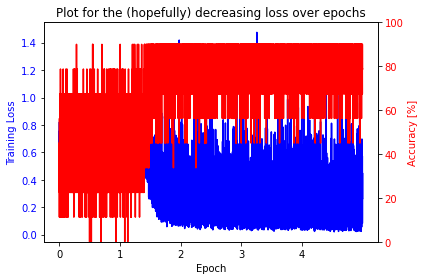

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
ax.plot(model_loss, 'b-')
ax.set_ylabel("Training Loss", color='b')
ax.set_xlabel("Epoch")
# ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='b')
ax = ax.twinx()
ax.plot(model_acc, 'r-')
ax.set_ylabel("Accuracy [%]", color='r')
ax.tick_params(axis='y', labelcolor='r')
a = list(ax.axis())
a[2] = 0
a[3] = 100
ax.axis(a)
t = np.arange(0, len(model_acc), len(model_loss)//5+1)
ax.set_xticks(ticks=t)
ax.set_xticklabels(labels=np.arange(len(t)))
fig.tight_layout()
plt.show()

For the graph, I implemented it by tensorboard but the graph needed to be displayed on another page. So I change it into matplot.

I still attrached the video about how the tensorboard worked.
